In [1]:
# All Imports

import numpy as np
import numba
from numba import njit, prange
from numba import cuda
import copy
import sys
import time
import matplotlib.pyplot as plt
import pydicom
import glob
from skimage import filters
from skimage.filters import unsharp_mask, threshold_local, threshold_minimum
import keras
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, GaussianNoise
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
from keras.layers import MaxPooling2D, merge
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras import losses
from keras.utils import to_categorical
import keras.backend as K
import matplotlib.pyplot as plt
import numpy as np
import glob

from skimage.measure import compare_ssim as ssim



import numba
from numba import njit, prange

from keras import backend as K
from keras.layers import Layer

import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau, Callback, TensorBoard
from keras import backend as keras

from skimage.measure import label
from scipy.io import loadmat
from scipy.ndimage import zoom
#from scipy.misc import imresize
import pywt

import csv
import random
import time
%matplotlib inline  

from scipy import ndimage, misc

import pywt
#import hdf5storage

import scipy.io as sio
from skimage.filters import threshold_otsu

#import pylidc as pl
#from keras.backend.tensorflow_backend import set_session
import tensorflow as tf


from keras.models import Sequential
from keras.layers.convolutional import Conv3D
from keras.layers.convolutional_recurrent import ConvLSTM2D
from keras.layers.normalization import BatchNormalization

import pywt
import numpy as np
#import pydicom
import matplotlib.pyplot as plt
import SimpleITK as sitk
import skimage.io as io
#from sklearn.decomposition import PCA
import collections, numpy
import warnings
from scipy import ndimage, misc
warnings.filterwarnings('ignore')

#import pymrt as mrt
#import pymrt.geometry
import ipyvolume as ipv
import copy


import os
import glob
import uuid
import numpy as np
from keras.utils import plot_model
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
from ipdb import set_trace as bp



#from image_gen import ImageDataGenerator
#from load_data import loadDataMontgomery, loadDataJSRT
#from build_model import build_UNet2D_4L

import pandas as pd
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint



import numpy
import warnings
from keras.layers import Convolution3D, Input, merge, RepeatVector, Activation
from keras.models import Model
from keras.layers.advanced_activations import PReLU
from keras import activations, initializers, regularizers
from keras.engine import Layer, InputSpec
from keras.utils.conv_utils import conv_output_length
#from keras.utils.np_utils import conv_output_length
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
import keras.backend as K
from keras.engine.topology import Layer
import functools
import tensorflow as tf
import pickle
import time



Using TensorFlow backend.


In [2]:
# Ray Tracing Code

import scipy.io as sio


@njit(parallel=True)
def x_y_flip(host_prjbuf_temp):
    host_prjbuf_temp_gpu  = np.copy(host_prjbuf_temp)
    host_prjbuf_1view_gpu = np.copy(host_prjbuf_temp)
    
    for i in prange(BINSx):
        for j in prange(BINSy):
            bin_ind_temp = j*BINSx+i
            bin_ind      = i*BINSy+j
            host_prjbuf_1view_gpu[bin_ind] = host_prjbuf_temp_gpu[bin_ind_temp]
    
    return host_prjbuf_1view_gpu

@njit(parallel=True)
def compute_yry(host_prj_allangle, host_scat_allangle):
    all_b_size        =  ANGLES*BINSx*BINSy
    host_yry_allangle =  np.zeros(BINSx*BINSy*ANGLES)
    
    for i in prange(all_b_size):
        if (host_prj_allangle[i] == 0):
            host_yry_allangle[i] = 0
        else:
            dif = host_prj_allangle[i] - host_scat_allangle[i]
            if (dif <= 0):
                dif = host_prj_allangle[i]
            host_yry_allangle[i] = (dif*dif)/host_prj_allangle[i]
    
    return host_yry_allangle

@njit(parallel=True)
def compute_gamma_yry(host_yry_allangle, host_gamma_allangle):
    all_b_size              = ANGLES*BINSx*BINSy
    host_gamma_yry_allangle = np.zeros(all_b_size)
    
    for i in prange(all_b_size):
        host_gamma_yry_allangle[i] = host_yry_allangle[i]*host_gamma_allangle[i]
    
    return host_gamma_yry_allangle

@njit(parallel=True)
def compute_h(host_prj_sub, host_blank_sub, host_line_sub, host_scat_sub):
    ANGLES_per_sub  = int(ANGLES/subset_num)
    sub_b_size      = int(ANGLES_per_sub*BINSx*BINSy)
    
    host_sub = np.zeros(sub_b_size)
    
    for i in prange(sub_b_size):
        y_tmp       = host_blank_sub[i]*np.exp(-host_line_sub[i])
        host_sub[i] = (host_prj_sub[i]/(y_tmp+host_scat_sub[i])-1)*y_tmp
    
    return host_sub

@njit(parallel=True)
def update_est(host_est, host_capL, host_RD, host_d, host_RDD):
    f_size    = IMGSIZx*IMGSIZy*IMGSIZz
    host_est1 = np.zeros(f_size)
    
    for i in prange(f_size):
        host_est1[i] = host_est[i]-(host_capL[i]+beta*host_RD[i])/(host_d[i]+2*beta*host_RDD[i])
        if (host_est1[i] < 0):
            host_est1[i] = 0
    
    return host_est1

@njit(parallel=True)
def regroup_prj(host_uponregroup_allangle):
    all_b_size     = int(ANGLES*BINSx*BINSy)
    ANGLES_per_sub = int(ANGLES/subset_num)
    b_size         = int(BINSx*BINSy)
    
    host_allangle_tmp = np.zeros(host_uponregroup_allangle.shape)
    flag              = 0
    
    for i in range(subset_num):
        for j in range(ANGLES_per_sub):
            for k in range(b_size):
                host_allangle_tmp[flag] = host_uponregroup_allangle[int((j*subset_num+i)*b_size+k)]
                flag = flag +1
    
    return host_allangle_tmp

import math

@cuda.jit(device=True)
def rayTrace3D_GPU_direct_notexturememory_normprj(d_normprj, x0, y0, z0, x1, y1, z1, status, sum_norm, bin_ind):
    # Perform Ray Tracing
    sum_norm = 0
    dx     = x1-x0
    dy     = y1-y0
    dz     = z1-z0
    Length = math.sqrt( dx*dx+dy*dy+dz*dz )


    if (x1 != x0):
        min_lx = (x_p0-x0)/dx
        max_lx = min_lx+IMGSIZx*Vsize_x/dx

        if (min_lx > max_lx):
            #SWAP(min_lx, max_lx);
            s_temp = min_lx
            min_lx = max_lx
            max_lx = s_temp
    else:
        # the line perpendicular to x axis
        if (x0 >= IMGSIZx*Vsize_x+x_p0 or x0<=x_p0):
            status = -1
            return
        min_lx = -1e3
        max_lx = 1e3
    
    
    if (y0 != y1):
        min_ly = (y_p0-y0)/dy
        max_ly = min_ly+IMGSIZy*Vsize_y/dy

        if (min_ly > max_ly):
            #SWAP(min_ly, max_ly);
            s_temp = min_ly
            min_ly = max_ly
            max_ly = s_temp
    else:
        # the line perpendicular to y axis
        if (y0 >= IMGSIZy*Vsize_y+y_p0 or y0 <= y_p0):
            status = -1
            return
        min_ly = -1e3
        max_ly = 1e3

    
    if (z0 != z1):
        min_lz = (z_p0-z0)/dz
        max_lz = min_lz+IMGSIZz*Vsize_z/dz
        if (min_lz > max_lz):
            #SWAP(min_lz, max_lz);
            s_temp = min_lz
            min_lz = max_lz
            max_lz = s_temp
    else:
        # the line perpendicular to z axis
        if (z0 >= IMGSIZz*Vsize_z+z_p0 or z0 <= z_p0):
            status = -1
            return
        min_lz = -1e3
        max_lz = 1e3
    
    
    max_l = max_lx
    if (max_l > max_ly):
        max_l=max_ly
    if (max_l > max_lz):
        max_l = max_lz

    min_l = min_lx
    if (min_l < min_ly):
        min_l = min_ly
    if (min_l < min_lz):
        min_l = min_lz

    if (min_l >= max_l):
        status = -1
        return
    
    if (min_lx != min_l):
        prev_x = (int)(math.floor( (min_l* dx + x0 - x_p0) / Vsize_x ))

        if (x0 < x1):
            min_lx= ((prev_x+1)*Vsize_x+x_p0-x0)/ dx
        else:
            if (x0 == x1):
                min_lx = 1e3
            else:
                min_lx = (prev_x*Vsize_x+x_p0-x0) / dx
    else:
        if (x0 < x1):
            prev_x = 0
            min_lx = ( Vsize_x+x_p0-x0 )/ dx
        else:
            prev_x = IMGSIZx-1
            min_lx = ( prev_x*Vsize_x+x_p0-x0 )/ dx
    
    if (min_ly != min_l):
        prev_y = (int)(math.floor( (min_l* dy + y0 - y_p0)/Vsize_y ))
        if (y0 < y1):
            min_ly = ( (prev_y+1)*Vsize_y+y_p0-y0)/ dy
        else:
            if (y0==y1):
                min_ly = 1e3
            else:
                min_ly = (prev_y*Vsize_y+y_p0-y0)/ dy
    else:
        if (y0<y1):
            prev_y = 0
            min_ly = ( Vsize_y+y_p0-y0 )/ dy
        else:
            prev_y = IMGSIZy-1
            min_ly = ( prev_y*Vsize_y+y_p0-y0 )/ dy
    
    if (min_lz != min_l):
        prev_z = (int)(math.floor( (min_l* dz + z0 - z_p0)/Vsize_z ))
        if (z0 < z1):
            min_lz = ( (prev_z+1)*Vsize_z+z_p0-z0)/ dz
        else:
            if (z0 == z1):
                min_lz = 1e3
            else:
                min_lz = (prev_z*Vsize_z+z_p0-z0)/ dz
    else:
        if (z0 < z1):
            prev_z = 0
            min_lz = ( Vsize_z+z_p0-z0 )/ dz
        else:
            prev_z = (int)(IMGSIZz-1)
            min_lz = ( prev_z*Vsize_z+z_p0-z0 )/dz
    
    
    min_l_new = min_lx
    if (min_l_new > min_ly):
        min_l_new = min_ly
    if (min_l_new > min_lz):
        min_l_new = min_lz
    
    incx = Vsize_x/dx
    incy = Vsize_y/dy
    incz = Vsize_z/dz

    ind = 0
    
    while ( (max_l-min_l_new)/max_l > 0.000001):
        tmp_length = (min_l_new-min_l)*Length; #<-a_ij
        if ((prev_x >= 0) and (prev_x < IMGSIZx) and (prev_y >= 0) and (prev_y < IMGSIZy) and (prev_z >= 0) and (prev_z < IMGSIZz)):
            sum_norm = sum_norm + 1*tmp_length
        
        ind = ind + 1
        if (min_l_new == min_lx):
            if (x0 < x1):
                prev_x = prev_x + 1
                min_lx = min_lx + incx; #Vsize_x/dx
            else:
                prev_x = prev_x - 1
                min_lx = min_lx - incx; #Vsize_x/dx;
        else:
            prev_x = prev_x


        if (min_l_new == min_ly):
            if (y0 < y1):
                prev_y = prev_y + 1
                min_ly = min_ly + incy; #Vsize_y / dy;
            else:
                prev_y = prev_y - 1
                min_ly = min_ly- incy; #Vsize_y/dy;
        else:
            prev_y = prev_y


        if (min_l_new == min_lz):
            if (z0 < z1):
                prev_z = prev_z + 1
                min_lz = min_lz + incz #Vsize_z/dz;
            else:
                prev_z = prev_z - 1
                min_lz = min_lz - incz; #Vsize_z/dz
        else:
            prev_z = prev_z

        min_l     = min_l_new
        min_l_new = min_lx

        if (min_l_new > min_ly):
            min_l_new = min_ly

        if (min_l_new>min_lz):
            min_l_new=min_lz
        
        
        tmp_length = (max_l-min_l)*Length
        if ((prev_x>=0) and (prev_x<IMGSIZx) and (prev_y>=0) and (prev_y<IMGSIZy) and (prev_z>=0) and (prev_z<IMGSIZz)):
            sum_norm = sum_norm + 1*tmp_length
        
        d_normprj[bin_ind] = sum_norm

@cuda.jit(device=True)
def rayTrace3D_GPU_direct_notexturememory(d_normprj, d_prjbuf, d_objbuf, x0, y0, z0, x1, y1, z1, status):
    ix, iy   = cuda.grid(2)
    
    status   = 0
    #sum_norm = 0
    
    for a in range(angleStart, angleEnd):
        s         = d_index[a]
        theta     = d_angles[s]
        sin_theta = math.sin(theta)
        cos_theta = math.cos(theta)
        x0        = sourceR*sin_theta
        z0        = sourceR*cos_theta
        y0        = sourceY
        
        # calculate bin index
        i = nbBinsX*((int)(BINSx/nBatchBINSx)) + ix
        j = nbBinsY*((int)(BINSy/nBatchBINSy)) + iy

        bin_x_pos = (x_d0+(i+0.5)*Bsize_x)
        bin_y_pos = (y_d0+(j+0.5)*Bsize_y)

        x1 =  bin_x_pos
        z1 = -detectorR
        y1 =  bin_y_pos

        # Iso-centric version
        # x1 =  bin_x_pos*cos_theta-detectorR*sin_theta
        # z1 = -bin_x_pos*sin_theta-detectorR*cos_theta
        # y1 =  bin_y_pos

        bin_ind = ((a-angleStart)*BINSx+i)*BINSy+j
        
        y0 = sourceY
        
        # Perform Ray Tracing
        fsum_norm = 0.0
        fsum      = 0.0
        
        dx     = x1-x0
        dy     = y1-y0
        dz     = z1-z0
        Length = math.sqrt( dx*dx + dy*dy + dz*dz )
        
        d_normprj[bin_ind] = 0
        d_prjbuf[bin_ind]  = 0
        
        if (x1 != x0):
            min_lx = (x_p0 - x0)/dx
            max_lx = min_lx + (IMGSIZx*Vsize_x)/dx
            if (min_lx > max_lx):
                #SWAP(min_lx, max_lx);
                s_temp = min_lx
                min_lx = max_lx
                max_lx = s_temp
        else:
            # the line perpendicular to x axis
            if ((x0 >= IMGSIZx*Vsize_x+x_p0) or x0 <= x_p0):
                status = -1
            min_lx = -1000.0
            max_lx =  1000.0
        
        if (y0 != y1):
            min_ly = (y_p0-y0)/dy
            max_ly = min_ly + IMGSIZy*Vsize_y/dy
            if (min_ly > max_ly):
                #SWAP(min_ly, max_ly);
                s_temp = min_ly
                min_ly = max_ly
                max_ly = s_temp
        else:
            # the line perpendicular to y axis
            if (y0 >= IMGSIZy*Vsize_y + y_p0 or y0 <= y_p0):
                status = -1
            min_ly = -1000.0
            max_ly =  1000.0
        
        if (z0 != z1):
            min_lz = (z_p0 - z0)/dz
            max_lz = min_lz + IMGSIZz*Vsize_z/dz
            if (min_lz > max_lz):
                #SWAP(min_lz, max_lz);
                s_temp = min_lz
                min_lz = max_lz
                max_lz = s_temp
        else:
            # the line perpendicular to z axis
            if (z0 >= IMGSIZz*Vsize_z+z_p0 or z0 <= z_p0):
                status = -1
            min_lz = -1000.0
            max_lz =  1000.0
        
        max_l = max_lx
        if (max_l > max_ly):
            max_l = max_ly
        if (max_l > max_lz):
            max_l = max_lz
        
        min_l = min_lx
        if (min_l < min_ly):
            min_l = min_ly
        if (min_l < min_lz):
            min_l = min_lz
        
        if (min_l >= max_l):
            status1 = 10
            #d_normprj[bin_ind] = 1
        else:
            status1 = 0
        if status1 != 10:
            if (min_lx != min_l):
                prev_x = (int)(math.floor( (min_l* dx + x0 - x_p0) / Vsize_x ))
                if (x0 < x1):
                    min_lx = ((prev_x+1)*Vsize_x+x_p0 - x0)/ dx
                elif (x0 == x1):
                    min_lx = 1000
                else:
                    min_lx = (prev_x*Vsize_x+x_p0-x0) / dx
                #d_normprj[bin_ind] = Vsize_x
            else:
                if (x0 < x1):
                    prev_x = 0
                    min_lx = ( Vsize_x+x_p0-x0 )/ dx
                else:
                    prev_x = IMGSIZx-1
                    min_lx = ( prev_x*Vsize_x + x_p0 - x0 )/ dx
            #d_normprj[bin_ind] = prev_x
                
            if (min_ly != min_l):
                prev_y = (int)(math.floor( (min_l* dy + y0 - y_p0)/ Vsize_y ))
                if (y0 < y1):
                    min_ly = ( (prev_y+1)*Vsize_y + y_p0 - y0)/ dy
                elif (y0 == y1):
                    min_ly = 1000
                else:
                    min_ly = (prev_y*Vsize_y + y_p0 - y0)/ dy
            else:
                if (y0 < y1):
                    prev_y = 0
                    min_ly = ( Vsize_y+y_p0-y0 )/ dy
                else:
                    prev_y = IMGSIZy-1
                    min_ly = ( prev_y*Vsize_y + y_p0 - y0 )/ dy
                
            if (min_lz != min_l):
                prev_z = (int)(math.floor( (min_l* dz + z0 - z_p0)/ Vsize_z ))
                if (z0 < z1):
                    min_lz = ( (prev_z+1)*Vsize_z+z_p0-z0)/ dz
                elif (z0 == z1):
                    min_lz = 1000
                else:
                    min_lz = (prev_z*Vsize_z + z_p0 - z0)/ dz
            else:
                if (z0 < z1):
                    prev_z = 0
                    min_lz = ( Vsize_z + z_p0 - z0 )/ dz
                else:
                    prev_z = (int)(IMGSIZz-1)
                    min_lz = ( prev_z*Vsize_z+z_p0-z0 )/dz
            
            min_l_new = min_lx
            if (min_l_new > min_ly):
                min_l_new = min_ly
            if (min_l_new > min_lz):
                min_l_new = min_lz
            
            incx = Vsize_x/dx
            incy = Vsize_y/dy
            incz = Vsize_z/dz
            
            ind = 0
            #d_normprj[bin_ind] = max_l
            while ( (max_l-min_l_new)/max_l > 0.000001):
                tmp_length = (min_l_new - min_l)*Length
                if ((prev_x >= 0) and (prev_x < IMGSIZx) and (prev_y >= 0) and (prev_y < IMGSIZy) and (prev_z >= 0) and (prev_z < IMGSIZz)):
                    fsum_norm      = fsum_norm + 1*tmp_length
                    fsum           = fsum + d_objbuf[(prev_z*IMGSIZy+prev_y)*IMGSIZx+prev_x]*tmp_length
                
                ind = ind + 1
                if (min_l_new == min_lx):
                    if (x0 < x1):
                        prev_x = prev_x + 1
                        min_lx = min_lx + incx #Vsize_x/dx
                    else:
                        prev_x = prev_x - 1
                        min_lx = min_lx - incx #Vsize_x/dx;
                else:
                    prev_x = prev_x

                if (min_l_new == min_ly):
                    if (y0 < y1):
                        prev_y = prev_y + 1
                        min_ly = min_ly + incy #Vsize_y / dy;
                    else:
                        prev_y = prev_y - 1
                        min_ly = min_ly- incy #Vsize_y/dy;
                else:
                    prev_y = prev_y

                if (min_l_new == min_lz):
                    if (z0 < z1):
                        prev_z = prev_z + 1
                        min_lz = min_lz + incz #Vsize_z/dz;
                    else:
                        prev_z = prev_z - 1
                        min_lz = min_lz - incz; #Vsize_z/dz
                else:
                    prev_z = prev_z

                min_l     = min_l_new
                min_l_new = min_lx

                if (min_l_new > min_ly):
                    min_l_new = min_ly

                if (min_l_new > min_lz):
                    min_l_new = min_lz
            
            tmp_length = (max_l - min_l)*Length
            if ((prev_x >= 0) and (prev_x < IMGSIZx) and (prev_y >= 0) and (prev_y < IMGSIZy) and (prev_z >= 0) and (prev_z < IMGSIZz)):
                fsum_norm      = fsum_norm + 1*tmp_length
                fsum           = fsum + d_objbuf[(prev_z*IMGSIZy+prev_y)*IMGSIZx+prev_x]*tmp_length
            status2 = 100
        
        if status2 == 100:
            d_normprj[bin_ind] = fsum_norm
            d_prjbuf[bin_ind]  = fsum
        
        cuda.syncthreads()
    
@cuda.jit
def ray_trace_gpu_manyangles_direct_notexturememory_normprj(d_normprj, d_angles, d_index, angleStart, angleEnd, nbBinsX, nbBinsY):
    ix, iy   = cuda.grid(2)
    
    status   = 0
    #sum_norm = 0
    
    for a in range(angleStart, angleEnd):
        #print(a)
        s         = d_index[a]
        theta     = d_angles[s]
        sin_theta = math.sin(theta)
        cos_theta = math.cos(theta)
        x0        = sourceR*sin_theta
        z0        = sourceR*cos_theta
        y0        = sourceY

        # calculate bin index
        i = nbBinsX*((int)(BINSx/nBatchBINSx)) + ix
        j = nbBinsY*((int)(BINSy/nBatchBINSy)) + iy

        bin_x_pos = (x_d0+(i+0.5)*Bsize_x)
        bin_y_pos = (y_d0+(j+0.5)*Bsize_y)

        x1 =  bin_x_pos
        z1 = -detectorR
        y1 =  bin_y_pos

        # Iso-centric version
        # x1 =  bin_x_pos*cos_theta-detectorR*sin_theta
        # z1 = -bin_x_pos*sin_theta-detectorR*cos_theta
        # y1 =  bin_y_pos

        bin_ind = ((a-angleStart)*BINSx+i)*BINSy+j
        
        y0 = sourceY
        
        # Perform Ray Tracing
        sum_norm = 0.0
        dx     = x1-x0
        dy     = y1-y0
        dz     = z1-z0
        Length = math.sqrt( dx*dx + dy*dy + dz*dz )
        d_normprj[bin_ind] = 0
        
        if (x1 != x0):
            min_lx = (x_p0 - x0)/dx
            max_lx = min_lx + (IMGSIZx*Vsize_x)/dx
            if (min_lx > max_lx):
                #SWAP(min_lx, max_lx);
                s_temp = min_lx
                min_lx = max_lx
                max_lx = s_temp
        else:
            # the line perpendicular to x axis
            if ((x0 >= IMGSIZx*Vsize_x+x_p0) or x0 <= x_p0):
                status = -1
            min_lx = -1000.0
            max_lx =  1000.0
        
        if (y0 != y1):
            min_ly = (y_p0-y0)/dy
            max_ly = min_ly + IMGSIZy*Vsize_y/dy
            if (min_ly > max_ly):
                #SWAP(min_ly, max_ly);
                s_temp = min_ly
                min_ly = max_ly
                max_ly = s_temp
        else:
            # the line perpendicular to y axis
            if (y0 >= IMGSIZy*Vsize_y + y_p0 or y0 <= y_p0):
                status = -1
            min_ly = -1000.0
            max_ly =  1000.0
        
        if (z0 != z1):
            min_lz = (z_p0 - z0)/dz
            max_lz = min_lz + IMGSIZz*Vsize_z/dz
            if (min_lz > max_lz):
                #SWAP(min_lz, max_lz);
                s_temp = min_lz
                min_lz = max_lz
                max_lz = s_temp
        else:
            # the line perpendicular to z axis
            if (z0 >= IMGSIZz*Vsize_z+z_p0 or z0 <= z_p0):
                status = -1
            min_lz = -1000.0
            max_lz =  1000.0
        
        max_l = max_lx
        if (max_l > max_ly):
            max_l = max_ly
        if (max_l > max_lz):
            max_l = max_lz
        
        min_l = min_lx
        if (min_l < min_ly):
            min_l = min_ly
        if (min_l < min_lz):
            min_l = min_lz
        
        if (min_l >= max_l):
            status1 = 10
            #d_normprj[bin_ind] = 1
        else:
            status1 = 0
        if status1 != 10:
            if (min_lx != min_l):
                prev_x = (int)(math.floor( (min_l* dx + x0 - x_p0) / Vsize_x ))
                if (x0 < x1):
                    min_lx = ((prev_x+1)*Vsize_x+x_p0 - x0)/ dx
                elif (x0 == x1):
                    min_lx = 1000
                else:
                    min_lx = (prev_x*Vsize_x+x_p0-x0) / dx
                #d_normprj[bin_ind] = Vsize_x
            else:
                if (x0 < x1):
                    prev_x = 0
                    min_lx = ( Vsize_x+x_p0-x0 )/ dx
                else:
                    prev_x = IMGSIZx-1
                    min_lx = ( prev_x*Vsize_x + x_p0 - x0 )/ dx
            #d_normprj[bin_ind] = prev_x
                
            if (min_ly != min_l):
                prev_y = (int)(math.floor( (min_l* dy + y0 - y_p0)/ Vsize_y ))
                if (y0 < y1):
                    min_ly = ( (prev_y+1)*Vsize_y + y_p0 - y0)/ dy
                elif (y0 == y1):
                    min_ly = 1000
                else:
                    min_ly = (prev_y*Vsize_y + y_p0 - y0)/ dy
            else:
                if (y0 < y1):
                    prev_y = 0
                    min_ly = ( Vsize_y+y_p0-y0 )/ dy
                else:
                    prev_y = IMGSIZy-1
                    min_ly = ( prev_y*Vsize_y + y_p0 - y0 )/ dy
                
            if (min_lz != min_l):
                prev_z = (int)(math.floor( (min_l* dz + z0 - z_p0)/ Vsize_z ))
                if (z0 < z1):
                    min_lz = ( (prev_z+1)*Vsize_z+z_p0-z0)/ dz
                elif (z0 == z1):
                    min_lz = 1000
                else:
                    min_lz = (prev_z*Vsize_z + z_p0 - z0)/ dz
            else:
                if (z0 < z1):
                    prev_z = 0
                    min_lz = ( Vsize_z + z_p0 - z0 )/ dz
                else:
                    prev_z = (int)(IMGSIZz-1)
                    min_lz = ( prev_z*Vsize_z+z_p0-z0 )/dz
            
            min_l_new = min_lx
            if (min_l_new > min_ly):
                min_l_new = min_ly
            if (min_l_new > min_lz):
                min_l_new = min_lz


            incx = Vsize_x/dx
            incy = Vsize_y/dy
            incz = Vsize_z/dz

            ind = 0
            #d_normprj[bin_ind] = max_l
            while ( (max_l-min_l_new)/max_l > 0.000001):
                tmp_length = (min_l_new - min_l)*Length
                if ((prev_x >= 0) and (prev_x < IMGSIZx) and (prev_y >= 0) and (prev_y < IMGSIZy) and (prev_z >= 0) and (prev_z < IMGSIZz)):
                    sum_norm = sum_norm + 1*tmp_length

                ind = ind + 1
                if (min_l_new == min_lx):
                    if (x0 < x1):
                        prev_x = prev_x + 1
                        min_lx = min_lx + incx #Vsize_x/dx
                    else:
                        prev_x = prev_x - 1
                        min_lx = min_lx - incx #Vsize_x/dx;
                else:
                    prev_x = prev_x

                if (min_l_new == min_ly):
                    if (y0 < y1):
                        prev_y = prev_y + 1
                        min_ly = min_ly + incy #Vsize_y / dy;
                    else:
                        prev_y = prev_y - 1
                        min_ly = min_ly- incy #Vsize_y/dy;
                else:
                    prev_y = prev_y

                if (min_l_new == min_lz):
                    if (z0 < z1):
                        prev_z = prev_z + 1
                        min_lz = min_lz + incz #Vsize_z/dz;
                    else:
                        prev_z = prev_z - 1
                        min_lz = min_lz - incz; #Vsize_z/dz
                else:
                    prev_z = prev_z

                min_l     = min_l_new
                min_l_new = min_lx

                if (min_l_new > min_ly):
                    min_l_new = min_ly

                if (min_l_new > min_lz):
                    min_l_new = min_lz
            
            tmp_length = (max_l - min_l)*Length
            if ((prev_x >= 0) and (prev_x < IMGSIZx) and (prev_y >= 0) and (prev_y < IMGSIZy) and (prev_z >= 0) and (prev_z < IMGSIZz)):
                sum_norm = sum_norm + 1*tmp_length
            status2 = 100
        if status2 == 100:
            d_normprj[bin_ind] = sum_norm
        #else:
        #    d_normprj[bin_ind] = sum_norm
#         elif status == 10:
#             d_normprj[bin_ind] = 100000
#         elif status == -1:
#             d_normprj[bin_ind] = 50000
#         else:
#             d_normprj[bin_ind] = 200000
#         d_normprj[bin_ind] = Length
        cuda.syncthreads()

@cuda.jit
def ray_trace_gpu_manyangles_direct_notexturememory_OSTR_cos(d_objbuf, d_prjbuf, d_angles, d_index, angleStart, angleEnd, nbBinsX, nbBinsY):
    ix, iy   = cuda.grid(2)
    
    status   = 0
    
    for a in range(angleStart, angleEnd):
        #print(a)
        s         = d_index[a]
        theta     = d_angles[s]
        sin_theta = math.sin(theta)
        cos_theta = math.cos(theta)
        x0        = sourceR*sin_theta
        z0        = sourceR*cos_theta
        y0        = sourceY
        
        # calculate bin index
        i = nbBinsX*((int)(BINSx/nBatchBINSx)) + ix
        j = nbBinsY*((int)(BINSy/nBatchBINSy)) + iy

        bin_x_pos = (x_d0+(i+0.5)*Bsize_x)
        bin_y_pos = (y_d0+(j+0.5)*Bsize_y)

        x1 =  bin_x_pos
        z1 = -detectorR
        y1 =  bin_y_pos

        # Iso-centric version
        # x1 =  bin_x_pos*cos_theta-detectorR*sin_theta
        # z1 = -bin_x_pos*sin_theta-detectorR*cos_theta
        # y1 =  bin_y_pos

        bin_ind = ((a-angleStart)*BINSx+i)*BINSy+j
        
        y0 = sourceY
        
        # Perform Ray Tracing
        sum_norm = 0.0
        dx     = x1-x0
        dy     = y1-y0
        dz     = z1-z0
        Length = math.sqrt( dx*dx + dy*dy + dz*dz )
        #d_prjbuf[bin_ind] = 0
        
        if (x1 != x0):
            min_lx = (x_p0 - x0)/dx
            max_lx = min_lx + (IMGSIZx*Vsize_x)/dx
            if (min_lx > max_lx):
                #SWAP(min_lx, max_lx);
                s_temp = min_lx
                min_lx = max_lx
                max_lx = s_temp
        else:
            # the line perpendicular to x axis
            if ((x0 >= IMGSIZx*Vsize_x+x_p0) or x0 <= x_p0):
                status = -1
            min_lx = -1000.0
            max_lx =  1000.0
        
        if (y0 != y1):
            min_ly = (y_p0-y0)/dy
            max_ly = min_ly + IMGSIZy*Vsize_y/dy
            if (min_ly > max_ly):
                #SWAP(min_ly, max_ly);
                s_temp = min_ly
                min_ly = max_ly
                max_ly = s_temp
        else:
            # the line perpendicular to y axis
            if (y0 >= IMGSIZy*Vsize_y + y_p0 or y0 <= y_p0):
                status = -1
            min_ly = -1000.0
            max_ly =  1000.0
        
        if (z0 != z1):
            min_lz = (z_p0 - z0)/dz
            max_lz = min_lz + IMGSIZz*Vsize_z/dz
            if (min_lz > max_lz):
                #SWAP(min_lz, max_lz);
                s_temp = min_lz
                min_lz = max_lz
                max_lz = s_temp
        else:
            # the line perpendicular to z axis
            if (z0 >= IMGSIZz*Vsize_z+z_p0 or z0 <= z_p0):
                status = -1
            min_lz = -1000.0
            max_lz =  1000.0
        
        max_l = max_lx
        if (max_l > max_ly):
            max_l = max_ly
        if (max_l > max_lz):
            max_l = max_lz
        
        min_l = min_lx
        if (min_l < min_ly):
            min_l = min_ly
        if (min_l < min_lz):
            min_l = min_lz
        
        if (min_l >= max_l):
            status1 = 10
            #d_normprj[bin_ind] = 1
        else:
            status1 = 0
        if status1 != 10:
            if (min_lx != min_l):
                prev_x = (int)(math.floor( (min_l* dx + x0 - x_p0) / Vsize_x ))
                if (x0 < x1):
                    min_lx = ((prev_x+1)*Vsize_x+x_p0 - x0)/ dx
                elif (x0 == x1):
                    min_lx = 1000
                else:
                    min_lx = (prev_x*Vsize_x+x_p0-x0) / dx
                #d_normprj[bin_ind] = Vsize_x
            else:
                if (x0 < x1):
                    prev_x = 0
                    min_lx = ( Vsize_x+x_p0-x0 )/ dx
                else:
                    prev_x = IMGSIZx-1
                    min_lx = ( prev_x*Vsize_x + x_p0 - x0 )/ dx
            #d_normprj[bin_ind] = prev_x
                
            if (min_ly != min_l):
                prev_y = (int)(math.floor( (min_l* dy + y0 - y_p0)/ Vsize_y ))
                if (y0 < y1):
                    min_ly = ( (prev_y+1)*Vsize_y + y_p0 - y0)/ dy
                elif (y0 == y1):
                    min_ly = 1000
                else:
                    min_ly = (prev_y*Vsize_y + y_p0 - y0)/ dy
            else:
                if (y0 < y1):
                    prev_y = 0
                    min_ly = ( Vsize_y+y_p0-y0 )/ dy
                else:
                    prev_y = IMGSIZy-1
                    min_ly = ( prev_y*Vsize_y + y_p0 - y0 )/ dy
                
            if (min_lz != min_l):
                prev_z = (int)(math.floor( (min_l* dz + z0 - z_p0)/ Vsize_z ))
                if (z0 < z1):
                    min_lz = ( (prev_z+1)*Vsize_z+z_p0-z0)/ dz
                elif (z0 == z1):
                    min_lz = 1000
                else:
                    min_lz = (prev_z*Vsize_z + z_p0 - z0)/ dz
            else:
                if (z0 < z1):
                    prev_z = 0
                    min_lz = ( Vsize_z + z_p0 - z0 )/ dz
                else:
                    prev_z = (int)(IMGSIZz-1)
                    min_lz = ( prev_z*Vsize_z+z_p0-z0 )/dz
            
            min_l_new = min_lx
            if (min_l_new > min_ly):
                min_l_new = min_ly
            if (min_l_new > min_lz):
                min_l_new = min_lz


            incx = Vsize_x/dx
            incy = Vsize_y/dy
            incz = Vsize_z/dz

            ind = 0
            #d_normprj[bin_ind] = max_l
            while ( (max_l-min_l_new)/max_l > 0.000001):
                tmp_length = (min_l_new - min_l)*Length
                if ((prev_x >= 0) and (prev_x < IMGSIZx) and (prev_y >= 0) and (prev_y < IMGSIZy) and (prev_z >= 0) and (prev_z < IMGSIZz)):
                    sum_norm = sum_norm + d_objbuf[(prev_z*IMGSIZy+prev_y)*IMGSIZx+prev_x]*tmp_length

                ind = ind + 1
                if (min_l_new == min_lx):
                    if (x0 < x1):
                        prev_x = prev_x + 1
                        min_lx = min_lx + incx #Vsize_x/dx
                    else:
                        prev_x = prev_x - 1
                        min_lx = min_lx - incx #Vsize_x/dx;
                else:
                    prev_x = prev_x

                if (min_l_new == min_ly):
                    if (y0 < y1):
                        prev_y = prev_y + 1
                        min_ly = min_ly + incy #Vsize_y / dy;
                    else:
                        prev_y = prev_y - 1
                        min_ly = min_ly- incy #Vsize_y/dy;
                else:
                    prev_y = prev_y

                if (min_l_new == min_lz):
                    if (z0 < z1):
                        prev_z = prev_z + 1
                        min_lz = min_lz + incz #Vsize_z/dz;
                    else:
                        prev_z = prev_z - 1
                        min_lz = min_lz - incz; #Vsize_z/dz
                else:
                    prev_z = prev_z

                min_l     = min_l_new
                min_l_new = min_lx

                if (min_l_new > min_ly):
                    min_l_new = min_ly

                if (min_l_new > min_lz):
                    min_l_new = min_lz
            
            tmp_length = (max_l - min_l)*Length
            if ((prev_x >= 0) and (prev_x < IMGSIZx) and (prev_y >= 0) and (prev_y < IMGSIZy) and (prev_z >= 0) and (prev_z < IMGSIZz)):
                sum_norm = sum_norm + d_objbuf[(prev_z*IMGSIZy+prev_y)*IMGSIZx+prev_x]*tmp_length
            status2 = 100
        
        if status2 == 100:
            d_prjbuf[bin_ind] = sum_norm*cos_theta
        cuda.syncthreads()

@cuda.jit
def ray_trace_gpu_manyangles_direct_notexturememory_cos(d_objbuf, d_prjbuf, d_normprj, d_angles, d_index, angleStart, angleEnd, nbBinsX, nbBinsY):
    ix, iy   = cuda.grid(2)
    status   = 0
    
    for a in range(angleStart, angleEnd):
        #print(a)
        s         = d_index[a]
        theta     = d_angles[s]
        sin_theta = math.sin(theta)
        cos_theta = math.cos(theta)
        x0        = sourceR*sin_theta
        z0        = sourceR*cos_theta
        y0        = sourceY
        
        # calculate bin index
        i = nbBinsX*((int)(BINSx/nBatchBINSx)) + ix
        j = nbBinsY*((int)(BINSy/nBatchBINSy)) + iy

        bin_x_pos = (x_d0+(i+0.5)*Bsize_x)
        bin_y_pos = (y_d0+(j+0.5)*Bsize_y)

        x1 =  bin_x_pos
        z1 = -detectorR
        y1 =  bin_y_pos

        # Iso-centric version
        # x1 =  bin_x_pos*cos_theta-detectorR*sin_theta
        # z1 = -bin_x_pos*sin_theta-detectorR*cos_theta
        # y1 =  bin_y_pos

        bin_ind = ((a-angleStart)*BINSx+i)*BINSy+j
        
        y0 = sourceY
        
        # Perform Ray Tracing
        fsum_norm = 0.0
        fsum      = 0.0
        
        dx     = x1-x0
        dy     = y1-y0
        dz     = z1-z0
        Length = math.sqrt( dx*dx + dy*dy + dz*dz )
        #d_prjbuf[bin_ind] = 0
        
        if (x1 != x0):
            min_lx = (x_p0 - x0)/dx
            max_lx = min_lx + (IMGSIZx*Vsize_x)/dx
            if (min_lx > max_lx):
                #SWAP(min_lx, max_lx);
                s_temp = min_lx
                min_lx = max_lx
                max_lx = s_temp
        else:
            # the line perpendicular to x axis
            if ((x0 >= IMGSIZx*Vsize_x+x_p0) or x0 <= x_p0):
                status = -1
            min_lx = -1000.0
            max_lx =  1000.0
        
        if (y0 != y1):
            min_ly = (y_p0-y0)/dy
            max_ly = min_ly + IMGSIZy*Vsize_y/dy
            if (min_ly > max_ly):
                #SWAP(min_ly, max_ly);
                s_temp = min_ly
                min_ly = max_ly
                max_ly = s_temp
        else:
            # the line perpendicular to y axis
            if (y0 >= IMGSIZy*Vsize_y + y_p0 or y0 <= y_p0):
                status = -1
            min_ly = -1000.0
            max_ly =  1000.0
        
        if (z0 != z1):
            min_lz = (z_p0 - z0)/dz
            max_lz = min_lz + IMGSIZz*Vsize_z/dz
            if (min_lz > max_lz):
                #SWAP(min_lz, max_lz);
                s_temp = min_lz
                min_lz = max_lz
                max_lz = s_temp
        else:
            # the line perpendicular to z axis
            if (z0 >= IMGSIZz*Vsize_z+z_p0 or z0 <= z_p0):
                status = -1
            min_lz = -1000.0
            max_lz =  1000.0
        
        max_l = max_lx
        if (max_l > max_ly):
            max_l = max_ly
        if (max_l > max_lz):
            max_l = max_lz
        
        min_l = min_lx
        if (min_l < min_ly):
            min_l = min_ly
        if (min_l < min_lz):
            min_l = min_lz
        
        if (min_l >= max_l):
            status1 = 10
            #d_normprj[bin_ind] = 1
        else:
            status1 = 0
        
        if status1 != 10:
            if (min_lx != min_l):
                prev_x = (int)(math.floor( (min_l* dx + x0 - x_p0) / Vsize_x ))
                if (x0 < x1):
                    min_lx = ((prev_x+1)*Vsize_x+x_p0 - x0)/ dx
                elif (x0 == x1):
                    min_lx = 1000
                else:
                    min_lx = (prev_x*Vsize_x+x_p0-x0) / dx
                #d_normprj[bin_ind] = Vsize_x
            else:
                if (x0 < x1):
                    prev_x = 0
                    min_lx = ( Vsize_x+x_p0-x0 )/ dx
                else:
                    prev_x = IMGSIZx-1
                    min_lx = ( prev_x*Vsize_x + x_p0 - x0 )/ dx
            #d_normprj[bin_ind] = prev_x
                
            if (min_ly != min_l):
                prev_y = (int)(math.floor( (min_l* dy + y0 - y_p0)/ Vsize_y ))
                if (y0 < y1):
                    min_ly = ( (prev_y+1)*Vsize_y + y_p0 - y0)/ dy
                elif (y0 == y1):
                    min_ly = 1000
                else:
                    min_ly = (prev_y*Vsize_y + y_p0 - y0)/ dy
            else:
                if (y0 < y1):
                    prev_y = 0
                    min_ly = ( Vsize_y+y_p0-y0 )/ dy
                else:
                    prev_y = IMGSIZy-1
                    min_ly = ( prev_y*Vsize_y + y_p0 - y0 )/ dy
                
            if (min_lz != min_l):
                prev_z = (int)(math.floor( (min_l* dz + z0 - z_p0)/ Vsize_z ))
                if (z0 < z1):
                    min_lz = ( (prev_z+1)*Vsize_z+z_p0-z0)/ dz
                elif (z0 == z1):
                    min_lz = 1000
                else:
                    min_lz = (prev_z*Vsize_z + z_p0 - z0)/ dz
            else:
                if (z0 < z1):
                    prev_z = 0
                    min_lz = ( Vsize_z + z_p0 - z0 )/ dz
                else:
                    prev_z = (int)(IMGSIZz-1)
                    min_lz = ( prev_z*Vsize_z+z_p0-z0 )/dz
            
            min_l_new = min_lx
            if (min_l_new > min_ly):
                min_l_new = min_ly
            if (min_l_new > min_lz):
                min_l_new = min_lz


            incx = Vsize_x/dx
            incy = Vsize_y/dy
            incz = Vsize_z/dz

            ind = 0
            #d_normprj[bin_ind] = max_l
            while ( (max_l-min_l_new)/max_l > 0.000001):
                tmp_length = (min_l_new - min_l)*Length
                if ((prev_x >= 0) and (prev_x < IMGSIZx) and (prev_y >= 0) and (prev_y < IMGSIZy) and (prev_z >= 0) and (prev_z < IMGSIZz)):
                    fsum_norm      = fsum_norm + 1*tmp_length
                    fsum           = fsum + d_objbuf[(prev_z*IMGSIZy+prev_y)*IMGSIZx+prev_x]*tmp_length

                ind = ind + 1
                if (min_l_new == min_lx):
                    if (x0 < x1):
                        prev_x = prev_x + 1
                        min_lx = min_lx + incx #Vsize_x/dx
                    else:
                        prev_x = prev_x - 1
                        min_lx = min_lx - incx #Vsize_x/dx;
                else:
                    prev_x = prev_x

                if (min_l_new == min_ly):
                    if (y0 < y1):
                        prev_y = prev_y + 1
                        min_ly = min_ly + incy #Vsize_y / dy;
                    else:
                        prev_y = prev_y - 1
                        min_ly = min_ly- incy #Vsize_y/dy;
                else:
                    prev_y = prev_y

                if (min_l_new == min_lz):
                    if (z0 < z1):
                        prev_z = prev_z + 1
                        min_lz = min_lz + incz #Vsize_z/dz;
                    else:
                        prev_z = prev_z - 1
                        min_lz = min_lz - incz; #Vsize_z/dz
                else:
                    prev_z = prev_z

                min_l     = min_l_new
                min_l_new = min_lx

                if (min_l_new > min_ly):
                    min_l_new = min_ly

                if (min_l_new > min_lz):
                    min_l_new = min_lz
            
            tmp_length = (max_l - min_l)*Length
            if ((prev_x >= 0) and (prev_x < IMGSIZx) and (prev_y >= 0) and (prev_y < IMGSIZy) and (prev_z >= 0) and (prev_z < IMGSIZz)):
                fsum_norm      = fsum_norm + 1*tmp_length
                fsum           = fsum + d_objbuf[(prev_z*IMGSIZy+prev_y)*IMGSIZx+prev_x]*tmp_length
            
            status2 = 100
        if status2 == 100:
            d_normprj[bin_ind] = fsum_norm
            d_prjbuf[bin_ind]  = fsum*cos_theta
        
        cuda.syncthreads()
    
def fprojectCB_1R_GPU_OSTR_normprj(d_normprj, d_angles, d_index, angleStart, angleEnd):
    PRJ_THREAD = PRJ_ThreX, PRJ_ThreY
    PRJ_GRID   = PRJ_GridX, PRJ_GridY
    
    for nbBinsX in range(nBatchBINSx):
        for nbBinsY in range(nBatchBINSy):
            ray_trace_gpu_manyangles_direct_notexturememory_normprj[PRJ_GRID, PRJ_THREAD](d_normprj, d_angles, d_index, angleStart, angleEnd, nbBinsX, nbBinsY)
            #cuda.synchronize()
    return

def fprojectCB_1R_GPU_OSTR_cos(estbuf, prj_est, d_angles, d_index, angleStart, angleEnd):
    PRJ_THREAD = PRJ_ThreX, PRJ_ThreY
    PRJ_GRID   = PRJ_GridX, PRJ_GridY
    
    for nbBinsX in range(nBatchBINSx):
        for nbBinsY in range(nBatchBINSy):
            ray_trace_gpu_manyangles_direct_notexturememory_OSTR_cos[PRJ_GRID, PRJ_THREAD](estbuf, prj_est, d_angles, d_index, 
                                                                                           angleStart, angleEnd, nbBinsX, nbBinsY)
            cuda.synchronize()
    return

def fprojectCB_1R_GPU_SART_cos(estbuf, prj_est, d_normprj, d_angles, d_index, angleStart, angleEnd):
    PRJ_THREAD = PRJ_ThreX, PRJ_ThreY
    PRJ_GRID   = PRJ_GridX, PRJ_GridY
    
    for nbBinsX in range(nBatchBINSx):
        for nbBinsY in range(nBatchBINSy):
            ray_trace_gpu_manyangles_direct_notexturememory_cos[PRJ_GRID, PRJ_THREAD](estbuf, prj_est, d_normprj, d_angles, 
                                                                                      d_index, angleStart, angleEnd, 
                                                                                      nbBinsX, nbBinsY)
            cuda.synchronize()
    return

@cuda.jit
def SART_prj_diff_kernel(diff_line, prjbuf, prj_est, normprj, d_index, angleStart, angleEnd, nbBinsX, nbBinsY):
    ix, iy   = cuda.grid(2)
    
    # calculate bin index
    for a in range(angleStart, angleEnd):
        i = nbBinsX*((int)(BINSx/nBatchBINSx)) + ix
        j = nbBinsY*((int)(BINSy/nBatchBINSy)) + iy
        
        bin_ind = ((a-angleStart)*BINSx+i)*BINSy+j
        
        if normprj[bin_ind] != 0:
            diff_line[bin_ind] = prjbuf[bin_ind]#bin_ind#(prjbuf[bin_ind] - prj_est[bin_ind])/normprj[bin_ind]
        else:
            diff_line[bin_ind] = bin_ind#1
    return

@njit(parallel=True)
def SART_prj_diff(diff_line, prjbuf, prj_est, normprj, d_index, angleStart, angleEnd):
    result_diff_line = np.zeros(prjbuf.shape)
    
    #for nbBinsX in prange(nBatchBINSx):
    #    for nbBinsY in prange(nBatchBINSy):
    for bin_ind in prange(prjbuf.shape[0]):
        if normprj[bin_ind] != 0:
            result_diff_line[bin_ind] = (prjbuf[bin_ind] - prj_est[bin_ind])/normprj[bin_ind]
        else:
            result_diff_line[bin_ind] = 0.0#prjbuf[bin_ind]#bin_ind
    
    return result_diff_line

#@njit(parallel=True)
def SART_prj_diff_old(diff_line, prjbuf, prj_est, normprj, d_index, angleStart, angleEnd):
    PRJ_THREAD = PRJ_ThreX, PRJ_ThreY
    PRJ_GRID   = PRJ_GridX, PRJ_GridY
    
    for nbBinsX in range(nBatchBINSx):
        for nbBinsY in range(nBatchBINSy):
            SART_prj_diff_kernel[PRJ_GRID, PRJ_THREAD](diff_line, prjbuf, prj_est, normprj, d_index, angleStart, angleEnd, nbBinsX, nbBinsY)
            cuda.synchronize()
    return
#SART_prj_diff_kernel<<<PRJ_GRID,PRJ_THREAD>>>(diff_line,prjbuf,prj_est,normprj,d_index,angleStart,angleEnd,nbBinsX,nbBinsY);
#CUT_CHECK_ERROR("Kernel execution failed");
#cudaThreadSynchronize()

#def SART_prj_diff(diff_line, prjbuf, prj_est, normprj, d_index, angleStart, angleEnd):

#@cuda.jit
def bprojectCB_4B_GPU_R_SART(d_objbuf, d_prjbuf, d_prior, d_index, 
                                   d_angles, angleStart, angleEnd, lambda_parameter, beta):
    BACKPRJ_THREAD = BACKPRJ_ThreX, BACKPRJ_ThreY
    BACKPRJ_GRID   = BACKPRJ_GridX, BACKPRJ_GridY
    
    for nbatchIDx in range(nBatchXdim):
        backprj_OSSART_gpu_manyviews_R[BACKPRJ_GRID, BACKPRJ_THREAD](d_objbuf, d_prjbuf, d_prior, d_index, 
                                                                            d_angles, angleStart, angleEnd , nbatchIDx, lambda_parameter, beta)
        cuda.synchronize()
    return

@cuda.jit
def backprj_OSSART_gpu_manyviews_R(d_objbuf, d_prjbuf, d_prior, d_index, d_angles, 
                                          angleStart, angleEnd, nbatchIDx, lambda_parameter, beta):
    bx = cuda.blockIdx.x
    by = cuda.blockIdx.y
    
    tx = cuda.threadIdx.x + (nbatchIDx*cuda.blockDim.x)
    ty = cuda.threadIdx.y
    
    tid = tx
    
    ind_x = tid
    ind_y = bx
    ind_z = by
    
    ind_voxel = (ind_z*IMGSIZy+ind_y)*IMGSIZx+ind_x
    
    total_sum         = 0.0
    total_sensitivity = 0.0
    
    for a in range(angleStart, angleEnd):
        u_term    = 0.0
        
        s         = d_index[a]
        theta     = d_angles[s]
        sin_theta = math.sin(theta)
        cos_theta = math.cos(theta)
        
        #(x0,y0,z0) - source position
        x0 = sourceR*sin_theta
        z0 = sourceR*cos_theta
        y0 = sourceY
        
        #(x1,y1,z1) - center of voxel
        x1 = (ind_x+0.5)*Vsize_x + x_p0
        y1 = (ind_y+0.5)*Vsize_y + y_p0
        z1 = (ind_z+0.5)*Vsize_z + z_p0
        
        #Check FDK paper for this weight factor. This weight can be set to 1, in a simple case
        depth_weight = (x0*x0+y0*y0+z0*z0)/((x0-x1)*(x0-x1) + (y0-y1)*(y0-y1)+(z0-z1)*(z0-z1))
        
        #Do NOT Rotate (x0,y0,z0)  -theta  around the y-axis
        y0r =y0
        x0r =x0
        z0r =z0
        
        #Do NOT Rotate (x1,y1,z1)  -theta around the y-axis
        y1r = y1
        z1r = z1
        x1r = x1
        
        if (z1r != z0r):
            t = (-detectorR - z0r) / (z1r - z0r)
            x2 = x0r + (x1r - x0r) * t
            y2 = y0r + (y1r - y0r) * t
            
            weight = 1.0
            
            # BACKPROJECTION USING INTERPOLATION
            # Calculate the continuous position (in bin_index coordinate) of the projection of voxel in the detector plane.
            imb = ((float)(x2 - x_d0)/Bsize_x)
            jmb = ((float)(y2 - y_d0)/Bsize_y)
            
            ilb = (float)(math.floor(imb))
            if (imb < (ilb+0.5)):
                ilb = ilb - 1
            
            jlb = (float)(math.floor(jmb))
            if ( jmb < (jlb+0.5)):
                jlb = jlb - 1
            
            fracI = imb - (ilb+0.5)
            fracJ = jmb - (jlb+0.5)
            
            d1 = 0
            d2 = 0
            d1_sen = 0
            d2_sen = 0
        
            # Interpolation
            if ((ilb < BINSx) and (ilb >= 0) and (jlb < BINSy) and (jlb >= 0)):
                bin_ind = ilb*BINSy + jlb
                d1      = (1-fracI) * d_prjbuf[int((a-angleStart)*BINSx*BINSy + bin_ind)]
                d1_sen  = (1-fracI) 

            if ((ilb < BINSx-1) and (ilb >= -1) and (jlb < BINSy) and (jlb >= 0)):
                bin_ind = (ilb + 1)* BINSy+ jlb
                d1      = d1 + fracI * d_prjbuf[int((a-angleStart)*BINSx*BINSy + bin_ind)]
                d1_sen  = d1_sen + fracI 

            if ((ilb < BINSx) and (ilb >= 0) and (jlb < BINSy-1) and (jlb >= -1)):
                bin_ind = ilb* BINSy + jlb + 1
                d2      = (1-fracI) * d_prjbuf[int((a-angleStart)*BINSx*BINSy + bin_ind)]
                d2_sen   =  1-fracI 

            if ((ilb<BINSx-1) and (ilb>=-1) and (jlb<BINSy-1) and (jlb>=-1)):
                bin_ind = (ilb + 1) * BINSy +  jlb + 1
                d2 = d2 + fracI  * d_prjbuf[int((a-angleStart)*BINSx*BINSy + bin_ind)]
                d2_sen = d2_sen + fracI
            
            u_term    = (1 - fracJ) * d1 + fracJ * d2
            u_term    = u_term*Vsize_z*depth_weight
            
            u_sensitivity = ((1-fracJ)*d1_sen+fracJ*d2_sen)
            u_sensitivity = u_sensitivity *Vsize_z*depth_weight
            
            total_sum         = total_sum + (u_term*weight)
            total_sensitivity = total_sensitivity+(u_sensitivity*weight)
    
    u_term    = 0
    beta_term = 0
    
    if(total_sensitivity != 0):
        u_term    = (total_sum/total_sensitivity)
        beta_term = (beta*d_prior[ind_voxel])/total_sensitivity
    
    d_objbuf[ind_voxel] = d_objbuf[ind_voxel]+lambda_parameter*(u_term+beta_term)
    if(d_objbuf[ind_voxel] < 0):
        d_objbuf[ind_voxel] = 0
    #if(d_objbuf[ind_voxel] > 0.1):
    #    d_objbuf[ind_voxel] = 0
    
    return

@cuda.jit
def backprj_gpu_manyviews_SBP(d_objbuf, d_prjbuf, d_index, d_angles, angleStart, angleEnd , nbatchIDx):
    # Block id in a 1D grid
    bx = cuda.blockIdx.x
    by = cuda.blockIdx.y
    
    tx = cuda.threadIdx.x + (nbatchIDx*cuda.blockDim.x)
    ty = cuda.threadIdx.y
    
    tid = tx
    
    ind_x = tid
    ind_y = bx
    ind_z = by
    
    ind_voxel = (ind_z*IMGSIZy+ind_y)*IMGSIZx+ind_x
    
    total_sum = 0.0
    
    for a in range(angleStart, angleEnd):
        u_term    = 0.0
        
        s         = d_index[a]
        theta     = d_angles[s]
        sin_theta = math.sin(theta)
        cos_theta = math.cos(theta)
        
        #(x0,y0,z0) - source position
        x0 = sourceR*sin_theta
        z0 = sourceR*cos_theta
        y0 = sourceY
        
        #(x1,y1,z1) - center of voxel
        x1 = (ind_x+0.5)*Vsize_x + x_p0
        y1 = (ind_y+0.5)*Vsize_y + y_p0
        z1 = (ind_z+0.5)*Vsize_z + z_p0
        
        #Check FDK paper for this weight factor. This weight can be set to 1, in a simple case
        depth_weight = (x0*x0 + y0*y0 + z0*z0)/((x0-x1)*(x0-x1) + (y0-y1)*(y0-y1)+(z0-z1)*(z0-z1))
        
        y0r = y0
        x0r = x0
        z0r = z0
        
        y1r = y1
        z1r = z1
        x1r = x1
        
        if (z1r != z0r):
            t = (-detectorR - z0r) / (z1r - z0r)
            x2 = x0r + (x1r - x0r) * t
            y2 = y0r + (y1r - y0r) * t
            
            weight = 1.0
            
            # BACKPROJECTION USING INTERPOLATION
            # Calculate the continuous position (in bin_index coordinate) of the projection of voxel in the detector plane.
            imb = ((float)(x2 - x_d0)/Bsize_x)
            jmb = ((float)(y2 - y_d0)/Bsize_y)
            
            ilb = (float)(math.floor(imb))
            if (imb < (ilb+0.5)):
                ilb = ilb - 1
            
            jlb = (float)(math.floor(jmb))
            if ( jmb < (jlb+0.5)):
                jlb = jlb - 1

            fracI = imb - (ilb+0.5)
            fracJ = jmb - (jlb+0.5)
            
            d1 = 0
            d2 = 0
            
            # Interpolation
            if ((ilb < BINSx) and (ilb >= 0) and (jlb < BINSy) and (jlb >= 0)):
                bin_ind = ilb*BINSy + jlb
                d1      = (1-fracI) * d_prjbuf[int((a-angleStart)*BINSx*BINSy + bin_ind)]
            
            if ((ilb < BINSx-1) and (ilb >= -1) and (jlb < BINSy) and (jlb >= 0)):
                bin_ind = (ilb + 1)* BINSy+ jlb
                d1      = d1 + fracI * d_prjbuf[int((a-angleStart)*BINSx*BINSy + bin_ind)]
            
            if ((ilb < BINSx) and (ilb >= 0) and (jlb < BINSy-1) and (jlb >= -1)):
                bin_ind = ilb* BINSy + jlb + 1
                d2      = (1-fracI) * d_prjbuf[int((a-angleStart)*BINSx*BINSy + bin_ind)]
            
            if ((ilb<BINSx-1) and (ilb>=-1) and (jlb<BINSy-1) and (jlb>=-1)):
                bin_ind = (ilb + 1) * BINSy +  jlb + 1
                d2 = d2 + fracI  * d_prjbuf[int((a-angleStart)*BINSx*BINSy + bin_ind)]
            
            u_term    = (1 - fracJ) * d1 + fracJ * d2
            u_term    = u_term*Vsize_z*depth_weight
            total_sum = total_sum + (u_term*weight)
        
    d_objbuf[ind_voxel] = d_objbuf[ind_voxel]+total_sum        
    return


def bprojectCB_GPU_SBP(d_objbuf, d_prjbuf, d_index, d_angles, angleStart, angleEnd):
    BACKPRJ_THREAD = BACKPRJ_ThreX, BACKPRJ_ThreY
    BACKPRJ_GRID   = BACKPRJ_GridX, BACKPRJ_GridY
    
    for nbatchIDx in range(nBatchXdim):
        backprj_gpu_manyviews_SBP[BACKPRJ_GRID, BACKPRJ_THREAD](d_objbuf, d_prjbuf, d_index, d_angles, angleStart, angleEnd , nbatchIDx)
        cuda.synchronize()
    return

@njit(parallel=True)
def temp_fun1(angleStart, b_size, sub_b_size, host_prj_allangle):
    host_prj_sub = np.zeros(sub_b_size)
    for i in prange(sub_b_size):
        host_prj_sub[i]   = host_prj_allangle[angleStart*b_size+i]
    return host_prj_sub

@njit(parallel=True)
def temp_fun2(subset_num, f_size, host_capL):
    temp = np.zeros(f_size)
    for i in prange(f_size):
        temp[i] = subset_num*host_capL[i]
    return temp

@cuda.jit
def G_Fessler_prior(RDD, RD, estbuf, delta, z_xy_ratio, nbatchIDx):
    bx = cuda.blockIdx.x
    by = cuda.blockIdx.y
    
    # Thread index
    tx = cuda.threadIdx.x + (nbatchIDx*cuda.blockDim.x)
    ty = cuda.threadIdx.y
    
    cent = 1
    tid  = tx
    
    # Calculate the index of the voxel being considered
    # ind_x = nbatchIDx*((int)(IMGSIZx/h_nBatchXdim))+ tid
    ind_x = tid
    ind_y = bx
    ind_z = by
    
    ind_voxel=int((ind_z*IMGSIZy+ind_y)*IMGSIZx+ind_x)  #(if prj is scanner data, need x_y_flip)
    #ind_voxel=(ind_z*IMGSIZx+ind_x)*IMGSIZy+ind_y;
    
    for ind_nr_z  in range(ind_z-1, ind_z+2):
        for ind_nr_y in range(ind_y-1, ind_y+2):
            for ind_nr_x in range(ind_x-1, ind_x+2):
                distance = math.sqrt(float((ind_nr_x-ind_x)*(ind_nr_x-ind_x)+(ind_nr_y-ind_y)*(ind_nr_y-ind_y)+(ind_nr_z-ind_z)*(ind_nr_z-ind_z)*z_xy_ratio*z_xy_ratio))
                
                if (distance == 0.0):
                    distance = 1.0
                    cent     = 0
                
                if ( ind_nr_x<0  or ind_nr_y<0 or ind_nr_z<0 or ind_nr_x>(IMGSIZx-1) or ind_nr_y>(IMGSIZy-1) or ind_nr_z>(IMGSIZz-1) ):
                    ind_nr = int(ind_voxel)
                else:
                    ind_nr = int(ind_nr_x + ind_nr_y*IMGSIZx + ind_nr_z*IMGSIZx*IMGSIZy)
                
                diff        = estbuf[ind_voxel]-estbuf[ind_nr]
                denominator = 1.0+abs(diff/delta)
                RDD_tmp     = cent*(1.0/distance)/denominator
                
                RDD[ind_voxel] = RDD[ind_voxel] + RDD_tmp
                RD[ind_voxel]  = RD[ind_voxel]  + RDD_tmp*diff
                
                cent = 1 # reset cent
    return

@cuda.jit
def G_Huber_prior_sart(priorbuf, estbuf, delta, nbatchIDx):
    bx = cuda.blockIdx.x
    by = cuda.blockIdx.y
    
    # Thread index
    tx = cuda.threadIdx.x + (nbatchIDx*cuda.blockDim.x)
    ty = cuda.threadIdx.y
    
    cent = 1
    tid  = tx
    
    # Calculate the index of the voxel being considered
    # ind_x = nbatchIDx*((int)(IMGSIZx/h_nBatchXdim))+ tid
    ind_x = tid
    ind_y = bx
    ind_z = by
    
    ind_voxel = int((ind_z*IMGSIZy+ind_y)*IMGSIZx+ind_x)  #(if prj is scanner data, need x_y_flip)
    #ind_voxel=(ind_z*IMGSIZx+ind_x)*IMGSIZy+ind_y;
    
    for ind_nr_z  in range(ind_z-1, ind_z+2):
        for ind_nr_y in range(ind_y-1, ind_y+2):
            for ind_nr_x in range(ind_x-1, ind_x+2):
                distance = math.sqrt(float((ind_nr_x-ind_x)*(ind_nr_x-ind_x)+(ind_nr_y-ind_y)*(ind_nr_y-ind_y)+(ind_nr_z-ind_z)*(ind_nr_z-ind_z)))
                
                if (distance == 0.0):
                    distance = 1.0
                
                if ( ind_nr_x<0  or ind_nr_y<0 or ind_nr_z<0 or ind_nr_x>(IMGSIZx-1) or ind_nr_y>(IMGSIZy-1) or ind_nr_z>(IMGSIZz-1) ):
                    ind_nr = int(ind_voxel)
                else:
                    ind_nr = int(ind_nr_x + ind_nr_y*IMGSIZx + ind_nr_z*IMGSIZx*IMGSIZy)
                
                diff        = estbuf[ind_voxel]-estbuf[ind_nr]
                denominator = math.sqrt(1.0+(diff/delta)*(diff/delta))
                
                priorbuf[ind_voxel] = priorbuf[ind_voxel] + (1.0/distance)*diff/denominator
    return    

def prior_GPU_SART(d_prior, d_est, delta):
    BACKPRJ_THREAD = BACKPRJ_ThreX, BACKPRJ_ThreY
    BACKPRJ_GRID   = BACKPRJ_GridX, BACKPRJ_GridY
    
    if (delta == 0):
        print("delta cannot be ZERO !!")
        exit(1)
    
    for nbatchIDx in range(0, nBatchXdim):
        G_Huber_prior_sart[BACKPRJ_GRID, BACKPRJ_THREAD](d_prior, d_est, delta, nbatchIDx)
        # Check out the content of this kernel in file ConebeamCT_kernel.cu
        cuda.synchronize()
    return

def prior_GPU_OSTR(d_RDD, d_RD, d_est, delta, z_xy_ratio):
    BACKPRJ_THREAD = BACKPRJ_ThreX, BACKPRJ_ThreY
    BACKPRJ_GRID   = BACKPRJ_GridX, BACKPRJ_GridY
    
    if (delta == 0):
        print("delta cannot be ZERO !!")
        exit(1)
    
    for nbatchIDx in range(0, nBatchXdim):
        G_Fessler_prior[BACKPRJ_GRID, BACKPRJ_THREAD](d_RDD, d_RD, d_est, delta, z_xy_ratio, nbatchIDx)
        # Check out the content of this kernel in file ConebeamCT_kernel.cu
        cuda.synchronize()
    return




"""
This module contains a Python and NumPy implementation of the HaarPSI perceptual similarity index algorithm,
as described in "A Haar Wavelet-Based Perceptual Similarity Index for Image Quality Assessment" by
R. Reisenhofer, S. Bosse, G. Kutyniok and T. Wiegand.

Converted by David Neumann from the original MATLAB implementation written by Rafael Reisenhofer.

Last updated on 08/01/2018 by David Neumann.
"""


import os
import numpy
from scipy import signal

try:
    os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
    import tensorflow as tf
    is_tensorflow_available = True
except ImportError:
    is_tensorflow_available = False

def haar_psi(reference_image, distorted_image, preprocess_with_subsampling = True):
    """
    Calculates the HaarPSI perceptual similarity index between the two specified images.

    Parameters:
    -----------
        reference_image: numpy.ndarray | tensorflow.Tensor | tensorflow.Variable
            The reference image, which can be in RGB or grayscale. The values must be in the range [0, 255].
            The image must be a NumPy array or TensorFlow tensor of the shape (width, height, 3) in the case
            of RGB, or a NumPy array or TensorFlow tensor in the shape (width, height) for grayscale.
        distorted_image: numpy.ndarray | tensorflow.Tensor | tensorflow.Variable
            The distorted image, which is to be compared to the reference image. The image can be in RGB or
            grayscale. The values must be in the range [0, 255]. The image must be a NumPy array or a
            TensorFlow tensor of the shape (width, height, 3) in the case of RGB, or a NumPy array or
            TensorFlow tensor in the shape (width, height) for grayscale.
        preprocess_with_subsampling: boolean
            An optional parameter, which determines whether a preprocessing step is to be performed, which
            accommodates for the viewing distance in psychophysical experiments.

    Returns:
    --------
        (float, numpy.ndarray | tensorflow.Tensor | tensorflow.Variable, numpy.ndarray | tensorflow.Tensor
        | tensorflow.Variable): Returns a three-tuple containing the similarity score, the similarity maps
        and the weight maps. The similarity score is the Haar wavelet-based perceptual similarity index,
        measured in the interval [0,1]. The similarity maps are maps of horizontal and vertical local
        similarities. For RGB images, this variable also includes a similarity map with respect to the two
        color channels in the YIQ space. The weight maps are maps that measure the importance of the local
        similarities in the similarity maps.
    """

    if is_numpy(reference_image) and is_numpy(distorted_image):
        return haar_psi_numpy(reference_image, distorted_image, preprocess_with_subsampling)
    elif is_tensorflow(reference_image) and is_tensorflow(distorted_image):
        if not is_tensorflow_available:
            raise ValueError("TensorFlow is not installed. If you have TensorFlow installed, please check your installation.")
        return haar_psi_tensorflow(reference_image, distorted_image, preprocess_with_subsampling)
    else:
        raise ValueError("The reference or the distorted image is neither a NumPy array, nor a TensorFlow tensor or variable. There are only NumPy and TensorFlow implementations available.")

def haar_psi_numpy(reference_image, distorted_image, preprocess_with_subsampling = True):
    """
    Calculates the HaarPSI perceptual similarity index between the two specified images. This implementation uses NumPy.

    Parameters:
    -----------
        reference_image: numpy.ndarray
            The reference image, which can be in RGB or grayscale. The values must be in the range [0, 255].
            The image must be a NumPy array of the shape (width, height, 3) in the case of RGB or a NumPy
            array in the shape (width, height) for grayscale.
        distorted_image: numpy.ndarray
            The distorted image, which is to be compared to the reference image. The image can be in RGB or
            grayscale. The values must be in the range [0, 255]. The image must be a NumPy array of the
            shape (width, height, 3) in the case of RGB or a NumPy array in the shape (width, height) for
            grayscale.
        preprocess_with_subsampling: boolean
            An optional parameter, which determines whether a preprocessing step is to be performed, which
            accommodates for the viewing distance in psychophysical experiments.

    Returns:
    --------
        (float, numpy.ndarray, numpy.ndarray): Returns a three-tuple containing the similarity score, the
        similarity maps and the weight maps. The similarity score is the Haar wavelet-based perceptual
        similarity index, measured in the interval [0,1]. The similarity maps are maps of horizontal and
        vertical local similarities. For RGB images, this variable also includes a similarity map with
        respect to the two color channels in the YIQ space. The weight maps are maps that measure the
        importance of the local similarities in the similarity maps.
    """

    # Checks if the image is a grayscale or an RGB image
    if reference_image.shape != distorted_image.shape:
        raise ValueError("The shapes of the reference image and the distorted image do not match.")
    if len(reference_image.shape) == 2:
        is_color_image = False
    elif reference_image.shape[2] == 1:
        is_color_image = False
    else:
        is_color_image = True

    # Converts the image values to double precision floating point numbers
    reference_image = reference_image.astype(numpy.float64)
    distorted_image = distorted_image.astype(numpy.float64)

    # The HaarPSI algorithm requires two constants, C and alpha, that have been experimentally determined
    # to be C = 30 and alpha = 4.2
    C     = 30.0
    alpha = 4.2

    # If the images are in RGB, then they are transformed to the YIQ color space
    if is_color_image:
        reference_image_y = 0.299 * reference_image[:, :, 0] + 0.587 * reference_image[:, :, 1] + 0.114 * reference_image[:, :, 2]
        distorted_image_y = 0.299 * distorted_image[:, :, 0] + 0.587 * distorted_image[:, :, 1] + 0.114 * distorted_image[:, :, 2]
        reference_image_i = 0.596 * reference_image[:, :, 0] - 0.274 * reference_image[:, :, 1] - 0.322 * reference_image[:, :, 2]
        distorted_image_i = 0.596 * distorted_image[:, :, 0] - 0.274 * distorted_image[:, :, 1] - 0.322 * distorted_image[:, :, 2]
        reference_image_q = 0.211 * reference_image[:, :, 0] - 0.523 * reference_image[:, :, 1] + 0.312 * reference_image[:, :, 2]
        distorted_image_q = 0.211 * distorted_image[:, :, 0] - 0.523 * distorted_image[:, :, 1] + 0.312 * distorted_image[:, :, 2]
    else:
        reference_image_y = reference_image
        distorted_image_y = distorted_image

    # Subsamples the images, which simulates the typical distance between an image and its viewer
    if preprocess_with_subsampling:
        reference_image_y = subsample(reference_image_y)
        distorted_image_y = subsample(distorted_image_y)
        if is_color_image:
            reference_image_i = subsample(reference_image_i)
            distorted_image_i = subsample(distorted_image_i)
            reference_image_q = subsample(reference_image_q)
            distorted_image_q = subsample(distorted_image_q)

    # Performs the Haar wavelet decomposition
    number_of_scales = 3
    coefficients_reference_image_y = haar_wavelet_decompose(reference_image_y, number_of_scales)
    coefficients_distorted_image_y = haar_wavelet_decompose(distorted_image_y, number_of_scales)
    if is_color_image:
        coefficients_reference_image_i = numpy.abs(convolve2d(reference_image_i, numpy.ones((2, 2)) / 4.0, mode = "same"))
        coefficients_distorted_image_i = numpy.abs(convolve2d(distorted_image_i, numpy.ones((2, 2)) / 4.0, mode = "same"))
        coefficients_reference_image_q = numpy.abs(convolve2d(reference_image_q, numpy.ones((2, 2)) / 4.0, mode = "same"))
        coefficients_distorted_image_q = numpy.abs(convolve2d(distorted_image_q, numpy.ones((2, 2)) / 4.0, mode = "same"))

    # Pre-allocates the variables for the local similarities and the weights
    if is_color_image:
        local_similarities = numpy.zeros(sum([reference_image_y.shape, (3, )], ()))
        weights = numpy.zeros(sum([reference_image_y.shape, (3, )], ()))
    else:
        local_similarities = numpy.zeros(sum([reference_image_y.shape, (2, )], ()))
        weights = numpy.zeros(sum([reference_image_y.shape, (2, )], ()))

    # Computes the weights and similarities for each orientation
    for orientation in range(2):
        weights[:, :, orientation] = numpy.maximum(
            numpy.abs(coefficients_reference_image_y[:, :, 2 + orientation * number_of_scales]),
            numpy.abs(coefficients_distorted_image_y[:, :, 2 + orientation * number_of_scales])
        )
        coefficients_reference_image_y_magnitude = numpy.abs(coefficients_reference_image_y[:, :, (orientation * number_of_scales, 1 + orientation * number_of_scales)])
        coefficients_distorted_image_y_magnitude = numpy.abs(coefficients_distorted_image_y[:, :, (orientation * number_of_scales, 1 + orientation * number_of_scales)])
        local_similarities[:, :, orientation] = numpy.sum(
            (2 * coefficients_reference_image_y_magnitude * coefficients_distorted_image_y_magnitude + C) / (coefficients_reference_image_y_magnitude**2 + coefficients_distorted_image_y_magnitude**2 + C),
            axis = 2
        ) / 2

    # Computes the similarities for color channels
    if is_color_image:
        similarity_i = (2 * coefficients_reference_image_i * coefficients_distorted_image_i + C) / (coefficients_reference_image_i**2 + coefficients_distorted_image_i**2 + C)
        similarity_q = (2 * coefficients_reference_image_q * coefficients_distorted_image_q + C) / (coefficients_reference_image_q**2 + coefficients_distorted_image_q**2 + C)
        local_similarities[:, :, 2] = (similarity_i + similarity_q) / 2
        weights[:, :, 2] = (weights[:, :, 0] + weights[:, :, 1]) / 2

    # Calculates the final score
    similarity = logit(numpy.sum(sigmoid(local_similarities[:], alpha) * weights[:]) / numpy.sum(weights[:]), alpha)**2

    # Returns the result
    return similarity, local_similarities, weights

def haar_psi_tensorflow(reference_image, distorted_image, preprocess_with_subsampling = True):
    """
    Calculates the HaarPSI perceptual similarity index between the two specified images. This implementation uses TensorFlow.

    Parameters:
    -----------
        reference_image: tensorflow.Tensor | tensorflow.Variable
            The reference image, which can be in RGB or grayscale. The values must be in the range [0, 255].
            The image must be a TensorFlow Tensor of the shape (width, height, 3) in the case of RGB or a
            TensorFlow tensor in the shape (width, height) for grayscale.
        distorted_image: tensorflow.Tensor | tensorflow.Variable
            The distorted image, which is to be compared to the reference image. The image can be in RGB or
            grayscale. The values must be in the range [0, 255]. The image must be a TensorFlow tensor of
            the shape (width, height, 3) in the case of RGB or a TensorFlow tensor in the shape
            (width, height) for grayscale.
        preprocess_with_subsampling: boolean
            An optional parameter, which determines whether a preprocessing step is to be performed, which
            accommodates for the viewing distance in psychophysical experiments.

    Returns:
    --------
        (float, tensorflow.Tensor, tensorflow.Tensor): Returns a three-tuple containing the similarity score,
        the similarity maps and the weight maps. The similarity score is the Haar wavelet-based perceptual
        similarity index, measured in the interval [0,1]. The similarity maps are maps of horizontal and
        vertical local similarities. For RGB images, this variable also includes a similarity map with
        respect to the two color channels in the YIQ space. The weight maps are maps that measure the
        importance of the local similarities in the similarity maps.
    """

    if not is_tensorflow_available:
        raise ValueError("TensorFlow is not installed. If you have TensorFlow installed, please check your installation.")

    # Checks if the images are both single precision floats
    if reference_image.dtype != tf.float32:
        raise ValueError("The reference image has to be single precision float.")
    if distorted_image.dtype != tf.float32:
        raise ValueError("The distorted image has to be single precision float.")

    # Checks if the image is a grayscale or an RGB image
    if reference_image.get_shape().as_list() != distorted_image.get_shape().as_list():
        raise ValueError("The shapes of the reference image and the distorted image do not match.")
    if len(reference_image.get_shape().as_list()) == 2:
        is_color_image = False
    elif reference_image.get_shape().as_list()[2] == 1:
        is_color_image = False
    else:
        is_color_image = True

    # The HaarPSI algorithm requires two constants, C and alpha, that have been experimentally determined
    # to be C = 30 and alpha = 4.2
    C = tf.constant(30.0, dtype = tf.float32)
    alpha = tf.constant(4.2, dtype = tf.float32)

    # If the images are in RGB, then they are transformed to the YIQ color space
    if is_color_image:
        reference_image_y = 0.299 * reference_image[:, :, 0] + 0.587 * reference_image[:, :, 1] + 0.114 * reference_image[:, :, 2]
        distorted_image_y = 0.299 * distorted_image[:, :, 0] + 0.587 * distorted_image[:, :, 1] + 0.114 * distorted_image[:, :, 2]
        reference_image_i = 0.596 * reference_image[:, :, 0] - 0.274 * reference_image[:, :, 1] - 0.322 * reference_image[:, :, 2]
        distorted_image_i = 0.596 * distorted_image[:, :, 0] - 0.274 * distorted_image[:, :, 1] - 0.322 * distorted_image[:, :, 2]
        reference_image_q = 0.211 * reference_image[:, :, 0] - 0.523 * reference_image[:, :, 1] + 0.312 * reference_image[:, :, 2]
        distorted_image_q = 0.211 * distorted_image[:, :, 0] - 0.523 * distorted_image[:, :, 1] + 0.312 * distorted_image[:, :, 2]
    else:
        reference_image_y = reference_image
        distorted_image_y = distorted_image

    # Subsamples the images, which simulates the typical distance between an image and its viewer
    if preprocess_with_subsampling:
        reference_image_y = subsample(reference_image_y)
        distorted_image_y = subsample(distorted_image_y)
        if is_color_image:
            reference_image_i = subsample(reference_image_i)
            distorted_image_i = subsample(distorted_image_i)
            reference_image_q = subsample(reference_image_q)
            distorted_image_q = subsample(distorted_image_q)

    # Performs the Haar wavelet decomposition
    number_of_scales = 3
    coefficients_reference_image_y = haar_wavelet_decompose(reference_image_y, number_of_scales)
    coefficients_distorted_image_y = haar_wavelet_decompose(distorted_image_y, number_of_scales)
    if is_color_image:
        coefficients_reference_image_i = tf.abs(convolve2d(reference_image_i, tf.ones((2, 2)) / 4.0, mode = "same"))
        coefficients_distorted_image_i = tf.abs(convolve2d(distorted_image_i, tf.ones((2, 2)) / 4.0, mode = "same"))
        coefficients_reference_image_q = tf.abs(convolve2d(reference_image_q, tf.ones((2, 2)) / 4.0, mode = "same"))
        coefficients_distorted_image_q = tf.abs(convolve2d(distorted_image_q, tf.ones((2, 2)) / 4.0, mode = "same"))

    # Pre-allocates the variables for the local similarities and the weights
    if is_color_image:
        local_similarities = [tf.zeros_like(reference_image_y)] * 3
        weights = [tf.zeros_like(reference_image_y)] * 3
    else:
        local_similarities = [tf.zeros_like(reference_image_y)] * 2
        weights = [tf.zeros_like(reference_image_y)] * 2

    # Computes the weights and similarities for each orientation
    for orientation in range(2):
        weights[orientation] = tf.maximum(
            tf.abs(coefficients_reference_image_y[:, :, 2 + orientation * number_of_scales]),
            tf.abs(coefficients_distorted_image_y[:, :, 2 + orientation * number_of_scales])
        )
        coefficients_reference_image_y_magnitude = tf.abs(coefficients_reference_image_y[:, :, orientation * number_of_scales:2 + orientation * number_of_scales])
        coefficients_distorted_image_y_magnitude = tf.abs(coefficients_distorted_image_y[:, :, orientation * number_of_scales:2 + orientation * number_of_scales])
        local_similarities[orientation] = tf.reduce_sum(
            (2 * coefficients_reference_image_y_magnitude * coefficients_distorted_image_y_magnitude + C) / (coefficients_reference_image_y_magnitude**2 + coefficients_distorted_image_y_magnitude**2 + C),
            axis = 2
        ) / 2
    weights = tf.stack(weights, axis = -1)
    local_similarities = tf.stack(local_similarities, axis = -1)

    # Computes the similarities for color channels
    if is_color_image:
        similarity_i = (2 * coefficients_reference_image_i * coefficients_distorted_image_i + C) / (coefficients_reference_image_i**2 + coefficients_distorted_image_i**2 + C)
        similarity_q = (2 * coefficients_reference_image_q * coefficients_distorted_image_q + C) / (coefficients_reference_image_q**2 + coefficients_distorted_image_q**2 + C)
        local_similarities = tf.concat([local_similarities[:, :, slice(0, 2)], tf.expand_dims((similarity_i + similarity_q) / 2, axis = 2)], axis = 2)
        weights = tf.concat([weights[:, :, slice(0, 2)], tf.expand_dims((weights[:, :, 0] + weights[:, :, 1]) / 2, axis = 2)], axis = 2)

    # Calculates the final score
    similarity = logit(tf.reduce_sum(sigmoid(local_similarities[:], alpha) * weights[:]) / tf.reduce_sum(weights[:]), alpha)**2

    # Returns the result
    return similarity, local_similarities, weights

def subsample(image):
    """
    Convolves the specified image with a 2x2 mean filter and performs a dyadic subsampling step. This
    simulates the typical distance between an image and its viewer.

    Parameters:
    -----------
        image: numpy.ndarray | tensorflow.Tensor | tensorflow.Variable
            The image that is to be subsampled.

    Returns:
    --------
        numpy.ndarray | tensorflow.Tensor: Returns the subsampled image.
    """

    if is_numpy(image):
        subsampled_image = convolve2d(image, numpy.ones((2, 2)) / 4.0, mode = "same")
    elif is_tensorflow(image):
        if not is_tensorflow_available:
            raise ValueError("TensorFlow is not installed. If you have TensorFlow installed, please check your installation.")
        subsampled_image = convolve2d(image, tf.ones((2, 2)) / 4.0, mode = "same")
    else:
        raise ValueError("The image is neither a NumPy array, nor a TensorFlow tensor or variable. There are only NumPy and TensorFlow implementations available.")

    subsampled_image = subsampled_image[::2, ::2]
    return subsampled_image

def convolve2d(data, kernel, mode = "same"):
    """
    Convolves the first input array with the second one in the same way MATLAB does. Due to an
    implementation detail, the SciPy and MATLAB implementations yield different results. This method
    rectifies this shortcoming of the SciPy implementation.

    Parameters:
    -----------
        data: numpy.ndarray | tensorflow.Tensor | tensorflow.Variable
            The first input array.
        kernel: numpy.ndarray | tensorflow.Tensor | tensorflow.Variable
            The second input array with which the fist input array is being convolved.
        mode: str
            A string indicating the size of the output.

    Returns:
    --------
        numpy.ndarray | tensorflow.Tensor: Returns a 2-dimensional array containing a subset of the discrete
        linear convolution of the first input array with the second input array.
    """

    # Checks if the NumPy or the TensorFlow implementation is to be used
    if is_numpy(data) and is_numpy(kernel):

        # Due to an implementation detail of MATLAB, the input arrays have to be rotated by 90 degrees to
        # retrieve a similar result as compared to MATLAB
        rotated_data = numpy.rot90(data, 2)
        rotated_kernel = numpy.rot90(kernel, 2)

        # The convolution result has to be rotated again by 90 degrees to get the same result as in MATLAB
        result = signal.convolve2d(
            rotated_data,
            rotated_kernel,
            mode = mode
        )
        result = numpy.rot90(result, 2)

    elif is_tensorflow(data) and is_tensorflow(kernel):

        if not is_tensorflow_available:
            raise ValueError("TensorFlow is not installed. If you have TensorFlow installed, please check your installation.")

        # TensorFlow requires a 4D Tensor for convolution, the data has to be shaped [batch_size, width, height, number_of_channels]
        # and the kernel has to be shaped [width, height, number_of_channels_in, number_of_channels_out]
        data_shape = data.get_shape().as_list()
        data = tf.reshape(data, [1, data_shape[0], data_shape[1], 1])
        kernel_shape = kernel.get_shape().as_list()
        kernel = tf.reshape(kernel, [kernel_shape[0], kernel_shape[1], 1, 1])

        # Calculates the convolution, for some reason that I do not fully understand, the result has to be negated
        result = tf.nn.conv2d(
            data,
            kernel,
            padding = mode.upper(),
            strides = [1, 1, 1, 1]
        )
        result = tf.negative(tf.squeeze(result))

    else:
        raise ValueError("Either the data or the kernel is neither a NumPy array, nor a TensorFlow tensor or variable. There are only NumPy and TensorFlow implementations available.")

    # Returns the result of the convolution
    return result

def haar_wavelet_decompose(image, number_of_scales):
    """
    Performs the Haar wavelet decomposition.

    Parameters:
    -----------
        image: numpy.ndarray | tensorflow.Tensor | tensorflow.Variable
            The image that is to be decomposed.
        number_of_scales: int
            The number different filter scales that is to be used.

    Returns:
    --------
        numpy.ndarray | tensorflow.Tensor: Returns the coefficients that were determined by the Haar wavelet
        decomposition.
    """

    if is_numpy(image):

        coefficients = numpy.zeros(sum([image.shape, (2 * number_of_scales, )], ()))
        for scale in range(1, number_of_scales + 1):
            haar_filter = 2**(-scale) * numpy.ones((2**scale, 2**scale))
            haar_filter[:haar_filter.shape[0] // 2, :] = -haar_filter[:haar_filter.shape[0] // 2, :]
            coefficients[:, :, scale - 1] = convolve2d(image, haar_filter, mode = "same")
            coefficients[:, :, scale + number_of_scales - 1] = convolve2d(image, numpy.transpose(haar_filter), mode = "same")

    elif is_tensorflow(image):

        if not is_tensorflow_available:
            raise ValueError("TensorFlow is not installed. If you have TensorFlow installed, please check your installation.")

        coefficients = [None] * (2 * number_of_scales)
        for scale in range(1, number_of_scales + 1):
            upper_part = -2**(-scale) * tf.ones((2**scale // 2, 2**scale))
            lower_part = 2**(-scale) * tf.ones((2**scale // 2, 2**scale))
            haar_filter = tf.concat([upper_part, lower_part], axis = 0)
            coefficients[scale - 1] = convolve2d(image, haar_filter, mode = "same")
            coefficients[scale + number_of_scales - 1] = convolve2d(image, tf.transpose(haar_filter), mode = "same")
        coefficients = tf.stack(coefficients, axis = -1)

    else:
        raise ValueError("The image is neither a NumPy array, nor a TensorFlow tensor or variable. There are only NumPy and TensorFlow implementations available.")

    return coefficients

def sigmoid(value, alpha):
    """
    Applies the sigmoid (logistic) function to the specified value.

    Parameters:
    -----------
        value: int | float | numpy.ndarray | tensorflow.Tensor | tensorflow.Variable
            The value to which the sigmoid function is to be applied.
        alpha: float
            The steepness of the "S"-shaped curve produced by the sigmoid function.

    Returns:
    --------
        int | float | numpy.ndarray | tensorflow.Tensor: Returns the result of the sigmoid function.
    """

    if is_numpy(value):
        return 1.0 / (1.0 + numpy.exp(-alpha * value))
    elif is_tensorflow(value):
        if not is_tensorflow_available:
            raise ValueError("TensorFlow is not installed. If you have TensorFlow installed, please check your installation.")
        return 1.0 / (1.0 + tf.exp(-alpha * value))
    else:
        raise ValueError("The value is neither a NumPy array, nor a TensorFlow tensor or variable. There are only NumPy and TensorFlow implementations available.")

def logit(value, alpha):
    """
    Applies the logit function to the specified value, which is the reverse of the sigmoid
    (logistic) function.

    Parameters:
    -----------
        value: int | float | numpy.ndarray | tensorflow.Tensor | tensorflow.Variable
            The value to which the logit function is to be applied.
        alpha: float
            The steepness of the "S"-shaped curve produced by the logit function.

    Returns:
    --------
        int | float | tensorflow.Tensor: Returns the result of the logit function.
    """

    if is_numpy(value):
        return numpy.log(value / (1 - value)) / alpha
    elif is_tensorflow(value):
        if not is_tensorflow_available:
            raise ValueError("TensorFlow is not installed. If you have TensorFlow installed, please check your installation.")
        return tf.log(value / (1 - value)) / alpha
    else:
        raise ValueError("The value is neither a NumPy array, nor a TensorFlow tensor or variable. There are only NumPy and TensorFlow implementations available.")

def is_numpy(value):
    """
    Determines whether the specified value is a NumPy value, i.e. an numpy.ndarray or a NumPy scalar, etc.

    Parameters:
    -----------
        value:
            The value for which is to be determined if it is a NumPy value or not.

    Returns:
    --------
        boolean: Returns True if the value is a NumPy value and False otherwise.
    """

    return type(value).__module__.split(".")[0] == "numpy"

def is_tensorflow(value):
    """
    Determines whether the specified value is a TensorFlow value, i.e. an tensorflow.Variable or a
    tensorflow.Tensor, etc.

    Parameters:
    -----------
        value:
            The value for which is to be determined if it is a TensorFlow value or not.

    Returns:
    --------
        boolean: Returns True if the value is a TensorFlow value and False otherwise.
    """

    if not is_tensorflow_available:
        raise ValueError("TensorFlow is not installed. If you have TensorFlow installed, please check your installation.")

    return type(value).__module__.split(".")[0] == "tensorflow"


In [3]:
# File Reading Code

def get_duke_proj(index, lesion):
    if lesion:
        a       = sio.loadmat("/media/dril/My Passport/CHO-DATA/WITH-LESION-MAT/LE/"+str(index)+".mat")["head"]
    else:
        a       = sio.loadmat("/media/dril/My Passport/CHO-DATA/NO-LESION-MAT/LE/"+str(index)+".mat")["head"]
    testvol = np.rollaxis(a, 2, 0)
    testvol = np.moveaxis(testvol, [0, 1, 2], [0, 2, 1])
    
    testvol[testvol == 0.80] = 0.81
    print(np.unique(testvol.flatten()))
    
    testvol = testvol/65
    proj_arr         = W*testvol
    
    # All Flags
    insert_noise     = 1
    if insert_noise:
        I0        = 1000
        proj      = I0*np.exp(-proj_arr)
        proj_noi  = np.random.poisson(proj)
        proj_noi[proj_noi == 0] = 1
        g_noi                   = np.log(I0) - np.log(proj_noi) # convert back to line integrals 
        g_noi[g_noi < 0]        = 0
        proj_arr = g_noi
    
    temp_proj = np.reshape(proj_arr, [detCols, num_angles, detRows])
    temp_proj = np.rollaxis(temp_proj, 0, 2)
    #print(temp_proj.shape)
    return temp_proj

def load_prj_raw(breast_type):
    b_size = BINSx*BINSy
    flag2  = 0
    prj_allangle  = np.zeros(BINSx*BINSy*ANGLES)
    
    print(BINSx*BINSy, ANGLES, prj_allangle.shape)
    x = []
    y = []
    
    start_angle = -21.30
    
    proj_paths = glob.glob("/media/dril/Windows/mcgpu1/projections_without_fsm"+projection_name+"/*.raw")
    proj_paths.sort(key=lambda x: int(x.split("_")[-1].split(".")[0]))
    
    for p in proj_paths:
        print(p)
        
        if '.0000.' in p:
            continue
        
        a    = np.fromfile(p, dtype='float32')#pydicom.dcmread(p)
        a    = np.reshape(a, [2, 1504, 3000])
        temp = a[0, :, :]#.pixel_array.T
        temp = np.log(10000000)-np.log(temp)
        
        if(0):
            # Sharpening filter
            temp = unsharp_mask(temp, radius=3, amount=1, preserve_range=True)
            thresh_min      = threshold_minimum(temp)
            binary_adaptive = temp > thresh_min
            temp = np.multiply(temp, binary_adaptive)
            
        if breast_type == "right":
            temp = np.fliplr(temp)
            temp = temp[-BINSy:]
        else:
            temp = temp[:BINSy]
            temp = np.flipud(temp)
            print(temp.shape)
        
        temp = temp.flatten()
        temp = x_y_flip(temp)
        
        x.append(temp)
        y.append(start_angle)
        start_angle = start_angle + 1.92
    
    y = np.array(y)*np.pi/180
    
    print("length x ", len(x), " ", len(y))
    y, x = zip(*sorted(zip(y, x)))
    for j in range(len(x)):
        print("Proj ", j)
        flag2 = j
        for i in range(0, BINSx*BINSy):
            prj_allangle[flag2*BINSx*BINSy + i]  = x[j][i]
    
    return prj_allangle, y

def load_prj_ima(breast_type):
    b_size = BINSx*BINSy
    flag2  = 0
    prj_allangle  = np.zeros(BINSx*BINSy*ANGLES)
    
    print(BINSx*BINSy, ANGLES, prj_allangle.shape)
    x = []
    y = []

    proj_paths = glob.glob("/media/dril/ubuntudata/DBT_recon_data/"+projection_name+"/CE*.IMA")
    for p in proj_paths:
        if '.0000.' in p:
            continue
        
        a    = pydicom.dcmread(p)
        temp = a.pixel_array.T
        temp = np.log(10000)-np.log(temp)
        # Sharpening filter
        temp = unsharp_mask(temp, radius=3, amount=1, preserve_range=True)
        thresh_min      = threshold_minimum(temp)
        binary_adaptive = temp > thresh_min
        temp = np.multiply(temp, binary_adaptive)
            
        if breast_type == "right":
            temp = np.fliplr(temp)
            temp = temp[-BINSy:]
        else:
            temp = temp[:BINSy]
            temp = np.flipud(temp)
        
        temp = temp.flatten()
        temp = x_y_flip(temp)
        
        x.append(temp)
        y.append(float(a[0x00181530].value))
    y = np.array(y)*np.pi/180
    
    print("length x ", len(x), " ", len(y))
    y, x = zip(*sorted(zip(y, x)))
    for j in range(len(x)):
        print("Proj ", j)
        flag2 = j
        for i in range(0, BINSx*BINSy):
            prj_allangle[flag2*BINSx*BINSy + i]  = x[j][i]
    
    return prj_allangle, y

def import_param():
    for i in range(ANGLES):
        index[i] = i
    return index

def load_prj():
    b_size = BINSx*BINSy
    flag2  = 0
    
    prj_allangle  = np.zeros(BINSx*BINSy*ANGLES)
    scat_allangle = np.zeros(BINSx*BINSy*ANGLES)
    
    for viewangle in range(ANGLES):
        s        = viewangle + 1
        filename = basepath + filepath+str(s).zfill(4)#+'.raw'
        
        with open(filename, 'rb') as f:
            primary_plus_scatter  = np.fromfile(f, dtype=np.float32)
            host_prj_temp1        = primary_plus_scatter[:b_size]
            host_prj_temp2        = primary_plus_scatter[b_size:]
        
        host_prj_1view_temp = x_y_flip(host_prj_temp1)
        host_sct_1view_temp = x_y_flip(host_prj_temp2)
        
        print(host_prj_1view_temp.shape)
        
        # all angle together
        for i in range(0, BINSx*BINSy):
            prj_allangle[flag2*BINSx*BINSy + i]  = host_prj_1view_temp[i]
            scat_allangle[flag2*BINSx*BINSy + i] = host_sct_1view_temp[i]
        
        flag2 = flag2+1
    return prj_allangle, scat_allangle
    
def load_prj_std(data_type):
    b_size = BINSx*BINSy
    flag2  = 0
    
    prj_allangle  = np.zeros(BINSx*BINSy*ANGLES)
    #scat_allangle = np.zeros(BINSx*BINSy*ANGLES)
    
    for viewangle in range(ANGLES):
        s        = viewangle + 1
        
        if data_type   == 0:
            #filename = basepath + 'OSTR_prelog/'+projection_name+str(s).zfill(4)#+".raw"
            filename = basepath + 'Projections_Renamed_Seg/'+projection_name+str(s).zfill(4)#+".raw"
        elif data_type == 1:
            filename = basepath + 'OSTR_scatter/'+scatter_name+str(s).zfill(4)#+".raw"
        else:
            filename = basepath + 'OSTR_blank/'+blank_name+str(s).zfill(4)#+".raw"
        
        #print(filename)
        with open(filename, 'rb') as f:
            #data  = np.load(f)
            data  = np.fromfile(f, dtype=np.float32)
            # If doign SART
            #data  = np.log(10000) - np.log(data)
            
            #print(data.shape)
            #data  = np.reshape(data, (1400, 3584))
            #data  = data[:1400, :]
            #data  = np.flip(data, 0)
            #data  = data.flatten()
            #print(data.shape)
                #data  = np.fromfile(f, dtype=np.float32)
        #np.save(filename+'.npy', data)
        proj = x_y_flip(data)
        
        # all angle together
        for i in range(0, BINSx*BINSy):
            prj_allangle[flag2*BINSx*BINSy + i]  = proj[i]
        
        flag2 = flag2+1
    
    return prj_allangle


In [4]:
# All settings
# CE18 right
# x_p0    = -116.25
# y_p0    = -115.1
# z_p0    = -30.0
# CE05 right
# x_p0    = -116.25
# y_p0    = -115.1
# z_p0    = -30.0
# CE08 right
# x_p0    = -116.25
# y_p0    = -115.1
# z_p0    = -30.0
# CE11 left
# x_p0    = -126.25
# y_p0    = -115.1
# z_p0    = -30.0
# CE24 right
# x_p0    = -126.25
# y_p0    = -115.1
# z_p0    = -30.0
# CE07 left
# x_p0    = -126.25
# y_p0    = -115.1
# z_p0    = -30.0
# CE14 right
# x_p0    = -126.25
# y_p0    = -115.1
# z_p0    = -30.0
# CE25 right
# x_p0    = -126.25
# y_p0    = -115.1
# z_p0    = -30.0
# CE28 right
# x_p0    = -126.25
# y_p0    = -115.1
# z_p0    = -30.0
# CE03 left
# x_p0    = -126.25
# y_p0    = -115.1
# z_p0    = -30.0
# CE06 left
# x_p0    = -126.25
# y_p0    = -115.1
# z_p0    = -30.0
# CE20 right
# x_p0    = -126.25
# y_p0    = -115.1
# z_p0    = -30.0
# CE12 right
# x_p0    = -126.25
# y_p0    = -115.1
# z_p0    = -30.0
# CE22 right
# x_p0    = -126.25
# y_p0    = -115.1
# z_p0    = -30.0

In [5]:
# Settings Hash

train_list = ['CE18', 'CE05', 'CE28', 'CE25', 'CE14', 'CE24', 'CE11',  'CE20', 'CE12', 'CE22']
x_p0_list  = [-116.25, -116.25, ]

# CE18 right
# x_p0    = 
# y_p0    = -115.1
# z_p0    = -30.0
# CE05 right
# x_p0    = 
# y_p0    = -115.1
# z_p0    = -30.0
# CE08 right
# x_p0    = -116.25
# y_p0    = -115.1
# z_p0    = -30.0
# CE11 left
# x_p0    = -126.25
# y_p0    = -115.1
# z_p0    = -30.0
# CE24 right
# x_p0    = -126.25
# y_p0    = -115.1
# z_p0    = -30.0
# CE07 left
# x_p0    = -126.25
# y_p0    = -115.1
# z_p0    = -30.0
# CE14 right
# x_p0    = -126.25
# y_p0    = -115.1
# z_p0    = -30.0
# CE25 right
# x_p0    = -126.25
# y_p0    = -115.1
# z_p0    = -30.0
# CE28 right
# x_p0    = -126.25
# y_p0    = -115.1
# z_p0    = -30.0
# CE03 left
# x_p0    = -126.25
# y_p0    = -115.1
# z_p0    = -30.0
# CE06 left
# x_p0    = -126.25
# y_p0    = -115.1
# z_p0    = -30.0
# CE20 right
# x_p0    = -126.25
# y_p0    = -115.1
# z_p0    = -30.0
# CE12 right
# x_p0    = -126.25
# y_p0    = -115.1
# z_p0    = -30.0
# CE22 right
# x_p0    = -126.25
# y_p0    = -115.1
# z_p0    = -30.0

In [5]:
# Settings Part for Monte Carlo Data

projection_name = "1"#"CE26.3584x1000."#"OSTR_LE.3584x1400."

IMGSIZx = 2600
IMGSIZy = 1200
IMGSIZz = 48
f_size  = IMGSIZx*IMGSIZy*IMGSIZz

BINSx   = 3000#3584
#BINSy   = 2816
BINSy   = 1500#1600

Vsize_x = 0.085
Vsize_y = 0.085
Vsize_z = 1

x_p0    = -IMGSIZx*Vsize_x*0.5#-116.25
y_p0    = -IMGSIZy*Vsize_y
z_p0    = -30

x_d0    = -BINSx*0.085*0.5
y_d0    = -BINSy*0.085

Bsize_x = 0.085
Bsize_y = 0.085
b_size  = BINSx*BINSy

ANGLES  = 25
index   = []
angles  = []


detectorR = 47.0
sourceR   = 608.5
sourceY   = 0.0

# Tuning Parameters
beta  = 1000
delta = 0.03
#####################

iter_num   = 5
subset_num = 5

IO_Iter = 0
method  = 0


BACKPRJ_ThreX = 390
BACKPRJ_ThreY = 1
BACKPRJ_GridX = 1000
BACKPRJ_GridY = 48
nBatchXdim    = 8

nBatchBINSx = 1
nBatchBINSy = 1

PRJ_ThreX = 15
PRJ_ThreY = 15
PRJ_GridX = 200
PRJ_GridY = 100


f_size     = IMGSIZx*IMGSIZy*IMGSIZz
all_b_size = ANGLES*BINSx*BINSy
sub_b_size = BINSx*BINSy

In [7]:
# Settings Part for Real Data

projection_name = "CE18"#"CE26.3584x1000."#"OSTR_LE.3584x1400."

IMGSIZx = 2600
IMGSIZy = 1200
IMGSIZz = 48
f_size  = IMGSIZx*IMGSIZy*IMGSIZz

BINSx   = 3584
#BINSy   = 2816
BINSy   = 1600

Vsize_x = 0.085
Vsize_y = 0.085
Vsize_z = 1

x_p0    = -116.25
y_p0    = -115.1
z_p0    = -30.0

x_d0    = -152.32
y_d0    = -137.7

Bsize_x = 0.085
Bsize_y = 0.085
b_size  = BINSx*BINSy

ANGLES  = 25
index   = []
angles  = []


detectorR = 47.0
sourceR   = 608.5
sourceY   = 0.0

# Tuning Parameters
beta  = 1000
delta = 0.03
#####################

iter_num   = 5
subset_num = 5

IO_Iter = 0
method  = 0


BACKPRJ_ThreX = 390
BACKPRJ_ThreY = 1
BACKPRJ_GridX = 1000
BACKPRJ_GridY = 48
nBatchXdim    = 8

nBatchBINSx = 1
nBatchBINSy = 1

PRJ_ThreX = 16
PRJ_ThreY = 16
PRJ_GridX = 224
PRJ_GridY = 100


f_size     = IMGSIZx*IMGSIZy*IMGSIZz
all_b_size = ANGLES*BINSx*BINSy
sub_b_size = BINSx*BINSy

In [ ]:
# Code for doing SART Recon
#h_angles
#host_prj_allangle_backup, h_angles   = load_prj_ima("right")
projection_name = "1"
host_prj_allangle_backup, h_angles   = load_prj_raw("left")
h_angles = list(h_angles)

h_index   = np.array(list(range(0, 25)))

d_angles = cuda.to_device(h_angles)
d_index  = cuda.to_device(h_index)

angleStart = 0
angleEnd   = 25


host_prj_allangle   = copy.deepcopy(host_prj_allangle_backup) #load_prj_std(0) # Load prelog  data

host_prj_allangle   = regroup_prj(host_prj_allangle)

index_tmp = np.zeros(ANGLES)
for i in range(0, ANGLES):
    index_tmp[i] = h_index[i]

flag           = 0
ANGLES_per_sub = int(ANGLES/subset_num)
h_index        = np.zeros(ANGLES, dtype=int)

for i in range(0, subset_num):
    for j in range(0, ANGLES_per_sub):
        h_index[flag] = index_tmp[j*subset_num+i]
        flag          = flag + 1
        


sub_b_size     = ANGLES_per_sub*b_size

print('sub_b_size is ', sub_b_size)
print('delta is ',      delta)
print("Indexes are ",   h_index)

In [ ]:
# Recon Loop

delta_array      = [0.0005]#[0.0001, 0.0002, 0.0003, 0.0005, 0.0006, 0.0007, 0.001]
beta_array       = []
beta_array.append(0)
# for i in range(6):
#     beta_array.append(np.random.uniform(0.11, 0.69))
beta_array       = -1*np.around(beta_array, decimals=3)
print("BETA array")
print(beta_array)

#0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1, 0]#[-0.7, -0.5, -0.3, -0.1, 0]
lambda_parameter = 0.9

for delta in delta_array:
    for beta in beta_array:
        print("Reconstructing ", beta, delta)
        
        d_line_sub     = cuda.device_array(int(sub_b_size))
        d_normprj      = cuda.device_array(int(sub_b_size))

        d_index        = cuda.to_device(h_index)

        host_est      = np.zeros(f_size, np.float32)
        d_est         = cuda.to_device(host_est)

        host_prj_est  = np.zeros(f_size, np.float32)
        prj_est       = cuda.to_device(host_prj_est)

        host_prj_est  = np.zeros(f_size, np.float32)
        prj_est       = cuda.to_device(host_prj_est)

        d_prior       = np.zeros(f_size, np.float32)
        d_prior       = cuda.to_device(d_prior)

        d_diff_line_sub = cuda.device_array(int(sub_b_size))
        d_normprj_sub   = cuda.device_array(int(sub_b_size))
        d_prj_est_sub   = cuda.device_array(int(sub_b_size))
        #d_prj_buf_sub   = cuda.device_array(int(sub_b_size))

        for i in range(0, 5):
            #print("Iteration ", i)
            for a in range(0, 5):
                angleStart = a*ANGLES_per_sub
                angleEnd   = (a+1)*ANGLES_per_sub

                host_prj_sub  = temp_fun1(angleStart, b_size, sub_b_size, host_prj_allangle)
                d_prj_buf_sub = cuda.to_device(host_prj_sub)

                d_prior       = np.zeros(f_size, np.float32)
                d_prior       = cuda.to_device(d_prior)

                prior_GPU_SART(d_prior, d_est, delta)

                fprojectCB_1R_GPU_SART_cos(
                    d_est,
                    d_prj_est_sub,
                    d_normprj_sub,
                    d_angles,
                    d_index,
                    angleStart,
                    angleEnd)

                #d_normprj_sub
                h_diff_line_sub  = d_diff_line_sub.copy_to_host()
                h_normprj_sub    = d_normprj_sub.copy_to_host()
                h_prj_est_sub    = d_prj_est_sub.copy_to_host()

                #h_normprj_sub[h_normprj_sub  < 0.5] = 10000

                result_diff = SART_prj_diff(h_diff_line_sub,
                    host_prj_sub,
                    h_prj_est_sub,
                    h_normprj_sub,
                    h_index,
                    angleStart,
                    angleEnd)

                #result_diff[result_diff > 0.5] = 0
                #result_diff[result_diff > 100] = 0
                #result_diff = np.nan_to_num(np.divide(host_prj_sub - h_prj_est_sub, h_normprj_sub))

                d_diff_line_sub = cuda.to_device(result_diff)

                bprojectCB_4B_GPU_R_SART (d_est, d_diff_line_sub, d_prior,
                                          d_index,
                                          d_angles,
                                          angleStart,
                                          angleEnd,
                                          lambda_parameter, beta)

                d_prj_est_sub = np.zeros(d_prj_est_sub.shape)
                d_prj_est_sub = cuda.to_device(d_prj_est_sub)

                d_normprj_sub = np.zeros(d_normprj_sub.shape)
                d_normprj_sub = cuda.to_device(d_normprj_sub)

                d_prj_buf_sub = np.zeros(d_prj_buf_sub.shape)
                d_prj_buf_sub = cuda.to_device(d_prj_buf_sub)
                
        host_est = d_est.copy_to_host()
        host_est.astype('float32').tofile('/media/dril/My Passport/'+projection_name+'_'+str(IMGSIZx)+'x'+str(IMGSIZy)+'x'+str(IMGSIZz)+'.'+str(i)+'_'+str(delta)+'_'+str(beta)+'.raw')
        

In [ ]:
# CNN Models

def rating_cnn(input_size = (256, 256, 1)):
    filter1 = 4
    filter2 = 4
    filter3 = 4
    filter4 = 4
    
    input1 = Input(input_size)
    
    conv1 = Conv2D(filter1, 3, padding = 'same',kernel_initializer = 'glorot_normal')(input1)
    conv1 = LeakyReLU()(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    #conv1 = Dropout(0.2)(conv1)
    
    conv2 = Conv2D(filter2, 3, padding = 'same', kernel_initializer = 'glorot_normal')(conv1)
    conv2 = LeakyReLU()(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    #conv2 = Dropout(0.2)(conv2)
    
    conv2 = Conv2D(filter2, 3, padding = 'same', kernel_initializer = 'glorot_normal')(conv2)
    conv2 = LeakyReLU()(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    #conv2 = Dropout(0.2)(conv2)
    
    conv3 = Conv2D(filter3, 3, padding = 'same', kernel_initializer = 'glorot_normal')(conv2)
    conv3 = LeakyReLU()(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    #conv3 = Dropout(0.2)(conv3)
    
    conv4 = Conv2D(filter4, 3, padding = 'same', kernel_initializer = 'glorot_normal')(conv3)
    conv4 = LeakyReLU()(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    
    out1 = Flatten()(conv4)
    #out1 = Dropout(0.3)(out1)
    
    #out2 = Dense(64, kernel_initializer = 'glorot_normal')(out1)
    #out2 = LeakyReLU()(out2)
    #out2 = Dropout(0.3)(out2)
    
    #out3 = Dense(32,  kernel_initializer = 'glorot_normal')(out2)
    #out3 = LeakyReLU()(out3)
    
    out3 = Dense(1, activation="sigmoid")(out1)
    
    model  = Model(input = input1, output = out3)
    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model

def unet_double(pretrained_weights = None, input_size = (128, 128, 5), ):
    filter1 = 64
    filter2 = 128
    filter3 = 256
    filter4 = 512
    filter5 = 1024
    
    input1 = Input(input_size)
    input2 = Input((1, ))
    input3 = Input((1, ))
    
    hash_val1 = Dense(128, activation='relu')(input2)
    hash_val1 = Dense(1, activation='relu')(hash_val1)
    
    hash_val2 = Dense(128, activation='relu')(input3)
    hash_val2 = Dense(1, activation='relu')(hash_val2)
    
    hash_val = Multiply()([hash_val1, hash_val2])
    
    hash_val = Dense(128, activation='relu')(hash_val)
    hash_val = Dense(1, activation='relu')(hash_val)
    
    conv1 = Conv2D(filter1, 3, padding = 'same', kernel_initializer = 'he_normal')(input1)
    conv1 = LeakyReLU(0.2)(conv1)
    conv1 = Conv2D(filter1, 3, padding = 'same', kernel_initializer = 'he_normal')(conv1)
    conv1 = LeakyReLU(0.2)(conv1)
    conv1 = Multiply()([hash_val, conv1])
    
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(filter2, 3, padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = LeakyReLU(0.2)(conv2)
    conv2 = Conv2D(filter2, 3, padding = 'same', kernel_initializer = 'he_normal')(conv2)
    conv2 = LeakyReLU(0.2)(conv2)
    conv2 = Multiply()([hash_val, conv2])
    
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = LeakyReLU(0.2)(conv3)
    conv3 = Conv2D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv3)
    conv3 = LeakyReLU(0.2)(conv3)
    conv3 = Multiply()([hash_val, conv3])
    
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(filter4, 3,  padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = LeakyReLU(0.2)(conv4)
    conv4 = Conv2D(filter4, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv4)
    conv4 = LeakyReLU(0.2)(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
    pool4 = Multiply()([hash_val, pool4])
    
    conv5 = Conv2D(filter5, 3,  padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = LeakyReLU(0.2)(conv5)
    conv5 = Conv2D(filter5, 3, padding = 'same', kernel_initializer = 'he_normal')(conv5)
    conv5 = LeakyReLU(0.2)(conv5)
    drop5 = Dropout(0.5)(conv5)
    drop5 = Multiply()([hash_val, drop5])
    
    up6    = Conv2D(filter4, 2,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    up6    = LeakyReLU(0.2)(up6)
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6  = Conv2D(filter4, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6  = LeakyReLU(0.2)(conv6)
    conv6  = Conv2D(filter4, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv6)
    conv6  = LeakyReLU(0.2)(conv6)
    conv6  = Multiply()([hash_val, conv6])
        
    up7    = Conv2D(filter3, 2,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    up7    = LeakyReLU(0.2)(up7)
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7  = Conv2D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7  = LeakyReLU(0.2)(conv7)
    conv7  = Conv2D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv7)
    conv7  = LeakyReLU(0.2)(conv7)
    conv7  = Multiply()([hash_val, conv7])
    
    up8    = Conv2D(filter2, 2,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    up8    = LeakyReLU(0.2)(up8)
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8  = Conv2D(filter2, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8  = LeakyReLU(0.2)(conv8)
    conv8  = Conv2D(filter2, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv8)
    conv8  = LeakyReLU(0.2)(conv8)
    conv8  = Multiply()([hash_val, conv8])
    
    up9    = Conv2D(filter1, 2,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    up9    = LeakyReLU(0.2)(up9)
    merge9 = concatenate([conv1,up9], axis = 3)
    
    conv9  = Conv2D(filter1, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9  = LeakyReLU(0.2)(conv9)
    conv9  = Conv2D(filter1, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9  = LeakyReLU(0.2)(conv9)
    conv9  = Conv2D(1, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9  = LeakyReLU(0.2)(conv9)
    
    input_last  = Lambda(lambda x: x[:, :, :, 4])(input1)
    input_last  = Reshape([128, 128, 1])(input_last)
    
    conv10 = Subtract()([input_last, conv9])
    model  = Model(input = [input1, input2, input3], output = conv10)
    model.compile(optimizer = Adam(lr = 1e-4), loss = 'mean_absolute_error', metrics = ['mse'])
    
    #model.summary()
    return model

def unet_vanilla(pretrained_weights = None, input_size = (128, 128, 1), ):
    filter1 = 32
    filter2 = 64
    filter3 = 128
    filter4 = 256
    filter5 = 512
    
    input1 = Input(input_size)
    #input2 = Input((1, ))
    
    #hash_val = Dense(128, activation='relu')(input2)
    #hash_val = Dense(32, activation='relu')(hash_val)
    #hash_val = Dense(1, activation='relu')(hash_val)
    
    #input_mul = Multiply()([hash_val, input1])
    
    conv1 = Conv2D(filter1, 3, padding = 'same', kernel_initializer = 'he_normal')(input1)
    conv1 = LeakyReLU(0.2)(conv1)
    conv1 = Conv2D(filter1, 3, padding = 'same', kernel_initializer = 'he_normal')(conv1)
    conv1 = LeakyReLU(0.2)(conv1)
    #conv1 = Multiply()([hash_val, conv1])
    
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(filter2, 3, padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = LeakyReLU(0.2)(conv2)
    conv2 = Conv2D(filter2, 3, padding = 'same', kernel_initializer = 'he_normal')(conv2)
    conv2 = LeakyReLU(0.2)(conv2)
    #conv2 = Multiply()([hash_val, conv2])
    
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = LeakyReLU(0.2)(conv3)
    conv3 = Conv2D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv3)
    conv3 = LeakyReLU(0.2)(conv3)
    #conv3 = Multiply()([hash_val, conv3])
    
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(filter4, 3,  padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = LeakyReLU(0.2)(conv4)
    conv4 = Conv2D(filter4, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv4)
    conv4 = LeakyReLU(0.2)(conv4)
    drop4 = Dropout(0.1)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
    #pool4 = Multiply()([hash_val, pool4])
    
    conv5 = Conv2D(filter5, 3,  padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = LeakyReLU(0.2)(conv5)
    conv5 = Conv2D(filter5, 3, padding = 'same', kernel_initializer = 'he_normal')(conv5)
    conv5 = LeakyReLU(0.2)(conv5)
    drop5 = Dropout(0.1)(conv5)
    #drop5 = Multiply()([hash_val, drop5])
    
    up6    = Conv2D(filter4, 2,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    up6    = LeakyReLU(0.2)(up6)
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6  = Conv2D(filter4, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6  = LeakyReLU(0.2)(conv6)
    conv6  = Conv2D(filter4, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv6)
    conv6  = LeakyReLU(0.2)(conv6)
    #conv6  = Multiply()([hash_val, conv6])
        
    up7    = Conv2D(filter3, 2,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    up7    = LeakyReLU(0.2)(up7)
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7  = Conv2D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7  = LeakyReLU(0.2)(conv7)
    conv7  = Conv2D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv7)
    conv7  = LeakyReLU(0.2)(conv7)
    #conv7  = Multiply()([hash_val, conv7])
    
    up8    = Conv2D(filter2, 2,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    up8    = LeakyReLU(0.2)(up8)
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8  = Conv2D(filter2, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8  = LeakyReLU(0.2)(conv8)
    conv8  = Conv2D(filter2, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv8)
    conv8  = LeakyReLU(0.2)(conv8)
    #conv8  = Multiply()([hash_val, conv8])
    
    up9    = Conv2D(filter1, 2,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    up9    = LeakyReLU(0.2)(up9)
    merge9 = concatenate([conv1,up9], axis = 3)
    
    conv9  = Conv2D(filter1, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9  = LeakyReLU(0.2)(conv9)
    conv9  = Conv2D(filter1, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9  = LeakyReLU(0.2)(conv9)
    conv9  = Conv2D(1, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9  = LeakyReLU(0.2)(conv9)
    
    #input_last  = Lambda(lambda x: x[:, :, :, 4])(input1)
    input_last  = input1#Reshape([128, 128, 1])(input_last)
    
    conv10 = Subtract()([input_last, conv9])
    model  = Model(input = input1, output = conv10)
    model.compile(optimizer = Adam(lr = 1e-4), loss = 'mean_absolute_error', metrics = ['mse'])
    
    #model.summary()
    return model

def unet_two(pretrained_weights = None, input_size = (128, 128, 1), ):
    filter1 = 64
    filter2 = 128
    filter3 = 256
    filter4 = 512
    filter5 = 512
    
    input1 = Input(input_size)
    input2 = Input((1, ))
    
    hash_val = Dense(128, activation='relu')(input2)
    hash_val = Dropout(0.3)(hash_val)
    hash_val = Dense(32, activation='relu')(hash_val)
    hash_val = Dense(1, activation='relu')(hash_val)
    
    hash_val1 = Dense(128, activation='relu')(input2)
    hash_val1 = Dropout(0.3)(hash_val1)
    hash_val1 = Dense(32, activation='relu')(hash_val1)
    hash_val1 = Dense(1, activation='relu')(hash_val1)
    
    input_mul = Multiply()([hash_val, input1])
    
    conv1 = Conv2D(filter1, 3, padding = 'same', kernel_initializer = 'he_normal')(input1)
    conv1 = LeakyReLU(0.2)(conv1)
    conv1 = Conv2D(filter1, 3, padding = 'same', kernel_initializer = 'he_normal')(conv1)
    conv1 = LeakyReLU(0.2)(conv1)
    conv1 = Multiply()([hash_val, conv1])
    
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(filter2, 3, padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = LeakyReLU(0.2)(conv2)
    conv2 = Conv2D(filter2, 3, padding = 'same', kernel_initializer = 'he_normal')(conv2)
    conv2 = LeakyReLU(0.2)(conv2)
    conv2 = Dropout(0.2)(conv2)
    conv2 = Multiply()([hash_val, conv2])
    
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = LeakyReLU(0.2)(conv3)
    conv3 = Conv2D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv3)
    conv3 = LeakyReLU(0.2)(conv3)
    conv3 = Multiply()([hash_val, conv3])
    
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(filter4, 3,  padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = LeakyReLU(0.2)(conv4)
    conv4 = Conv2D(filter4, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv4)
    conv4 = LeakyReLU(0.2)(conv4)
    drop4 = Dropout(0.2)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
    pool4 = Multiply()([hash_val, pool4])
    
    conv5 = Conv2D(filter5, 3,  padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = LeakyReLU(0.2)(conv5)
    conv5 = Conv2D(filter5, 3, padding = 'same', kernel_initializer = 'he_normal')(conv5)
    conv5 = LeakyReLU(0.2)(conv5)
    drop5 = Dropout(0.2)(conv5)
    drop5 = Multiply()([hash_val, drop5])
    
    up6    = Conv2D(filter4, 2,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    up6    = LeakyReLU(0.2)(up6)
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6  = Conv2D(filter4, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6  = LeakyReLU(0.2)(conv6)
    conv6  = Conv2D(filter4, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv6)
    conv6  = LeakyReLU(0.2)(conv6)
    conv6  = Dropout(0.2)(conv6)
    conv6  = Multiply()([hash_val1, conv6])
        
    up7    = Conv2D(filter3, 2,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    up7    = LeakyReLU(0.2)(up7)
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7  = Conv2D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7  = LeakyReLU(0.2)(conv7)
    conv7  = Conv2D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv7)
    conv7  = LeakyReLU(0.2)(conv7)
    conv7  = Dropout(0.2)(conv7)
    conv7  = Multiply()([hash_val1, conv7])
    
    up8    = Conv2D(filter2, 2,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    up8    = LeakyReLU(0.2)(up8)
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8  = Conv2D(filter2, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8  = LeakyReLU(0.2)(conv8)
    conv8  = Conv2D(filter2, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv8)
    conv8  = LeakyReLU(0.2)(conv8)
    conv8  = Dropout(0.2)(conv8)
    conv8  = Multiply()([hash_val1, conv8])
    
    up9    = Conv2D(filter1, 2,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    up9    = LeakyReLU(0.2)(up9)
    merge9 = concatenate([conv1,up9], axis = 3)
    
    conv9  = Conv2D(filter1, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9  = LeakyReLU(0.2)(conv9)
    conv9  = Conv2D(filter1, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9  = LeakyReLU(0.2)(conv9)
    conv9  = Conv2D(1, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9  = LeakyReLU(0.2)(conv9)
    
    #input_last  = Lambda(lambda x: x[:, :, :, 4])(input1)
    input_last  = input1#Reshape([128, 128, 1])(input_last)
    
    conv10 = Subtract()([input_last, conv9])
    model  = Model(input = [input1, input2], output = conv10)
    model.compile(optimizer = Adam(lr = 1e-4), loss = 'mean_absolute_error', metrics = ['mse'])
    
    #model.summary()
    return model

def unet(pretrained_weights = None, input_size = (256, 256, 1), ):
    filter1 = 32
    filter2 = 64
    filter3 = 128
    filter4 = 256
    filter5 = 512
    
    input1 = Input(input_size)
    input2 = Input((1, ))
    
    hash_val = Dense(128, activation='relu')(input2)
    hash_val = Dropout(0.3)(hash_val)
    hash_val = Dense(32, activation='relu')(hash_val)
    hash_val = Dense(1, activation='relu')(hash_val)
    
    input_mul = Multiply()([hash_val, input1])
    
    conv1 = Conv2D(filter1, 3, padding = 'same', kernel_initializer = 'he_normal')(input1)
    conv1 = LeakyReLU(0.2)(conv1)
    conv1 = Conv2D(filter1, 3, padding = 'same', kernel_initializer = 'he_normal')(conv1)
    conv1 = LeakyReLU(0.2)(conv1)
    conv1 = Multiply()([hash_val, conv1])
    
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(filter2, 3, padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = LeakyReLU(0.2)(conv2)
    conv2 = Conv2D(filter2, 3, padding = 'same', kernel_initializer = 'he_normal')(conv2)
    conv2 = LeakyReLU(0.2)(conv2)
    conv2 = Dropout(0.2)(conv2)
    conv2 = Multiply()([hash_val, conv2])
    
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = LeakyReLU(0.2)(conv3)
    conv3 = Conv2D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv3)
    conv3 = LeakyReLU(0.2)(conv3)
    conv3 = Multiply()([hash_val, conv3])
    
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(filter4, 3,  padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = LeakyReLU(0.2)(conv4)
    conv4 = Conv2D(filter4, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv4)
    conv4 = LeakyReLU(0.2)(conv4)
    drop4 = Dropout(0.2)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
    pool4 = Multiply()([hash_val, pool4])
    
    conv5 = Conv2D(filter5, 3,  padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = LeakyReLU(0.2)(conv5)
    conv5 = Conv2D(filter5, 3, padding = 'same', kernel_initializer = 'he_normal')(conv5)
    conv5 = LeakyReLU(0.2)(conv5)
    drop5 = Dropout(0.2)(conv5)
    drop5 = Multiply()([hash_val, drop5])
    
    up6    = Conv2D(filter4, 2,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    up6    = LeakyReLU(0.2)(up6)
    merge6 = concatenate([drop4, up6], axis = 3)
    
    
    conv6  = Conv2D(filter4, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6  = LeakyReLU(0.2)(conv6)
    conv6  = Conv2D(filter4, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv6)
    conv6  = LeakyReLU(0.2)(conv6)
    conv6  = Dropout(0.2)(conv6)
    conv6  = Multiply()([hash_val, conv6])
        
    up7    = Conv2D(filter3, 2,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    up7    = LeakyReLU(0.2)(up7)
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7  = Conv2D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7  = LeakyReLU(0.2)(conv7)
    conv7  = Conv2D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv7)
    conv7  = LeakyReLU(0.2)(conv7)
    conv7  = Dropout(0.2)(conv7)
    conv7  = Multiply()([hash_val, conv7])
    
    up8    = Conv2D(filter2, 2,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    up8    = LeakyReLU(0.2)(up8)
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8  = Conv2D(filter2, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8  = LeakyReLU(0.2)(conv8)
    conv8  = Conv2D(filter2, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv8)
    conv8  = LeakyReLU(0.2)(conv8)
    conv8  = Dropout(0.2)(conv8)
    conv8  = Multiply()([hash_val, conv8])
    
    up9    = Conv2D(filter1, 2,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    up9    = LeakyReLU(0.2)(up9)
    merge9 = concatenate([conv1,up9], axis = 3)
    
    conv9  = Conv2D(filter1, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9  = LeakyReLU(0.2)(conv9)
    conv9  = Conv2D(filter1, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9  = LeakyReLU(0.2)(conv9)
    conv9  = Conv2D(1, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9  = LeakyReLU(0.2)(conv9)
    
    #input_last  = Lambda(lambda x: x[:, :, :, 4])(input1)
    input_last  = input1#Reshape([128, 128, 1])(input_last)
    
    conv10 = Subtract()([input_last, conv9])
    model  = Model(input = [input1, input2], output = conv10)
    model.compile(optimizer = Adam(lr = 1e-4), loss = 'mean_absolute_error', metrics = ['mse'])
    
    #model.summary()
    return model

def unet_no_dense(pretrained_weights = None, input_size = (256, 256, 1), ):
    filter1 = 32
    filter2 = 64
    filter3 = 128
    filter4 = 256
    filter5 = 512
    
    input1 = Input(input_size)
    input2 = Input((1, ))
    
    #hash_val = Dense(128, activation='relu')(input2)
    #hash_val = Dropout(0.3)(hash_val)
    #hash_val = Dense(32, activation='relu')(hash_val)
    hash_val = input2#Dense(1, activation='relu')(hash_val)
    
    input_mul = Multiply()([hash_val, input1])
    
    conv1 = Conv2D(filter1, 3, padding = 'same', kernel_initializer = 'he_normal')(input1)
    conv1 = LeakyReLU(0.2)(conv1)
    conv1 = Conv2D(filter1, 3, padding = 'same', kernel_initializer = 'he_normal')(conv1)
    conv1 = LeakyReLU(0.2)(conv1)
    conv1 = Multiply()([hash_val, conv1])
    
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(filter2, 3, padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = LeakyReLU(0.2)(conv2)
    conv2 = Conv2D(filter2, 3, padding = 'same', kernel_initializer = 'he_normal')(conv2)
    conv2 = LeakyReLU(0.2)(conv2)
    conv2 = Dropout(0.2)(conv2)
    conv2 = Multiply()([hash_val, conv2])
    
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = LeakyReLU(0.2)(conv3)
    conv3 = Conv2D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv3)
    conv3 = LeakyReLU(0.2)(conv3)
    conv3 = Multiply()([hash_val, conv3])
    
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(filter4, 3,  padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = LeakyReLU(0.2)(conv4)
    conv4 = Conv2D(filter4, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv4)
    conv4 = LeakyReLU(0.2)(conv4)
    drop4 = Dropout(0.2)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
    pool4 = Multiply()([hash_val, pool4])
    
    conv5 = Conv2D(filter5, 3,  padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = LeakyReLU(0.2)(conv5)
    conv5 = Conv2D(filter5, 3, padding = 'same', kernel_initializer = 'he_normal')(conv5)
    conv5 = LeakyReLU(0.2)(conv5)
    drop5 = Dropout(0.2)(conv5)
    drop5 = Multiply()([hash_val, drop5])
    
    up6    = Conv2D(filter4, 2,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    up6    = LeakyReLU(0.2)(up6)
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6  = Conv2D(filter4, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6  = LeakyReLU(0.2)(conv6)
    conv6  = Conv2D(filter4, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv6)
    conv6  = LeakyReLU(0.2)(conv6)
    conv6  = Dropout(0.2)(conv6)
    conv6  = Multiply()([hash_val, conv6])
        
    up7    = Conv2D(filter3, 2,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    up7    = LeakyReLU(0.2)(up7)
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7  = Conv2D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7  = LeakyReLU(0.2)(conv7)
    conv7  = Conv2D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv7)
    conv7  = LeakyReLU(0.2)(conv7)
    conv7  = Dropout(0.2)(conv7)
    conv7  = Multiply()([hash_val, conv7])
    
    up8    = Conv2D(filter2, 2,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    up8    = LeakyReLU(0.2)(up8)
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8  = Conv2D(filter2, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8  = LeakyReLU(0.2)(conv8)
    conv8  = Conv2D(filter2, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv8)
    conv8  = LeakyReLU(0.2)(conv8)
    conv8  = Dropout(0.2)(conv8)
    conv8  = Multiply()([hash_val, conv8])
    
    up9    = Conv2D(filter1, 2,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    up9    = LeakyReLU(0.2)(up9)
    merge9 = concatenate([conv1,up9], axis = 3)
    
    conv9  = Conv2D(filter1, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9  = LeakyReLU(0.2)(conv9)
    conv9  = Conv2D(filter1, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9  = LeakyReLU(0.2)(conv9)
    conv9  = Conv2D(1, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9  = LeakyReLU(0.2)(conv9)
    
    #input_last  = Lambda(lambda x: x[:, :, :, 4])(input1)
    input_last  = input1#Reshape([128, 128, 1])(input_last)
    
    conv10 = Subtract()([input_last, conv9])
    model  = Model(input = [input1, input2], output = conv10)
    model.compile(optimizer = Adam(lr = 1e-4), loss = 'mean_absolute_error', metrics = ['mse'])
    
    #model.summary()
    return model

def unet_lstm(pretrained_weights = None, input_size = (128, 128, 2), ):
    filter1 = 32
    filter2 = 64
    filter3 = 128
    filter4 = 256
    filter5 = 512
    
    single_input = Input(input_size)
    
    input1 = Lambda(lambda x: x[:, :, :, 0])(single_input)
    input1 = Reshape([128, 128, 1])(input1)
    
    input2 = Lambda(lambda x: x[:, :, :, 1])(single_input)
    input2 = Flatten()(input2)
    input2 = Reshape([1, 128*128])(input2) 
    input2 = Lambda(lambda x: x[:, :, 0])(input2)
    
    hash_val = Dense(128, activation='relu')(input2)
    hash_val = Dense(1, activation='relu')(hash_val)
        
    conv1 = Conv2D(filter1, 3, padding = 'same', kernel_initializer = 'he_normal')(input1)
    conv1 = LeakyReLU(0.2)(conv1)
    conv1 = Conv2D(filter1, 3, padding = 'same', kernel_initializer = 'he_normal')(conv1)
    conv1 = LeakyReLU(0.2)(conv1)
    conv1 = Multiply()([hash_val, conv1])
    
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(filter2, 3, padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = LeakyReLU(0.2)(conv2)
    conv2 = Conv2D(filter2, 3, padding = 'same', kernel_initializer = 'he_normal')(conv2)
    conv2 = LeakyReLU(0.2)(conv2)
    conv2 = Multiply()([hash_val, conv2])
    
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = LeakyReLU(0.2)(conv3)
    conv3 = Conv2D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv3)
    conv3 = LeakyReLU(0.2)(conv3)
    conv3 = Multiply()([hash_val, conv3])
    
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(filter4, 3,  padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = LeakyReLU(0.2)(conv4)
    conv4 = Conv2D(filter4, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv4)
    conv4 = LeakyReLU(0.2)(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
    pool4 = Multiply()([hash_val, pool4])
    
    conv5 = Conv2D(filter5, 3,  padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = LeakyReLU(0.2)(conv5)
    conv5 = Conv2D(filter5, 3, padding = 'same', kernel_initializer = 'he_normal')(conv5)
    conv5 = LeakyReLU(0.2)(conv5)
    drop5 = Dropout(0.5)(conv5)
    drop5 = Multiply()([hash_val, drop5])
    
    up6    = Conv2D(filter4, 2,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    up6    = LeakyReLU(0.2)(up6)
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6  = Conv2D(filter4, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6  = LeakyReLU(0.2)(conv6)
    conv6  = Conv2D(filter4, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv6)
    conv6  = LeakyReLU(0.2)(conv6)
    conv6  = Multiply()([hash_val, conv6])
        
    up7    = Conv2D(filter3, 2,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    up7    = LeakyReLU(0.2)(up7)
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7  = Conv2D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7  = LeakyReLU(0.2)(conv7)
    conv7  = Conv2D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv7)
    conv7  = LeakyReLU(0.2)(conv7)
    conv7  = Multiply()([hash_val, conv7])
    
    up8    = Conv2D(filter2, 2,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    up8    = LeakyReLU(0.2)(up8)
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8  = Conv2D(filter2, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8  = LeakyReLU(0.2)(conv8)
    conv8  = Conv2D(filter2, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv8)
    conv8  = LeakyReLU(0.2)(conv8)
    conv8  = Multiply()([hash_val, conv8])
    
    up9    = Conv2D(filter1, 2,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    up9    = LeakyReLU(0.2)(up9)
    merge9 = concatenate([conv1,up9], axis = 3)
    
    conv9  = Conv2D(filter1, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9  = LeakyReLU(0.2)(conv9)
    conv9  = Conv2D(filter1, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9  = LeakyReLU(0.2)(conv9)
    conv9  = Conv2D(1, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9  = LeakyReLU(0.2)(conv9)
    
    #conv10 = Subtract()([input1, conv9])
    
    model  = Model(input = single_input, output = conv9)
    #model.compile(optimizer = Adam(lr = 1e-4), loss = 'mean_absolute_error', metrics = ['mse'])
    
    #model.summary()
    return model

def lstm_model():
    input_size = (5, 128, 128, 1)
    
    input1     = Input(input_size)
    input2     = Input((1, ))
    
    cnn_model  = unet()
    
    #time2       = TimeDistributed(cnn_model)(input1)
    
    lstm_out1   = ConvLSTM2D(filters=32, kernel_size=(3, 3), input_shape=(5, 128, 128, 1),
                             padding='same', activation=LeakyReLU(alpha=0.2), return_sequences=True)(input1)
    
    lstm_out2   = ConvLSTM2D(filters=1, kernel_size=(3, 3), padding='same', activation=LeakyReLU(alpha=0.2),
                            return_sequences=False)(lstm_out1)
    
    input_one = Lambda(lambda x: x[:, 4, :, :, :])(input1)
    input_one = Reshape([128, 128, 1])(input_one)
    
    cnn_out1   = cnn_model([lstm_out2, input2])
    
    final_out = Subtract()([input_one, cnn_out1])
    #lstm_out1   = ConvLSTM2D(filters=40, kernel_size=(3, 3), input_shape=(5, 128, 128, 1),
    #                         padding='same', activation=LeakyReLU(alpha=0.2), return_sequences=True)(lstm_out1)
    #lstm_out1   = ConvLSTM2D(filters=40, kernel_size=(3, 3), input_shape=(5, 128, 128, 1),
    #                         padding='same', activation=LeakyReLU(alpha=0.2), return_sequences=True)(lstm_out1)
    #lstm_out2   = ConvLSTM2D(filters=1, kernel_size=(3, 3), padding='same', activation=LeakyReLU(alpha=0.2),
    #                         return_sequences=False)(lstm_out1)
    
    #input_last  = Lambda(lambda x: x[:, 4, :, :, 0])(input1)
    #input_last  = Reshape([128, 128, 1])(input_last)
    
    #conv10      = Subtract()([input1, lstm_out2])
    
    time_model  = Model(input = [input1, input2], output = final_out)
    time_model.compile(optimizer = Adam(lr = 1e-4), 
                  loss = 'mean_absolute_error', 
                  metrics = ['mse'])
    
    return time_model

def conv_lstm_model():
    seq = Sequential()
    seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
                       input_shape=(5, 128, 128, 1),
                       padding='same', return_sequences=True))
    #seq.add(BatchNormalization())

    seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
                       padding='same', return_sequences=True))
    #seq.add(BatchNormalization())

    seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
                       padding='same', return_sequences=True))
    #seq.add(BatchNormalization())

    seq.add(ConvLSTM2D(filters=1, kernel_size=(3, 3),
                       padding='same', return_sequences=False))
    #seq.add(BatchNormalization())

    #seq.add(Conv3D(filters=1, kernel_size=(3, 3, 3),
    #               activation='sigmoid',
    #               padding='same', data_format='channels_last'))
    
    seq.compile(loss='binary_crossentropy', optimizer='adadelta')
    
    return seq

def unet_combined(pretrained_weights = None, input_size = (128, 128, 1)):
    base_model  = unet()
    base_model.load_weights("all-data-0-to-7-0.0005-5.h5")

    filter1 = 32
    filter2 = 32
    filter3 = 32
    
    input1 = Input(input_size)
    input2 = Input(input_size)
    
    input1_1 = Input((1, ))
    input1_2 = Input((1, ))
    input1_3 = Input((1, ))
    input1_4 = Input((1, ))
    input1_5 = Input((1, ))
    input1_6 = Input((1, ))
    input1_7 = Input((1, ))
    
    for t in base_model.layers:
        t.trainable = False
    
    w1    = Concatenate()([input1, input2])
    
    conv1 = Conv2D(filter1, 3, padding = 'same', kernel_initializer = 'he_normal')(w1)
    conv1 = LeakyReLU(0.2)(conv1)
    conv1 = Conv2D(filter2, 3, padding = 'same', kernel_initializer = 'he_normal')(conv1)
    conv1 = LeakyReLU(0.2)(conv1)
    conv1 = Conv2D(filter3, 3, padding = 'same', kernel_initializer = 'he_normal')(conv1)
    conv1 = LeakyReLU(0.2)(conv1)
    
    layer_output = base_model.layers[-4].output
    
    new_model    = Model(base_model.input, layer_output)
    
    r1 = new_model([input1, input1_1])
    r2 = new_model([input1, input1_2])
    r3 = new_model([input1, input1_3])
    r4 = new_model([input1, input1_4])
    r5 = new_model([input1, input1_5])
    r6 = new_model([input1, input1_6])
    r7 = new_model([input1, input1_7])
    
#     c1 = Reshape([128, 128, 1])(Lambda(lambda x: x[:, :, :, 0])(conv1))
#     c2 = Reshape([128, 128, 1])(Lambda(lambda x: x[:, :, :, 1])(conv1))
#     c3 = Reshape([128, 128, 1])(Lambda(lambda x: x[:, :, :, 2])(conv1))
#     c4 = Reshape([128, 128, 1])(Lambda(lambda x: x[:, :, :, 3])(conv1))
#     c5 = Reshape([128, 128, 1])(Lambda(lambda x: x[:, :, :, 4])(conv1))
#     c6 = Reshape([128, 128, 1])(Lambda(lambda x: x[:, :, :, 5])(conv1))
#     c7 = Reshape([128, 128, 1])(Lambda(lambda x: x[:, :, :, 6])(conv1))
    
    
#     q1 = Multiply()([conv1, r1])
#     q2 = Multiply()([conv1, r2])
#     q3 = Multiply()([conv1, r3])
#     q4 = Multiply()([conv1, r4])
#     q5 = Multiply()([conv1, r5])
#     q6 = Multiply()([conv1, r6])
#     q7 = Multiply()([conv1, r7])
    
    #ut   = Add()([q1, q2, q3, q4, q5, q6, q7])
    #ut   = Add()([c1, c2, c3, c4, c5, c6, c7])
    out   = Add()([r1, r2, r3, r4, r5, r6, r7])
    out   = Multiply()([conv1, out])
    
    conv1 = Conv2D(filter1, 3, padding = 'same', kernel_initializer = 'he_normal')(out)
    conv1 = LeakyReLU(0.2)(conv1)
    conv1 = Conv2D(filter1, 3, padding = 'same', kernel_initializer = 'he_normal')(conv1)
    conv1 = LeakyReLU(0.2)(conv1)
    conv1 = Conv2D(filter1, 3, padding = 'same', kernel_initializer = 'he_normal')(conv1)
    conv1 = LeakyReLU(0.2)(conv1)
    conv1 = Conv2D(1, 3, padding = 'same', kernel_initializer = 'he_normal')(conv1)
    out   = LeakyReLU(0.2)(conv1)
    
    #conv1 = Multiply()([hash_val, conv1])
    
    model1  = Model(input = [input1, input2, input1_1, input1_2, input1_3, input1_4, input1_5, input1_6, input1_7], output = out)
    
    model1.compile(optimizer = Adam(lr = 1e-4), loss = 'mean_absolute_error', metrics = ['mse'])
    return model1

m = rating_cnn()
print(m.summary())

In [ ]:
# Code to check the files created after the Reconstruction

train_list = ['CE18', 'CE28', 'CE14', 'CE25', 'CE24', 'CE11', 'CE05', 'CE20', 'CE12', 'CE22'] # Add this later: 'CE25'
test_list  = ['CE03', 'CE07' 'CE18', 'CE27', 'CE17']

x_array = []
y_array = []
z_array = []

sample_per_volume = 100
valid_vals        = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]

for name in train_list[:-3]:
    p = glob.glob("/media/dril/My Passport/DBT-HUBER-VOL-DEBLUR-RANDOM/"+name+"*.4_"+str(0.0005)+"*.raw")
    p.sort()
    print("*****************************************")
    print(name)
    for t in p:
        val = float(t.split('-')[-1][:-4])
        if val not in valid_vals:
            print(t, val)
        #print(t)

In [ ]:
# Reading the Training Data for Baseline U-Net Model with Multiple Volumes

train_list = ['CE18', 'CE28', 'CE14', 'CE25', 'CE24', 'CE11', 'CE05', 'CE20', 'CE12', 'CE22'] # Add this later: 'CE25'
test_list  = ['CE03', 'CE07' 'CE18', 'CE27', 'CE17']


valid_vals        = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
sample_per_volume = 20



for name in train_list:#train_list[-3:]:
    p = glob.glob("/media/dril/My Passport/DBT-HUBER-VOL-DEBLUR-RANDOM/"+name+"*.4_"+str(0.0005)+"*.raw")
    p.sort()
    
    x1_array = []
    x_array = []
    y_array = []
    z_array = []

    y_vol_array = np.zeros([len(p)-1, 48, 1200, 2600], dtype='float16')
    
    print("NAME ", name, len(p))
    print("*****************************************")
    #print(name)
    for t in p:
        print(t)
    
    x = np.fromfile(p[0], dtype='float32')
    x = np.reshape(x, [48, 1200, 2600])
    x = x.astype('float16')
    
    print(p[0])
    print(p[0].replace(".4_", ".0_"),)
    
    x1 = np.fromfile(p[0].replace(".4_", ".0_"), dtype='float32')
    x1 = np.reshape(x1, [48, 1200, 2600])
    x1 = x1.astype('float16')
    
    val_list    = []
    
    count = 0
    for t in p[1:]:
        val = float(t.split('-')[-1][:-4])
        if val < 0.5:#val not in valid_vals:
            y = np.fromfile(t, dtype='float32')
            y = np.reshape(y, [48, 1200, 2600])
            y = y.astype('float16')
            y_vol_array[count, :, :, :] = y
            val_list.append(float(t.split('-')[-1][:-4]))
            count = count+1
            print(t, float(t.split('-')[-1][:-4]))
    
    count = 0
    while(True):
        ix = np.random.randint(128, 1200-128)
        iy = np.random.randint(128, 1200-128)
        iz = np.random.randint(0, 48)
        
        tempx = x[iz, ix:ix+128, iy:iy+128]
        
        if np.count_nonzero(tempx.flatten())*1.0/(128*128) < 0.9:
            continue
        
        #val_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
        
        for j in range(len(val_list)):
            x_array.append(tempx)
            tempy = y_vol_array[j, iz, ix:ix+128, iy:iy+128]
            y_array.append(tempy)
            z_array.append(val_list[j])
        
        count = count+1
        if count == sample_per_volume:
            break

    x_array = np.expand_dims(x_array, axis=-1)
    y_array = np.expand_dims(y_array, axis=-1)
    z_array = np.expand_dims(z_array, axis=-1)
    
    print(x_array.shape, y_array.shape, z_array.shape)
    
    np.save('x_array_random-'+name+'-2-one-iter.npy', x_array)
    np.save('y_array_random-'+name+'-2-one-iter.npy', y_array)
    np.save('z_array_random-'+name+'-2-one-iter.npy', z_array)

#     np.save('x_array_random-'+name+'-valid.npy', x_array)
#     np.save('y_array_random-'+name+'-valid.npy', y_array)
#     np.save('z_array_random-'+name+'-valid.npy', z_array)


In [ ]:
# For reading data from numpy array

train_list = ['CE18', 'CE28', 'CE14', 'CE25', 'CE24', 'CE11', 'CE05', 'CE20', 'CE12', 'CE22'] # Add this later: 'CE25'
test_list  = ['CE03', 'CE07' 'CE18', 'CE27', 'CE17']

x_array = np.zeros([14560, 128, 128, 1], dtype='float16')
y_array = np.zeros([14560, 128, 128, 1], dtype='float16')
z_array = np.zeros([14560, 1], dtype='float16')

x_val_array = np.zeros([7000, 128, 128, 1], dtype='float16')
y_val_array = np.zeros([7000, 128, 128, 1], dtype='float16')
z_val_array = np.zeros([7000, 1], dtype='float16')

# x_array = np.zeros([6750, 128, 128, 1], dtype='float16')
# y_array = np.zeros([6750, 128, 128, 1], dtype='float16')
# z_array = np.zeros([6750, 1], dtype='float16')

# x_val_array = np.zeros([3875, 128, 128, 1], dtype='float16')
# y_val_array = np.zeros([3875, 128, 128, 1], dtype='float16')
# z_val_array = np.zeros([3875, 1], dtype='float16')

# x_array = np.zeros([175*7, 128, 128, 1], dtype='float16')
# y_array = np.zeros([175*7, 128, 128, 1], dtype='float16')
# z_array = np.zeros([175*7, 1], dtype='float16')

# x_val_array = np.zeros([175*3, 128, 128, 1], dtype='float16')
# y_val_array = np.zeros([175*3, 128, 128, 1], dtype='float16')
# z_val_array = np.zeros([175*3, 1], dtype='float16')


total_count = 0
for name in train_list[:-3]:
    a = np.load('x_array_random-'+name+'-2.npy')
    x_array[total_count:total_count+a.shape[0], :, :, :] = a
    
    a = np.load('y_array_random-'+name+'-2.npy')
    y_array[total_count:total_count+a.shape[0], :, :, :] = a
    
    a = np.load('z_array_random-'+name+'-2.npy')
    z_array[total_count:total_count+a.shape[0],  :]     = a
    
    total_count = total_count + a.shape[0]
print(total_count)

total_count = 0
for name in train_list[-3:]:
    a = np.load('x_array_random-'+name+'-2.npy')
    x_val_array[total_count:total_count+a.shape[0], :, :, :] = a
    
    a = np.load('y_array_random-'+name+'-2.npy')
    y_val_array[total_count:total_count+a.shape[0], :, :, :] = a
    
    a = np.load('z_array_random-'+name+'-2.npy')
    z_val_array[total_count:total_count+a.shape[0],  :]     = a
    
    total_count = total_count + a.shape[0]


x_array1 = np.zeros([9720, 128, 128, 1], dtype='float16')
y_array1 = np.zeros([9720, 128, 128, 1], dtype='float16')
z_array1 = np.zeros([9720, 1], dtype='float16')

x_val_array1 = np.zeros([4380, 128, 128, 1], dtype='float16')
y_val_array1 = np.zeros([4380, 128, 128, 1], dtype='float16')
z_val_array1 = np.zeros([4380, 1], dtype='float16')


xi = 0
for i in range(len(x_array)):
    if z_array[i] <= 0.5:
        x_array1[xi, :, :, 0] = x_array[i, :, :, 0]
        y_array1[xi, :, :, 0] = y_array[i, :, :, 0]
        z_array1[xi,  0]      = z_array[i, 0]
        xi = xi+1

xi = 0
for i in range(len(x_val_array)):
    if z_val_array[i] <= 0.5:
        x_val_array1[xi, :, :, 0] = x_val_array[i, :, :, 0]
        y_val_array1[xi, :, :, 0] = y_val_array[i, :, :, 0]
        z_val_array1[xi,  0]      = z_val_array[i,  0]
        xi = xi+1

x_array = x_array1
y_array = y_array1
z_array = z_array1

x_val_array = x_val_array1
y_val_array = y_val_array1
z_val_array = z_val_array1

print(total_count)

In [6]:
# Astra Projection Code

import astra
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import random
import time
import pydicom
import glob
from numba import jit
from skimage import filters
import copy
from scipy import ndimage, misc


scaling_factor = 1
voxel_size = 0.02
SOD       = 65/(voxel_size*scaling_factor)
ODD       = 4.5/(voxel_size*scaling_factor)
detWidth  = 0.0085/(voxel_size/scaling_factor)   # size of each detector pixel
detHeight = detWidth                             # size of each detector pixel
detRows   = 3000
detCols   = 1504
num_angles = 25

a       = sio.loadmat("/media/dril/My Passport/CHO-DATA/NO-LESION-MAT/LE/"+str(1)+".mat")["head"]
testvol = np.rollaxis(a, 2, 0)
testvol = np.moveaxis(testvol, [0, 1, 2], [0, 2, 1])

vol_geom = astra.create_vol_geom(int(testvol.shape[1]), int(testvol.shape[2]), int(testvol.shape[0]))
proj_arr = np.zeros((num_angles, detCols, detRows), dtype='float16')
testones = np.ones([int(testvol.shape[0]), int(testvol.shape[1]), int(testvol.shape[2])],  dtype='uint8')
estimate = np.zeros([int(testvol.shape[0]), int(testvol.shape[1]), int(testvol.shape[2])], dtype='float16')

# Get simulation angles
start_angle = -21
theta       = []
for i in range(num_angles):
    theta.append(start_angle*np.pi/180.0)
    start_angle = start_angle+1.98

vectors = np.zeros((len(theta), 12))

# For reconstructing real data
vectors[:, 0:3]  = np.transpose(np.array([np.sin(theta), np.zeros(len(theta)), np.cos(theta)])) * SOD        # S source to object
vectors[:,3:6]   = np.transpose(np.array([np.zeros(len(theta)), np.zeros(len(theta)),  -np.ones(len(theta))*ODD]))             # D object to detector
vectors[:,6:9]   = np.transpose(np.array([np.ones(len(theta))*detWidth, np.zeros(len(theta)), np.zeros(len(theta))]))         # U
vectors[:,9:12]  = np.transpose(np.array([np.zeros(len(theta)), np.ones(len(theta))*detWidth, np.zeros(len(theta))]))        # V
# Creating the projection matrix
proj_geom        = astra.create_proj_geom('cone_vec', detCols, detRows, vectors)
proj_id          = astra.create_projector('cuda3d',   proj_geom, vol_geom)
W                = astra.OpTomo(proj_id)

In [ ]:
# Insert lesion loop

#train_lesions = np.load("/home/pranjal/VICTRE/victre_breastmass/breastMass/train_lesions.npy")
#train_lesions_array = []

# for name in train_lesions:
#     temp = np.fromfile(name, dtype='uint8')
#     t    = int(name.split("_")[-1].split(".")[0])
#     temp = np.reshape(temp, [t, t, t])
#     train_lesions_array.append(temp)
train_lesions_array = []
train_lesions_array.append(mask)

allfiles = glob.glob("/media/dril/My Passport/CHO-DATA/NO-LESION-MAT/LE/*.mat")
print(len(allfiles))
allfiles.sort()

def insert_lesion(image, z_slice, index):
    coord = []
    count = 0
    #index = random.randint(0, len(train_lesions)-1)
    
    while(count < 4):
        k     = count
        temp  = train_lesions_array[index]
        
        tx    = int(temp.shape[0]/2)
        temp1 = image[250+k*100-tx:250+k*100+temp.shape[0]-tx, 100-tx:100+temp.shape[0]-tx, z_slice-tx:z_slice+temp.shape[0]-tx]
        
        temp1[temp == 1] = 0.80
        image[250+k*100-tx:250+k*100+temp.shape[0]-tx, 100-tx:100+temp.shape[0]-tx, z_slice-tx:z_slice+temp.shape[0]-tx] = temp1
        
        count = count+1
    
    count = 0
    while(count < 4):
        k     = count
        temp  = train_lesions_array[index]
        
        tx    = int(temp.shape[0]/2)
        temp1 = image[250+k*100-tx:250+k*100+temp.shape[0]-tx, 220-tx:220+temp.shape[0]-tx, z_slice-tx:z_slice+temp.shape[0]-tx]
        
        temp1[temp == 1] = 0.80
        image[250+k*100-tx:250+k*100+temp.shape[0]-tx, 220-tx:220+temp.shape[0]-tx, z_slice-tx:z_slice+temp.shape[0]-tx] = temp1
        
        count = count+1
        
    return image

index = 0
for f in allfiles:
    data    = sio.loadmat(f)["head"]
    print(data.shape, f)
    #tx = int(f.split("/")[-1].split("_")[1].split("x")[0])
    #ty = int(f.split("/")[-1].split("_")[1].split("x")[1])
    #tz = int(f.split("/")[-1].split("_")[1].split("x")[2].split(".")[0])
    
    name = f.split("/")[-1]
    
    image = data#.reshape([tz, ty, tx])
#     index = int(name.split("-")[1].split("_")[0])
    #index = index%len(train_lesions)
    
#     #print(name, index)
    
#     #if image.shape[0] < 280:
#     #    image = insert_lesion(image, 130, index)
#     #else:
#     image = data
    image = insert_lesion(image, 160, index)
    #print(image.shape)
    #break
    
    temp = {}
    temp["head"] = np.single(image)
    sio.savemat("/media/dril/My Passport/CHO-DATA/WITH-LESION-MAT/LE/"+name, temp, do_compression=True)
# #     image.tofile("/media/pranjal/BackupPlus/CEDBT/CHO-DATA/WITH-LESION-MAT/"+name)
    

In [ ]:
# For training the combined Model


model       = unet_two()
checkpoints = ModelCheckpoint('all-data-0-to-7-combined-0.0005-1.h5', 
                                             monitor='val_loss', verbose=0, save_best_only=True, 
                                             save_weights_only=False, mode='auto', period=1)

z_array1     = np.ones(x_array.shape)
z_val_array1 = np.ones(x_val_array.shape)

for i in range(len(z_array1)):
    z_array1[i, :, :, :] = z_array1[i, :, :, :]*z_array[i]
for i in range(len(z_val_array1)):
    z_val_array1[i, :, :, :] = z_val_array1[i, :, :, :]*z_val_array[i]

model.fit([x_array, z_array1, np.ones(z_array.shape)*0.1, np.ones(z_array.shape)*0.2, np.ones(z_array.shape)*0.3, np.ones(z_array.shape)*0.4, np.ones(z_array.shape)*0.5, np.ones(z_array.shape)*0.6, np.ones(z_array.shape)*0.7], y_array,
          validation_data=([x_val_array, z_val_array1, np.ones(z_val_array.shape)*0.1, np.ones(z_val_array.shape)*0.2, np.ones(z_val_array.shape)*0.3, np.ones(z_val_array.shape)*0.4, np.ones(z_val_array.shape)*0.5, np.ones(z_val_array.shape)*0.6, np.ones(z_val_array.shape)*0.7], y_val_array), 
          batch_size=8, 
          epochs=10000, 
          callbacks=[checkpoints])


In [ ]:
# For drawing the Pictures of all samples together

index      = 0
total_size = 500

z_arr  = []
drawit = []
for i in range(259, 262):#range(index*total_size, total_size*(index+1)):
    print(z_val_array[i, 0])
    if True:#z_val_array[i, 0] < 0.35 and z_val_array[i, 0] > 0.25:
        #print("Adding Image")
        drawit.append(np.concatenate([x_val_array[i, :, :, 0], y_val_array[i, :, :, 0]], axis=-1))
        z_arr.append(z_val_array[i, 0])

drawit = np.array(drawit)
drawit = np.reshape(drawit, [-1, 256])
print(drawit.shape)

plt.figure(figsize=(12800/2000, 256))
plt.imshow(drawit.astype('float32'), cmap='gray')

In [150]:
# Some garbage code for reading the data

x_array = np.load('/media/dril/My Passport/TRAINING-DATA/x_array.npy')
y_array = np.load('/media/dril/My Passport/TRAINING-DATA/y_array.npy')
z_array = np.load('/media/dril/My Passport/TRAINING-DATA/z_array.npy')

x1 = []
y1 = []
z1 = []

for i in range(7000):
    #if z_array[i, 0] == 0.2 or z_array[i, 0] == 0.4 or z_array[i, 0] == 0.6:#(i+1) % 6 == 0 or i % 6 == 0:
    #    continue
    if z_array[i, 0] != 0.3:
        continue
    else:
        x1.append(x_array[i, :, :, :])
        y1.append(y_array[i, :, :, :])
        z1.append(z_array[i, :])

x1 = np.array(x1)
y1 = np.array(y1)
z1 = np.array(z1)

print(x1.shape, y1.shape, z1.shape)

(1000, 128, 128, 1) (1000, 128, 128, 1) (1000, 1)


In [ ]:
# x_array = np.load('/media/dril/My Passport/TRAINING-DATA/x_array_random2.npy')
# y_array = np.load('/media/dril/My Passport/TRAINING-DATA/y_array_random2.npy')
# z_array = np.load('/media/dril/My Passport/TRAINING-DATA/z_array_random2.npy')

# x_val_array = np.load('/media/dril/My Passport/TRAINING-DATA/x_val_array_random2.npy')
# y_val_array = np.load('/media/dril/My Passport/TRAINING-DATA/y_val_array_random2.npy')
# z_val_array = np.load('/media/dril/My Passport/TRAINING-DATA/z_val_array_random2.npy')


model = unet()
#model.load_weights('all-data-random-0-to-7-0.0005-2.h5')
checkpoints = ModelCheckpoint('all-data-0-to-7-0.0005-5.h5', 
                                              monitor='val_loss', verbose=0, save_best_only=True, 
                                              save_weights_only=False, mode='auto', period=1)

model.fit([x_array, z_array], y_array, 
          validation_data=([x_val_array, z_val_array], y_val_array), 
          batch_size=8, 
          epochs=10000, 
          callbacks=[checkpoints])

In [20]:
# Check the loss values

check_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]

r2 = []
y2 = []
for i in range(int(len(x1)*0.7)):
    r2.append(result_train[i])
    y2.append(y1[i])
train_loss = np.mean(np.abs(np.array(r2)-np.array(y2)))

r2= []
y2 = []
for i in range(int(len(x1)*0.7), len(x1)):
    r2.append(result_train[i])
    y2.append(y1[i])
test_loss = np.mean(np.abs(np.array(r2)-np.array(y2)))
    
print("Train Loss", train_loss)
print("Test Loss", test_loss)
print("**********************************")

Train Loss 0.00031360463
Test Loss 0.00057295326
**********************************


In [ ]:
# Check the loss values


check_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]

for k in range(7):
    check_val = check_values[k]

    r1 = []
    y1 = []
    for i in range(int(len(x_array)*0.7)):
        if z_array[i, 0] == check_val:
            r1.append(result_train[i])
            y1.append(y_array[i])
    train_loss = np.mean(np.abs(np.array(r1)-np.array(y1)))

    r1 = []
    y1 = []
    for i in range(int(len(x_array)*0.7), len(x_array)):
        if z_array[i, 0] == check_val:
            r1.append(result_train[i])
            y1.append(y_array[i])
    test_loss = np.mean(np.abs(np.array(r1)-np.array(y1)))
    
    print("Check value ", check_values[k])
    print("Train Loss", train_loss)
    print("Test Loss", test_loss)
    print("**********************************")

In [ ]:
# Some signal calculation Code

.randint(int(len(x1)*0.1), int(len(x1)*0.4))
print(index)
print(z_array[index])
plt.figure(figsize=(10,5))

#print(np.mean(np.abs(result_train[index, :, :, 0], y_array[index, :, :, 0])), np.mean(np.abs(result_train[index, :, :, 0], y_array[index, :, :, 0])))
#print(np.mean(np.abs(result_train1[index, :, :, 0]-result_train[index, :, :, 0])), np.mean(np.abs(result_train1[index, :, :, 0]-y1[index, :, :, 0])), np.mean(np.abs(y1[index, :, :, 0]-result_train[index, :, :, 0])))


#print(ssim(result_train[index, :, :, 0], y1[index, :, :, 0], dynamic_range=y1[index, :, :, 0].max() - y1[index, :, :, 0].min()),  ssim(result_train[index, :, :, 0], y1[index, :, :, 0], dynamic_range=y1[index, :, :, 0].max() - y1[index, :, :, 0].min()))

y1 = y_val_array
x1 = x_val_array

#print(ssim(result_train[index, :, :, 0], y1[index, :, :, 0], dynamic_range=y1[index, :, :, 0].max() - y1[index, :, :, 0].min()))

index = 261#index = random.randint(int(len(x_array)*0.8), len(x_array)-1)
index = random.randint(0, len(x_val_array)-1)
#index = random.randint(int(len(x1)*0.1), int(len(x1)*0.4))
print(index)
print(z_array[index])
plt.figure(figsize=(10,5))

#print(np.mean(np.abs(result_train[index, :, :, 0], y_array[index, :, :, 0])), np.mean(np.abs(result_train[index, :, :, 0], y_array[index, :, :, 0])))
#print(np.mean(np.abs(result_train1[index, :, :, 0]-result_train[index, :, :, 0])), np.mean(np.abs(result_train1[index, :, :, 0]-y1[index, :, :, 0])), np.mean(np.abs(y1[index, :, :, 0]-result_train[index, :, :, 0])))


#print(ssim(result_train[index, :, :, 0], y1[index, :, :, 0], dynamic_range=y1[index, :, :, 0].max() - y1[index, :, :, 0].min()),  ssim(result_train[index, :, :, 0], y1[index, :, :, 0], dynamic_range=y1[index, :, :, 0].max() - y1[index, :, :, 0].min()))

y1 = y_val_array
x1 = x_val_array

#print(ssim(result_train[index, :, :, 0], y1[index, :, :, 0], dynamic_range=y1[index, :, :, 0].max() - y1[index, :, :, 0].min()))

#index = 253
def signaltonoise(a, axis=0, ddof=0):
    a  = np.asanyarray(a)
    m  = np.mean(a)#a.mean(axis)
    sd = np.std(a) #a.std(axis=axis, ddof=ddof)
    return m/sd#np.where(sd == 0, 0, m/sd)

print(ssim(x1[index, :, :, 0], y1[index, :, :, 0], dynamic_range=y1[index, :, :, 0].max() - y1[index, :, :, 0].min()))
print(signaltonoise(result_train[index, :, :, 0]), signaltonoise(x1[index, :, :, 0]), signaltonoise(y1[index, :, :, 0]))
print(haar_psi(result_train[index, :, :, 0], y1[index, :, :, 0], preprocess_with_subsampling = True)[0], haar_psi(x1[index, :, :, 0], y1[index, :, :, 0], preprocess_with_subsampling = True)[0])
print(np.mean(np.abs(result_train[index, :, :, 0] - y1[index, :, :, 0])), np.mean(np.abs(x1[index, :, :, 0] - y1[index, :, :, 0])))

print(np.mean(np.abs(result_train[index, :, :, 0] - y_val_array[index, :, :, 0])), np.mean(np.abs(x_val_array[index, :, :, 0] - y_val_array[index, :, :, 0])))

#plt.imshow(np.concatenate([x1[index, :, :, 0], result_train[index, :, :, 0], result_train1[index, :, :, 0], y1[index, :, :, 0]], axis=-1), cmap='gray')
#plt.imshow(np.concatenate([x_array[index, :, :, 0], result_train[index, :, :, 0], y_array[index, :, :, 0]], axis=-1), cmap='gray')
plt.imshow(np.concatenate([x_val_array[index, :, :, 0].astype('float32'),  result_train[index, :, :, 0], y_val_array[index, :, :, 0].astype('float32')], axis=-1), cmap='gray')
#plt.imshow(np.concatenate([x_val_array[index, :, :, 0].astype('float32'), result_train[index, :, :, 0].astype('float32'), y_val_array[index, :, :, 0].astype('float32')], axis=-1), cmap='gray')

In [ ]:
# Some Garbage Reading Code

s = 7800


x_array = []
y_array = []
z_array = []

print("Reading Done")

while(True):
    ix = np.random.randint(128, 1200-128)
    iy = np.random.randint(128, 1200-128)
    iz = np.random.randint(25, 48)
    
    tempx = x[iz, ix:ix+128, iy:iy+128]
    
    if np.count_nonzero(tempx.flatten())*1.0/(128*128) < 0.9:
        continue
    
    for j in range(6):
        x_array.append(tempx)
    
    tempy = y1[iz, ix:ix+128, iy:iy+128]
    y_array.append(tempy)
    tempy = y2[iz, ix:ix+128, iy:iy+128]
    y_array.append(tempy)
    tempy = y3[iz, ix:ix+128, iy:iy+128]
    y_array.append(tempy)
    tempy = y4[iz, ix:ix+128, iy:iy+128]
    y_array.append(tempy)
    tempy = y5[iz, ix:ix+128, iy:iy+128]
    y_array.append(tempy)
    tempy = y6[iz, ix:ix+128, iy:iy+128]
    y_array.append(tempy)
    #tempy = y7[iz, ix:ix+128, iy:iy+128]
    #y_array.append(tempy)
    
    z_array.append(0.1)
    z_array.append(0.2)
    z_array.append(0.3)
    z_array.append(0.4)
    z_array.append(0.5)
    z_array.append(0.7)
    
    if len(x_array) == s:
        break

# perm    = np.random.permutation(len(x_array))
# x_array = np.array(x_array)[perm]
# y_array = np.array(y_array)[perm]
# z_array = np.array(z_array)[perm]

x_array = np.expand_dims(x_array, axis=-1)
y_array = np.expand_dims(y_array, axis=-1)
z_array = np.expand_dims(z_array, axis=-1)


print(x_array.shape, y_array.shape, z_array.shape)


In [ ]:
# For reading the Data

input_p = glob.glob("/media/dril/My Passport/DBT-HUBER-VOL-DEBLUR/CE18*"+str(0.0005)+"*_0.raw")#+str(0.1)+"'".raw')
for t in input_p:
    print(t)
print("*********************")
output_p = glob.glob("/media/dril/My Passport/DBT-HUBER-VOL-DEBLUR/CE18*4_"+str(0.0005)+"*.raw")
#output_p = glob.glob("/media/dril/My Passport/DBT-HUBER-VOL-DEBLUR/CE18*4_*.raw")
output_p.sort()
output_p_new = []
counter      = 0
for t in output_p:
    if '_0.raw' not in t:
        print(counter, t)
        output_p_new.append(t)
        counter = counter+1

output_p = output_p_new
print("Length of output_p is ", len(output_p))

In [ ]:
# For creating signal present and absent training data pairs

allfiles = glob.glob("/media/dril/My Passport/CHO-VOL-LESION/*.raw")
allfiles.sort()

print(len(allfiles))

todo = [7, 8, 9, 10, 15, 16, 19, 20, 27, 29, 31, 35]

def extract_2d_patches(a):
    patches = []
    sx = 789
    sy = 1453
    ts = 128
    
    for i in range(4):
        temp = a[28, sx-ts:sx+ts, sy-ts:sy+ts]
        sy   = sy-235
        #print(temp.shape)
        patches.append(temp)
    
    sx = 503
    sy = 1453
    for i in range(4):
        temp = a[25, sx-ts:sx+ts, sy-ts:sy+ts]
        sy   = sy-235
        #print(temp.shape)
        patches.append(temp)
    
    return np.array(patches)

# all_patches = []

# for f in allfiles:
#     if int(f.split("/")[-1].split("_")[0]) not in todo:
#         continue
#     print(f.split("/")[-1])
    
#     a = np.fromfile(f, dtype='float32')
#     #a = np.load(f)
#     a = np.reshape(a, [48, 1200, 2200])
#     #np.save(f, a.astype('float16'))
#     patches = extract_2d_patches(a)
#     for k in range(8):
#         all_patches.append(patches[k])
#     #break
# all_patches1 = np.array(all_patches)

# #np.save('all_patches_lesion.npy', all_patches)
# print(all_patches1.shape)

allfiles = glob.glob("/media/dril/My Passport/CHO-VOL/*.raw")
allfiles.sort()

all_patches = []
for f in allfiles:
    if int(f.split("/")[-1].split("_")[0]) not in todo:
        continue
    
    print(f.split("/")[-1])
    #a = np.load(f)
    a = np.fromfile(f, dtype='float32')
    a = np.reshape(a, [48, 1200, 2200])
    #np.save(f, a.astype('float16'))
    patches = extract_2d_patches(a)
    for k in range(8):
        all_patches.append(patches[k])
    #all_patches.append(patches)
all_patches = np.array(all_patches)

#np.save('all_patches_without_lesion.npy', all_patches)
print(all_patches.shape)

In [ ]:
# Output image patches

y_raw_array = []
output_p    = glob.glob("/media/dril/My Passport/DBT-HUBER-VOL-DEBLUR/CE27*4_*.raw")
output_p.sort()
output_p_new = []
counter      = 0
for t in output_p:
    if '_0.raw' not in t and '.0003' not in t and '.0001' not in t and '.0006' not in t and '0.2' not in t and '0.4' not in t:
        print(counter, t)
        output_p_new.append(t)
        counter = counter+1
output_p = output_p_new

for p in output_p:
    #print(p)
    temp_y = np.fromfile(p, dtype='float32')
    temp_y = temp_y.astype('float16')
    temp_y = np.reshape(temp_y, [48, 1200, 2600])
    y_raw_array.append(temp_y)

In [ ]:
# Input Image patches

arr1 = [0.0002, 0.0005, 0.0007, 0.001]
arr2 = [0.1,  0.3,  0.5, 0.7]

output_p_new1 = []

for a1 in arr1:
    for a2 in arr2:
        y_raw_array = []
        output_p    = glob.glob("/media/dril/My Passport/DBT-HUBER-VOL-DEBLUR/CE27*"+str(a1)+"*"+str(a2)+".raw")
        output_p.sort()
        counter      = 0
        for f in output_p:
            #print(f)
            output_p_new1.append(f)
        print("*************************")

output_p_new = []
counter      = 0
for t in output_p_new1:
    if '_0.raw' not in t and '.0003' not in t and '.0001' not in t and '.0006' not in t and '0.2' not in t and '0.4' not in t:
        print(counter, t)
        output_p_new.append(t)
        counter = counter+1
output_p = output_p_new

for p in output_p_new:
    print(p)

In [ ]:
# Lesion Location Information Array
1  1692, 1034, 34
3  2043, 280,  18
3  2124, 1146, 17
3  1272, 236,  32
6  1293, 440,  16
7  1708, 496,  44
7  941, 1100,  13
10 874, 1018,  28
10 1922, 734,  33 
10 1957, 413,  38
10 2018, 556,  37
10 1961, 470,  7
11 1298, 661,  22
13 1628, 348,  34
13 1797, 854,  34
13 1622, 349,  34
13 1596, 510,  31
13 1550, 669,  37
19 686, 1125, 20
21 732, 464,  9
25 1985, 576,  64
25 1440, 256,  57
25 1864, 1040, 36
27 1429. 925,  64
27 1278, 829,  64
29 1246, 977,  21
29 1380, 905,  19
33 1104, 666,  24
35 1670, 725,  17
37 1128, 877,  56
41 1084, 934,  42
44 1480, 970,  19
45 1638, 610,  47
47 1062, 646,  23
47 1301, 564,  23
47 1870, 625,  23
54 706, 1162,  27
59 841, 1038,  32
60 554, 553,   28
60 468, 830,   22
64 1948, 854,  22
65 1820, 600,  25
66 1510, 328,  40
66 1328, 1001, 20
66 1950, 630,  46
66 1544, 529,  37
67 1672, 542,  42
67 2138, 612,  36
67 1797, 694,  35
67 1164, 737,  33
70 1341, 762, 10
71 1433, 769, 14 
74 2302, 457, 28 
75 2107, 777, 40

In [26]:
# Lesion Location information Array hash Creation

h = {}
s = open("/home/dril/lesion_array", "r").read()
s = s.split("\n")
s = s[:-1]
count = 0
for t in s:
    #print(t, "p")
    a = t.strip().split()
    #print(a[0], " p ", a[1], a[2], a[3])
    i = int(a[0])
    x = int(a[1].replace(",", ""))
    y = int(a[2].replace(",", ""))
    z = int(a[3].replace(",", ""))
    #print(i, x, y, z)
    h[count] = [i, x, y, z]
    count = count+1
np.save('lesion_array_hash.npy', h)

In [ ]:
# Getting patches for each lesion

patches = {}
values  = {}

for k in h:
    print(k)
    if k < 18:
        continue
    
    if h[k][0] == 27:
        continue
    
    patches = []
    values  = []
    
    path = glob.glob("/media/dril/My Passport/REAL-DBT-PROJECTIONS/RECONS/*_"+str(h[k][0])+".raw")[0]
    vol  = np.fromfile(path, dtype="float32")
    vol  = np.reshape(vol, [64, 1200, 3000])
    patches.append(vol[h[k][3]-2:h[k][3]+2, h[k][2]-128:h[k][2]+128, h[k][1]-128:h[k][1]+128])
    values.append(0)
    
    allpaths  = glob.glob("/media/dril/My Passport/REAL-DBT-PROJECTIONS/RECONS/*_"+str(h[k][0])+".raw.npy")
    for t in allpaths:
        s = float(t.split("/")[-1].split("_")[-2])
        values.append(s)
        print(t, s)
        
        vol  = np.load(t)
        vol  = np.reshape(vol, [64, 1200, 3000])
        temp = vol[h[k][3]-2:h[k][3]+2, h[k][2]-128:h[k][2]+128, h[k][1]-128:h[k][1]+128]
        print(temp.shape, h[k][2])
        patches.append(temp)
    
    #print()
    a = np.array(patches)
    b = np.array(values)
    print("Length is ", len(values), a.shape)
    np.save("dbt_real_patches_"+str(k)+".npy",       a)
    np.save("dbt_real_patches_values_"+str(k)+".npy", b)
    #for 
    #break
    #print(vol.shape)
    #print(path)

In [ ]:
# Getting patches for each lesion for training the calibaration CNN with No lesions

allfiles = glob.glob("/media/dril/Windows/newrecon2/newrecon/dbt_real_annotation/index-b-*.npy")
allindex = []
for f in allfiles:
    index = int(f.split("/")[-1].split("-")[-1][:-4])
    #print(f, index)
    allindex.append(index)

patches = {}
values  = {}


x      = []
values = []

for k in allindex:
    if h[k][0] in test_list:
        continue
#     x = []
#     y = []
#     z = []
    
#     patches = []
#     values  = []
    
    path = glob.glob("/media/dril/My Passport/REAL-DBT-PROJECTIONS/RECONS/*_"+str(h[k][0])+".raw")[0]
#     vol  = np.fromfile(path, dtype="float32")
#     vol  = np.reshape(vol, [64, 1200, 3000])
    
#     dx_array = [-5, 5]#, -10, 10]
#     dy_array = [-5, 5]#, -10, 10]
    
#     temp_count = 0
#     while(temp_count < 5):
#         ix = np.random.randint(256, 1200-256)
#         iy = np.random.randint(256, 3000-256)
#         iz = np.random.randint(10, 54)

# #         #if locations_flag:
# #         ix = locations_array[temp_count][0]
# #         iy = locations_array[temp_count][1]
# #         iz = locations_array[temp_count][2]

#         tempx = vol[iz, ix:ix+256, iy:iy+256]

#         if np.count_nonzero(tempx.flatten())*1.0/(256*256) < 0.9:
#             continue
        
#         if tempx.shape[0] == 256 and tempx.shape[1] == 256:
#             x.append(tempx)
#             temp_count = temp_count + 1
# #         if locations_flag == 0:
# #             locations_array.append([ix, iy, iz])
        
            
#     for tp in range(-2, 2):
#         temp = vol[h[k][3]+tp, h[k][2]-128:h[k][2]+128, h[k][1]-128:h[k][1]+128]
#         if temp.shape[0] == 256 and temp.shape[1] == 256:
#             x.append(temp)
    
#     for dx in dx_array:
#         for dy in dy_array:
#             for tp in range(-2, 2):
#                 temp = vol[h[k][3]+tp, h[k][2]-128+dx:h[k][2]+128+dx, h[k][1]-128+dy:h[k][1]+128+dy]
#                 if temp.shape[0] == 256 and temp.shape[1] == 256:
#                     x.append(temp)
    
#     values_stored  = list(np.load("/media/dril/Windows/newrecon2/newrecon/dbt_real_annotation/reorder-b-"+str(k)+".npy"))
#     ratings_stored = list(np.load("/media/dril/Windows/newrecon2/newrecon/dbt_real_annotation/values-b-"+str(k)+".npy"))
    
#     print(values_stored)
#     print(ratings_stored)
    
    locations_array = []
    locations_flag  = 0
    
    allpaths  = glob.glob("/media/dril/My Passport/REAL-DBT-PROJECTIONS/RECONS/*_"+str(h[k][0])+".raw.npy")
    for t in allpaths:
        print(t)
        s = float(t.split("/")[-1].split("_")[-2])
        values.append(s)
        #current_rating = ratings_stored[values_stored.index(s)]
        
#         if current_rating < 1 or current_rating == 3:
#             continue
        
#         print("Some values ", s, values_stored.index(s))
        
        vol  = np.load(t)
        vol  = np.reshape(vol, [64, 1200, 3000])
        
#         if current_rating  < 3:
#             max_size = 10
#         else:
#             max_size = 10
        
        temp_count      = 0
        
#         for tp in range(-2, 2):
#             temp = vol[h[k][3]+tp, h[k][2]-128:h[k][2]+128, h[k][1]-128:h[k][1]+128]
#             #print(temp.shape)
#             if temp.shape[0] == 256 and temp.shape[1] == 256:
#                 x.append(temp)
        
#         for tp in range(-2, 2):
#             for dx in dx_array:
#                 for dy in dy_array:
#                     temp = vol[h[k][3]+tp, h[k][2]-128+dx:h[k][2]+128+dx, h[k][1]-128+dy:h[k][1]+128+dy]
#                     #print(temp.shape)
#                     if temp.shape[0] == 256 and temp.shape[1] == 256:
#                         x.append(temp)

        # Get all Locations
        while(temp_count < 20):
            ix = np.random.randint(256, 1200-256)
            iy = np.random.randint(256, 3000-256)
            iz = np.random.randint(10, 54)
            
#             if locations_flag:
#                 ix = locations_array[temp_count][0]
#                 iy = locations_array[temp_count][1]
#                 iz = locations_array[temp_count][2]
            
            tempx = vol[iz, ix:ix+256, iy:iy+256]
            
            if np.count_nonzero(tempx.flatten())*1.0/(256*256) < 0.9:
                continue
            
            if tempx.shape[0] == 256 and tempx.shape[1] == 256:
                x.append(tempx)
                temp_count = temp_count + 1
        print("Length are ", len(x), len(values))
            #if locations_flag == 0:
            #    locations_array.append([ix, iy, iz])
            
#             if current_rating == 5:
#                 x.append(tempx)
#                 y.append(1)
#                 z.append(s)
#             #elif current_rating < 3:
#             #    y.append(0)
#             #    z.append(s)
            
#             temp_count = temp_count+1
#         locations_flag = 1
        #x.append(vol[h[k][3], h[k][2]-128:h[k][2]+128, h[k][1]-128:h[k][1]+128])
        #y.append(current_rating)
        
        #for dx in dx_array:
        #     for dy in dy_array:
        #         x.append(vol[h[k][3], h[k][2]-128+dx:h[k][2]+128+dx, h[k][1]-128+dy:h[k][1]+128+dy])
        #        y.append(current_rating)
        
        #print(len(x), len(y), current_rating, h[k][0])
        
    #x = np.array(x).astype('float16')
    #y = np.array(y)
    #z = np.array(z)
    
    #print(x.shape, y.shape, z.shape)
    #print(x.shape)
    
    #np.save("/media/dril/Windows/newrecon2/newrecon/dbt_real_cho_data/no_x_"+str(k)+".npy", x)
    
    #np.save("/media/dril/Windows/newrecon2/newrecon/dbt_real_ratings/x_"+str(k)+".npy", x)
    #np.save("/media/dril/Windows/newrecon2/newrecon/dbt_real_ratings/y_"+str(k)+".npy", y)
    #np.save("/media/dril/Windows/newrecon2/newrecon/dbt_real_ratings/z_"+str(k)+".npy", z)
    
        #temp = vol[h[k][3]-2:h[k][3]+2, h[k][2]-128:h[k][2]+128, h[k][1]-128:h[k][1]+128]
        #print(temp.shape, h[k][2])
        #patches.append(temp)

In [ ]:
# [STAR] Getting patches for each lesion for training the calibaration CNN with lesions

device = torch.device("cuda:0")

unet_model = MyUnet()
unet_model.cuda()

unet_weights = torch.load('/media/dril/Windows/newrecon2/newrecon/unet_pytorch.pt')
unet_model.load_state_dict(unet_weights)

unet_model.eval()

allfiles = glob.glob("/media/dril/Windows/newrecon2/newrecon/dbt_real_annotation/index-b-*.npy")
allindex = []
for f in allfiles:
    index = int(f.split("/")[-1].split("-")[-1][:-4])
    allindex.append(index)

patches = {}
values  = {}

#print(val_list)


for img_counter in range(1, 20):
    counter = 0
    for k in allindex:
        #print(h[k][0], h[k], test_list)

        if h[k][0] not in test_list:
            continue

        counter = counter+1
        if counter < img_counter:
            continue

        x = []
        y = []
        z = []
        all_outputs = []
        all_ssim = []
        all_haar = []

        patches = []
        values  = []

        path = glob.glob("/media/dril/My Passport/REAL-DBT-PROJECTIONS/RECONS/*_"+str(h[k][0])+".raw")[0]
        vol  = np.fromfile(path, dtype="float32")
        vol  = np.reshape(vol, [64, 1200, 3000])
        
        px = random.randint(500, 800)
        rx = random.randint(1500, 2000)
        tx = random.randint(25, 35)
        
        for tp in range(1, 2):
            #tx = 0
            #rx = 0
            temp = vol[tx, -128+px:128+px, -128+rx:128+rx]
            #temp = vol[h[k][3]+tp+tx, h[k][2]-128+rx:h[k][2]+128+rx, h[k][1]-128+rx:h[k][1]+128+rx]
            #print(temp.shape)
            if temp.shape[0] == 256 and temp.shape[1] == 256:
                x.append(temp)
                values.append(0)

        locations_array = []
        locations_flag  = 0

        allpaths  = glob.glob("/media/dril/My Passport/REAL-DBT-PROJECTIONS/RECONS/*_"+str(h[k][0])+".raw.npy")
        allpaths.sort()

        print(allpaths[0])

        for t in allpaths:
            #print(t)
            s = float(t.split("/")[-1].split("-")[-1].split("_")[0])

            vol  = np.load(t)
            vol  = np.reshape(vol, [64, 1200, 3000])

            temp_count      = 0

            for tp in range(1, 2):
                #for dx in dx_array:
                    #for dy in dy_array:
                #rx = 0
                #tx = 0
                temp = vol[tx, -128+px:128+px, -128+rx:128+rx]
                #temp = vol[h[k][3]+tp+tx, h[k][2]-128+rx:h[k][2]+128+rx, h[k][1]-128+rx:h[k][1]+128+rx]
                #print(temp.shape)
                #temp = vol[h[k][3]+tp, h[k][2]-128+dx:h[k][2]+128+dx, h[k][1]-128+dy:h[k][1]+128+dy]
                #print(temp.shape)
                if temp.shape[0] == 256 and temp.shape[1] == 256:
                    x.append(temp)
                    values.append(s)

                    #print(s)
                    pp1 = np.expand_dims(x[0], 0)
                    pp1 = np.expand_dims(pp1,  0)
                    pv1 = np.expand_dims(-1*s, 0)
                    #print(pp1.shape, pv1.shape)

                    pp1 = torch.tensor(pp1, device=device).float()
                    pv1 = torch.tensor(pv1, device=device).float()

                    result = unet_model.forward(pp1, pv1).data.cpu().numpy()
                    all_outputs.append(result)
                    #ssim_temp = measure.compare_ssim(result[0, 0, :, :].astype('float32'), temp.astype('float32'), data_range=temp.max() - temp.min())
                    t1 = np.min(result[0, 0, :, :].flatten())
                    t2 = np.max(result[0, 0, :, :].flatten())
                    distorted_image  = (result[0, 0, :, :]-t1)*255/(t2-t1)

                    t1 = np.min(temp.flatten())
                    t2 = np.max(temp.flatten())
                    reference_image = (temp-t1)*255/(t2-t1)

                    ssim_temp = measure.compare_ssim(reference_image.astype('float32'), distorted_image.astype('float32'), 255)
                    #print(temp.max(), temp.min(), temp.max() - temp.min())

                    ssim_temp1 = haar_psi_numpy(reference_image, distorted_image, preprocess_with_subsampling = True)[0]
                    all_haar.append(ssim_temp1)
                    all_ssim.append(ssim_temp)
                    #print(temp.shape, result.shape, ssim_temp, ssim_temp1)

        x      = np.array(x)
        values = np.array(values)
        all_outputs = np.array(all_outputs)
        all_outputs = all_outputs[:, 0, 0, :, :]

        #print(x.shape, values.shape, all_outputs.shape)
        break

    #plt.figure(figsize=(40,20))
    #plt.axis('off')
    tp1 = [x[1], x[3], x[4], x[5], x[6], x[7]]
    tv1 = np.array([values[1], values[3], values[4], values[5], values[6], values[7]])
    tv1[tv1 > 0.6] = 0.6

    ssim_arr = [all_ssim[1-1], all_ssim[3-1], all_ssim[4-1], all_ssim[5-1], all_ssim[6-1], all_ssim[7-1]]
    haar_arr = [all_haar[1-1], all_haar[3-1], all_haar[4-1], all_haar[5-1], all_haar[6-1], all_haar[7-1]]

    #plt.imshow(np.concatenate(tp1, axis=0).T, cmap='gray')

    print(values)
    print(tv1)
    print(ssim_arr)
    print(haar_arr)

    tp2 = [all_outputs[1-1], all_outputs[3-1], all_outputs[4-1], all_outputs[5-1], all_outputs[6-1], all_outputs[7-1]]


    f = plt.figure()
    plt.rcParams["figure.figsize"] = [9.6, 3.4]

    #gs1 = gridspec.GridSpec(1, 8)
    #gs1.update(wspace=0.025, hspace=0.05)

    plt.rcParams["font.family"] = "Times New Roman"

    fig, axs = plt.subplots(2, 1, constrained_layout=True)

    top_title = ""
    for i in range(1, len(tp2)+1):
        if i == 1:
            top_title = top_title+r'$\beta$='+str(np.round(tv1[i-1], 3))
        else:
            top_title = top_title+r'               $\beta$='+str(np.round(tv1[i-1], 3))


    bottom_title = ""
    for i in range(1, len(tp2)+1):
        if i == 1:
            bottom_title = bottom_title+"SSIM="+str(np.round(ssim_arr[i-1], 3))+",HaarPSI="+str(np.round(haar_arr[i-1], 3))
        else:
            bottom_title = bottom_title+"   SSIM="+str(np.round(ssim_arr[i-1], 3))+",HaarPSI="+str(np.round(haar_arr[i-1], 3))

    for i in range(1, 2):
        #if i == 1:
        axs[0].set_ylabel("Ground Truth")
        axs[0].imshow(np.concatenate(tp1).T, cmap='gray')
        axs[0].set_title(top_title, y=0.95, fontsize=10)
        axs[0].set_xticks([], [])
        axs[0].set_yticks([], [])
        axs[0].spines['top'].set_visible(False)
        axs[0].spines['bottom'].set_visible(False)
        axs[0].spines['left'].set_visible(False)
        axs[0].spines['right'].set_visible(False)

    for i in range(1, 2):
        #if i == 1:
        axs[1].set_ylabel("U-Net Output")
        axs[1].imshow(np.concatenate(tp2).T, cmap='gray')
        axs[1].set_title(bottom_title, y=-0.15, fontsize=6)
        axs[1].set_xticks([], [])
        axs[1].set_yticks([], [])
        axs[1].spines['top'].set_visible(False)
        axs[1].spines['bottom'].set_visible(False)
        axs[1].spines['left'].set_visible(False)
        axs[1].spines['right'].set_visible(False)

    plt.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        left=False,
        right=False,
        labelbottom=False)
    plt.tick_params(
        axis='y',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        left=False,
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        right=False,
        labelbottom=False)
    plt.tick_params(top='off', bottom='off', left='off', right='off', labelleft='off', labelbottom='on')

    f.tight_layout()
    plt.subplots_adjust(wspace=0.01, hspace=0.01)
    plt.savefig('compare_supp_random4_'+str(img_counter)+'.png', dpi=300, bbox_inches = 'tight',
        pad_inches = 0.1)
    plt.gca().axes.get_yaxis().set_visible(False)
    plt.gca().axes.get_xaxis().set_visible(False)
    plt.show(block=True)


# plt.figure(figsize=(40,20))
# print(values)
# plt.axis('off')
# plt.imshow(np.concatenate(x[:-2], axis=0).T, cmap='gray')
# print(x.shape, values.shape)
#np.save("/media/dril/Windows/newrecon2/newrecon/dbt_real_cho_data/x_"+str(k)+".npy", x)
#np.save("/media/dril/Windows/newrecon2/newrecon/dbt_real_cho_data/y_"+str(k)+".npy", values)

In [ ]:
# For plotting the images

#plt.figure(figsize=(40,20))
#plt.axis('off')
tp1 = [x[1], x[3], x[4], x[5], x[6], x[7]]
tv1 = np.array([values[1], values[3], values[4], values[5], values[6], values[7]])
tv1[tv1 > 0.6] = 0.6

ssim_arr = [all_ssim[1-1], all_ssim[3-1], all_ssim[4-1], all_ssim[5-1], all_ssim[6-1], all_ssim[7-1]]
haar_arr = [all_haar[1-1], all_haar[3-1], all_haar[4-1], all_haar[5-1], all_haar[6-1], all_haar[7-1]]

#plt.imshow(np.concatenate(tp1, axis=0).T, cmap='gray')

print(values)
print(tv1)
print(ssim_arr)
print(haar_arr)

tp2 = [all_outputs[1-1], all_outputs[3-1], all_outputs[4-1], all_outputs[5-1], all_outputs[6-1], all_outputs[7-1]]


f = plt.figure()
plt.rcParams["figure.figsize"] = [9.6, 3.4]

#gs1 = gridspec.GridSpec(1, 8)
#gs1.update(wspace=0.025, hspace=0.05)

plt.rcParams["font.family"] = "Times New Roman"

fig, axs = plt.subplots(2, 1, constrained_layout=True)

top_title = ""
for i in range(1, len(tp2)+1):
    if i == 1:
        top_title = top_title+r'$\beta$='+str(np.round(tv1[i-1], 3))
    else:
        top_title = top_title+r'               $\beta$='+str(np.round(tv1[i-1], 3))


bottom_title = ""
for i in range(1, len(tp2)+1):
    if i == 1:
        bottom_title = bottom_title+"SSIM="+str(np.round(ssim_arr[i-1], 3))+",HaarPSI="+str(np.round(haar_arr[i-1], 3))
    else:
        bottom_title = bottom_title+"   SSIM="+str(np.round(ssim_arr[i-1], 3))+",HaarPSI="+str(np.round(haar_arr[i-1], 3))

for i in range(1, 2):
    #if i == 1:
    axs[0].set_ylabel("Ground Truth")
    axs[0].imshow(np.concatenate(tp1).T, cmap='gray')
    axs[0].set_title(top_title, y=0.95, fontsize=10)
    axs[0].set_xticks([], [])
    axs[0].set_yticks([], [])
    axs[0].spines['top'].set_visible(False)
    axs[0].spines['bottom'].set_visible(False)
    axs[0].spines['left'].set_visible(False)
    axs[0].spines['right'].set_visible(False)
    
for i in range(1, 2):
    #if i == 1:
    axs[1].set_ylabel("U-Net Output")
    axs[1].imshow(np.concatenate(tp2).T, cmap='gray')
    axs[1].set_title(bottom_title, y=-0.15, fontsize=6)
    axs[1].set_xticks([], [])
    axs[1].set_yticks([], [])
    axs[1].spines['top'].set_visible(False)
    axs[1].spines['bottom'].set_visible(False)
    axs[1].spines['left'].set_visible(False)
    axs[1].spines['right'].set_visible(False)

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    left=False,
    right=False,
    labelbottom=False)
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    right=False,
    labelbottom=False)
plt.tick_params(top='off', bottom='off', left='off', right='off', labelleft='off', labelbottom='on')

f.tight_layout()
plt.subplots_adjust(wspace=0.01, hspace=0.01)
plt.savefig('compare_supp'+str(img_counter)+'.png', dpi=300, bbox_inches = 'tight',
    pad_inches = 0)
plt.gca().axes.get_yaxis().set_visible(False)
plt.gca().axes.get_xaxis().set_visible(False)
plt.show(block=True)

In [1016]:
tp2 = [all_outputs[1-1], all_outputs[3-1], all_outputs[4-1], all_outputs[5-1], all_outputs[6-1], all_outputs[7-1]]
# plt.figure(figsize=(40,20))
# plt.axis('off')
# plt.imshow(np.concatenate(tp2, axis=0).T, cmap='gray')

In [1017]:
# Old Matplotlib Code
# f = plt.figure()
# plt.rcParams["figure.figsize"] = [9, 6]

# #gs1 = gridspec.GridSpec(1, 8)
# #gs1.update(wspace=0.025, hspace=0.05)

# plt.rcParams["font.family"] = "Times New Roman"

# for i in range(1, 7):
#     f.add_subplot(2, 7, i)
#     plt.imshow(tp1[i-1], cmap='gray')
#     plt.title(r'$\beta$='+str(np.round(tv1[i-1], 3)), y=0.95, fontsize=12)
#     plt.axis('off')
    
# for i in range(1, 7):
#     f.add_subplot(1, 7, i)
#     plt.imshow(tp2[i-1], cmap='gray')
#     plt.title("SSIM="+str(np.round(ssim_arr[i-1], 3))+",HaarPSI="+str(np.round(haar_arr[i-1], 3)), y=-0.15, fontsize=6)
#     plt.axis('off')
    
# f.tight_layout()
# plt.subplots_adjust(wspace=0.02, hspace=0.0001, bottom=0.16)
# plt.savefig('compare_supp10.png', dpi=300, bbox_inches = 'tight',
#     pad_inches = 0)
# plt.show(block=True)

In [1018]:
# # Experimenting Something with individual figures

# f = plt.figure()
# plt.rcParams["figure.figsize"] = [9.6, 3.4]

# #gs1 = gridspec.GridSpec(1, 8)
# #gs1.update(wspace=0.025, hspace=0.05)

# plt.rcParams["font.family"] = "Times New Roman"

# fig, axs = plt.subplots(2, 6, constrained_layout=True)
# #print(axs)
# for i in range(1, 7):
#     if i == 1:
#         axs[0, i-1].set_ylabel("Ground Truth")
#     axs[0, i-1].imshow(tp1[i-1], cmap='gray')
#     axs[0, i-1].set_title(r'$\beta$='+str(np.round(tv1[i-1], 3)), y=0.95, fontsize=10)
#     axs[0, i-1].set_xticks([], [])
#     axs[0, i-1].set_yticks([], [])
#     axs[0, i-1].spines['top'].set_visible(False)
#     axs[0, i-1].spines['bottom'].set_visible(False)
#     axs[0, i-1].spines['left'].set_visible(False)
#     axs[0, i-1].spines['right'].set_visible(False)
    
# for i in range(1, 7):
#     if i == 1:
#         axs[1, i-1].set_ylabel("U-Net Output")
#     axs[1, i-1].imshow(tp2[i-1], cmap='gray')
#     axs[1, i-1].set_title("SSIM="+str(np.round(ssim_arr[i-1], 3))+",HaarPSI="+str(np.round(haar_arr[i-1], 3)), y=-0.15, fontsize=6)
#     axs[1, i-1].set_xticks([], [])
#     axs[1, i-1].set_yticks([], [])
#     axs[1, i-1].spines['top'].set_visible(False)
#     axs[1, i-1].spines['bottom'].set_visible(False)
#     axs[1, i-1].spines['left'].set_visible(False)
#     axs[1, i-1].spines['right'].set_visible(False)

# plt.tick_params(
#     axis='x',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     bottom=False,      # ticks along the bottom edge are off
#     top=False,         # ticks along the top edge are off
#     left=False,
#     right=False,
#     labelbottom=False)
# plt.tick_params(
#     axis='y',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     left=False,
#     bottom=False,      # ticks along the bottom edge are off
#     top=False,         # ticks along the top edge are off
#     right=False,
#     labelbottom=False)
# plt.tick_params(top='off', bottom='off', left='off', right='off', labelleft='off', labelbottom='on')

# f.tight_layout()
# plt.subplots_adjust(wspace=0.01, hspace=0.01)
# plt.savefig('compare_supp1.png', dpi=300, bbox_inches = 'tight',
#     pad_inches = 0)
# plt.gca().axes.get_yaxis().set_visible(False)
# plt.gca().axes.get_xaxis().set_visible(False)
# plt.show(block=True)

In [ ]:
# Experimenting Something 1

f = plt.figure()
plt.rcParams["figure.figsize"] = [9.6, 3.4]

#gs1 = gridspec.GridSpec(1, 8)
#gs1.update(wspace=0.025, hspace=0.05)

plt.rcParams["font.family"] = "Times New Roman"

fig, axs = plt.subplots(2, 1, constrained_layout=True)

top_title = ""
for i in range(1, len(tp2)+1):
    if i == 1:
        top_title = top_title+r'$\beta$='+str(np.round(tv1[i-1], 3))
    else:
        top_title = top_title+r'               $\beta$='+str(np.round(tv1[i-1], 3))


bottom_title = ""
for i in range(1, len(tp2)+1):
    if i == 1:
        bottom_title = bottom_title+"SSIM="+str(np.round(ssim_arr[i-1], 3))+",HaarPSI="+str(np.round(haar_arr[i-1], 3))
    else:
        bottom_title = bottom_title+"   SSIM="+str(np.round(ssim_arr[i-1], 3))+",HaarPSI="+str(np.round(haar_arr[i-1], 3))

for i in range(1, 2):
    #if i == 1:
    axs[0].set_ylabel("Ground Truth")
    axs[0].imshow(np.concatenate(tp1).T, cmap='gray')
    axs[0].set_title(top_title, y=0.95, fontsize=10)
    axs[0].set_xticks([], [])
    axs[0].set_yticks([], [])
    axs[0].spines['top'].set_visible(False)
    axs[0].spines['bottom'].set_visible(False)
    axs[0].spines['left'].set_visible(False)
    axs[0].spines['right'].set_visible(False)
    
for i in range(1, 2):
    #if i == 1:
    axs[1].set_ylabel("U-Net Output")
    axs[1].imshow(np.concatenate(tp2).T, cmap='gray')
    axs[1].set_title(bottom_title, y=-0.15, fontsize=6)
    axs[1].set_xticks([], [])
    axs[1].set_yticks([], [])
    axs[1].spines['top'].set_visible(False)
    axs[1].spines['bottom'].set_visible(False)
    axs[1].spines['left'].set_visible(False)
    axs[1].spines['right'].set_visible(False)

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    left=False,
    right=False,
    labelbottom=False)
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    right=False,
    labelbottom=False)
plt.tick_params(top='off', bottom='off', left='off', right='off', labelleft='off', labelbottom='on')

f.tight_layout()
plt.subplots_adjust(wspace=0.01, hspace=0.01)
plt.savefig('compare_supp5.png', dpi=300, bbox_inches = 'tight',
    pad_inches = 0)
plt.gca().axes.get_yaxis().set_visible(False)
plt.gca().axes.get_xaxis().set_visible(False)
plt.show(block=True)

In [ ]:
# [STAR] For optimizing the Tuning parameter using the PyTorch Model in a Loop

device = torch.device("cuda:0")

unet_model = MyUnet()
unet_model.cuda()

unet_weights = torch.load('/media/dril/Windows/newrecon2/newrecon/unet_pytorch.pt')
unet_model.load_state_dict(unet_weights)

#unet_model.eval()

allfiles = glob.glob("/media/dril/Windows/newrecon2/newrecon/dbt_real_annotation/index-b-*.npy")
allindex = []
for f in allfiles:
    index = int(f.split("/")[-1].split("-")[-1][:-4])
    allindex.append(index)

patches = {}
values  = {}

def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.Adam([input_img.requires_grad_()], lr=0.001)
    return optimizer


opt_counter = 0
for img_counter in range(1, 20):
    counter = 0
    for k in allindex:
        #print(h[k][0], h[k], test_list)

        if h[k][0] not in test_list:
            continue

        counter = counter+1
        if counter < img_counter:
            continue

        x = []
        y = []
        z = []
        all_outputs = []
        all_ssim    = []
        all_haar    = []

        patches = []
        values  = []

        path = glob.glob("/media/dril/My Passport/REAL-DBT-PROJECTIONS/RECONS/*_"+str(h[k][0])+".raw")[0]
        vol  = np.fromfile(path, dtype="float32")
        vol  = np.reshape(vol, [64, 1200, 3000])
        print(path)
        
        px = random.randint(800, 1000)
        rx = random.randint(2000, 2500)
        tx = random.randint(15, 25)
        
        for tp in range(1, 2):
            tx = 0
            rx = 0
            #temp = vol[tx, -128+px:128+px, -128+rx:128+rx]
            temp = vol[h[k][3]+tp+tx, h[k][2]-128+rx:h[k][2]+128+rx, h[k][1]-128+rx:h[k][1]+128+rx]
            #print(temp.shape)
            if temp.shape[0] == 256 and temp.shape[1] == 256:
                x.append(temp)
                values.append(0)
        x = np.array(x)
        
        device  = torch.device("cuda:0")

        targets = torch.tensor(np.ones([1, 1]), device=device).float()

        in1 = x[0, :, :]#np.ones([1, 1, 256, 256]) #np.ones([256, 256])
        in1 = np.expand_dims(in1, axis=0)
        in1 = np.expand_dims(in1, axis=1)
        in1 = torch.tensor(in1, device=device).float()

        in2 = Variable(torch.tensor(-0.2*np.ones([1, 1], dtype='float32')).cuda(), requires_grad=True)
        
        criterion = nn.BCELoss()

        optimizer = get_input_optimizer(in2)

        first_image = 0
        best_image  = 0
        best = 1000
        print('Optimizing..')
        run = [0]

        s1 = time.time()
        while run[0] <= 100:
            optimizer.zero_grad()
            out1 = unet_model(in1, in2)
            out2 = rating_cnn(out1)

            if run[0] == 0:
                first_image = out1.data.cpu().numpy()

            loss = criterion(out2, targets)
            loss.backward()

            run[0] += 1
            #if run[0] % 10 == 0:
                #print(np.mean(out1.data.cpu().numpy().flatten()))
            if loss.item() < best:
                best       = loss.item()
                best_image = out1.data.cpu().numpy()
                #print("Loss is ", loss.item(), " variable ", in2.item(), " out2 ", out2.item())#, "out1 ", out1.item())#np.mean(out1.item().flatten()))
            optimizer.step()
        s2 = time.time()
        #print(s2-s1)
        
        #
        font = {'family': 'times new roman',  'weight': 'normal', 'size': 16}
        plt.axis('off')
        u1 = r'    $\beta$='+str(0)
        u2 = r'                                    $\beta_{man}$='+str(0.2)
        u3 = r'                                    $\beta_{opt}$='+str(np.round(-1*in2.data.cpu().numpy()[0][0], 3))
        plt.title(u1+u2+u3) #   $\beta$='+str(np.round(in2.data.cpu().numpy()[0][0], 3)))
        #plt.title(r'    $\beta$='+str(0) +'  $\beta$=0.2') #   $\beta$='+str(np.round(in2.data.cpu().numpy()[0][0], 3)))
        #plt.title("testing ", fontdict=font)
        plt.imshow(np.concatenate([x[0, :, :], first_image[0, 0, :, :], best_image[0, 0, :, :]], axis=-1), cmap='gray')
        print(opt_counter, in2.data.cpu().numpy())
        plt.savefig('optimization_'+str(opt_counter)+'.png', dpi=300, bbox_inches = 'tight', pad_inches = 0.1)
        opt_counter = opt_counter+1
        break
    
        #print(x.shape)

In [ ]:
# [STAR] For optimizing the Tuning parameter using the PyTorch Model

unet_model = MyUnet()
unet_model.cuda()

rating_cnn = RatingModel()
rating_cnn.cuda()

unet_weights = torch.load('/media/dril/Windows/newrecon2/newrecon/unet_pytorch.pt')
unet_model.load_state_dict(unet_weights)

rating_weights = torch.load('/media/dril/Windows/newrecon2/newrecon/rating_pytorch.pt')
rating_cnn.load_state_dict(rating_weights)


#unet_model.eval()
#rating_cnn.eval()

import torch.optim as optim

device  = torch.device("cuda:0")

targets = torch.tensor(np.ones([1, 1]), device=device).float()

in1 = x[0, :, :]#np.ones([1, 1, 256, 256]) #np.ones([256, 256])
in1 = np.expand_dims(in1, axis=0)
in1 = np.expand_dims(in1, axis=1)
in1 = torch.tensor(in1, device=device).float()

in2 = Variable(torch.tensor(-0.2*np.ones([1, 1], dtype='float32')).cuda(), requires_grad=True)


def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.Adam([input_img.requires_grad_()], lr=0.001)
    return optimizer


criterion = nn.BCELoss()

optimizer = get_input_optimizer(in2)

first_image = 0
best_image  = 0
best = 1000
print('Optimizing..')
run = [0]

s1 = time.time()
while run[0] <= 100:
    optimizer.zero_grad()
    out1 = unet_model(in1, in2)
    out2 = rating_cnn(out1)
    
    if run[0] == 0:
        first_image = out1.data.cpu().numpy()
        
    loss = criterion(out2, targets)
    loss.backward()
    
    run[0] += 1
    #if run[0] % 10 == 0:
        #print(np.mean(out1.data.cpu().numpy().flatten()))
    if loss.item() < best:
        best       = loss.item()
        best_image = out1.data.cpu().numpy()
        #print("Loss is ", loss.item(), " variable ", in2.item(), " out2 ", out2.item())#, "out1 ", out1.item())#np.mean(out1.item().flatten()))
    optimizer.step()
s2 = time.time()
print(s2-s1)

# Good counters = 11, 12 (16 is best)
plt.axis('off')
plt.imshow(np.concatenate([x[0, :, :], first_image[0, 0, :, :], best_image[0, 0, :, :]], axis=-1), cmap='gray')

In [ ]:
# [STAR] For filtering the entire slice using PyTorch Model

unet_model = MyUnet()
unet_model.cuda()

unet_weights = torch.load('/media/dril/Windows/newrecon2/newrecon/unet_pytorch.pt')
unet_model.load_state_dict(unet_weights)

unet_model.eval()


allfiles = glob.glob("/media/dril/Windows/newrecon2/newrecon/dbt_real_annotation/index-b-*.npy")
allindex = []
for f in allfiles:
    index = int(f.split("/")[-1].split("-")[-1][:-4])
    allindex.append(index)

patches = {}
values  = {}

def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.Adam([input_img.requires_grad_()], lr=0.001)
    return optimizer


opt_counter = 0
for img_counter in range(1, 20):
    counter = 0
    for k in allindex:
        #print(h[k][0], h[k], test_list)

        if h[k][0] not in test_list:
            continue

        counter = counter+1
        if counter < img_counter:
            continue

        x = []
        y = []
        z = []
        all_outputs = []
        all_ssim    = []
        all_haar    = []

        patches = []
        values  = []

        path = glob.glob("/media/dril/My Passport/REAL-DBT-PROJECTIONS/RECONS/*_"+str(h[k][0])+".raw")[0]
        vol  = np.fromfile(path, dtype="float32")
        vol  = np.reshape(vol, [64, 1200, 3000])
        print(path)
        
        for tp in range(1, 2):
            temp = vol[h[k][3]+tp, :, :]
            #print(temp.shape)
        
        #1280, 3072
        image_slice = np.pad(temp, ((40, 40), (36, 36)), 'constant', constant_values=(0, 0))
        #print(image_slice.shape)
        
        temp_all = []
        for tk in range(5):
            temp_row = []
            for tj in range(12):
                img = image_slice[tk*256:(tk+1)*256, tj*256:(tj+1)*256]
                
                img = np.expand_dims(img, axis=0)
                t1  = np.expand_dims(img, axis=1)
                
                t2 = np.expand_dims(-1*np.ones([1, 1])*0.125, axis=-1)
                
                x1      = torch.tensor(t1, device=device).float()
                values1 = torch.tensor(t2, device=device).float()
                
                output = unet_model.forward(x1, values1)
                output = output.data.cpu().numpy()
                output = output[0, 0, :, :]
                temp_row.append(output)
            temp_row = np.concatenate(temp_row, axis=1)
            temp_all.append(temp_row)
        temp_all1 = np.concatenate(temp_all, axis=0)
        
        temp_all = []
        for tk in range(5):
            temp_row = []
            for tj in range(12):
                img = image_slice[tk*256:(tk+1)*256, tj*256:(tj+1)*256]
                
                img = np.expand_dims(img, axis=0)
                t1  = np.expand_dims(img, axis=1)
                
                t2 = np.expand_dims(-1*np.ones([1, 1])*0.2, axis=-1)
                
                x1      = torch.tensor(t1, device=device).float()
                values1 = torch.tensor(t2, device=device).float()
                
                output = unet_model.forward(x1, values1)
                output = output.data.cpu().numpy()
                output = output[0, 0, :, :]
                temp_row.append(output)
            temp_row = np.concatenate(temp_row, axis=1)
            temp_all.append(temp_row)
        temp_all2 = np.concatenate(temp_all, axis=0)
        
        temp_all2   = temp_all2[40:-40, 36:-36]
        temp_all1   = temp_all1[40:-40, 36:-36]
        image_slice = image_slice[40:-40, 36:-36]
        
        image_slice.astype('float32').tofile('image_slice'+str(img_counter)+'_3000x1200.raw')
        temp_all1.astype('float32').tofile('result_slice'+str(img_counter)+'_3000x1200.raw')
        temp_all2.astype('float32').tofile('result_2slice'+str(img_counter)+'_3000x1200.raw')
        
        print(temp_all1.shape)
        break

In [ ]:
# [STAR] PyTorch Model Imports

import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable

import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary

device = torch.device("cuda:0")

# in1 = np.ones([10, 1, 256, 256])
# in2 = np.ones([10, 1])

# in1 = torch.tensor(in1, device=device).float()
# in2 = torch.tensor(in2, device=device).float()


# Define model
class MyUnet(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        filter1 = 32
        filter2 = 64
        filter3 = 128
        filter4 = 256
        filter5 = 512
    
        self.dense_block = nn.Sequential(nn.Linear(1, 128),
                                         nn.LeakyReLU(),
                                         nn.Linear(128, 32),
                                         nn.LeakyReLU(),
                                         nn.Linear(32, 1),
                                         nn.LeakyReLU()
                                        )
        
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(1, filter1, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(filter1, filter1, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.pool1 = nn.MaxPool2d(2, stride=2)
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(filter1, filter2, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(filter2, filter2, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.pool2 = nn.MaxPool2d(2, stride=2)
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(filter2, filter3, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(filter3, filter3, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.pool3 = nn.MaxPool2d(2, stride=2)
        self.conv_block4 = nn.Sequential(
            nn.Conv2d(filter3, filter4, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(filter4, filter4, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.pool4 = nn.MaxPool2d(2, stride=2)
        self.conv_block5 = nn.Sequential(
            nn.Conv2d(filter4, filter5, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(filter5, filter5, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.pool5 = nn.MaxPool2d(2, stride=2)
        
        self.upsample1   = nn.Upsample(scale_factor=2, mode='bilinear')
        self.upsample2   = nn.Upsample(scale_factor=2, mode='bilinear')
        self.upsample3   = nn.Upsample(scale_factor=2, mode='bilinear')
        self.upsample4   = nn.Upsample(scale_factor=2, mode='bilinear')
        
        self.conv_block_merge1 = nn.Sequential(
            nn.Conv2d(filter5, filter4, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.conv_block_merge2 = nn.Sequential(
            nn.Conv2d(filter4, filter3, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.conv_block_merge3 = nn.Sequential(
            nn.Conv2d(filter3, filter2, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.conv_block_merge4 = nn.Sequential(
            nn.Conv2d(filter2, filter1, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        
        
        self.conv_block6 = nn.Sequential(
            nn.Conv2d(filter5, filter4, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(filter4, filter4, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.conv_block7 = nn.Sequential(
            nn.Conv2d(filter4, filter3, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(filter3, filter3, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.conv_block8 = nn.Sequential(
            nn.Conv2d(filter3, filter2, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(filter2, filter2, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.conv_block9 = nn.Sequential(
            nn.Conv2d(filter2, filter1, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(filter1, filter1, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.conv_block10 = nn.Sequential(
            nn.Conv2d(filter1, 1, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        
        self.d1 = nn.Dropout(0.5)
        self.d2 = nn.Dropout(0.5)
        
    def forward(self, x, y):
        hash_val = self.dense_block(y)
        hash_val = hash_val.view(-1, 1, 1, 1)
        
        x1 = self.conv_block1(x)
        x1 = torch.mul(x1, hash_val)
        p1 = self.pool1(x1)
        
        x2 = self.conv_block2(p1)
        x2 = torch.mul(x2, hash_val)
        p2 = self.pool2(x2)
        
        x3 = self.conv_block3(p2)
        x3 = torch.mul(x3, hash_val)
        p3 = self.pool3(x3)
        p3 = self.d1(p3)
        
        x4 = self.conv_block4(p3)
        x4 = torch.mul(x4, hash_val)
        p4 = self.pool4(x4)
        p4 = self.d2(p4)
        
        x5 = self.conv_block5(p4)
        x5 = torch.mul(x5, hash_val)
        
        
        
        u1 = self.upsample1(x5)
        m6 = self.conv_block_merge1(u1)
        m6 = torch.cat((x4, m6), 1)
        x6 = self.conv_block6(m6)
        x6 = torch.mul(x6, hash_val)
        
        u2 = self.upsample2(x6)
        m7 = self.conv_block_merge2(u2)
        m7 = torch.cat((x3, m7), 1)
        x7 = self.conv_block7(m7)
        x7 = torch.mul(x7, hash_val)
        
        u3 = self.upsample3(x7)
        m8 = self.conv_block_merge3(u3)
        m8 = torch.cat((x2, m8), 1)
        x8 = self.conv_block8(m8)
        x8 = torch.mul(x8, hash_val)
        
        u4 = self.upsample4(x8)
        m9 = self.conv_block_merge4(u4)
        m9 = torch.cat((x1, m9), 1)
        x9 = self.conv_block9(m9)
        x9 = self.conv_block10(x9)
        
        out = torch.sub(x, x9)
        
        return out

class RatingModel(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(1, 4, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(4),
            nn.MaxPool2d(2, stride=2))
        
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(4, 4, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(4),
            nn.MaxPool2d(2, stride=2))
        
        self.conv_block3 = nn.Sequential(
            #nn.Conv2d(4, 4, kernel_size=3, stride=1, padding=1),
            #nn.LeakyReLU(0.2),
            #nn.BatchNorm2d(4),
            nn.MaxPool2d(2, stride=2))
        
        self.conv_block4 = nn.Sequential(
            nn.Conv2d(4, 4, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(4),
            nn.MaxPool2d(2, stride=2))
        
        self.conv_block5 = nn.Sequential(
            nn.Conv2d(4, 4, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            #nn.BatchNorm2d(4),
            nn.MaxPool2d(2, stride=2))
        
        self.out = nn.Sequential(nn.Linear(256, 1),
                                 nn.Sigmoid())
        
    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.conv_block4(x)
        x = self.conv_block5(x)
        
        x = x.view(-1, 256)
        x = self.out(x)
        
        return x

# Initialize model
#model = MyUnet()
#model.cuda()

def init_normal(m):
    if type(m) == nn.Conv2d:
        nn.init.kaiming_normal_(m.weight)
    if type(m) == nn.Linear:
        #nn.init.kaiming_normal_(m.weight)
        nn.init.xavier_uniform_(m.weight)

#model.apply(init_normal)

unet_model = MyUnet()
unet_model.cuda()

# rating_cnn = RatingModel()
# rating_cnn.cuda()

#rating_cnn.apply(init_normal)
summary(unet_model, [(1, 256, 256), (1, 1)])

In [323]:
# [STAR] For predicting the result PyTorch Model

device = torch.device("cuda:0")

unet_model = MyUnet()
unet_model.cuda()

rating_cnn = RatingModel()
rating_cnn.cuda()

unet_weights = torch.load('/media/dril/Windows/newrecon2/newrecon/unet_pytorch.pt')
unet_model.load_state_dict(unet_weights)

rating_weights = torch.load('/media/dril/Windows/newrecon2/newrecon/rating_pytorch.pt')
rating_cnn.load_state_dict(rating_weights)

<All keys matched successfully>

In [ ]:
# [STAR] For predicting the result PyTorch Model for Time calculation

device = torch.device("cuda:0")

unet_model = MyUnet()
unet_model.cuda()

rating_cnn = RatingModel()
rating_cnn.cuda()

unet_weights = torch.load('/media/dril/Windows/newrecon2/newrecon/unet_pytorch.pt')
unet_model.load_state_dict(unet_weights)

rating_weights = torch.load('/media/dril/Windows/newrecon2/newrecon/rating_pytorch.pt')
rating_cnn.load_state_dict(rating_weights)


unet_model.eval()

all_outputs = []

#all_outputs.append(x[0, :, :])
import time

x = np.random.rand(3515, 256, 256)
s1 = time.time()
for i in range(1, 219):
    t1 = np.expand_dims(x[i*16:(i+1)*16, :, :], axis=1)
    #1 = [x[i*8:(i+1)*8, :, :]]
    t2 = np.expand_dims(-1*np.ones([16, 1])*0.2, axis=-1)
    #t2 = np.expand_dims(-1*np.array([values[i]]), axis=-1)
    #print(values[i])
    
    x1      = torch.tensor(t1, device=device).float()
    values1 = torch.tensor(t2, device=device).float()
    
    output = unet_model.forward(x1, values1)
    output = output.data.cpu().numpy()
    
    all_outputs.append(output[0, 0, :, :])
all_outputs = np.array(all_outputs)

s2 = time.time()

print(s2-s1)
print(all_outputs.shape)

In [ ]:
# Import of caffe and pytorch

from copy import deepcopy
import caffe
from pytorch_caffe import prototxt
from pytorch_caffe.caffenet import CaffeNet
from skimage.transform import resize
import sys
import torch
import numpy as np
#from prototxt import *
import nibabel as nib
import load_hed_snapshot_share as l

net = l.load_hed_net('/media/dril/Windows/newrecon2/newrecon/deploy.prototxt', '/media/dril/Windows/newrecon2/newrecon/pytorch_models/fold0/pytorch_phnn.pth')


In [2]:
import volume_manipulation_share as v
import SimpleITK as sitk

from torch import nn

from copy import deepcopy
import caffe
from pytorch_caffe import prototxt
from pytorch_caffe.caffenet import CaffeNet
from skimage.transform import resize
import sys
import torch
import numpy as np
#from prototxt import *
import nibabel as nib
import load_hed_snapshot_share as l
import torch.optim as optim

ct_windows = np.array([[600, 1200], [1040, 400], [225, 450]])

file_in = '/media/dril/New Volume/LUNA/ORIG-NII/1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222365663678666836860.nii.gz'
volume = nib.load(file_in)
v_data = np.squeeze(volume.get_fdata())
print(v_data.shape)

mean_file = '/media/dril/Windows/p-hnn-master/caffe_model/train_colour_slice_list_0.lst_mean_image.npy'
#mean_image = np.load(mean_file)
#print(mean_image.shape)

def run_lung_segmentation(file_in, file_out, mean_file, offset, batch_size, model_weights, model_spec):

    ct_windows = np.array([[600, 1200], [1040, 400], [225, 450]])
    net = l.load_hed_net(model_spec, model_weights)

    volume = nib.load(file_in)
    v_data = np.squeeze(volume.get_fdata())
    mean_image = np.load(mean_file)

    result_data = l.run_volume_hed(
        net, v_data, mean_image, ct_windows, offset, batch_size)

    result = nib.Nifti1Image(
        result_data, volume.affine, volume.header)
    nib.save(result, file_out)


run_lung_segmentation(file_in, '/media/dril/New Volume/phnn-out.nii.gz', mean_file,
                          1024, 2, '/home/dril/Downloads/pytorch_phnn.pth', '/media/dril/Windows/newrecon2/newrecon/deploy.prototxt')

(512, 512, 194)
create conv1_1              (   3 x  400 x  400) -> (  64 x  468 x  468)
create relu1_1              (  64 x  468 x  468) -> (  64 x  468 x  468)
create conv1_2              (  64 x  468 x  468) -> (  64 x  468 x  468)
create relu1_2              (  64 x  468 x  468) -> (  64 x  468 x  468)
create batch-norm1          (  64 x  468 x  468) -> (  64 x  468 x  468)
create pool1                (  64 x  468 x  468) -> (  64 x  234 x  234)
create conv2_1              (  64 x  234 x  234) -> ( 128 x  234 x  234)
create relu2_1              ( 128 x  234 x  234) -> ( 128 x  234 x  234)
create conv2_2              ( 128 x  234 x  234) -> ( 128 x  234 x  234)
create relu2_2              ( 128 x  234 x  234) -> ( 128 x  234 x  234)
create batch-norm2          ( 128 x  234 x  234) -> ( 128 x  234 x  234)
create pool2                ( 128 x  234 x  234) -> ( 128 x  117 x  117)
create conv3_1              ( 128 x  117 x  117) -> ( 256 x  117 x  117)
create relu3_1              ( 256 x

(array([134455.,  47122.,  99616.,  64029.,  34908.,  34434.,  32269.,
         19116.,  10796.,   3255.]),
 array([  0.        ,  22.93953374,  45.87906747,  68.81860121,
         91.75813494, 114.69766868, 137.63720241, 160.57673615,
        183.51626988, 206.45580362, 229.39533735]),
 <a list of 10 Patch objects>)

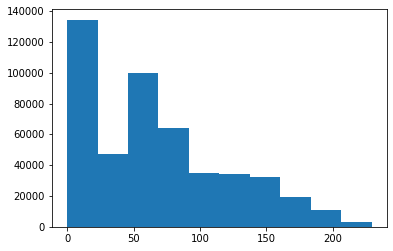

In [5]:
import matplotlib.pyplot as plt
plt.hist(mean_image.flatten())

In [ ]:
# [STAR] For training P-HNN model using Luna

import volume_manipulation_share as v
import SimpleITK as sitk

from torch import nn

from copy import deepcopy
import caffe
from pytorch_caffe import prototxt
from pytorch_caffe.caffenet import CaffeNet
from skimage.transform import resize
import sys
import torch
import numpy as np
#from prototxt import *
import nibabel as nib
import load_hed_snapshot_share as l
import torch.optim as optim


#net = l.load_hed_net('/media/dril/Windows/newrecon2/newrecon/deploy.prototxt', '/media/dril/Windows/newrecon2/newrecon/pytorch_models/fold0/pytorch_phnn.pth')

net = l.load_hed_net('/media/dril/Windows/newrecon2/newrecon/deploy.prototxt', 'phnn1.pt')


def init_normal(m):
    if type(m) == nn.Conv2d:
        nn.init.kaiming_normal_(m.weight)
    if type(m) == nn.ConvTranspose2d:
        nn.init.kaiming_normal_(m.weight)
    
#net.apply(init_normal)
#net.load_state_dict(torch.load('phnn.pt'))

optimizer = optim.Adam(net.parameters(), lr=0.001)
loss      = nn.BCELoss()

# mask    = '/media/dril/New Volume/LUNA/ORIG-SEG_GROUND/1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222365663678666836860.mhd'
# mask    = nib.load(mask)
# print(mask.shape)

# file_in = '/media/dril/New Volume/LUNA/ORIG-NII/1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222365663678666836860.nii.gz'
# volume  = nib.load(file_in)
# volume  = np.squeeze(volume.get_fdata())
# print(volume.shape)

mean_file = '/media/dril/Windows/p-hnn-master/caffe_model/train_colour_slice_list_0.lst_mean_image.npy'
mean_image = np.load(mean_file)

ct_windows = np.array([[600, 1200], [1040, 400], [225, 450]])
offset     = 1024
batch_size = 8

def preprocessing(vol_slice, mean_image):
    #print('vol_slice is ', vol_slice.shape, mean_image.shape)
    vol_slice = np.transpose(vol_slice, (2,0,1))
    vol_slice = resize(vol_slice, mean_image.shape, order=1, preserve_range=True)
    
    ret_vol_slice      = deepcopy(vol_slice)
    ret_vol_slice[0,:] = vol_slice[2,:]
    ret_vol_slice[2,:] = vol_slice[0,:]
    ret_vol_slice -= mean_image

    # ret_vol_slice /= 255
    return ret_vol_slice


def train_volume(net, optimizer, volume, mask, mean_image, ct_windows, offset, batch_size):
    #net.train()
    if isinstance(ct_windows, np.ndarray):
        # swap channels from RGB to BGR
        min_vals = ct_windows[:, 0]-ct_windows[:, 1]/2
        max_vals = ct_windows[:, 0]+ct_windows[:, 1]/2
    dims = volume.shape
    #print(dims, mask.shape, volume.shape)
    
    volume += offset
    volume[volume < 0] = 0
    #volume[volume > 2000]  = 2000
    #volume[volume < -2000] = -2000
    #volume = volume/1024.0
    #volume[volume < 0] = 0
    #print('VOLUME MAX ', np.max(volume.flatten()))
    
    #mask = np.zeros(dims)
    im_data = np.zeros((batch_size,) + (3, 400, 400))
    #print(im_data.shape)
    
    final_output = []
    
    print('Segmenting {:d} slices with batch size of {:d}'.format(dims[2], batch_size))
    for i in range(0, dims[2], batch_size):
        max_range = min(dims[2], i+batch_size)
        if max_range < i+batch_size:
            im_data = np.zeros((max_range-i,) + (3, 400, 400))
            #mask_data = mask[] 
        for j in range(i, max_range):
            #print( 'Slice {:d}'.format(j))
            if isinstance(ct_windows, np.ndarray):
                slice = v.makeSliceToColour(volume, j, min_vals, max_vals)
            else:
                slice = volume[:, :, j]
                slice = np.expand_dims(slice, axis=2)
                slice = np.tile(slice, (1, 1, 3))
            #slice = np.transpose(slice, (2,0,1))
            #transformed_image = slice
            transformed_image = preprocessing(slice, mean_image)
            #print(transformed_image.shape, j, i)
            im_data[j-i, :, :, :] = transformed_image
        
        #im_mask = np.zeros((max_range-i,) + (1, 400, 400))
        #for j in range(i, max_range):
        #    im_mask[] = resize(vol_slice, mean_image.shape, order=1, preserve_range=True)
        #    im_mask[]
        im_mask = mask[:, :, i:max_range]
        im_mask = np.transpose(im_mask, (2,1,0))
        
        im_mask = np.expand_dims(im_mask, 1)
        #im_mask = np.concatenate([im_mask, im_mask, im_mask], axis=1)
        
        #print(im_mask.shape, im_data.shape)
        
        im_mask = im_mask.astype(np.float32)
        im_mask = torch.from_numpy(im_mask)
        out1    = im_mask.cuda()
        
        #print("max and min are ", np.max(im_data.flatten()), np.min(im_data.flatten()))
        
        im = im_data.astype(np.float32)
        im = torch.from_numpy(im)
        im = im.cuda()
        
        optimizer.zero_grad()
        p       = net(im)
        result  = p['sigmoid-fuse'].data.cpu().numpy()
        
        total_loss = loss(p['sigmoid-dsn1'], out1) + loss(p['sigmoid-dsn2'], out1) + loss(p['sigmoid-dsn3'], out1) +  loss(p['sigmoid-dsn4'], out1) + loss(p['sigmoid-dsn5'], out1) + loss(p['sigmoid-fuse'], out1)
        if i %100 == 0:
            print(total_loss, result.shape)
        
        total_loss.backward()
        optimizer.step()
        
        for k in result:
            final_output.append(k)
        
    return im_data, im_mask, np.array(final_output)


trainids = np.load('/media/dril/New Volume/LUNA/TRAIN.npy')
valids   = np.load('/media/dril/New Volume/LUNA/VALIDATION.npy')

net.train()
for i in range(10000):
    #np.random.shuffle(trainids)
    temp = i*5%len(trainids)
    for t in trainids[temp:temp+5]:
        #print(t)
        x1  = nib.load('/media/dril/New Volume/LUNA/ORIG-NII/'+t+'.nii.gz')
        x  = np.squeeze(x1.get_fdata())
        #print(np.max(x.flatten()), np.min(x.flatten()), x.shape)
        
        #y = nib.load('/media/dril/New Volume/LUNA/ORIG-SEG-GROUND/'+t+'.mhd').astype('uint8')
        y = sitk.GetArrayFromImage(sitk.ReadImage('/media/dril/New Volume/LUNA/ORIG-SEG-GROUND/'+t+'.mhd')).astype('uint8')
        
        y[y == 3] = 1
        y[y == 4] = 1
        y[y == 5] = 0
        
        #x = np.transpose(x, (2,0,1))
        y  = np.transpose(y, (2,1,0))
        y1 = np.zeros([400, 400, y.shape[2]])
        for k in range(y.shape[2]):
            y1[:, :, k] = resize(y[:, :, k].astype('float32'), [400, 400], order=0, preserve_range=True)
        #print('y shape is ', y.shape)
        #y1 = np.zeros(y.shape)
        
        #x = np.expand_dims(x, axis=-1)
        #y = np.expand_dims(y, axis=-1)
        a, b, c = train_volume(net, optimizer, x, y1, mean_image, ct_windows, offset, 4)
        c = c[:, 0, :, :]
        c = np.transpose(c, (2,1,0))
       # print(c.shape)
        print(temp, len(trainids), c.shape, np.max(c.flatten()), np.min(c.flatten()))
    
    if i%5 == 0:
        print('Saving File')
        c[c > 0.5] = 1
        c[c < 0.5] = 0
        #c = c.astype('uint8')
        
        c1 = np.zeros([512, 512, c.shape[2]])
        for k in range(c.shape[2]):
            c1[:, :, k] = resize(c[:, :, k], [512, 512], order=1, preserve_range=True)
        c1 = c1.astype('uint8')
        result = nib.Nifti1Image(c1, x1.affine, x1.header)
        nib.save(result, 'test.nii.gz')
        #print(a.shape, b.shape)
    
    torch.save(net.state_dict(), "phnn1.pt")
        
    #model.save('/media/dril/New Volume/LUNA/models/unet-cnn-4-class.h5')
    
    
    
#im1 = train_volume(net, volume, mask, mean_image, ct_windows, offset, 4)
#print(im1.shape)

create conv1_1              (   3 x  400 x  400) -> (  64 x  468 x  468)
create relu1_1              (  64 x  468 x  468) -> (  64 x  468 x  468)
create conv1_2              (  64 x  468 x  468) -> (  64 x  468 x  468)
create relu1_2              (  64 x  468 x  468) -> (  64 x  468 x  468)
create batch-norm1          (  64 x  468 x  468) -> (  64 x  468 x  468)
create pool1                (  64 x  468 x  468) -> (  64 x  234 x  234)
create conv2_1              (  64 x  234 x  234) -> ( 128 x  234 x  234)
create relu2_1              ( 128 x  234 x  234) -> ( 128 x  234 x  234)
create conv2_2              ( 128 x  234 x  234) -> ( 128 x  234 x  234)
create relu2_2              ( 128 x  234 x  234) -> ( 128 x  234 x  234)
create batch-norm2          ( 128 x  234 x  234) -> ( 128 x  234 x  234)
create pool2                ( 128 x  234 x  234) -> ( 128 x  117 x  117)
create conv3_1              ( 128 x  117 x  117) -> ( 256 x  117 x  117)
create relu3_1              ( 256 x  117 x  117) ->

tensor(2.8074, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(2.1538, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.6820, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.4534, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
10 518 (400, 400, 588) 1.0 5.3453094e-16
Segmenting 140 slices with batch size of 4
tensor(0.2978, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.6408, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
10 518 (400, 400, 140) 0.9995565 1.1169302e-08
Segmenting 280 slices with batch size of 4
tensor(0.5002, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.7719, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.2530, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
10 518 (400, 400, 280) 1.0 1.1420844e-06
Segmenting 157 slices with batch size of 4
tensor(0.2511, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.555

35 518 (400, 400, 117) 0.99999654 8.727369e-11
Segmenting 139 slices with batch size of 4
tensor(0.1643, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.5320, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
40 518 (400, 400, 139) 0.99999976 7.3517576e-08
Segmenting 471 slices with batch size of 4
tensor(0.1819, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(2.0855, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.5899, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.2692, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8429, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
40 518 (400, 400, 471) 1.0 3.7219696e-11
Segmenting 477 slices with batch size of 4
tensor(0.1500, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9574, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.8428, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tenso

tensor(0.1349, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9972, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.9522, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.5666, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1770, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6572, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
65 518 (400, 400, 545) 1.0 4.9569523e-13
Segmenting 229 slices with batch size of 4
tensor(0.1803, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(2.1508, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0625, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
65 518 (400, 400, 229) 1.0 1.5406712e-12
Segmenting 265 slices with batch size of 4
tensor(0.2379, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1021, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8562, device='cuda:0

tensor(1.3843, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.3691, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1104, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.2222, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
90 518 (400, 400, 509) 1.0 2.4373462e-10
Segmenting 197 slices with batch size of 4
tensor(0.1682, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(2.1732, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
90 518 (400, 400, 197) 1.0 2.7482475e-15
Segmenting 140 slices with batch size of 4
tensor(0.2127, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.8701, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
90 518 (400, 400, 140) 0.9999435 2.1553271e-07
Segmenting 131 slices with batch size of 4
tensor(0.2178, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0549, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
95 518 (400,

Segmenting 141 slices with batch size of 4
tensor(0.2971, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.6518, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
120 518 (400, 400, 141) 1.0 2.1705097e-10
Segmenting 208 slices with batch size of 4
tensor(0.2017, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(2.1951, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.2807, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
120 518 (400, 400, 208) 1.0 2.6541568e-16
Segmenting 128 slices with batch size of 4
tensor(0.2766, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0684, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
120 518 (400, 400, 128) 0.9994037 6.8608536e-13
Segmenting 326 slices with batch size of 4
tensor(0.2772, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.5512, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.6240, device='cuda:0', grad_fn

tensor(1.6388, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1906, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
145 518 (400, 400, 490) 1.0 4.0347208e-27
Segmenting 326 slices with batch size of 4
tensor(0.1344, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(3.5169, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.6871, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4652, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
145 518 (400, 400, 326) 0.9999999 3.5270682e-16
Segmenting 133 slices with batch size of 4
tensor(0.1753, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.5378, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
145 518 (400, 400, 133) 0.9999999 2.7849465e-12
Segmenting 261 slices with batch size of 4
tensor(0.2157, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.5159, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
ten

170 518 (400, 400, 115) 1.0 1.0156749e-21
Segmenting 260 slices with batch size of 4
tensor(0.2142, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.5398, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1501, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
170 518 (400, 400, 260) 1.0 1.5909713e-21
Segmenting 139 slices with batch size of 4
tensor(0.1445, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.7085, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
170 518 (400, 400, 139) 0.9999995 4.0980063e-28
Segmenting 416 slices with batch size of 4
tensor(0.2373, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.1162, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(2.4320, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.2814, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.1461, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
170 518 (

Segmenting 270 slices with batch size of 4
tensor(0.1365, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.7475, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.2998, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
195 518 (400, 400, 270) 1.0 1.8099381e-14
Segmenting 261 slices with batch size of 4
tensor(0.2927, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.8029, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.3057, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
195 518 (400, 400, 261) 0.99997973 1.7294944e-14
Segmenting 535 slices with batch size of 4
tensor(0.1917, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.7667, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.5892, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.3563, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1081, device='cuda:0', grad_fn=<AddBackwa

tensor(0.2095, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.4972, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.5562, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1246, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7153, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
220 518 (400, 400, 461) 0.9999995 9.1932595e-17
Segmenting 245 slices with batch size of 4
tensor(0.1751, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.8233, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.3663, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
220 518 (400, 400, 245) 1.0 2.2089172e-17
Segmenting 413 slices with batch size of 4
tensor(0.1730, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.8615, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.3843, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1565, device

245 518 (400, 400, 110) 0.9999684 9.472216e-16
Segmenting 362 slices with batch size of 4
tensor(0.2109, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.6989, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.4037, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1440, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
245 518 (400, 400, 362) 0.99999714 2.2199392e-11
Segmenting 463 slices with batch size of 4
tensor(0.3308, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.8060, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.3802, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.4171, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9093, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
245 518 (400, 400, 463) 0.99999964 1.3324969e-14
Segmenting 249 slices with batch size of 4
tensor(1.0015, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 4

Segmenting 269 slices with batch size of 4
tensor(0.1512, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(2.3423, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.3419, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
270 518 (400, 400, 269) 1.0 5.058613e-14
Segmenting 238 slices with batch size of 4
tensor(0.4139, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(2.2037, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8021, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
270 518 (400, 400, 238) 0.99999905 4.3869168e-14
Segmenting 529 slices with batch size of 4
tensor(0.2159, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.2181, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(2.6177, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.6649, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.2370, device='cuda:0', grad_fn=<AddBackwar

tensor(1.6834, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.3053, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9431, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
295 518 (400, 400, 558) 1.0 2.9360517e-20
Segmenting 490 slices with batch size of 4
tensor(0.2460, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.4699, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1292, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0593, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6775, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
295 518 (400, 400, 490) 1.0 3.1655263e-18
Segmenting 481 slices with batch size of 4
tensor(0.1727, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.8375, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.2651, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1263, device='cuda

Segmenting 125 slices with batch size of 4
tensor(0.1359, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.4818, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
320 518 (400, 400, 125) 0.99999297 8.32473e-18
Segmenting 220 slices with batch size of 4
tensor(0.1310, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.6490, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5326, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
320 518 (400, 400, 220) 1.0 2.1189188e-19
Segmenting 180 slices with batch size of 4
tensor(0.1696, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.4488, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
320 518 (400, 400, 180) 1.0 1.1248284e-14
Segmenting 241 slices with batch size of 4
tensor(0.1866, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1101, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5753, device='cuda:0', grad_fn=

345 518 (400, 400, 219) 1.0 5.90623e-13
Segmenting 273 slices with batch size of 4
tensor(0.1540, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9592, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6942, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
345 518 (400, 400, 273) 1.0 5.042198e-14
Segmenting 259 slices with batch size of 4
tensor(0.1299, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(2.1266, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.3346, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
350 518 (400, 400, 259) 1.0 1.1782149e-17
Segmenting 128 slices with batch size of 4
tensor(0.1320, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9500, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
350 518 (400, 400, 128) 0.9999999 3.5186982e-11
Segmenting 130 slices with batch size of 4
tensor(0.1341, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)


Segmenting 238 slices with batch size of 4
tensor(0.1958, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.3805, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6653, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
375 518 (400, 400, 238) 0.9999999 7.090788e-17
Segmenting 164 slices with batch size of 4
tensor(0.1381, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(2.1758, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
375 518 (400, 400, 164) 1.0 8.156224e-23
Segmenting 123 slices with batch size of 4
tensor(0.3265, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1990, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
375 518 (400, 400, 123) 0.9999534 8.4559915e-17
Segmenting 348 slices with batch size of 4
tensor(0.2064, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4485, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.4575, device='cuda:0', gra

Segmenting 127 slices with batch size of 4
tensor(0.1532, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9118, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
395 518 (400, 400, 127) 0.99999785 1.4975295e-14
Segmenting 171 slices with batch size of 4
tensor(0.1421, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.8205, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
400 518 (400, 400, 171) 0.9999993 2.562728e-19
Segmenting 122 slices with batch size of 4
tensor(0.2932, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.7537, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
400 518 (400, 400, 122) 1.0 6.0152585e-24
Segmenting 273 slices with batch size of 4
tensor(0.1763, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(2.0020, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.2927, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
400 518 (400, 400, 273) 1.0 4.027

tensor(1.1591, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.1879, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
425 518 (400, 400, 529) 1.0 5.8997006e-24
Segmenting 133 slices with batch size of 4
tensor(0.2082, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8961, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
425 518 (400, 400, 133) 0.9999937 1.9387714e-18
Segmenting 249 slices with batch size of 4
tensor(0.1522, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.7275, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7952, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
425 518 (400, 400, 249) 1.0 2.1505315e-18
Saving File
Segmenting 170 slices with batch size of 4
tensor(0.1267, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1217, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
430 518 (400, 400, 170) 0.99999845 3.3864152e-16
Segmenting 237 slices

tensor(0.1848, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.4547, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8186, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
455 518 (400, 400, 240) 1.0 6.853777e-17
Segmenting 265 slices with batch size of 4
tensor(0.1933, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.8975, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.2518, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
455 518 (400, 400, 265) 0.9999994 1.2531347e-20
Segmenting 125 slices with batch size of 4
tensor(0.1800, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.3995, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
455 518 (400, 400, 125) 1.0 1.5455397e-19
Segmenting 219 slices with batch size of 4
tensor(0.1842, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.7767, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7

480 518 (400, 400, 465) 1.0 2.1011632e-18
Segmenting 182 slices with batch size of 4
tensor(0.1880, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.4717, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
480 518 (400, 400, 182) 0.9999999 5.2281795e-17
Segmenting 280 slices with batch size of 4
tensor(0.1849, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.2707, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9220, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
480 518 (400, 400, 280) 0.99999857 1.0190849e-16
Segmenting 493 slices with batch size of 4
tensor(0.1626, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.1255, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.5982, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.3992, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9110, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
48

tensor(1.2986, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9596, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
505 518 (400, 400, 260) 0.9999999 2.4077275e-18
Segmenting 278 slices with batch size of 4
tensor(0.1944, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.3229, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6498, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
505 518 (400, 400, 278) 1.0 1.9175387e-16
Segmenting 154 slices with batch size of 4
tensor(0.1812, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.5365, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
505 518 (400, 400, 154) 0.9999993 3.2042824e-18
Segmenting 231 slices with batch size of 4
tensor(0.3622, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.7669, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9259, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
505

tensor(2.3830, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(2.0337, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.5585, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.3631, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1678, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.2571, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
12 518 (400, 400, 730) 1.0 5.066091e-31
Segmenting 275 slices with batch size of 4
tensor(0.1987, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.4191, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8446, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
17 518 (400, 400, 275) 0.9999776 2.2870303e-17
Segmenting 125 slices with batch size of 4
tensor(0.1619, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0139, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
17 518 (400, 400, 125) 1

tensor(0.1603, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.6828, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.4439, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
42 518 (400, 400, 250) 1.0 1.5681238e-20
Segmenting 232 slices with batch size of 4
tensor(0.1930, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.2895, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4898, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
42 518 (400, 400, 232) 0.99999964 6.8891425e-23
Segmenting 244 slices with batch size of 4
tensor(0.1206, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.5781, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1908, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
42 518 (400, 400, 244) 1.0 1.0254543e-36
Segmenting 369 slices with batch size of 4
tensor(0.4783, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.69

67 518 (400, 400, 133) 1.0 3.5877056e-20
Segmenting 133 slices with batch size of 4
tensor(0.1202, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8691, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
67 518 (400, 400, 133) 1.0 3.09248e-18
Segmenting 120 slices with batch size of 4
tensor(0.1119, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7919, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
67 518 (400, 400, 120) 1.0 2.9127048e-19
Segmenting 429 slices with batch size of 4
tensor(0.1996, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(2.4595, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(2.1224, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.7925, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7506, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
72 518 (400, 400, 429) 1.0 0.0
Segmenting 392 slices with batch size of 4
tensor(0.2168, devi

Segmenting 172 slices with batch size of 4
tensor(0.1883, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.7636, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
97 518 (400, 400, 172) 0.99999976 3.358741e-24
Segmenting 125 slices with batch size of 4
tensor(0.1611, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9588, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
97 518 (400, 400, 125) 1.0 2.003583e-18
Segmenting 144 slices with batch size of 4
tensor(0.1164, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.3487, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
97 518 (400, 400, 144) 0.99999595 1.2162714e-14
Segmenting 132 slices with batch size of 4
tensor(0.4750, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1698, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
97 518 (400, 400, 132) 1.0 1.557805e-18
Segmenting 179 slices with batch size of 4
tensor(0.1398, device='cud

122 518 (400, 400, 256) 0.9999999 3.3792037e-22
Segmenting 198 slices with batch size of 4
tensor(0.3100, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.7738, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
122 518 (400, 400, 198) 0.99999404 7.220564e-29
Segmenting 232 slices with batch size of 4
tensor(0.2346, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.4934, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4118, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
122 518 (400, 400, 232) 0.99973875 8.3227133e-22
Segmenting 484 slices with batch size of 4
tensor(0.1269, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.7930, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.4588, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1546, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6126, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 4

tensor(1.2210, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9181, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.1932, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
147 518 (400, 400, 519) 1.0 7.3646605e-22
Segmenting 513 slices with batch size of 4
tensor(0.1698, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1196, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.6324, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.2748, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9498, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.1872, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
147 518 (400, 400, 513) 1.0 4.4757936e-23
Segmenting 297 slices with batch size of 4
tensor(0.1699, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.5400, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0595, device='cuda

tensor(0.7935, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
172 518 (400, 400, 321) 1.0 6.774007e-39
Segmenting 413 slices with batch size of 4
tensor(0.1291, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.4297, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.2811, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9367, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.1507, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
172 518 (400, 400, 413) 0.99999976 1.1023594e-25
Segmenting 139 slices with batch size of 4
tensor(0.1106, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.2941, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
177 518 (400, 400, 139) 1.0 2.396607e-30
Segmenting 133 slices with batch size of 4
tensor(0.1835, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0374, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
177 518 (4

tensor(0.9953, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
197 518 (400, 400, 261) 1.0 3.5062653e-29
Segmenting 128 slices with batch size of 4
tensor(0.1891, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1662, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
197 518 (400, 400, 128) 0.99999607 1.8211191e-26
Segmenting 187 slices with batch size of 4
tensor(0.2313, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.7239, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
202 518 (400, 400, 187) 1.0 1.551841e-22
Segmenting 290 slices with batch size of 4
tensor(0.1952, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.4408, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9021, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
202 518 (400, 400, 290) 0.9999999 9.220234e-24
Segmenting 285 slices with batch size of 4
tensor(0.1657, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 40

tensor(1.6854, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.2296, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
222 518 (400, 400, 347) 1.0 7.892572e-22
Segmenting 426 slices with batch size of 4
tensor(0.1236, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.6730, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.4982, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9718, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3470, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
222 518 (400, 400, 426) 1.0 1.398861e-24
Segmenting 368 slices with batch size of 4
tensor(0.1508, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.4049, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.3899, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8644, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
227 518 (400, 400, 368) 1.0 2

247 518 (400, 400, 263) 1.0 3.5100273e-28
Segmenting 557 slices with batch size of 4
tensor(0.2045, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.6447, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1474, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0420, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8178, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3477, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
252 518 (400, 400, 557) 1.0 3.176685e-37
Segmenting 172 slices with batch size of 4
tensor(0.1817, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.5828, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
252 518 (400, 400, 172) 0.99999964 1.4636296e-32
Segmenting 251 slices with batch size of 4
tensor(0.1872, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.6681, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.

tensor(0.7230, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
272 518 (400, 400, 481) 1.0 6.0896557e-29
Segmenting 177 slices with batch size of 4
tensor(0.1957, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.3557, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
272 518 (400, 400, 177) 1.0 3.5704048e-29
Segmenting 145 slices with batch size of 4
tensor(0.1795, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.3680, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
277 518 (400, 400, 145) 0.99999964 1.9167904e-26
Segmenting 197 slices with batch size of 4
tensor(0.1688, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1152, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
277 518 (400, 400, 197) 1.0 6.688287e-27
Segmenting 244 slices with batch size of 4
tensor(0.1551, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.6474, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 40

tensor(0.8418, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(2.2576, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.3363, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1005, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0182, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.1728, device='cuda:0', grad_fn=<AddBackward0>) (2, 1, 400, 400)
297 518 (400, 400, 602) 1.0 8.499526e-31
Segmenting 244 slices with batch size of 4
tensor(0.2029, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.2722, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9109, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
297 518 (400, 400, 244) 0.99999845 3.7439513e-36
Segmenting 484 slices with batch size of 4
tensor(0.2191, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.9297, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.5431, device

tensor(1.4676, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
327 518 (400, 400, 199) 1.0 2.2358634e-28
Segmenting 145 slices with batch size of 4
tensor(0.1596, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9260, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
327 518 (400, 400, 145) 1.0 1.606183e-32
Segmenting 131 slices with batch size of 4
tensor(0.1358, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8420, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
327 518 (400, 400, 131) 1.0 2.8922878e-34
Segmenting 133 slices with batch size of 4
tensor(0.1525, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7448, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
327 518 (400, 400, 133) 1.0 1.1636025e-28
Segmenting 107 slices with batch size of 4
tensor(0.2898, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.2173, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
327 

tensor(0.1160, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1267, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8850, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
352 518 (400, 400, 259) 0.9999999 1.5901945e-29
Segmenting 235 slices with batch size of 4
tensor(0.1801, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.2021, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4537, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
352 518 (400, 400, 235) 1.0 2.0633995e-28
Segmenting 133 slices with batch size of 4
tensor(0.1187, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8339, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
357 518 (400, 400, 133) 1.0 1.044981e-30
Segmenting 215 slices with batch size of 4
tensor(0.1463, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.4594, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5

tensor(0.7182, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.1379, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
377 518 (400, 400, 423) 1.0 9.887721e-31
Segmenting 559 slices with batch size of 4
tensor(0.1563, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4361, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(2.2872, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.5612, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.3462, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9736, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
377 518 (400, 400, 559) 1.0 6.085637e-37
Segmenting 350 slices with batch size of 4
tensor(0.2011, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.6274, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.2860, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5309, device='cuda:0

tensor(0.1219, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7275, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
402 518 (400, 400, 116) 1.0 2.6071669e-36
Segmenting 133 slices with batch size of 4
tensor(0.1236, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8461, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
407 518 (400, 400, 133) 1.0 1.2830967e-35
Segmenting 116 slices with batch size of 4
tensor(0.1291, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7965, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
407 518 (400, 400, 116) 1.0 0.0
Segmenting 305 slices with batch size of 4
tensor(0.2050, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1941, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9259, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.1166, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
407 518 (400, 400, 305) 1

432 518 (400, 400, 481) 1.0 7.6524146e-33
Segmenting 157 slices with batch size of 4
tensor(0.1416, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.6857, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
432 518 (400, 400, 157) 1.0 0.0
Segmenting 257 slices with batch size of 4
tensor(0.1327, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1046, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7255, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
432 518 (400, 400, 257) 0.999995 7.158708e-39
Segmenting 132 slices with batch size of 4
tensor(0.1016, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.2452, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
432 518 (400, 400, 132) 1.0 0.0
Saving File
Segmenting 253 slices with batch size of 4
tensor(0.1575, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(2.0603, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(

457 518 (400, 400, 442) 1.0 4.058943e-34
Saving File
Segmenting 149 slices with batch size of 4
tensor(0.2293, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9287, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
462 518 (400, 400, 149) 1.0 1.133618e-33
Segmenting 133 slices with batch size of 4
tensor(0.1720, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7316, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
462 518 (400, 400, 133) 0.99999964 9.663231e-33
Segmenting 137 slices with batch size of 4
tensor(0.1103, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.3307, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
462 518 (400, 400, 137) 1.0 0.0
Segmenting 127 slices with batch size of 4
tensor(0.1538, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7860, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
462 518 (400, 400, 127) 1.0 6.263088e-33
Segmenting 487 slices with ba

tensor(0.7035, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.5423, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8370, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
487 518 (400, 400, 285) 1.0 3.9404306e-34
Segmenting 583 slices with batch size of 4
tensor(0.1929, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.6758, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.3079, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.2094, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0572, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8356, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
487 518 (400, 400, 583) 1.0 7.468811e-35
Segmenting 375 slices with batch size of 4
tensor(0.2435, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.4323, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.4807, device='cuda:

tensor(0.9868, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
512 518 (400, 400, 137) 1.0 0.0
Segmenting 567 slices with batch size of 4
tensor(0.1108, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.4948, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.2368, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1585, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9697, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6656, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
512 518 (400, 400, 567) 1.0 0.0
Segmenting 139 slices with batch size of 4
tensor(0.1357, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8764, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
512 518 (400, 400, 139) 1.0 0.0
Segmenting 262 slices with batch size of 4
tensor(0.2087, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.7208, device='cuda:0', grad_fn=<AddB

Segmenting 133 slices with batch size of 4
tensor(0.4451, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9686, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
24 518 (400, 400, 133) 0.99987864 2.2474397e-30
Segmenting 194 slices with batch size of 4
tensor(0.1481, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.5521, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
24 518 (400, 400, 194) 0.99999964 7.608886e-36
Segmenting 276 slices with batch size of 4
tensor(0.1537, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.3544, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1770, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
24 518 (400, 400, 276) 0.9999999 1.8943977e-37
Segmenting 250 slices with batch size of 4
tensor(0.1175, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(2.1261, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.3058, device='cuda:0

49 518 (400, 400, 465) 1.0 0.0
Segmenting 474 slices with batch size of 4
tensor(0.1473, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0685, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.2600, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8701, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4995, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
54 518 (400, 400, 474) 1.0 0.0
Segmenting 267 slices with batch size of 4
tensor(0.1069, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.4503, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.2242, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
54 518 (400, 400, 267) 1.0 0.0
Segmenting 204 slices with batch size of 4
tensor(0.1829, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.6423, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.2055, device='cuda:0', grad_fn=<AddBack

tensor(0.9701, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
79 518 (400, 400, 124) 1.0 0.0
Segmenting 140 slices with batch size of 4
tensor(0.1378, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1238, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
79 518 (400, 400, 140) 1.0 0.0
Segmenting 300 slices with batch size of 4
tensor(0.2289, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.3439, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9614, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
79 518 (400, 400, 300) 0.9999999 0.0
Segmenting 157 slices with batch size of 4
tensor(0.1199, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0595, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
84 518 (400, 400, 157) 1.0 0.0
Segmenting 733 slices with batch size of 4
tensor(0.1625, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.1207, device='cuda:0', grad_fn=<

109 518 (400, 400, 133) 1.0 2.2065253e-32
Segmenting 636 slices with batch size of 4
tensor(0.2948, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1578, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.4637, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.3620, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0485, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9249, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.2734, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
109 518 (400, 400, 636) 1.0 0.0
Segmenting 605 slices with batch size of 4
tensor(0.4563, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.2133, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.2404, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1623, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9851, device='cuda:0', grad_

tensor(1.4038, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1092, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6518, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
134 518 (400, 400, 477) 1.0 0.0
Segmenting 283 slices with batch size of 4
tensor(0.1467, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.2807, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.2022, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
134 518 (400, 400, 283) 0.99999976 0.0
Segmenting 248 slices with batch size of 4
tensor(0.2105, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.5152, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9106, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
134 518 (400, 400, 248) 1.0 0.0
Segmenting 123 slices with batch size of 4
tensor(0.2745, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8121, device='cuda:0', grad_f

Segmenting 273 slices with batch size of 4
tensor(0.1311, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.2714, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9990, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
164 518 (400, 400, 273) 1.0 0.0
Segmenting 245 slices with batch size of 4
tensor(0.1353, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.2992, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8552, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
164 518 (400, 400, 245) 1.0 0.0
Segmenting 220 slices with batch size of 4
tensor(0.1430, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8172, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.1354, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
164 518 (400, 400, 220) 0.9999999 0.0
Segmenting 238 slices with batch size of 4
tensor(0.1419, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 4

Segmenting 449 slices with batch size of 4
tensor(0.1256, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.4542, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.2061, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9362, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5117, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
189 518 (400, 400, 449) 1.0 0.0
Segmenting 127 slices with batch size of 4
tensor(0.1006, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0551, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
189 518 (400, 400, 127) 1.0 0.0
Segmenting 292 slices with batch size of 4
tensor(0.1272, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.4978, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1823, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
189 518 (400, 400, 292) 1.0 0.0
Segmenting 280 slices with batch size of 4
te

tensor(1.3876, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0494, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7698, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.2003, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
214 518 (400, 400, 506) 1.0 0.0
Segmenting 519 slices with batch size of 4
tensor(0.1277, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0026, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1389, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9828, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8042, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.1757, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
214 518 (400, 400, 519) 1.0 0.0
Segmenting 120 slices with batch size of 4
tensor(0.1666, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9639, device='cuda:0', grad_fn=<AddBac

tensor(1.2538, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
239 518 (400, 400, 278) 1.0 0.0
Segmenting 238 slices with batch size of 4
tensor(0.1459, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9711, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6784, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
239 518 (400, 400, 238) 1.0 0.0
Segmenting 120 slices with batch size of 4
tensor(0.2853, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8513, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
239 518 (400, 400, 120) 0.99999475 0.0
Saving File
Segmenting 557 slices with batch size of 4
tensor(0.2546, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7122, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.5180, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.2387, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9022, device='cud

264 518 (400, 400, 161) 1.0 0.0
Segmenting 123 slices with batch size of 4
tensor(0.6781, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0411, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
264 518 (400, 400, 123) 0.99999976 1.0039328e-38
Saving File
Segmenting 161 slices with batch size of 4
tensor(0.2665, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0080, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
269 518 (400, 400, 161) 0.9999999 5.254902e-36
Segmenting 301 slices with batch size of 4
tensor(0.2041, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.3867, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9286, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.1851, device='cuda:0', grad_fn=<AddBackward0>) (1, 1, 400, 400)
269 518 (400, 400, 301) 0.9999999 0.0
Segmenting 764 slices with batch size of 4
tensor(0.1299, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400

289 518 (400, 400, 240) 1.0 0.0
Segmenting 264 slices with batch size of 4
tensor(0.1655, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.2656, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7989, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
289 518 (400, 400, 264) 1.0 0.0
Saving File
Segmenting 513 slices with batch size of 4
tensor(0.1539, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8356, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9857, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9847, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8613, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.1335, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
294 518 (400, 400, 513) 1.0 0.0
Segmenting 141 slices with batch size of 4
tensor(0.1687, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.2092, device='cuda:0', g

tensor(0.7671, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3481, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
314 518 (400, 400, 545) 1.0 0.0
Segmenting 191 slices with batch size of 4
tensor(0.1601, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.4480, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
314 518 (400, 400, 191) 1.0 0.0
Saving File
Segmenting 154 slices with batch size of 4
tensor(0.1305, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.4263, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
319 518 (400, 400, 154) 1.0 0.0
Segmenting 135 slices with batch size of 4
tensor(0.2070, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6759, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
319 518 (400, 400, 135) 1.0 1.2465647e-35
Segmenting 190 slices with batch size of 4
tensor(0.1366, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.2380, device

tensor(1.0139, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
344 518 (400, 400, 271) 1.0 0.0
Segmenting 471 slices with batch size of 4
tensor(0.1258, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9754, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0273, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7990, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4969, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
344 518 (400, 400, 471) 1.0 0.0
Segmenting 219 slices with batch size of 4
tensor(0.3974, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7788, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.2087, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
344 518 (400, 400, 219) 0.9999999 0.0
Segmenting 273 slices with batch size of 4
tensor(0.1044, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8112, device='cuda:0', grad_fn

Segmenting 251 slices with batch size of 4
tensor(0.1839, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9702, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6102, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
369 518 (400, 400, 251) 1.0 0.0
Segmenting 149 slices with batch size of 4
tensor(0.1011, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9732, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
374 518 (400, 400, 149) 1.0 0.0
Segmenting 238 slices with batch size of 4
tensor(0.1544, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0980, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5173, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
374 518 (400, 400, 238) 1.0 0.0
Segmenting 164 slices with batch size of 4
tensor(0.1042, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.8412, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
37

tensor(0.2185, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8900, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.2787, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
394 518 (400, 400, 223) 1.0 0.0
Segmenting 127 slices with batch size of 4
tensor(0.1178, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7413, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
399 518 (400, 400, 127) 1.0 0.0
Segmenting 171 slices with batch size of 4
tensor(0.1127, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.5810, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
399 518 (400, 400, 171) 1.0 0.0
Segmenting 122 slices with batch size of 4
tensor(0.1577, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.3826, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
399 518 (400, 400, 122) 1.0 0.0
Segmenting 273 slices with batch size of 4
tensor(0.1335, device='cuda:0', grad_fn=<Ad

tensor(0.9706, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.1599, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
424 518 (400, 400, 529) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.1809, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7489, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
424 518 (400, 400, 133) 0.9999999 0.0
Segmenting 249 slices with batch size of 4
tensor(0.0962, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.6789, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7457, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
429 518 (400, 400, 249) 1.0 0.0
Segmenting 170 slices with batch size of 4
tensor(0.0967, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9007, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
429 518 (400, 400, 170) 1.0 0.0
Segmenting 237 slices with batch size of 4
tensor(0.1026, device='cuda:0', grad_

tensor(1.7068, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0637, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
454 518 (400, 400, 265) 1.0 0.0
Segmenting 125 slices with batch size of 4
tensor(0.1151, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1142, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
454 518 (400, 400, 125) 1.0 0.0
Segmenting 219 slices with batch size of 4
tensor(0.1281, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.4265, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5973, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
454 518 (400, 400, 219) 1.0 0.0
Segmenting 245 slices with batch size of 4
tensor(0.1173, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.2441, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9103, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
459 518 (400, 400, 245) 1.0 0.0
Segmenting 13

tensor(1.3274, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1765, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7299, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
484 518 (400, 400, 493) 1.0 0.0
Segmenting 265 slices with batch size of 4
tensor(0.1315, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8838, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6728, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
484 518 (400, 400, 265) 1.0 0.0
Segmenting 131 slices with batch size of 4
tensor(0.0923, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8528, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
484 518 (400, 400, 131) 1.0 0.0
Segmenting 141 slices with batch size of 4
tensor(0.1753, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1829, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
484 518 (400, 400, 141) 1.0 0.0
Segmenting 22

Segmenting 109 slices with batch size of 4
tensor(0.2777, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.2428, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
509 518 (400, 400, 109) 1.0 0.0
Segmenting 130 slices with batch size of 4
tensor(0.1611, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7865, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
509 518 (400, 400, 130) 1.0 0.0
Segmenting 452 slices with batch size of 4
tensor(0.3582, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1558, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0782, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8869, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5436, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
509 518 (400, 400, 452) 1.0 0.0
Segmenting 119 slices with batch size of 4
tensor(0.1320, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
te

tensor(0.1106, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9979, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
16 518 (400, 400, 147) 1.0 0.0
Segmenting 124 slices with batch size of 4
tensor(1.1095, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9677, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
16 518 (400, 400, 124) 0.9999999 0.0
Segmenting 295 slices with batch size of 4
tensor(0.1968, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1914, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0378, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
21 518 (400, 400, 295) 1.0 0.0
Segmenting 245 slices with batch size of 4
tensor(0.1024, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.3213, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7687, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
21 518 (400, 400, 245) 1.0 0.0
Segmenting 

tensor(1.0369, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
46 518 (400, 400, 290) 1.0 0.0
Segmenting 127 slices with batch size of 4
tensor(0.1567, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8453, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
46 518 (400, 400, 127) 1.0 0.0
Segmenting 127 slices with batch size of 4
tensor(0.0942, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.2527, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
46 518 (400, 400, 127) 0.9999999 0.0
Segmenting 151 slices with batch size of 4
tensor(0.1047, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9505, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
46 518 (400, 400, 151) 1.0 0.0
Saving File
Segmenting 123 slices with batch size of 4
tensor(0.1011, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5436, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
51 518 (400, 400, 123) 1.0 0.

71 518 (400, 400, 141) 1.0 0.0
Saving File
Segmenting 404 slices with batch size of 4
tensor(0.1672, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.2429, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8938, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6061, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.1309, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
76 518 (400, 400, 404) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.1113, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7275, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
76 518 (400, 400, 133) 1.0 0.0
Segmenting 246 slices with batch size of 4
tensor(0.1283, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0164, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3170, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
76 518 (400, 400, 246) 0.9999999 0.0

tensor(0.8181, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
101 518 (400, 400, 477) 1.0 0.0
Segmenting 139 slices with batch size of 4
tensor(0.1145, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9721, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
101 518 (400, 400, 139) 1.0 0.0
Segmenting 193 slices with batch size of 4
tensor(0.1166, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1827, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
106 518 (400, 400, 193) 1.0 0.0
Segmenting 196 slices with batch size of 4
tensor(0.1125, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.5519, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
106 518 (400, 400, 196) 0.9999932 0.0
Segmenting 225 slices with batch size of 4
tensor(0.1429, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.2232, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5650, device='cuda:0', grad_

tensor(0.1261, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.6433, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9790, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8526, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.1919, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
131 518 (400, 400, 436) 1.0 0.0
Segmenting 246 slices with batch size of 4
tensor(0.1420, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9410, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5392, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
131 518 (400, 400, 246) 1.0 0.0
Segmenting 130 slices with batch size of 4
tensor(0.1333, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8498, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
131 518 (400, 400, 130) 1.0 0.0
Segmenting 144 slices with batch size of 4
tensor(0.1137, device='cuda:0', grad_fn=<AddB

156 518 (400, 400, 158) 1.0 0.0
Segmenting 250 slices with batch size of 4
tensor(0.2034, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(2.1699, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0652, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
156 518 (400, 400, 250) 1.0 0.0
Segmenting 423 slices with batch size of 4
tensor(0.1859, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8518, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(2.0383, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.4287, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3248, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
156 518 (400, 400, 423) 1.0 0.0
Segmenting 262 slices with batch size of 4
tensor(0.6429, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.6951, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1210, device='cuda:0', grad_fn=<AddB

181 518 (400, 400, 312) 1.0 0.0
Segmenting 449 slices with batch size of 4
tensor(0.1505, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.3522, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1312, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8900, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6220, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
181 518 (400, 400, 449) 1.0 0.0
Segmenting 240 slices with batch size of 4
tensor(0.1201, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.6106, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1425, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
186 518 (400, 400, 240) 1.0 0.0
Segmenting 141 slices with batch size of 4
tensor(0.1557, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.2263, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
186 518 (400, 400, 141) 1.0 0.0
Segmenting 48

tensor(0.9073, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
211 518 (400, 400, 132) 1.0 0.0
Segmenting 682 slices with batch size of 4
tensor(0.1211, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4553, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.7031, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.2036, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.2460, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9404, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7989, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
211 518 (400, 400, 682) 1.0 0.0
Segmenting 143 slices with batch size of 4
tensor(0.1254, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9282, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
211 518 (400, 400, 143) 1.0 0.0
Segmenting 290 slices with batch size of 4
tensor(0.1297, device='cuda:0', grad_fn=<AddB

tensor(1.5057, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0246, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8068, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.1362, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
236 518 (400, 400, 421) 1.0 0.0
Segmenting 145 slices with batch size of 4
tensor(0.1005, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8828, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
236 518 (400, 400, 145) 1.0 0.0
Segmenting 310 slices with batch size of 4
tensor(0.1295, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1323, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.2155, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.2560, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
236 518 (400, 400, 310) 1.0 0.0
Segmenting 245 slices with batch size of 4
tensor(0.1377, device='cuda:0', grad_fn=<AddB

261 518 (400, 400, 133) 1.0 0.0
Segmenting 244 slices with batch size of 4
tensor(0.2195, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.2798, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7150, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
261 518 (400, 400, 244) 1.0 0.0
Segmenting 241 slices with batch size of 4
tensor(0.1127, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0361, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5541, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
261 518 (400, 400, 241) 1.0 0.0
Segmenting 272 slices with batch size of 4
tensor(0.1010, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.3706, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7277, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
261 518 (400, 400, 272) 1.0 0.0
Segmenting 197 slices with batch size of 4
tensor(0.1130, device='cuda:0', grad_fn=<Ad

tensor(1.4850, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9786, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8176, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5384, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
286 518 (400, 400, 458) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.1130, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9642, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
286 518 (400, 400, 133) 1.0 0.0
Segmenting 472 slices with batch size of 4
tensor(0.1900, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1258, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0357, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8768, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5847, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
291 518 (400, 400, 472) 1.0 0.0
Segmenting 240 

tensor(1.1106, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.2919, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
311 518 (400, 400, 209) 1.0 0.0
Segmenting 185 slices with batch size of 4
tensor(0.1376, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.6273, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
311 518 (400, 400, 185) 0.99999964 0.0
Segmenting 497 slices with batch size of 4
tensor(0.1434, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.2193, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8402, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7185, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5134, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
316 518 (400, 400, 497) 1.0 0.0
Segmenting 545 slices with batch size of 4
tensor(0.0784, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1258, device='cuda:0', grad_f

tensor(0.8213, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
341 518 (400, 400, 133) 1.0 0.0
Segmenting 413 slices with batch size of 4
tensor(0.0882, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.5006, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1290, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8432, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.1248, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
341 518 (400, 400, 413) 1.0 0.0
Segmenting 301 slices with batch size of 4
tensor(0.1518, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.4804, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0667, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.1195, device='cuda:0', grad_fn=<AddBackward0>) (1, 1, 400, 400)
341 518 (400, 400, 301) 0.99999964 0.0
Segmenting 271 slices with batch size of 4
tensor(0.1130, device='cuda:0', grad_f

tensor(0.8970, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.5176, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1154, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7878, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
366 518 (400, 400, 478) 1.0 0.0
Segmenting 538 slices with batch size of 4
tensor(0.1966, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7983, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9140, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7932, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6543, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.1505, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
371 518 (400, 400, 538) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.0969, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9330, device='cuda:0', grad_fn=<AddBac

Segmenting 535 slices with batch size of 4
tensor(0.0896, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.7528, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.2105, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0381, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9476, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.2502, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
396 518 (400, 400, 535) 1.0 0.0
Segmenting 564 slices with batch size of 4
tensor(0.2149, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9854, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.7023, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1747, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7843, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4513, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
396 51

421 518 (400, 400, 133) 0.9999999 0.0
Segmenting 360 slices with batch size of 4
tensor(0.1502, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4888, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.2117, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7271, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
421 518 (400, 400, 360) 1.0 0.0
Saving File
Segmenting 244 slices with batch size of 4
tensor(0.0895, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.9685, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8870, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
426 518 (400, 400, 244) 1.0 0.0
Segmenting 529 slices with batch size of 4
tensor(0.2263, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(2.1185, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.2039, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9884, device='cuda

tensor(1.2650, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1179, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.2165, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
451 518 (400, 400, 633) 1.0 0.0
Segmenting 124 slices with batch size of 4
tensor(0.2016, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6602, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
451 518 (400, 400, 124) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.1496, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0478, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
451 518 (400, 400, 133) 1.0 0.0
Segmenting 240 slices with batch size of 4
tensor(0.0954, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1276, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7015, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
451 518 (400, 400, 240) 1.0 0.0
Segmenting 26

Segmenting 465 slices with batch size of 4
tensor(0.1025, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8647, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0658, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9799, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7944, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
481 518 (400, 400, 465) 1.0 0.0
Segmenting 182 slices with batch size of 4
tensor(0.1151, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1439, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
481 518 (400, 400, 182) 1.0 0.0
Segmenting 280 slices with batch size of 4
tensor(0.1239, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0057, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6774, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
481 518 (400, 400, 280) 1.0 0.0
Segmenting 493 slices with batch size of 4
te

501 518 (400, 400, 525) 1.0 0.0
Segmenting 260 slices with batch size of 4
tensor(0.1664, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0923, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7807, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
506 518 (400, 400, 260) 1.0 0.0
Segmenting 278 slices with batch size of 4
tensor(0.1230, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0263, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5976, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
506 518 (400, 400, 278) 1.0 0.0
Segmenting 154 slices with batch size of 4
tensor(0.1381, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.3116, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
506 518 (400, 400, 154) 1.0 0.0
Segmenting 231 slices with batch size of 4
tensor(0.1773, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.5987, device='cuda:0', grad_fn=<Ad

tensor(0.1626, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
13 518 (400, 400, 730) 1.0 0.0
Segmenting 275 slices with batch size of 4
tensor(0.1266, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1117, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6830, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
13 518 (400, 400, 275) 1.0 0.0
Segmenting 125 slices with batch size of 4
tensor(0.1027, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6581, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
18 518 (400, 400, 125) 1.0 0.0
Segmenting 147 slices with batch size of 4
tensor(0.1036, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8814, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
18 518 (400, 400, 147) 1.0 0.0
Segmenting 124 slices with batch size of 4
tensor(1.1492, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8371, device='cuda:0', grad_fn=<AddBac

tensor(0.9143, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
43 518 (400, 400, 244) 1.0 0.0
Segmenting 369 slices with batch size of 4
tensor(0.4581, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.3041, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9511, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6724, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
43 518 (400, 400, 369) 1.0 0.0
Segmenting 290 slices with batch size of 4
tensor(0.1667, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.5870, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9909, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
43 518 (400, 400, 290) 1.0 0.0
Segmenting 127 slices with batch size of 4
tensor(0.1283, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7364, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
48 518 (400, 400, 127) 1.0 0.0
Segmenting 127 sl

tensor(1.4126, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.3572, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8732, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
73 518 (400, 400, 392) 1.0 0.0
Segmenting 127 slices with batch size of 4
tensor(0.1064, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1284, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
73 518 (400, 400, 127) 0.9999999 0.0
Segmenting 141 slices with batch size of 4
tensor(0.0944, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8084, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
73 518 (400, 400, 141) 1.0 0.0
Segmenting 404 slices with batch size of 4
tensor(0.1461, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1993, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8337, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5910, device='cuda:0', grad_fn=<A

98 518 (400, 400, 133) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.0887, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8383, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
103 518 (400, 400, 133) 1.0 0.0
Segmenting 477 slices with batch size of 4
tensor(0.1033, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.7356, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.2413, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9979, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8019, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
103 518 (400, 400, 477) 1.0 0.0
Segmenting 139 slices with batch size of 4
tensor(0.0941, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9017, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
103 518 (400, 400, 139) 1.0 0.0
Segmenting 193 slices with batch size of 4
tensor(0.1160, device='cuda:0', grad_fn=<Add

Segmenting 519 slices with batch size of 4
tensor(0.0949, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1520, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9739, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9944, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9007, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.1284, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
128 518 (400, 400, 519) 1.0 0.0
Segmenting 436 slices with batch size of 4
tensor(0.1030, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.6097, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9341, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7931, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.1509, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
128 518 (400, 400, 436) 1.0 0.0
Segmenting 246 slices with batch size of 4
tens

153 518 (400, 400, 141) 0.99999964 0.0
Segmenting 260 slices with batch size of 4
tensor(0.0914, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0991, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6809, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
153 518 (400, 400, 260) 1.0 0.0
Saving File
Segmenting 158 slices with batch size of 4
tensor(0.1174, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0149, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
158 518 (400, 400, 158) 1.0 0.0
Segmenting 250 slices with batch size of 4
tensor(0.1745, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(2.0250, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9546, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
158 518 (400, 400, 250) 1.0 0.0
Segmenting 423 slices with batch size of 4
tensor(0.1748, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7214, device='c

tensor(1.1685, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9523, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6891, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
183 518 (400, 400, 456) 1.0 0.0
Segmenting 312 slices with batch size of 4
tensor(0.1371, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(2.0933, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.3799, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.2017, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
183 518 (400, 400, 312) 1.0 0.0
Segmenting 449 slices with batch size of 4
tensor(0.1345, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.3386, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0732, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8677, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6017, device='cuda:0', grad_fn=<AddBac

tensor(0.9952, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8239, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.1195, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
208 518 (400, 400, 429) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.1085, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7769, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
208 518 (400, 400, 133) 1.0 0.0
Segmenting 132 slices with batch size of 4
tensor(0.0980, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8579, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
208 518 (400, 400, 132) 1.0 0.0
Segmenting 682 slices with batch size of 4
tensor(0.1109, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4398, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.6585, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1259, device='cuda:0', grad_fn=<AddB

tensor(1.0462, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7926, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
233 518 (400, 400, 233) 1.0 0.0
Segmenting 300 slices with batch size of 4
tensor(0.1259, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.4169, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0583, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
233 518 (400, 400, 300) 1.0 0.0
Segmenting 421 slices with batch size of 4
tensor(0.4224, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.4135, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9528, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7931, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.1057, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
233 518 (400, 400, 421) 1.0 0.0
Segmenting 145 slices with batch size of 4
tensor(0.0901, device='cuda:0', grad_fn=<AddB

Segmenting 126 slices with batch size of 4
tensor(0.1672, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1431, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
258 518 (400, 400, 126) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.0855, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6877, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
258 518 (400, 400, 133) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.0788, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7735, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
258 518 (400, 400, 133) 1.0 0.0
Segmenting 244 slices with batch size of 4
tensor(0.2173, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1913, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7069, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
263 518 (400, 400, 244) 1.0 0.0
Segmenting 241 slices with batch size of 4


tensor(0.0743, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0727, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7190, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
283 518 (400, 400, 241) 1.0 0.0
Segmenting 231 slices with batch size of 4
tensor(0.1138, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9722, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5624, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
288 518 (400, 400, 231) 1.0 0.0
Segmenting 458 slices with batch size of 4
tensor(0.1318, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.3749, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9259, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7760, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5235, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
288 518 (400, 400, 458) 1.0 0.0
Segmenting 133 

308 518 (400, 400, 183) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.1156, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6338, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
308 518 (400, 400, 133) 1.0 0.0
Segmenting 300 slices with batch size of 4
tensor(0.0914, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.2347, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8943, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
313 518 (400, 400, 300) 1.0 0.0
Segmenting 209 slices with batch size of 4
tensor(0.0735, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0264, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.2912, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
313 518 (400, 400, 209) 1.0 0.0
Segmenting 185 slices with batch size of 4
tensor(0.1422, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.4409, device='cuda:0', grad_fn=<Ad

tensor(0.1482, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
338 518 (400, 400, 426) 1.0 0.0
Segmenting 452 slices with batch size of 4
tensor(0.1414, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.6206, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9558, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7134, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4210, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
338 518 (400, 400, 452) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.2438, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7768, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
343 518 (400, 400, 133) 1.0 0.0
Segmenting 413 slices with batch size of 4
tensor(0.0684, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.4960, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0591, device='cuda:0', grad_fn=<AddB

363 518 (400, 400, 147) 1.0 0.0
Segmenting 240 slices with batch size of 4
tensor(0.1014, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.2821, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5042, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
368 518 (400, 400, 240) 1.0 0.0
Segmenting 175 slices with batch size of 4
tensor(0.1722, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.8995, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
368 518 (400, 400, 175) 1.0 0.0
Segmenting 478 slices with batch size of 4
tensor(0.1955, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8478, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.3871, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0325, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7760, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
368 518 (400, 400, 478) 1.0 0.0
Segmenting 53

tensor(0.6017, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
393 518 (400, 400, 275) 1.0 0.0
Segmenting 179 slices with batch size of 4
tensor(0.0788, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1542, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
393 518 (400, 400, 179) 1.0 0.0
Segmenting 300 slices with batch size of 4
tensor(0.1946, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.3114, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8239, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
393 518 (400, 400, 300) 1.0 0.0
Segmenting 535 slices with batch size of 4
tensor(0.0718, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.6738, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1142, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0120, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9232, device='cuda:0', grad_fn=<AddB

tensor(0.8950, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6612, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
418 518 (400, 400, 240) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.1610, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9074, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
423 518 (400, 400, 133) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.1059, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6311, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
423 518 (400, 400, 133) 1.0 0.0
Segmenting 360 slices with batch size of 4
tensor(0.1371, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4964, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1596, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6821, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
423 518 (400, 400, 360) 1.0 0.0
Segmenting 24

Segmenting 130 slices with batch size of 4
tensor(0.0792, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8929, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
448 518 (400, 400, 130) 1.0 0.0
Segmenting 633 slices with batch size of 4
tensor(0.1470, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9337, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.9708, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.3234, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.2097, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0075, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.2143, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
448 518 (400, 400, 633) 1.0 0.0
Segmenting 124 slices with batch size of 4
tensor(0.0969, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6191, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
453 

tensor(0.5078, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
478 518 (400, 400, 335) 1.0 0.0
Segmenting 147 slices with batch size of 4
tensor(0.0805, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8637, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
478 518 (400, 400, 147) 1.0 0.0
Segmenting 119 slices with batch size of 4
tensor(0.2955, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5547, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
478 518 (400, 400, 119) 1.0 0.0
Segmenting 465 slices with batch size of 4
tensor(0.0782, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8561, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9787, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8962, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7504, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
478 518 (400, 400, 465) 1.0 0.0
Segmenting 18

503 518 (400, 400, 146) 1.0 0.0
Segmenting 525 slices with batch size of 4
tensor(0.1171, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6489, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.3851, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9796, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8548, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.2619, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
503 518 (400, 400, 525) 1.0 0.0
Segmenting 260 slices with batch size of 4
tensor(0.1238, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1119, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7243, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
503 518 (400, 400, 260) 1.0 0.0
Segmenting 278 slices with batch size of 4
tensor(0.1006, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0767, device='cuda:0', grad_fn=<AddB

tensor(0.8701, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
10 518 (400, 400, 140) 1.0 0.0
Segmenting 280 slices with batch size of 4
tensor(0.1206, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1538, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8592, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
10 518 (400, 400, 280) 1.0 0.0
Saving File
Segmenting 157 slices with batch size of 4
tensor(0.0885, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7873, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
15 518 (400, 400, 157) 1.0 0.0
Segmenting 730 slices with batch size of 4
tensor(0.1207, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4632, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.8096, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.6689, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.2218, device='cuda:0', grad

tensor(0.0883, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6010, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.2590, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7293, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5534, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
40 518 (400, 400, 477) 1.0 0.0
Segmenting 250 slices with batch size of 4
tensor(0.0642, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.2421, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9675, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
40 518 (400, 400, 250) 1.0 0.0
Segmenting 232 slices with batch size of 4
tensor(0.1396, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9649, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3892, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
40 518 (400, 400, 232) 1.0 0.0
Segmenting 244 sli

tensor(0.0547, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7840, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
65 518 (400, 400, 133) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.0811, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6016, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
70 518 (400, 400, 133) 1.0 0.0
Segmenting 120 slices with batch size of 4
tensor(0.0747, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6694, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
70 518 (400, 400, 120) 1.0 0.0
Segmenting 429 slices with batch size of 4
tensor(0.0794, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.7950, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.5810, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.2196, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4938, device='cuda:0', grad_fn=<AddBack

tensor(1.2547, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
95 518 (400, 400, 172) 1.0 0.0
Segmenting 125 slices with batch size of 4
tensor(0.0747, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6861, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
95 518 (400, 400, 125) 1.0 0.0
Segmenting 144 slices with batch size of 4
tensor(0.0532, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0151, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
95 518 (400, 400, 144) 1.0 0.0
Segmenting 132 slices with batch size of 4
tensor(0.1582, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8022, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
100 518 (400, 400, 132) 1.0 0.0
Segmenting 179 slices with batch size of 4
tensor(0.0630, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1603, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
100 518 (400, 400, 179) 1.0 0.0
Segmenting 133

tensor(0.2860, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
125 518 (400, 400, 232) 1.0 0.0
Segmenting 484 slices with batch size of 4
tensor(0.0922, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.3510, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0062, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8396, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4681, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
125 518 (400, 400, 484) 1.0 0.0
Segmenting 241 slices with batch size of 4
tensor(0.0718, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0042, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7306, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
125 518 (400, 400, 241) 1.0 0.0
Segmenting 265 slices with batch size of 4
tensor(0.1015, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0025, device='cuda:0', grad_fn=<AddB

Segmenting 297 slices with batch size of 4
tensor(0.0730, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.2127, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7913, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
150 518 (400, 400, 297) 1.0 0.0
Segmenting 113 slices with batch size of 4
tensor(0.0652, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4162, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
150 518 (400, 400, 113) 1.0 0.0
Segmenting 163 slices with batch size of 4
tensor(0.0580, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0142, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
150 518 (400, 400, 163) 1.0 0.0
Segmenting 113 slices with batch size of 4
tensor(0.1010, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6373, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
155 518 (400, 400, 113) 1.0 0.0
Segmenting 141 slices with batch size of 4


tensor(0.7928, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
175 518 (400, 400, 133) 1.0 0.0
Segmenting 257 slices with batch size of 4
tensor(0.0611, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0770, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9308, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
180 518 (400, 400, 257) 1.0 0.0
Segmenting 238 slices with batch size of 4
tensor(0.1021, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8914, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4716, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
180 518 (400, 400, 238) 1.0 0.0
Segmenting 181 slices with batch size of 4
tensor(0.1069, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.3221, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
180 518 (400, 400, 181) 1.0 0.0
Segmenting 456 slices with batch size of 4
tensor(0.1123, device='cuda:0', grad_fn=<Ad

Segmenting 477 slices with batch size of 4
tensor(0.0901, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1257, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8788, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7545, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5668, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
205 518 (400, 400, 477) 1.0 0.0
Segmenting 195 slices with batch size of 4
tensor(0.0590, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.7822, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
205 518 (400, 400, 195) 1.0 0.0
Segmenting 241 slices with batch size of 4
tensor(0.3279, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0109, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6341, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
205 518 (400, 400, 241) 1.0 0.0
Segmenting 429 slices with batch size of 4
te

tensor(0.0888, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6347, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
230 518 (400, 400, 125) 1.0 0.0
Segmenting 95 slices with batch size of 4
tensor(0.2442, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
230 518 (400, 400, 95) 1.0 0.0
Segmenting 253 slices with batch size of 4
tensor(0.0989, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1707, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8370, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
230 518 (400, 400, 253) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.0838, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8881, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
230 518 (400, 400, 133) 1.0 0.0
Segmenting 156 slices with batch size of 4
tensor(0.1021, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9036, device='cuda:0', grad_fn=<AddB

tensor(1.4138, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.3520, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9713, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8129, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
255 518 (400, 400, 461) 1.0 0.0
Segmenting 255 slices with batch size of 4
tensor(0.0853, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0180, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6289, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
255 518 (400, 400, 255) 1.0 0.0
Segmenting 509 slices with batch size of 4
tensor(0.1172, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8164, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8463, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7246, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5613, device='cuda:0', grad_fn=<AddBac

tensor(0.6321, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
280 518 (400, 400, 273) 1.0 0.0
Segmenting 481 slices with batch size of 4
tensor(0.0558, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.3659, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7995, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7335, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5903, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
280 518 (400, 400, 481) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.1222, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9341, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
285 518 (400, 400, 133) 1.0 0.0
Segmenting 259 slices with batch size of 4
tensor(0.0647, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8336, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5220, device='cuda:0', grad_fn=<AddB

tensor(1.4095, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.2941, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
305 518 (400, 400, 213) 1.0 0.0
Segmenting 183 slices with batch size of 4
tensor(0.1598, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9063, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
305 518 (400, 400, 183) 1.0 0.0
Segmenting 273 slices with batch size of 4
tensor(0.0828, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8124, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5572, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
305 518 (400, 400, 273) 1.0 0.0
Segmenting 127 slices with batch size of 4
tensor(0.0483, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9392, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
310 518 (400, 400, 127) 1.0 0.0
Segmenting 183 slices with batch size of 4
tensor(0.1018, device='cuda:0', grad_fn=<Ad

tensor(0.6997, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
335 518 (400, 400, 244) 1.0 0.0
Segmenting 131 slices with batch size of 4
tensor(0.0992, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6640, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
335 518 (400, 400, 131) 1.0 0.0
Saving File
Segmenting 408 slices with batch size of 4
tensor(0.1389, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.9986, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.5360, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0311, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.1679, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
340 518 (400, 400, 408) 1.0 0.0
Segmenting 426 slices with batch size of 4
tensor(0.0879, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.4253, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.3241, device='cuda:0', g

tensor(0.8235, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6014, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
360 518 (400, 400, 260) 1.0 0.0
Saving File
Segmenting 477 slices with batch size of 4
tensor(0.0745, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6874, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7014, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7372, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5127, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
365 518 (400, 400, 477) 1.0 0.0
Segmenting 255 slices with batch size of 4
tensor(0.0373, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0183, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7041, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
365 518 (400, 400, 255) 1.0 0.0
Segmenting 147 slices with batch size of 4
tensor(0.0909, device='cuda:0', g

tensor(0.8887, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3664, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
390 518 (400, 400, 421) 1.0 0.0
Segmenting 117 slices with batch size of 4
tensor(0.0765, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5255, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
390 518 (400, 400, 117) 1.0 0.0
Segmenting 503 slices with batch size of 4
tensor(0.0455, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0236, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8226, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7598, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5774, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0851, device='cuda:0', grad_fn=<AddBackward0>) (3, 1, 400, 400)
390 518 (400, 400, 503) 1.0 0.0
Segmenting 275 slices with batch size of 4
tensor(0.0707, device='cuda:0', grad_fn=<AddB

415 518 (400, 400, 539) 1.0 0.0
Segmenting 142 slices with batch size of 4
tensor(0.1367, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7157, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
415 518 (400, 400, 142) 1.0 0.0
Segmenting 138 slices with batch size of 4
tensor(0.0897, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9171, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
415 518 (400, 400, 138) 1.0 0.0
Segmenting 115 slices with batch size of 4
tensor(0.0948, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4281, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
420 518 (400, 400, 115) 1.0 0.0
Segmenting 275 slices with batch size of 4
tensor(0.0502, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9593, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7555, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
420 518 (400, 400, 275) 1.0 0.0
Segmenting 

Segmenting 133 slices with batch size of 4
tensor(0.0658, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7309, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
445 518 (400, 400, 133) 1.0 0.0
Segmenting 320 slices with batch size of 4
tensor(0.0777, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9679, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9395, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0848, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
445 518 (400, 400, 320) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.0710, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7656, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
445 518 (400, 400, 133) 1.0 0.0
Segmenting 244 slices with batch size of 4
tensor(0.0618, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.4818, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
te

tensor(0.0748, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.9829, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1716, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8397, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3473, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
475 518 (400, 400, 425) 1.0 0.0
Segmenting 138 slices with batch size of 4
tensor(0.1041, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7806, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
475 518 (400, 400, 138) 1.0 0.0
Segmenting 128 slices with batch size of 4
tensor(0.0729, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8537, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
475 518 (400, 400, 128) 1.0 0.0
Segmenting 335 slices with batch size of 4
tensor(0.1086, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.4480, device='cuda:0', grad_fn=<AddB

500 518 (400, 400, 327) 1.0 0.0
Segmenting 154 slices with batch size of 4
tensor(0.0542, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7576, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
500 518 (400, 400, 154) 1.0 0.0
Segmenting 441 slices with batch size of 4
tensor(0.0827, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.4308, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.2550, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0102, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6752, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
500 518 (400, 400, 441) 1.0 0.0
Segmenting 127 slices with batch size of 4
tensor(0.0877, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7310, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
500 518 (400, 400, 127) 1.0 0.0
Segmenting 146 slices with batch size of 4
tensor(0.0688, device='cuda:0', grad_fn=<Ad

7 518 (400, 400, 246) 1.0 0.0
Segmenting 588 slices with batch size of 4
tensor(0.1049, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5500, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.5093, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.2933, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0669, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0238, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
12 518 (400, 400, 588) 1.0 0.0
Segmenting 140 slices with batch size of 4
tensor(0.0833, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8297, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
12 518 (400, 400, 140) 1.0 0.0
Segmenting 280 slices with batch size of 4
tensor(0.1055, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0672, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8415, device='cuda:0', grad_fn=<AddBackw

tensor(0.0389, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9009, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
37 518 (400, 400, 139) 1.0 0.0
Segmenting 471 slices with batch size of 4
tensor(0.0600, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.3523, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9580, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7911, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5513, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
37 518 (400, 400, 471) 1.0 0.0
Segmenting 477 slices with batch size of 4
tensor(0.0772, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5792, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1754, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7061, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5420, device='cuda:0', grad_fn=<AddBackw

62 518 (400, 400, 545) 1.0 0.0
Segmenting 229 slices with batch size of 4
tensor(0.0568, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1456, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6585, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
67 518 (400, 400, 229) 1.0 0.0
Segmenting 265 slices with batch size of 4
tensor(0.0792, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6895, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5060, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
67 518 (400, 400, 265) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.0469, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6953, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
67 518 (400, 400, 133) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.0710, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6054, device='cuda:0', grad_fn=<AddBac

92 518 (400, 400, 140) 1.0 0.0
Segmenting 131 slices with batch size of 4
tensor(0.0877, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6301, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
92 518 (400, 400, 131) 1.0 0.0
Segmenting 202 slices with batch size of 4
tensor(0.0610, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.3615, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.2721, device='cuda:0', grad_fn=<AddBackward0>) (2, 1, 400, 400)
92 518 (400, 400, 202) 1.0 0.0
Saving File
Segmenting 172 slices with batch size of 4
tensor(0.1125, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.2015, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
97 518 (400, 400, 172) 1.0 0.0
Segmenting 125 slices with batch size of 4
tensor(0.0604, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6539, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
97 518 (400, 400, 125) 1.0 0.0
Segm

Segmenting 256 slices with batch size of 4
tensor(0.0772, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9881, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6683, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
122 518 (400, 400, 256) 1.0 0.0
Segmenting 198 slices with batch size of 4
tensor(0.1395, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1603, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
122 518 (400, 400, 198) 1.0 0.0
Segmenting 232 slices with batch size of 4
tensor(0.1235, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1557, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.2776, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
122 518 (400, 400, 232) 1.0 0.0
Segmenting 484 slices with batch size of 4
tensor(0.0862, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.2964, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
te

tensor(0.6671, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0667, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
147 518 (400, 400, 519) 1.0 0.0
Segmenting 513 slices with batch size of 4
tensor(0.0670, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9217, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1162, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9093, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7179, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0822, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
147 518 (400, 400, 513) 1.0 0.0
Segmenting 297 slices with batch size of 4
tensor(0.0617, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0880, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7604, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
152 518 (400, 400, 297) 1.0 0.0
Segmenting 113 

tensor(0.0762, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
172 518 (400, 400, 413) 1.0 0.0
Segmenting 139 slices with batch size of 4
tensor(0.0373, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8401, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
177 518 (400, 400, 139) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.1009, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7972, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
177 518 (400, 400, 133) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.0588, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7370, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
177 518 (400, 400, 133) 1.0 0.0
Segmenting 257 slices with batch size of 4
tensor(0.0502, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0037, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9010, device='cuda:0', grad_fn=<Ad

tensor(0.6640, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
202 518 (400, 400, 290) 1.0 0.0
Segmenting 285 slices with batch size of 4
tensor(0.0609, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0445, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6359, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
202 518 (400, 400, 285) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.0996, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7660, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
202 518 (400, 400, 133) 1.0 0.0
Segmenting 477 slices with batch size of 4
tensor(0.0703, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1087, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8373, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7260, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5387, device='cuda:0', grad_fn=<AddB

Segmenting 135 slices with batch size of 4
tensor(0.0592, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7772, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
227 518 (400, 400, 135) 1.0 0.0
Segmenting 334 slices with batch size of 4
tensor(0.0668, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.6024, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9183, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4244, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
227 518 (400, 400, 334) 1.0 0.0
Segmenting 125 slices with batch size of 4
tensor(0.0765, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6064, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
227 518 (400, 400, 125) 1.0 0.0
Segmenting 95 slices with batch size of 4
tensor(0.2268, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
227 518 (400, 400, 95) 1.0 0.0
Segmenting 253 slices with batch size of 4
te

tensor(0.4757, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
252 518 (400, 400, 245) 1.0 0.0
Segmenting 477 slices with batch size of 4
tensor(0.0627, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7985, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8229, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6854, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4046, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
252 518 (400, 400, 477) 1.0 0.0
Segmenting 461 slices with batch size of 4
tensor(0.0562, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.3453, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.3095, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9704, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7647, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
257 518 (400, 400, 461) 1.0 0.0
Segmenting 255 

tensor(1.0298, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7676, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4619, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
277 518 (400, 400, 455) 1.0 0.0
Segmenting 122 slices with batch size of 4
tensor(0.0580, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6786, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
282 518 (400, 400, 122) 1.0 0.0
Segmenting 273 slices with batch size of 4
tensor(0.1166, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0156, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6126, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
282 518 (400, 400, 273) 1.0 0.0
Segmenting 481 slices with batch size of 4
tensor(0.0460, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.3808, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7593, device='cuda:0', grad_fn=<AddB

302 518 (400, 400, 251) 1.0 0.0
Segmenting 272 slices with batch size of 4
tensor(0.0976, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0887, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7710, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
302 518 (400, 400, 272) 1.0 0.0
Segmenting 167 slices with batch size of 4
tensor(0.0854, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8481, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
302 518 (400, 400, 167) 1.0 0.0
Segmenting 213 slices with batch size of 4
tensor(0.0442, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.3235, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.2819, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
307 518 (400, 400, 213) 1.0 0.0
Segmenting 183 slices with batch size of 4
tensor(0.1341, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8702, device='cuda:0', grad_fn=<Ad

tensor(0.7799, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5070, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
332 518 (400, 400, 261) 1.0 0.0
Segmenting 248 slices with batch size of 4
tensor(0.1942, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9217, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7320, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
337 518 (400, 400, 248) 1.0 0.0
Segmenting 244 slices with batch size of 4
tensor(0.0469, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9121, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6934, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
337 518 (400, 400, 244) 1.0 0.0
Segmenting 131 slices with batch size of 4
tensor(0.0812, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6470, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
337 518 (400, 400, 131) 1.0 0.0
Segmenting 40

tensor(0.9348, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9955, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8370, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6821, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
362 518 (400, 400, 491) 1.0 0.0
Segmenting 138 slices with batch size of 4
tensor(0.0413, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8101, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
362 518 (400, 400, 138) 1.0 0.0
Segmenting 260 slices with batch size of 4
tensor(0.0823, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7644, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5833, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
362 518 (400, 400, 260) 1.0 0.0
Segmenting 477 slices with batch size of 4
tensor(0.0637, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6622, device='cuda:0', grad_fn=<AddB

Segmenting 166 slices with batch size of 4
tensor(0.0616, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9660, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
387 518 (400, 400, 166) 1.0 0.0
Segmenting 149 slices with batch size of 4
tensor(0.0814, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7600, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
387 518 (400, 400, 149) 1.0 0.0
Segmenting 421 slices with batch size of 4
tensor(0.0760, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7263, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9504, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8568, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3411, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
387 518 (400, 400, 421) 1.0 0.0
Segmenting 117 slices with batch size of 4
tensor(0.0585, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
te

tensor(0.1029, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9433, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6009, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
412 518 (400, 400, 254) 1.0 0.0
Segmenting 539 slices with batch size of 4
tensor(0.0866, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8396, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.3191, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.2115, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9194, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5235, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
417 518 (400, 400, 539) 1.0 0.0
Segmenting 142 slices with batch size of 4
tensor(0.1174, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7238, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
417 518 (400, 400, 142) 1.0 0.0
Segmenting 138 

tensor(0.6337, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
442 518 (400, 400, 235) 1.0 0.0
Segmenting 179 slices with batch size of 4
tensor(0.1048, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.5366, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
442 518 (400, 400, 179) 1.0 0.0
Segmenting 308 slices with batch size of 4
tensor(0.0708, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.4518, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0324, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.1248, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
442 518 (400, 400, 308) 1.0 0.0
Saving File
Segmenting 133 slices with batch size of 4
tensor(0.0596, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7311, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
447 518 (400, 400, 133) 1.0 0.0
Segmenting 320 slices with batch size of 4
tensor(0.0689, device='cuda:0',

Segmenting 238 slices with batch size of 4
tensor(0.0563, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7684, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3811, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
472 518 (400, 400, 238) 1.0 0.0
Segmenting 372 slices with batch size of 4
tensor(0.1972, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.4709, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0104, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7582, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
472 518 (400, 400, 372) 1.0 0.0
Segmenting 425 slices with batch size of 4
tensor(0.0641, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.9282, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0911, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8382, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tens

tensor(0.7564, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
497 518 (400, 400, 127) 1.0 0.0
Segmenting 300 slices with batch size of 4
tensor(0.0722, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8930, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6788, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
497 518 (400, 400, 300) 1.0 0.0
Segmenting 327 slices with batch size of 4
tensor(0.0754, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7297, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1724, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4123, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
497 518 (400, 400, 327) 1.0 0.0
Segmenting 154 slices with batch size of 4
tensor(0.0442, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7568, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
497 518 (400, 400, 154) 1.0 0.0
Segmenting 44

9 518 (400, 400, 197) 1.0 0.0
Segmenting 246 slices with batch size of 4
tensor(0.0632, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9615, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7176, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
9 518 (400, 400, 246) 1.0 0.0
Segmenting 588 slices with batch size of 4
tensor(0.0852, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5321, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.4394, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.2586, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0306, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9526, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
9 518 (400, 400, 588) 1.0 0.0
Segmenting 140 slices with batch size of 4
tensor(0.0762, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8183, device='cuda:0', grad_fn=<AddBackwar

34 518 (400, 400, 280) 1.0 0.0
Segmenting 117 slices with batch size of 4
tensor(0.0885, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4680, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
39 518 (400, 400, 117) 1.0 0.0
Segmenting 139 slices with batch size of 4
tensor(0.0413, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8866, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
39 518 (400, 400, 139) 1.0 0.0
Segmenting 471 slices with batch size of 4
tensor(0.0518, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.2755, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8752, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7470, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5254, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
39 518 (400, 400, 471) 1.0 0.0
Segmenting 477 slices with batch size of 4
tensor(0.0585, device='cuda:0', grad_fn=<AddBac

tensor(1.2642, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8831, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6729, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4226, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
64 518 (400, 400, 545) 1.0 0.0
Segmenting 229 slices with batch size of 4
tensor(0.0506, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1027, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5986, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
64 518 (400, 400, 229) 1.0 0.0
Segmenting 265 slices with batch size of 4
tensor(0.0739, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6738, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5013, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
64 518 (400, 400, 265) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.0444, device='cuda:0', grad_fn=<AddBack

tensor(1.5274, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
89 518 (400, 400, 197) 1.0 0.0
Segmenting 140 slices with batch size of 4
tensor(0.0466, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8278, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
94 518 (400, 400, 140) 1.0 0.0
Segmenting 131 slices with batch size of 4
tensor(0.0658, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5851, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
94 518 (400, 400, 131) 1.0 0.0
Segmenting 202 slices with batch size of 4
tensor(0.0531, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.2643, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.1963, device='cuda:0', grad_fn=<AddBackward0>) (2, 1, 400, 400)
94 518 (400, 400, 202) 1.0 0.0
Segmenting 172 slices with batch size of 4
tensor(0.0908, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1509, device='cuda:0', grad_fn=<AddBac

tensor(0.9506, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9924, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3854, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
119 518 (400, 400, 326) 1.0 0.0
Segmenting 256 slices with batch size of 4
tensor(0.0768, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9819, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6397, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
124 518 (400, 400, 256) 1.0 0.0
Segmenting 198 slices with batch size of 4
tensor(0.1284, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1169, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
124 518 (400, 400, 198) 1.0 0.0
Segmenting 232 slices with batch size of 4
tensor(0.1400, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0983, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.2758, device='cuda:0', grad_fn=<AddB

tensor(0.3966, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0639, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8608, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6334, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0548, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
149 518 (400, 400, 519) 1.0 0.0
Segmenting 513 slices with batch size of 4
tensor(0.0648, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8759, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1104, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8764, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6924, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0835, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
149 518 (400, 400, 513) 1.0 0.0
Segmenting 297 slices with batch size of 4
tensor(0.0577, device='cuda:0', grad_fn=<AddBac

tensor(0.9424, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8573, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6424, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0664, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
174 518 (400, 400, 413) 1.0 0.0
Segmenting 139 slices with batch size of 4
tensor(0.0314, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8673, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
174 518 (400, 400, 139) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.0945, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7629, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
174 518 (400, 400, 133) 1.0 0.0
Saving File
Segmenting 133 slices with batch size of 4
tensor(0.0526, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7170, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
179 518 (400, 400, 133) 1.0 0.0
S

199 518 (400, 400, 187) 1.0 0.0
Segmenting 290 slices with batch size of 4
tensor(0.0965, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9075, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6465, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
199 518 (400, 400, 290) 1.0 0.0
Saving File
Segmenting 285 slices with batch size of 4
tensor(0.0484, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0066, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6021, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
204 518 (400, 400, 285) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.1212, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7101, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
204 518 (400, 400, 133) 1.0 0.0
Segmenting 477 slices with batch size of 4
tensor(0.0611, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0800, device='cuda:0',

tensor(0.9472, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6672, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
224 518 (400, 400, 368) 1.0 0.0
Segmenting 135 slices with batch size of 4
tensor(0.0556, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7596, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
224 518 (400, 400, 135) 1.0 0.0
Saving File
Segmenting 334 slices with batch size of 4
tensor(0.0593, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.4946, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8939, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3906, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
229 518 (400, 400, 334) 1.0 0.0
Segmenting 125 slices with batch size of 4
tensor(0.0783, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5852, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
229 518 (400, 400, 125) 1.0 0.0
S

Segmenting 245 slices with batch size of 4
tensor(0.1483, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8859, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4858, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
254 518 (400, 400, 245) 1.0 0.0
Segmenting 477 slices with batch size of 4
tensor(0.0591, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7737, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7660, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6461, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3958, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
254 518 (400, 400, 477) 1.0 0.0
Segmenting 461 slices with batch size of 4
tensor(0.0483, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.3363, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.2661, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tens

Segmenting 455 slices with batch size of 4
tensor(0.0730, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0242, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9756, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7317, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4442, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
279 518 (400, 400, 455) 1.0 0.0
Segmenting 122 slices with batch size of 4
tensor(0.0570, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6480, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
279 518 (400, 400, 122) 1.0 0.0
Segmenting 273 slices with batch size of 4
tensor(0.1165, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9719, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5897, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
279 518 (400, 400, 273) 1.0 0.0
Segmenting 481 slices with batch size of 4
te

tensor(0.0534, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8501, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4150, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
304 518 (400, 400, 251) 1.0 0.0
Segmenting 272 slices with batch size of 4
tensor(0.1010, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0813, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7471, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
304 518 (400, 400, 272) 1.0 0.0
Segmenting 167 slices with batch size of 4
tensor(0.0761, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8244, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
304 518 (400, 400, 167) 1.0 0.0
Segmenting 213 slices with batch size of 4
tensor(0.0404, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.3107, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.2633, device='cuda:0', grad_fn=<AddB

tensor(0.6476, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
334 518 (400, 400, 133) 1.0 0.0
Segmenting 261 slices with batch size of 4
tensor(0.0353, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7520, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5005, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
334 518 (400, 400, 261) 1.0 0.0
Segmenting 248 slices with batch size of 4
tensor(0.1870, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8911, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7433, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
334 518 (400, 400, 248) 1.0 0.0
Segmenting 244 slices with batch size of 4
tensor(0.0383, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8971, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6578, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
334 518 (400, 400, 244) 1.0 0.0
Segmenting 13

tensor(0.7482, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
359 518 (400, 400, 144) 1.0 0.0
Segmenting 491 slices with batch size of 4
tensor(0.0862, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9435, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9688, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8182, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6668, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
359 518 (400, 400, 491) 1.0 0.0
Segmenting 138 slices with batch size of 4
tensor(0.0381, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7933, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
359 518 (400, 400, 138) 1.0 0.0
Segmenting 260 slices with batch size of 4
tensor(0.0729, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7369, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5493, device='cuda:0', grad_fn=<AddB

tensor(1.0550, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5030, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
384 518 (400, 400, 338) 1.0 0.0
Segmenting 166 slices with batch size of 4
tensor(0.0478, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8994, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
384 518 (400, 400, 166) 1.0 0.0
Segmenting 149 slices with batch size of 4
tensor(0.0746, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7236, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
389 518 (400, 400, 149) 1.0 0.0
Segmenting 421 slices with batch size of 4
tensor(0.0678, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6995, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9137, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8306, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3308, device='cuda:0', grad_fn=<AddB

tensor(0.3841, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
414 518 (400, 400, 381) 1.0 0.0
Segmenting 254 slices with batch size of 4
tensor(0.1202, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9526, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5862, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
414 518 (400, 400, 254) 1.0 0.0
Segmenting 539 slices with batch size of 4
tensor(0.0773, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8275, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.2668, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1832, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9042, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4894, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
414 518 (400, 400, 539) 1.0 0.0
Segmenting 142 slices with batch size of 4
tensor(0.0954, device='cuda:0', grad_fn=<AddB

Segmenting 235 slices with batch size of 4
tensor(0.0444, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.3379, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6334, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
444 518 (400, 400, 235) 1.0 0.0
Segmenting 179 slices with batch size of 4
tensor(0.0965, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.4153, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
444 518 (400, 400, 179) 1.0 0.0
Segmenting 308 slices with batch size of 4
tensor(0.0584, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.3909, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9723, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.1131, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
444 518 (400, 400, 308) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.0513, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
te

tensor(0.0350, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6244, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
469 518 (400, 400, 143) 1.0 0.0
Segmenting 238 slices with batch size of 4
tensor(0.0527, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7708, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3610, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
469 518 (400, 400, 238) 1.0 0.0
Segmenting 372 slices with batch size of 4
tensor(0.1981, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.3773, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9625, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7406, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
474 518 (400, 400, 372) 1.0 0.0
Segmenting 425 slices with batch size of 4
tensor(0.0573, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.8196, device='cuda:0', grad_fn=<AddB

494 518 (400, 400, 133) 1.0 0.0
Segmenting 127 slices with batch size of 4
tensor(0.0465, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7310, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
494 518 (400, 400, 127) 1.0 0.0
Segmenting 300 slices with batch size of 4
tensor(0.0666, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8632, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6813, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
499 518 (400, 400, 300) 1.0 0.0
Segmenting 327 slices with batch size of 4
tensor(0.0664, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7006, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1942, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3870, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
499 518 (400, 400, 327) 1.0 0.0
Segmenting 154 slices with batch size of 4
tensor(0.0429, device='cuda:0', grad_fn=<Ad

tensor(0.0910, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9122, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
6 518 (400, 400, 133) 1.0 0.0
Segmenting 483 slices with batch size of 4
tensor(0.0833, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7473, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.2068, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9257, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7532, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
6 518 (400, 400, 483) 1.0 0.0
Segmenting 197 slices with batch size of 4
tensor(0.2110, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7178, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
6 518 (400, 400, 197) 1.0 0.0
Saving File
Segmenting 246 slices with batch size of 4
tensor(0.0536, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9438, device='cuda:0', grad_fn

31 518 (400, 400, 221) 1.0 0.0
Saving File
Segmenting 297 slices with batch size of 4
tensor(0.0875, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7389, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5808, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
36 518 (400, 400, 297) 1.0 0.0
Segmenting 123 slices with batch size of 4
tensor(0.0360, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6643, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
36 518 (400, 400, 123) 1.0 0.0
Segmenting 280 slices with batch size of 4
tensor(0.0472, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9836, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7458, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
36 518 (400, 400, 280) 1.0 0.0
Segmenting 117 slices with batch size of 4
tensor(0.0847, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4509, device='cuda:0', gra

tensor(0.8278, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
61 518 (400, 400, 147) 1.0 0.0
Segmenting 516 slices with batch size of 4
tensor(0.0394, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1562, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7434, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6592, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5231, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0374, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
61 518 (400, 400, 516) 1.0 0.0
Segmenting 545 slices with batch size of 4
tensor(0.0326, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6835, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.3575, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9310, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7178, device='cuda:0', grad_fn=<AddBackw

tensor(0.0336, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.1225, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
91 518 (400, 400, 111) 1.0 0.0
Segmenting 509 slices with batch size of 4
tensor(0.0370, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9244, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7333, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8068, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6824, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.1147, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
91 518 (400, 400, 509) 1.0 0.0
Segmenting 197 slices with batch size of 4
tensor(0.0671, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.5762, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
91 518 (400, 400, 197) 1.0 0.0
Segmenting 140 slices with batch size of 4
tensor(0.0516, device='cuda:0', grad_fn=<AddBack

Segmenting 141 slices with batch size of 4
tensor(0.0847, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9956, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
116 518 (400, 400, 141) 1.0 0.0
Segmenting 208 slices with batch size of 4
tensor(0.1374, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1456, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.1411, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
121 518 (400, 400, 208) 1.0 0.0
Segmenting 128 slices with batch size of 4
tensor(0.0949, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5622, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
121 518 (400, 400, 128) 1.0 0.0
Segmenting 326 slices with batch size of 4
tensor(0.0867, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9897, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9764, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
te

tensor(1.8298, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8791, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3031, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
146 518 (400, 400, 326) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.0797, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9043, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
146 518 (400, 400, 133) 1.0 0.0
Segmenting 261 slices with batch size of 4
tensor(0.1357, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8977, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8580, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
146 518 (400, 400, 261) 1.0 0.0
Segmenting 519 slices with batch size of 4
tensor(0.0417, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3832, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9927, device='cuda:0', grad_fn=<AddB

Segmenting 416 slices with batch size of 4
tensor(0.0679, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0397, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1892, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6849, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0678, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
171 518 (400, 400, 416) 1.0 0.0
Segmenting 321 slices with batch size of 4
tensor(0.0507, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7492, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9247, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4950, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
171 518 (400, 400, 321) 1.0 0.0
Segmenting 413 slices with batch size of 4
tensor(0.0552, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9385, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tens

tensor(0.7560, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6532, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.1887, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
196 518 (400, 400, 535) 1.0 0.0
Segmenting 261 slices with batch size of 4
tensor(0.0650, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1011, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6591, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
196 518 (400, 400, 261) 1.0 0.0
Segmenting 128 slices with batch size of 4
tensor(0.0704, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7887, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
201 518 (400, 400, 128) 1.0 0.0
Segmenting 187 slices with batch size of 4
tensor(0.1225, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1095, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
201 518 (400, 400, 187) 1.0 0.0
Segmenting 29

Segmenting 347 slices with batch size of 4
tensor(0.0527, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.5554, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0905, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.1465, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
221 518 (400, 400, 347) 1.0 0.0
Segmenting 426 slices with batch size of 4
tensor(0.0318, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.2622, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9993, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7536, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.1496, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
226 518 (400, 400, 426) 1.0 0.0
Segmenting 368 slices with batch size of 4
tensor(0.0589, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8406, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tens

tensor(0.1084, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0643, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7502, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6602, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5335, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.2229, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
251 518 (400, 400, 557) 1.0 0.0
Segmenting 172 slices with batch size of 4
tensor(0.0867, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8804, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
251 518 (400, 400, 172) 1.0 0.0
Segmenting 251 slices with batch size of 4
tensor(0.0595, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.2194, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9245, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
251 518 (400, 400, 251) 1.0 0.0
Segmenting 245 

Segmenting 145 slices with batch size of 4
tensor(0.0441, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8727, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
276 518 (400, 400, 145) 1.0 0.0
Segmenting 197 slices with batch size of 4
tensor(0.0728, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7929, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
276 518 (400, 400, 197) 1.0 0.0
Segmenting 244 slices with batch size of 4
tensor(0.0852, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0924, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8126, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
276 518 (400, 400, 244) 1.0 0.0
Segmenting 201 slices with batch size of 4
tensor(0.0668, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9306, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0696, device='cuda:0', grad_fn=<AddBackward0>) (1, 1, 400, 400)
27

tensor(0.0973, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9276, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6678, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
301 518 (400, 400, 244) 1.0 0.0
Segmenting 484 slices with batch size of 4
tensor(0.0816, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.3432, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0171, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7988, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6729, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
301 518 (400, 400, 484) 1.0 0.0
Segmenting 238 slices with batch size of 4
tensor(0.0548, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8421, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4934, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
301 518 (400, 400, 238) 1.0 0.0
Segmenting 251 

Segmenting 107 slices with batch size of 4
tensor(0.1588, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.1430, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
331 518 (400, 400, 107) 1.0 0.0
Segmenting 250 slices with batch size of 4
tensor(0.0634, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7436, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4836, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
331 518 (400, 400, 250) 1.0 0.0
Segmenting 114 slices with batch size of 4
tensor(0.0279, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.2963, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
331 518 (400, 400, 114) 1.0 0.0
Segmenting 137 slices with batch size of 4
tensor(0.0414, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7357, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
331 518 (400, 400, 137) 1.0 0.0
Segmenting 133 slices with batch size of 4


356 518 (400, 400, 215) 1.0 0.0
Segmenting 529 slices with batch size of 4
tensor(0.0515, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0255, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7951, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8577, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7071, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0625, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
356 518 (400, 400, 529) 1.0 0.0
Segmenting 446 slices with batch size of 4
tensor(0.0814, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.3492, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1043, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7909, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4014, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
356 518 (400, 400, 446) 1.0 0.0
Saving File
Seg

381 518 (400, 400, 189) 1.0 0.0
Segmenting 268 slices with batch size of 4
tensor(0.0592, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0538, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7696, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
381 518 (400, 400, 268) 1.0 0.0
Segmenting 247 slices with batch size of 4
tensor(0.0947, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0726, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5527, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
381 518 (400, 400, 247) 1.0 0.0
Saving File
Segmenting 244 slices with batch size of 4
tensor(0.0842, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9249, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5388, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
386 518 (400, 400, 244) 1.0 0.0
Segmenting 338 slices with batch size of 4
tensor(0.0588, device='cuda:0',

411 518 (400, 400, 127) 1.0 0.0
Segmenting 109 slices with batch size of 4
tensor(0.0422, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0764, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
411 518 (400, 400, 109) 1.0 0.0
Segmenting 264 slices with batch size of 4
tensor(0.0299, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8666, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5766, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
411 518 (400, 400, 264) 1.0 0.0
Segmenting 236 slices with batch size of 4
tensor(0.0846, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7265, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5242, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
411 518 (400, 400, 236) 1.0 0.0
Segmenting 381 slices with batch size of 4
tensor(1.0039, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9666, device='cuda:0', grad_fn=<Ad

Segmenting 193 slices with batch size of 4
tensor(0.0603, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0944, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
436 518 (400, 400, 193) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.0627, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6325, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
441 518 (400, 400, 133) 1.0 0.0
Segmenting 401 slices with batch size of 4
tensor(0.0383, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.2398, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7836, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6045, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0330, device='cuda:0', grad_fn=<AddBackward0>) (1, 1, 400, 400)
441 518 (400, 400, 401) 1.0 0.0
Segmenting 140 slices with batch size of 4
tensor(0.4652, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
te

tensor(0.6800, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5931, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3955, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
466 518 (400, 400, 474) 1.0 0.0
Segmenting 155 slices with batch size of 4
tensor(0.0346, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9208, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
466 518 (400, 400, 155) 1.0 0.0
Segmenting 258 slices with batch size of 4
tensor(0.1036, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7267, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4211, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
466 518 (400, 400, 258) 1.0 0.0
Segmenting 286 slices with batch size of 4
tensor(0.0494, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1883, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8378, device='cuda:0', grad_fn=<AddB

Segmenting 487 slices with batch size of 4
tensor(0.0328, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0404, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0242, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9584, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7566, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
491 518 (400, 400, 487) 1.0 0.0
Segmenting 513 slices with batch size of 4
tensor(0.0515, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4007, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9352, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8800, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7386, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0347, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
496 518 (400, 400, 513) 1.0 0.0
Segmenting 133 slices with batch size of 4
tens

tensor(0.9335, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
3 518 (400, 400, 133) 1.0 0.0
Segmenting 672 slices with batch size of 4
tensor(0.1589, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8391, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.2106, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0177, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8110, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7427, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3931, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
3 518 (400, 400, 672) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.0920, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8727, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
8 518 (400, 400, 133) 1.0 0.0
Segmenting 483 slices with batch size of 4
tensor(0.0653, device='cuda:0', grad_fn=<AddBackwar

33 518 (400, 400, 325) 1.0 0.0
Segmenting 481 slices with batch size of 4
tensor(0.0551, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1758, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8713, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7591, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6169, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
33 518 (400, 400, 481) 1.0 0.0
Segmenting 221 slices with batch size of 4
tensor(0.0503, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7513, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3927, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
33 518 (400, 400, 221) 1.0 0.0
Segmenting 297 slices with batch size of 4
tensor(0.0784, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7277, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5758, device='cuda:0', grad_fn=<AddBack

tensor(0.9768, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
58 518 (400, 400, 176) 1.0 0.0
Segmenting 280 slices with batch size of 4
tensor(0.0572, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.2841, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7886, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
58 518 (400, 400, 280) 1.0 0.0
Segmenting 129 slices with batch size of 4
tensor(0.0575, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7625, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
63 518 (400, 400, 129) 1.0 0.0
Segmenting 147 slices with batch size of 4
tensor(0.0474, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7840, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
63 518 (400, 400, 147) 1.0 0.0
Segmenting 516 slices with batch size of 4
tensor(0.0328, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1223, device='cuda:0', grad_fn=<AddBac

88 518 (400, 400, 171) 1.0 0.0
Segmenting 328 slices with batch size of 4
tensor(0.0510, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8344, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7671, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.2648, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
88 518 (400, 400, 328) 1.0 0.0
Segmenting 238 slices with batch size of 4
tensor(0.0314, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8868, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3904, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
88 518 (400, 400, 238) 1.0 0.0
Segmenting 111 slices with batch size of 4
tensor(0.0301, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.1267, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
88 518 (400, 400, 111) 1.0 0.0
Segmenting 509 slices with batch size of 4
tensor(0.0352, device='cuda:0', grad_fn=<AddBac

tensor(0.7954, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3095, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
113 518 (400, 400, 445) 1.0 0.0
Saving File
Segmenting 240 slices with batch size of 4
tensor(0.0544, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9483, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5719, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
118 518 (400, 400, 240) 1.0 0.0
Segmenting 116 slices with batch size of 4
tensor(0.0488, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5382, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
118 518 (400, 400, 116) 1.0 0.0
Segmenting 141 slices with batch size of 4
tensor(0.0753, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9237, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
118 518 (400, 400, 141) 1.0 0.0
Segmenting 208 slices with batch size of 4
tensor(0.1282, device='cuda:0',

tensor(0.3209, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
143 518 (400, 400, 225) 1.0 0.0
Segmenting 490 slices with batch size of 4
tensor(0.0370, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.2100, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0097, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8933, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7278, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
143 518 (400, 400, 490) 1.0 0.0
Segmenting 326 slices with batch size of 4
tensor(0.0424, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.7665, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8532, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.2921, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
143 518 (400, 400, 326) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.0792, device='cuda:0', grad_fn=<AddB

tensor(0.5211, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
168 518 (400, 400, 115) 1.0 0.0
Segmenting 260 slices with batch size of 4
tensor(0.0557, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8783, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6941, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
168 518 (400, 400, 260) 1.0 0.0
Segmenting 139 slices with batch size of 4
tensor(0.0281, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9179, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
173 518 (400, 400, 139) 1.0 0.0
Segmenting 416 slices with batch size of 4
tensor(0.0553, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0359, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1273, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6706, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0585, device='cuda:0', grad_fn=<AddB

193 518 (400, 400, 270) 1.0 0.0
Segmenting 261 slices with batch size of 4
tensor(0.1010, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9891, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7203, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
198 518 (400, 400, 261) 1.0 0.0
Segmenting 535 slices with batch size of 4
tensor(0.0584, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0190, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7866, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7250, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6439, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.1722, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
198 518 (400, 400, 535) 1.0 0.0
Segmenting 261 slices with batch size of 4
tensor(0.0631, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0522, device='cuda:0', grad_fn=<AddB

tensor(0.7227, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
223 518 (400, 400, 245) 1.0 0.0
Segmenting 413 slices with batch size of 4
tensor(0.0555, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1604, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8964, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6635, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0424, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
223 518 (400, 400, 413) 1.0 0.0
Segmenting 347 slices with batch size of 4
tensor(0.0509, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.5510, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0513, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.1380, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
223 518 (400, 400, 347) 1.0 0.0
Segmenting 426 slices with batch size of 4
tensor(0.0270, device='cuda:0', grad_fn=<AddB

tensor(0.5892, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.2773, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
248 518 (400, 400, 249) 1.0 0.0
Segmenting 263 slices with batch size of 4
tensor(0.0268, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8295, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6823, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
248 518 (400, 400, 263) 1.0 0.0
Segmenting 557 slices with batch size of 4
tensor(0.1159, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0425, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7541, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6548, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5276, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.2212, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
248 518 (400, 400, 557) 1.0 0.0
Segmenting 172 

tensor(0.7791, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6197, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4576, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
273 518 (400, 400, 481) 1.0 0.0
Segmenting 177 slices with batch size of 4
tensor(0.0643, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8207, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
273 518 (400, 400, 177) 1.0 0.0
Segmenting 145 slices with batch size of 4
tensor(0.0429, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8882, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
273 518 (400, 400, 145) 1.0 0.0
Segmenting 197 slices with batch size of 4
tensor(0.0679, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7629, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
278 518 (400, 400, 197) 1.0 0.0
Segmenting 244 slices with batch size of 4
tensor(0.0864, device='cuda:0', grad_fn=<Ad

tensor(1.4614, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8922, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7927, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7473, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0560, device='cuda:0', grad_fn=<AddBackward0>) (2, 1, 400, 400)
298 518 (400, 400, 602) 1.0 0.0
Segmenting 244 slices with batch size of 4
tensor(0.1120, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9194, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6459, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
298 518 (400, 400, 244) 1.0 0.0
Segmenting 484 slices with batch size of 4
tensor(0.0752, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.2583, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9878, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7662, device='cuda:0', grad_fn=<AddBac

Segmenting 131 slices with batch size of 4
tensor(0.0419, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5751, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
328 518 (400, 400, 131) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.0582, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5189, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
328 518 (400, 400, 133) 1.0 0.0
Segmenting 107 slices with batch size of 4
tensor(0.1394, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.1300, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
328 518 (400, 400, 107) 1.0 0.0
Segmenting 250 slices with batch size of 4
tensor(0.0576, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7164, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4713, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
328 518 (400, 400, 250) 1.0 0.0
Segmenting 114 slices with batch size of 4


tensor(0.0387, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5655, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
353 518 (400, 400, 133) 1.0 0.0
Segmenting 215 slices with batch size of 4
tensor(0.0577, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0013, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3579, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
358 518 (400, 400, 215) 1.0 0.0
Segmenting 529 slices with batch size of 4
tensor(0.0430, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0205, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7643, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8339, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6887, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0549, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
358 518 (400, 400, 529) 1.0 0.0
Segmenting 446 

tensor(1.1179, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9241, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3901, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
378 518 (400, 400, 350) 1.0 0.0
Segmenting 189 slices with batch size of 4
tensor(0.0694, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0689, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
383 518 (400, 400, 189) 1.0 0.0
Segmenting 268 slices with batch size of 4
tensor(0.0551, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0133, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7446, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
383 518 (400, 400, 268) 1.0 0.0
Segmenting 247 slices with batch size of 4
tensor(0.0900, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0292, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5597, device='cuda:0', grad_fn=<AddB

Segmenting 242 slices with batch size of 4
tensor(0.0468, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8191, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5103, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
408 518 (400, 400, 242) 1.0 0.0
Segmenting 127 slices with batch size of 4
tensor(0.0509, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6169, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
408 518 (400, 400, 127) 1.0 0.0
Segmenting 109 slices with batch size of 4
tensor(0.0400, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0748, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
408 518 (400, 400, 109) 1.0 0.0
Segmenting 264 slices with batch size of 4
tensor(0.0273, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8274, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5569, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
41

tensor(1.6964, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9969, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5996, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
438 518 (400, 400, 348) 1.0 0.0
Segmenting 149 slices with batch size of 4
tensor(0.0529, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7084, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
438 518 (400, 400, 149) 1.0 0.0
Segmenting 193 slices with batch size of 4
tensor(0.0535, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9852, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
438 518 (400, 400, 193) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.0633, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6032, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
438 518 (400, 400, 133) 1.0 0.0
Segmenting 401 slices with batch size of 4
tensor(0.0328, device='cuda:0', grad_fn=<Ad

Segmenting 268 slices with batch size of 4
tensor(0.0684, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9072, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7189, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
463 518 (400, 400, 268) 1.0 0.0
Saving File
Segmenting 474 slices with batch size of 4
tensor(0.0358, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7823, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6666, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5740, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3933, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
468 518 (400, 400, 474) 1.0 0.0
Segmenting 155 slices with batch size of 4
tensor(0.0316, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9031, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
468 518 (400, 400, 155) 1.0 0.0
Segmenting 258 slices with batch 

493 518 (400, 400, 133) 1.0 0.0
Segmenting 429 slices with batch size of 4
tensor(0.0301, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1504, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7844, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5652, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0265, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
493 518 (400, 400, 429) 1.0 0.0
Segmenting 487 slices with batch size of 4
tensor(0.0285, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0164, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9896, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9417, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7230, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
493 518 (400, 400, 487) 1.0 0.0
Segmenting 513 slices with batch size of 4
tensor(0.0496, device='cuda:0', grad_fn=<AddB

0 518 (400, 400, 119) 1.0 0.0
Segmenting 161 slices with batch size of 4
tensor(0.0359, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8241, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
0 518 (400, 400, 161) 1.0 0.0
Segmenting 538 slices with batch size of 4
tensor(0.0988, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6414, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9560, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7376, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5356, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.1158, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
0 518 (400, 400, 538) 1.0 0.0
Segmenting 195 slices with batch size of 4
tensor(0.0512, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8670, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
5 518 (400, 400, 195) 1.0 0.0
Segmenting 133 slices

tensor(0.1150, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8249, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6269, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
30 518 (400, 400, 280) 1.0 0.0
Segmenting 255 slices with batch size of 4
tensor(0.0267, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.2127, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7312, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
30 518 (400, 400, 255) 1.0 0.0
Segmenting 183 slices with batch size of 4
tensor(0.0568, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9885, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
30 518 (400, 400, 183) 1.0 0.0
Segmenting 325 slices with batch size of 4
tensor(0.0747, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8085, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6940, device='cuda:0', grad_fn=<AddBack

tensor(0.5557, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
55 518 (400, 400, 139) 1.0 0.0
Segmenting 280 slices with batch size of 4
tensor(0.0422, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8291, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5976, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
55 518 (400, 400, 280) 1.0 0.0
Segmenting 109 slices with batch size of 4
tensor(0.0488, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0522, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
55 518 (400, 400, 109) 1.0 0.0
Segmenting 325 slices with batch size of 4
tensor(0.0466, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6961, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5641, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0444, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
60 518 (400, 400, 325) 1.0 0.0
Segmenting 176 sl

tensor(0.7133, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5033, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0608, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
85 518 (400, 400, 733) 1.0 0.0
Segmenting 483 slices with batch size of 4
tensor(0.0386, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8449, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9134, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7846, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5740, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
85 518 (400, 400, 483) 1.0 0.0
Segmenting 103 slices with batch size of 4
tensor(0.0242, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0320, device='cuda:0', grad_fn=<AddBackward0>) (3, 1, 400, 400)
85 518 (400, 400, 103) 1.0 0.0
Segmenting 171 slices with batch size of 4
tensor(0.0541, device='cuda:0', grad_fn=<AddBack

tensor(0.9705, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6584, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
110 518 (400, 400, 268) 1.0 0.0
Segmenting 122 slices with batch size of 4
tensor(0.1892, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6345, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
110 518 (400, 400, 122) 1.0 0.0
Segmenting 141 slices with batch size of 4
tensor(0.0416, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7156, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
115 518 (400, 400, 141) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.0755, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7159, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
115 518 (400, 400, 133) 1.0 0.0
Segmenting 445 slices with batch size of 4
tensor(0.0452, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.2800, device='cuda:0', grad_fn=<Ad

tensor(0.6120, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
140 518 (400, 400, 127) 1.0 0.0
Segmenting 301 slices with batch size of 4
tensor(0.0520, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.2823, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0143, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0575, device='cuda:0', grad_fn=<AddBackward0>) (1, 1, 400, 400)
140 518 (400, 400, 301) 1.0 0.0
Segmenting 109 slices with batch size of 4
tensor(0.0643, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4171, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
140 518 (400, 400, 109) 1.0 0.0
Segmenting 181 slices with batch size of 4
tensor(0.0369, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9202, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
140 518 (400, 400, 181) 1.0 0.0
Segmenting 225 slices with batch size of 4
tensor(0.0702, device='cuda:0', grad_fn=<Ad

165 518 (400, 400, 331) 1.0 0.0
Segmenting 433 slices with batch size of 4
tensor(0.0220, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.3063, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9652, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7245, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3654, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
165 518 (400, 400, 433) 1.0 0.0
Segmenting 506 slices with batch size of 4
tensor(0.0833, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6473, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6876, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6295, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5478, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0390, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
170 518 (400, 400, 506) 1.0 0.0
Segmenting 115 

tensor(0.3461, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7879, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7401, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5765, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
190 518 (400, 400, 474) 1.0 0.0
Segmenting 139 slices with batch size of 4
tensor(0.1017, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5054, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
195 518 (400, 400, 139) 1.0 0.0
Segmenting 250 slices with batch size of 4
tensor(0.0239, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8548, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6545, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
195 518 (400, 400, 250) 1.0 0.0
Segmenting 270 slices with batch size of 4
tensor(0.0394, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8693, device='cuda:0', grad_fn=<AddB

215 518 (400, 400, 246) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.1095, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5577, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
220 518 (400, 400, 133) 1.0 0.0
Segmenting 128 slices with batch size of 4
tensor(0.0260, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7626, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
220 518 (400, 400, 128) 1.0 0.0
Segmenting 461 slices with batch size of 4
tensor(0.0398, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7913, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8233, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6349, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4583, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
220 518 (400, 400, 461) 1.0 0.0
Segmenting 245 slices with batch size of 4
tensor(0.0256, device='cuda:0', grad_fn=<Ad

Segmenting 110 slices with batch size of 4
tensor(0.0363, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3574, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
245 518 (400, 400, 110) 1.0 0.0
Segmenting 362 slices with batch size of 4
tensor(0.0760, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9918, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8176, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5894, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
245 518 (400, 400, 362) 1.0 0.0
Segmenting 463 slices with batch size of 4
tensor(0.2401, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0482, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8094, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7714, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6226, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
245 

tensor(1.0118, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6992, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
270 518 (400, 400, 269) 1.0 0.0
Segmenting 238 slices with batch size of 4
tensor(0.2271, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1694, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5092, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
270 518 (400, 400, 238) 1.0 0.0
Segmenting 529 slices with batch size of 4
tensor(0.0504, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0845, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.6215, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9053, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6730, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.1979, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
270 518 (400, 400, 529) 1.0 0.0
Saving File
Seg

tensor(0.7955, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6660, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6722, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4232, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
295 518 (400, 400, 490) 1.0 0.0
Segmenting 481 slices with batch size of 4
tensor(0.0384, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8730, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7649, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7658, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7578, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
295 518 (400, 400, 481) 1.0 0.0
Segmenting 117 slices with batch size of 4
tensor(0.0474, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4409, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
295 518 (400, 400, 117) 1.0 0.0
Saving File
Seg

320 518 (400, 400, 180) 1.0 0.0
Saving File
Segmenting 241 slices with batch size of 4
tensor(0.0752, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6960, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3842, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
325 518 (400, 400, 241) 1.0 0.0
Segmenting 383 slices with batch size of 4
tensor(0.0297, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0520, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9833, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6757, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
325 518 (400, 400, 383) 1.0 0.0
Segmenting 199 slices with batch size of 4
tensor(0.0355, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8420, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
325 518 (400, 400, 199) 1.0 0.0
Segmenting 145 slices with batch size of 4
tensor(0.0750, device='cuda:0',

350 518 (400, 400, 130) 1.0 0.0
Segmenting 122 slices with batch size of 4
tensor(0.0676, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5133, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
350 518 (400, 400, 122) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.0550, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5562, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
350 518 (400, 400, 133) 1.0 0.0
Segmenting 259 slices with batch size of 4
tensor(0.0479, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7451, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5908, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
355 518 (400, 400, 259) 1.0 0.0
Segmenting 235 slices with batch size of 4
tensor(0.0430, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9091, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3060, device='cuda:0', grad_fn=<Ad

375 518 (400, 400, 268) 1.0 0.0
Segmenting 423 slices with batch size of 4
tensor(0.1145, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8077, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7896, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4958, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0540, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
380 518 (400, 400, 423) 1.0 0.0
Segmenting 559 slices with batch size of 4
tensor(0.0439, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.2138, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.4435, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0824, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9113, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7033, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
380 518 (400, 400, 559) 1.0 0.0
Segmenting 350 

405 518 (400, 400, 238) 1.0 0.0
Segmenting 116 slices with batch size of 4
tensor(0.0293, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6153, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
405 518 (400, 400, 116) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.0326, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6185, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
405 518 (400, 400, 133) 1.0 0.0
Segmenting 116 slices with batch size of 4
tensor(0.0332, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5147, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
405 518 (400, 400, 116) 1.0 0.0
Segmenting 305 slices with batch size of 4
tensor(0.0663, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8258, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5930, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0473, device='cuda:0', grad_fn=<Ad

tensor(0.9919, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
430 518 (400, 400, 157) 1.0 0.0
Segmenting 257 slices with batch size of 4
tensor(0.0462, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6720, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5001, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
435 518 (400, 400, 257) 1.0 0.0
Segmenting 132 slices with batch size of 4
tensor(0.0300, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8649, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
435 518 (400, 400, 132) 1.0 0.0
Segmenting 253 slices with batch size of 4
tensor(0.0420, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.2707, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6667, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
435 518 (400, 400, 253) 1.0 0.0
Segmenting 348 slices with batch size of 4
tensor(0.0594, device='cuda:0', grad_fn=<Ad

tensor(0.5317, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
460 518 (400, 400, 133) 1.0 0.0
Segmenting 137 slices with batch size of 4
tensor(0.0241, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7845, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
460 518 (400, 400, 137) 1.0 0.0
Segmenting 127 slices with batch size of 4
tensor(0.0467, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5027, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
465 518 (400, 400, 127) 1.0 0.0
Segmenting 487 slices with batch size of 4
tensor(0.0243, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6657, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7355, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6660, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4471, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
465 518 (400, 400, 487) 1.0 0.0
Segmenting 26

tensor(0.4981, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
490 518 (400, 400, 583) 1.0 0.0
Segmenting 375 slices with batch size of 4
tensor(0.0488, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0404, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8669, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6851, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
490 518 (400, 400, 375) 1.0 0.0
Segmenting 201 slices with batch size of 4
tensor(0.0651, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0056, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0553, device='cuda:0', grad_fn=<AddBackward0>) (1, 1, 400, 400)
490 518 (400, 400, 201) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.0546, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7631, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
490 518 (400, 400, 133) 1.0 0.0
Segmenting 42

515 518 (400, 400, 139) 1.0 0.0
Segmenting 262 slices with batch size of 4
tensor(0.0509, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9557, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6611, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
515 518 (400, 400, 262) 1.0 0.0
Segmenting 119 slices with batch size of 4
tensor(0.1155, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3253, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
2 518 (400, 400, 119) 1.0 0.0
Segmenting 161 slices with batch size of 4
tensor(0.0278, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8223, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
2 518 (400, 400, 161) 1.0 0.0
Segmenting 538 slices with batch size of 4
tensor(0.0736, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6701, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9529, device='cuda:0', grad_fn=<AddBac

tensor(0.8348, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8556, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
27 518 (400, 400, 276) 1.0 0.0
Segmenting 250 slices with batch size of 4
tensor(0.0230, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.6272, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8465, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
27 518 (400, 400, 250) 1.0 0.0
Segmenting 280 slices with batch size of 4
tensor(0.1438, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7946, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5938, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
27 518 (400, 400, 280) 1.0 0.0
Segmenting 255 slices with batch size of 4
tensor(0.0239, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.2437, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7109, device='cuda:0', grad_fn=<AddBack

tensor(0.7692, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
52 518 (400, 400, 267) 1.0 0.0
Segmenting 204 slices with batch size of 4
tensor(0.0540, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0494, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0565, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
52 518 (400, 400, 204) 1.0 0.0
Saving File
Segmenting 139 slices with batch size of 4
tensor(0.0896, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5448, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
57 518 (400, 400, 139) 1.0 0.0
Segmenting 280 slices with batch size of 4
tensor(0.0399, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8186, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5914, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
57 518 (400, 400, 280) 1.0 0.0
Segmenting 109 slices with batch size of 4
tensor(0.0463, device='cuda:0', gra

tensor(0.7170, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
82 518 (400, 400, 157) 1.0 0.0
Segmenting 733 slices with batch size of 4
tensor(0.0564, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0346, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0427, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7906, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8165, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6928, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4871, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0569, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
82 518 (400, 400, 733) 1.0 0.0
Segmenting 483 slices with batch size of 4
tensor(0.0338, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8312, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9128, device='cuda:0', grad_fn=<AddBackw

tensor(0.8818, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7773, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6585, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6175, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0686, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
112 518 (400, 400, 605) 1.0 0.0
Segmenting 268 slices with batch size of 4
tensor(0.0312, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9469, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6479, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
112 518 (400, 400, 268) 1.0 0.0
Segmenting 122 slices with batch size of 4
tensor(0.1599, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6204, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
112 518 (400, 400, 122) 1.0 0.0
Segmenting 141 slices with batch size of 4
tensor(0.0379, device='cuda:0', grad_fn=<AddB

Segmenting 123 slices with batch size of 4
tensor(0.0775, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5671, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
137 518 (400, 400, 123) 1.0 0.0
Segmenting 171 slices with batch size of 4
tensor(0.0590, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9210, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
137 518 (400, 400, 171) 1.0 0.0
Segmenting 127 slices with batch size of 4
tensor(0.0654, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6078, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
137 518 (400, 400, 127) 1.0 0.0
Segmenting 301 slices with batch size of 4
tensor(0.0475, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.2609, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0082, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0644, device='cuda:0', grad_fn=<AddBackward0>) (1, 1, 400, 400)
14

tensor(0.0359, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9665, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4772, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
167 518 (400, 400, 238) 1.0 0.0
Segmenting 331 slices with batch size of 4
tensor(2.4588, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0973, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4185, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0638, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
167 518 (400, 400, 331) 1.0 0.0
Segmenting 433 slices with batch size of 4
tensor(0.0207, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.2465, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9056, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7097, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3506, device='cuda:0', grad_fn=<AddBac

Segmenting 280 slices with batch size of 4
tensor(0.0591, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8720, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7578, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
192 518 (400, 400, 280) 1.0 0.0
Segmenting 127 slices with batch size of 4
tensor(0.0554, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5541, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
192 518 (400, 400, 127) 1.0 0.0
Segmenting 474 slices with batch size of 4
tensor(0.0203, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3284, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7750, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7447, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5601, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
192 518 (400, 400, 474) 1.0 0.0
Segmenting 139 slices with batch size of 4
te

tensor(0.7361, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
217 518 (400, 400, 120) 1.0 0.0
Segmenting 263 slices with batch size of 4
tensor(0.0515, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7958, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5722, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
217 518 (400, 400, 263) 1.0 0.0
Segmenting 246 slices with batch size of 4
tensor(0.0296, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9033, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7736, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
217 518 (400, 400, 246) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.1389, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5553, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
217 518 (400, 400, 133) 1.0 0.0
Segmenting 128 slices with batch size of 4
tensor(0.0260, device='cuda:0', grad_fn=<Ad

tensor(0.6311, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.2555, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
242 518 (400, 400, 557) 1.0 0.0
Segmenting 129 slices with batch size of 4
tensor(0.0265, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6402, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
242 518 (400, 400, 129) 1.0 0.0
Segmenting 136 slices with batch size of 4
tensor(0.0473, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7528, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
242 518 (400, 400, 136) 1.0 0.0
Segmenting 110 slices with batch size of 4
tensor(0.0306, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3262, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
247 518 (400, 400, 110) 1.0 0.0
Segmenting 362 slices with batch size of 4
tensor(0.0719, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9523, device='cuda:0', grad_fn=<Ad

tensor(0.7139, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0659, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8521, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7166, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6467, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4416, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
267 518 (400, 400, 764) 1.0 0.0
Segmenting 269 slices with batch size of 4
tensor(0.0401, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9968, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6862, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
272 518 (400, 400, 269) 1.0 0.0
Segmenting 238 slices with batch size of 4
tensor(0.2140, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1382, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5138, device='cuda:0', grad_fn=<AddBac

Segmenting 558 slices with batch size of 4
tensor(0.0395, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6370, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.4294, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0093, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7600, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5825, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
292 518 (400, 400, 558) 1.0 0.0
Segmenting 490 slices with batch size of 4
tensor(0.0406, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7843, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6490, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6526, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4153, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
297 518 (400, 400, 490) 1.0 0.0
Segmenting 481 slices with batch size of 4
tens

tensor(0.0532, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7105, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
322 518 (400, 400, 125) 1.0 0.0
Segmenting 220 slices with batch size of 4
tensor(0.0214, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9216, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3347, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
322 518 (400, 400, 220) 1.0 0.0
Segmenting 180 slices with batch size of 4
tensor(0.0528, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8325, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
322 518 (400, 400, 180) 1.0 0.0
Segmenting 241 slices with batch size of 4
tensor(0.0644, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6835, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3739, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
322 518 (400, 400, 241) 1.0 0.0
Segmenting 38

Segmenting 259 slices with batch size of 4
tensor(0.0355, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.2416, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7221, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
347 518 (400, 400, 259) 1.0 0.0
Segmenting 128 slices with batch size of 4
tensor(0.0336, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5019, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
347 518 (400, 400, 128) 1.0 0.0
Segmenting 130 slices with batch size of 4
tensor(0.0510, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6464, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
352 518 (400, 400, 130) 1.0 0.0
Segmenting 122 slices with batch size of 4
tensor(0.0599, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5175, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
352 518 (400, 400, 122) 1.0 0.0
Segmenting 133 slices with batch size of 4


tensor(0.7506, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
377 518 (400, 400, 123) 1.0 0.0
Segmenting 348 slices with batch size of 4
tensor(0.0912, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.2518, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7927, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3949, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
377 518 (400, 400, 348) 1.0 0.0
Segmenting 268 slices with batch size of 4
tensor(0.0295, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0650, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8314, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
377 518 (400, 400, 268) 1.0 0.0
Segmenting 423 slices with batch size of 4
tensor(0.1077, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7812, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7374, device='cuda:0', grad_fn=<AddB

402 518 (400, 400, 273) 1.0 0.0
Segmenting 198 slices with batch size of 4
tensor(0.0633, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8010, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
402 518 (400, 400, 198) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.0334, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5417, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
402 518 (400, 400, 133) 1.0 0.0
Segmenting 238 slices with batch size of 4
tensor(0.1026, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6747, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3676, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
402 518 (400, 400, 238) 1.0 0.0
Segmenting 116 slices with batch size of 4
tensor(0.0276, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5880, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
402 518 (400, 400, 116) 1.0 0.0
Saving File

Segmenting 128 slices with batch size of 4
tensor(0.0881, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9604, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
432 518 (400, 400, 128) 1.0 0.0
Segmenting 481 slices with batch size of 4
tensor(0.0543, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7474, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6246, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5922, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3497, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
432 518 (400, 400, 481) 1.0 0.0
Segmenting 157 slices with batch size of 4
tensor(0.0473, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9776, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
432 518 (400, 400, 157) 1.0 0.0
Segmenting 257 slices with batch size of 4
tensor(0.0469, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
te

457 518 (400, 400, 133) 1.0 0.0
Segmenting 442 slices with batch size of 4
tensor(0.0173, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9363, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8392, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7113, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3466, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
457 518 (400, 400, 442) 1.0 0.0
Segmenting 149 slices with batch size of 4
tensor(0.0519, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6449, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
462 518 (400, 400, 149) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.0393, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5022, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
462 518 (400, 400, 133) 1.0 0.0
Segmenting 137 slices with batch size of 4
tensor(0.0247, device='cuda:0', grad_fn=<Ad

tensor(0.7824, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
487 518 (400, 400, 227) 1.0 0.0
Segmenting 285 slices with batch size of 4
tensor(0.0692, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9074, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5744, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
487 518 (400, 400, 285) 1.0 0.0
Segmenting 583 slices with batch size of 4
tensor(0.0404, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1646, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8243, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7462, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6358, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5033, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
487 518 (400, 400, 583) 1.0 0.0
Segmenting 375 slices with batch size of 4
tensor(0.0533, device='cuda:0', grad_fn=<AddB

tensor(0.6605, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
512 518 (400, 400, 137) 1.0 0.0
Segmenting 567 slices with batch size of 4
tensor(0.0442, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0287, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7628, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7978, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6654, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4788, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
512 518 (400, 400, 567) 1.0 0.0
Segmenting 139 slices with batch size of 4
tensor(0.0442, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6205, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
512 518 (400, 400, 139) 1.0 0.0
Segmenting 262 slices with batch size of 4
tensor(0.0447, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9429, device='cuda:0', grad_fn=<AddB

24 518 (400, 400, 133) 1.0 0.0
Segmenting 194 slices with batch size of 4
tensor(0.0391, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9540, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
24 518 (400, 400, 194) 1.0 0.0
Segmenting 276 slices with batch size of 4
tensor(0.0435, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8059, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8437, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
24 518 (400, 400, 276) 1.0 0.0
Segmenting 250 slices with batch size of 4
tensor(0.0230, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.5503, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8531, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
29 518 (400, 400, 250) 1.0 0.0
Segmenting 280 slices with batch size of 4
tensor(0.1173, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7826, device='cuda:0', grad_fn=<AddBac

tensor(0.5704, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3368, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
54 518 (400, 400, 474) 1.0 0.0
Segmenting 267 slices with batch size of 4
tensor(0.0223, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9875, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7463, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
54 518 (400, 400, 267) 1.0 0.0
Segmenting 204 slices with batch size of 4
tensor(0.0499, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0443, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0465, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
54 518 (400, 400, 204) 1.0 0.0
Segmenting 139 slices with batch size of 4
tensor(0.0910, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5282, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
54 518 (400, 400, 139) 1.0 0.0
Segmenting 280 sl

tensor(0.0463, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9494, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6948, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
79 518 (400, 400, 300) 1.0 0.0
Segmenting 157 slices with batch size of 4
tensor(0.0365, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7007, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
84 518 (400, 400, 157) 1.0 0.0
Segmenting 733 slices with batch size of 4
tensor(0.0582, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0334, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0341, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7758, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8052, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6603, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4830, device='cuda:0', grad_fn=<AddBackw

tensor(0.6731, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.1449, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
109 518 (400, 400, 636) 1.0 0.0
Segmenting 605 slices with batch size of 4
tensor(0.2409, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7555, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8406, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7528, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6427, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6101, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0640, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
109 518 (400, 400, 605) 1.0 0.0
Segmenting 268 slices with batch size of 4
tensor(0.0284, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9091, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6399, device='cuda:0', grad_fn=<AddBac

134 518 (400, 400, 283) 1.0 0.0
Segmenting 248 slices with batch size of 4
tensor(0.1495, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9309, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6372, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
134 518 (400, 400, 248) 1.0 0.0
Saving File
Segmenting 123 slices with batch size of 4
tensor(0.0738, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5455, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
139 518 (400, 400, 123) 1.0 0.0
Segmenting 171 slices with batch size of 4
tensor(0.0566, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8899, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
139 518 (400, 400, 171) 1.0 0.0
Segmenting 127 slices with batch size of 4
tensor(0.0627, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6027, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
139 518 (400, 400, 127) 1.0 0.0

Segmenting 220 slices with batch size of 4
tensor(0.0406, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5613, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0350, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
164 518 (400, 400, 220) 1.0 0.0
Segmenting 238 slices with batch size of 4
tensor(0.0281, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9607, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4722, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
164 518 (400, 400, 238) 1.0 0.0
Segmenting 331 slices with batch size of 4
tensor(2.3097, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0682, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4062, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0671, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
164 518 (400, 400, 331) 1.0 0.0
Segmenting 433 slices with batch size of 4
te

189 518 (400, 400, 127) 1.0 0.0
Segmenting 292 slices with batch size of 4
tensor(0.0387, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8946, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7295, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
189 518 (400, 400, 292) 1.0 0.0
Segmenting 280 slices with batch size of 4
tensor(0.0551, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8610, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7549, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
189 518 (400, 400, 280) 1.0 0.0
Segmenting 127 slices with batch size of 4
tensor(0.0581, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5359, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
189 518 (400, 400, 127) 1.0 0.0
Segmenting 474 slices with batch size of 4
tensor(0.0208, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3248, device='cuda:0', grad_fn=<Ad

tensor(0.6192, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0668, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
214 518 (400, 400, 519) 1.0 0.0
Segmenting 120 slices with batch size of 4
tensor(0.0633, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7065, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
214 518 (400, 400, 120) 1.0 0.0
Segmenting 263 slices with batch size of 4
tensor(0.0411, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7668, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5617, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
214 518 (400, 400, 263) 1.0 0.0
Segmenting 246 slices with batch size of 4
tensor(0.0234, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8723, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7471, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
219 518 (400, 400, 246) 1.0 0.0
Segmenting 13

Segmenting 557 slices with batch size of 4
tensor(0.0880, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4885, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1290, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8325, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6130, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.2511, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
244 518 (400, 400, 557) 1.0 0.0
Segmenting 129 slices with batch size of 4
tensor(0.0252, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6367, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
244 518 (400, 400, 129) 1.0 0.0
Segmenting 136 slices with batch size of 4
tensor(0.0463, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7400, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
244 518 (400, 400, 136) 1.0 0.0
Segmenting 110 slices with batch size of 4
te

tensor(0.6220, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0734, device='cuda:0', grad_fn=<AddBackward0>) (1, 1, 400, 400)
269 518 (400, 400, 301) 1.0 0.0
Segmenting 764 slices with batch size of 4
tensor(0.0322, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0265, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7235, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0553, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8368, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7113, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6363, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4134, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
269 518 (400, 400, 764) 1.0 0.0
Segmenting 269 slices with batch size of 4
tensor(0.0351, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9452, device='cuda:0', grad_fn=<AddBac

tensor(0.0348, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
294 518 (400, 400, 513) 1.0 0.0
Segmenting 141 slices with batch size of 4
tensor(0.1025, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8294, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
294 518 (400, 400, 141) 1.0 0.0
Segmenting 558 slices with batch size of 4
tensor(0.0375, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6217, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.3901, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9778, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7482, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5741, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
294 518 (400, 400, 558) 1.0 0.0
Segmenting 490 slices with batch size of 4
tensor(0.0333, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7748, device='cuda:0', grad_fn=<AddB

319 518 (400, 400, 135) 1.0 0.0
Segmenting 190 slices with batch size of 4
tensor(0.0661, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8037, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
319 518 (400, 400, 190) 1.0 0.0
Segmenting 125 slices with batch size of 4
tensor(0.0549, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7066, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
319 518 (400, 400, 125) 1.0 0.0
Segmenting 220 slices with batch size of 4
tensor(0.0197, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9123, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3252, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
319 518 (400, 400, 220) 1.0 0.0
Segmenting 180 slices with batch size of 4
tensor(0.0457, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8024, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
324 518 (400, 400, 180) 1.0 0.0
Segmenting 

Segmenting 273 slices with batch size of 4
tensor(0.0727, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5717, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4171, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
349 518 (400, 400, 273) 1.0 0.0
Segmenting 259 slices with batch size of 4
tensor(0.0324, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1904, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7172, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
349 518 (400, 400, 259) 1.0 0.0
Segmenting 128 slices with batch size of 4
tensor(0.0285, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4914, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
349 518 (400, 400, 128) 1.0 0.0
Segmenting 130 slices with batch size of 4
tensor(0.0443, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6371, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
34

tensor(0.0187, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0740, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
374 518 (400, 400, 164) 1.0 0.0
Segmenting 123 slices with batch size of 4
tensor(0.1030, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7140, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
374 518 (400, 400, 123) 1.0 0.0
Segmenting 348 slices with batch size of 4
tensor(0.0865, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.2406, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7648, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3731, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
374 518 (400, 400, 348) 1.0 0.0
Segmenting 268 slices with batch size of 4
tensor(0.0295, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0437, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8061, device='cuda:0', grad_fn=<AddB

399 518 (400, 400, 122) 1.0 0.0
Segmenting 273 slices with batch size of 4
tensor(0.0271, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1129, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6350, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
399 518 (400, 400, 273) 1.0 0.0
Segmenting 198 slices with batch size of 4
tensor(0.0557, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8112, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
399 518 (400, 400, 198) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.0314, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5357, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
404 518 (400, 400, 133) 1.0 0.0
Segmenting 238 slices with batch size of 4
tensor(0.1030, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6724, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3632, device='cuda:0', grad_fn=<Ad

Segmenting 237 slices with batch size of 4
tensor(0.0293, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8406, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6355, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
429 518 (400, 400, 237) 1.0 0.0
Segmenting 128 slices with batch size of 4
tensor(0.0693, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9505, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
429 518 (400, 400, 128) 1.0 0.0
Segmenting 481 slices with batch size of 4
tensor(0.0525, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7756, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6131, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5820, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3444, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
429 518 (400, 400, 481) 1.0 0.0
Segmenting 157 slices with batch size of 4
te

tensor(0.6469, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
459 518 (400, 400, 245) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.0425, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5861, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
459 518 (400, 400, 133) 1.0 0.0
Segmenting 442 slices with batch size of 4
tensor(0.0167, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9222, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8316, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6980, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3373, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
459 518 (400, 400, 442) 1.0 0.0
Segmenting 149 slices with batch size of 4
tensor(0.0523, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6308, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
459 518 (400, 400, 149) 1.0 0.0
Segmenting 13

tensor(0.8176, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
484 518 (400, 400, 141) 1.0 0.0
Segmenting 227 slices with batch size of 4
tensor(0.0424, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0377, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7690, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
484 518 (400, 400, 227) 1.0 0.0
Saving File
Segmenting 285 slices with batch size of 4
tensor(0.0675, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8998, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5608, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
489 518 (400, 400, 285) 1.0 0.0
Segmenting 583 slices with batch size of 4
tensor(0.0369, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1073, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8082, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7404, device='cuda:0', g

Segmenting 119 slices with batch size of 4
tensor(0.0400, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5121, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
509 518 (400, 400, 119) 1.0 0.0
Saving File
Segmenting 137 slices with batch size of 4
tensor(0.0477, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6415, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
514 518 (400, 400, 137) 1.0 0.0
Segmenting 567 slices with batch size of 4
tensor(0.0405, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0464, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7486, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7857, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6549, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4698, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
514 518 (400, 400, 567) 1.0 0.0
Segmenting 139 slices with batch 

21 518 (400, 400, 245) 1.0 0.0
Segmenting 209 slices with batch size of 4
tensor(0.0478, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7358, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0606, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
21 518 (400, 400, 209) 1.0 0.0
Segmenting 195 slices with batch size of 4
tensor(0.0310, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7627, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
21 518 (400, 400, 195) 1.0 0.0
Segmenting 129 slices with batch size of 4
tensor(0.0236, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6680, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
21 518 (400, 400, 129) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.3238, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6631, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
26 518 (400, 400, 133) 1.0 0.0
Segmenting 194 s

51 518 (400, 400, 123) 1.0 0.0
Segmenting 129 slices with batch size of 4
tensor(0.0214, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6728, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
51 518 (400, 400, 129) 1.0 0.0
Segmenting 465 slices with batch size of 4
tensor(0.0310, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7397, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7561, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5930, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3647, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
51 518 (400, 400, 465) 1.0 0.0
Segmenting 474 slices with batch size of 4
tensor(0.0363, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7110, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7642, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5591, device='cuda:0', grad_fn=<AddBack

76 518 (400, 400, 246) 1.0 0.0
Segmenting 200 slices with batch size of 4
tensor(0.0497, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9295, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
76 518 (400, 400, 200) 1.0 0.0
Segmenting 152 slices with batch size of 4
tensor(0.0345, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6350, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
76 518 (400, 400, 152) 1.0 0.0
Segmenting 124 slices with batch size of 4
tensor(0.0279, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5751, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
81 518 (400, 400, 124) 1.0 0.0
Segmenting 140 slices with batch size of 4
tensor(0.0439, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7273, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
81 518 (400, 400, 140) 1.0 0.0
Segmenting 300 slices with batch size of 4
tensor(0.0421, device='cuda:0', grad_fn=<AddBa

106 518 (400, 400, 225) 1.0 0.0
Segmenting 260 slices with batch size of 4
tensor(0.0404, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8914, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7912, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
106 518 (400, 400, 260) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.0387, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6088, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
106 518 (400, 400, 133) 1.0 0.0
Segmenting 636 slices with batch size of 4
tensor(0.1593, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7937, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0020, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8784, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6951, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6575, device='cuda:0', grad_fn=<AddB

131 518 (400, 400, 144) 1.0 0.0
Segmenting 121 slices with batch size of 4
tensor(0.0293, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5189, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
131 518 (400, 400, 121) 1.0 0.0
Segmenting 477 slices with batch size of 4
tensor(0.0204, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4667, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8266, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6703, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4676, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
136 518 (400, 400, 477) 1.0 0.0
Segmenting 283 slices with batch size of 4
tensor(0.0974, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0147, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8660, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
136 518 (400, 400, 283) 1.0 0.0
Segmenting 24

tensor(0.6671, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
161 518 (400, 400, 124) 1.0 0.0
Segmenting 119 slices with batch size of 4
tensor(0.0307, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3684, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
161 518 (400, 400, 119) 1.0 0.0
Segmenting 273 slices with batch size of 4
tensor(0.0313, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7566, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6846, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
161 518 (400, 400, 273) 1.0 0.0
Segmenting 245 slices with batch size of 4
tensor(0.0298, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7359, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5471, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
161 518 (400, 400, 245) 1.0 0.0
Segmenting 220 slices with batch size of 4
tensor(0.0414, device='cuda:0', grad_fn=<Ad

tensor(0.8071, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6598, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5100, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
186 518 (400, 400, 484) 1.0 0.0
Segmenting 449 slices with batch size of 4
tensor(0.0191, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9361, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7389, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6125, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3179, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
186 518 (400, 400, 449) 1.0 0.0
Segmenting 127 slices with batch size of 4
tensor(0.0311, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6937, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
186 518 (400, 400, 127) 1.0 0.0
Segmenting 292 slices with batch size of 4
tensor(0.0368, device='cuda:0', grad_fn=<AddB

211 518 (400, 400, 290) 1.0 0.0
Segmenting 506 slices with batch size of 4
tensor(0.0334, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7799, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8459, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7110, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5421, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0417, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
211 518 (400, 400, 506) 1.0 0.0
Segmenting 519 slices with batch size of 4
tensor(0.0398, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6495, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7463, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6612, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6021, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0538, device='cuda:0', grad_fn=<AddBac

236 518 (400, 400, 245) 1.0 0.0
Segmenting 278 slices with batch size of 4
tensor(0.0388, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.3544, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8531, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
241 518 (400, 400, 278) 1.0 0.0
Segmenting 238 slices with batch size of 4
tensor(0.0610, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6420, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4850, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
241 518 (400, 400, 238) 1.0 0.0
Segmenting 120 slices with batch size of 4
tensor(0.2217, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6198, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
241 518 (400, 400, 120) 1.0 0.0
Segmenting 557 slices with batch size of 4
tensor(0.0866, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4788, device='cuda:0', grad_fn=<Ad

Segmenting 161 slices with batch size of 4
tensor(0.0822, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.3650, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
266 518 (400, 400, 161) 1.0 0.0
Segmenting 123 slices with batch size of 4
tensor(0.4192, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6157, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
266 518 (400, 400, 123) 1.0 0.0
Segmenting 161 slices with batch size of 4
tensor(0.1169, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6254, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
266 518 (400, 400, 161) 1.0 0.0
Segmenting 301 slices with batch size of 4
tensor(0.0847, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8887, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6276, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0643, device='cuda:0', grad_fn=<AddBackward0>) (1, 1, 400, 400)
26

tensor(0.8473, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7359, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
291 518 (400, 400, 240) 1.0 0.0
Segmenting 264 slices with batch size of 4
tensor(0.0484, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8434, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5711, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
291 518 (400, 400, 264) 1.0 0.0
Segmenting 513 slices with batch size of 4
tensor(0.0271, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5997, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6576, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7140, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6209, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0342, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
291 518 (400, 400, 513) 1.0 0.0
Segmenting 141 

tensor(0.6359, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5280, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.1984, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
316 518 (400, 400, 545) 1.0 0.0
Segmenting 191 slices with batch size of 4
tensor(0.0446, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8694, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
316 518 (400, 400, 191) 1.0 0.0
Segmenting 154 slices with batch size of 4
tensor(0.0345, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8632, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
316 518 (400, 400, 154) 1.0 0.0
Segmenting 135 slices with batch size of 4
tensor(0.0449, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4249, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
316 518 (400, 400, 135) 1.0 0.0
Saving File
Segmenting 190 slices with batch size of 4
tensor(0.0638, device='cuda:0',

tensor(0.6768, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
346 518 (400, 400, 271) 1.0 0.0
Segmenting 471 slices with batch size of 4
tensor(0.0291, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6612, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6729, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5635, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3255, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
346 518 (400, 400, 471) 1.0 0.0
Segmenting 219 slices with batch size of 4
tensor(0.2545, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6110, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.1306, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
346 518 (400, 400, 219) 1.0 0.0
Segmenting 273 slices with batch size of 4
tensor(0.0711, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5787, device='cuda:0', grad_fn=<AddB

Segmenting 251 slices with batch size of 4
tensor(0.0883, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6331, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4309, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
371 518 (400, 400, 251) 1.0 0.0
Segmenting 149 slices with batch size of 4
tensor(0.0281, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7158, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
371 518 (400, 400, 149) 1.0 0.0
Segmenting 238 slices with batch size of 4
tensor(0.0752, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7509, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3660, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
371 518 (400, 400, 238) 1.0 0.0
Segmenting 164 slices with batch size of 4
tensor(0.0165, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0502, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
37

tensor(0.0902, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6221, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.1663, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
396 518 (400, 400, 223) 1.0 0.0
Segmenting 127 slices with batch size of 4
tensor(0.0481, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5656, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
396 518 (400, 400, 127) 1.0 0.0
Segmenting 171 slices with batch size of 4
tensor(0.0231, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0469, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
396 518 (400, 400, 171) 1.0 0.0
Segmenting 122 slices with batch size of 4
tensor(0.0441, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8267, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
401 518 (400, 400, 122) 1.0 0.0
Segmenting 273 slices with batch size of 4
tensor(0.0250, device='cuda:0', grad_fn=<Ad

tensor(0.0375, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
426 518 (400, 400, 529) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.0927, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5539, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
426 518 (400, 400, 133) 1.0 0.0
Segmenting 249 slices with batch size of 4
tensor(0.0308, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1311, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4975, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
426 518 (400, 400, 249) 1.0 0.0
Segmenting 170 slices with batch size of 4
tensor(0.0264, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6662, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
426 518 (400, 400, 170) 1.0 0.0
Segmenting 237 slices with batch size of 4
tensor(0.0291, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8431, device='cuda:0', grad_fn=<Ad

tensor(0.7270, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
456 518 (400, 400, 265) 1.0 0.0
Segmenting 125 slices with batch size of 4
tensor(0.0440, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8442, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
456 518 (400, 400, 125) 1.0 0.0
Segmenting 219 slices with batch size of 4
tensor(0.0346, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9015, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3580, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
456 518 (400, 400, 219) 1.0 0.0
Segmenting 245 slices with batch size of 4
tensor(0.0344, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8369, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6418, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
456 518 (400, 400, 245) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.0400, device='cuda:0', grad_fn=<Ad

tensor(0.7719, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5185, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
481 518 (400, 400, 493) 1.0 0.0
Segmenting 265 slices with batch size of 4
tensor(0.0536, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6689, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5272, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
481 518 (400, 400, 265) 1.0 0.0
Segmenting 131 slices with batch size of 4
tensor(0.0194, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6382, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
486 518 (400, 400, 131) 1.0 0.0
Segmenting 141 slices with batch size of 4
tensor(0.0511, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8260, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
486 518 (400, 400, 141) 1.0 0.0
Segmenting 227 slices with batch size of 4
tensor(0.0423, device='cuda:0', grad_fn=<Ad

tensor(0.1377, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
506 518 (400, 400, 109) 1.0 0.0
Segmenting 130 slices with batch size of 4
tensor(0.0616, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5825, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
511 518 (400, 400, 130) 1.0 0.0
Segmenting 452 slices with batch size of 4
tensor(0.2315, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7970, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7298, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6244, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3685, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
511 518 (400, 400, 452) 1.0 0.0
Segmenting 119 slices with batch size of 4
tensor(0.0379, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5226, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
511 518 (400, 400, 119) 1.0 0.0
Segmenting 13

tensor(0.7525, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
18 518 (400, 400, 295) 1.0 0.0
Segmenting 245 slices with batch size of 4
tensor(0.0507, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9106, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5314, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
18 518 (400, 400, 245) 1.0 0.0
Segmenting 209 slices with batch size of 4
tensor(0.0449, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7391, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0582, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
23 518 (400, 400, 209) 1.0 0.0
Segmenting 195 slices with batch size of 4
tensor(0.0340, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7440, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
23 518 (400, 400, 195) 1.0 0.0
Segmenting 129 slices with batch size of 4
tensor(0.0219, device='cuda:0', grad_fn=<AddBac

tensor(0.0344, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7216, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
48 518 (400, 400, 151) 1.0 0.0
Segmenting 123 slices with batch size of 4
tensor(0.0304, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4032, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
48 518 (400, 400, 123) 1.0 0.0
Segmenting 129 slices with batch size of 4
tensor(0.0202, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6673, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
48 518 (400, 400, 129) 1.0 0.0
Saving File
Segmenting 465 slices with batch size of 4
tensor(0.0282, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7240, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7418, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5863, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3621, device='cuda:0', grad

tensor(0.5181, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
73 518 (400, 400, 133) 1.0 0.0
Saving File
Segmenting 246 slices with batch size of 4
tensor(0.0964, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7704, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.2253, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
78 518 (400, 400, 246) 1.0 0.0
Segmenting 200 slices with batch size of 4
tensor(0.0570, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9294, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
78 518 (400, 400, 200) 1.0 0.0
Segmenting 152 slices with batch size of 4
tensor(0.0325, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6281, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
78 518 (400, 400, 152) 1.0 0.0
Segmenting 124 slices with batch size of 4
tensor(0.0250, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5700, device='cuda:0', gra

tensor(1.1113, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
103 518 (400, 400, 196) 1.0 0.0
Segmenting 225 slices with batch size of 4
tensor(0.0420, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8043, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3841, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
108 518 (400, 400, 225) 1.0 0.0
Segmenting 260 slices with batch size of 4
tensor(0.0384, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8839, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7886, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
108 518 (400, 400, 260) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.0361, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6100, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
108 518 (400, 400, 133) 1.0 0.0
Segmenting 636 slices with batch size of 4
tensor(0.1528, device='cuda:0', grad_fn=<Ad

Segmenting 130 slices with batch size of 4
tensor(0.0377, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5993, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
133 518 (400, 400, 130) 1.0 0.0
Segmenting 144 slices with batch size of 4
tensor(0.0373, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6912, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
133 518 (400, 400, 144) 1.0 0.0
Segmenting 121 slices with batch size of 4
tensor(0.0266, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5152, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
133 518 (400, 400, 121) 1.0 0.0
Segmenting 477 slices with batch size of 4
tensor(0.0197, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4634, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8199, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6595, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
te

158 518 (400, 400, 423) 1.0 0.0
Segmenting 262 slices with batch size of 4
tensor(0.4904, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1737, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8336, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
158 518 (400, 400, 262) 1.0 0.0
Segmenting 124 slices with batch size of 4
tensor(0.0750, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6519, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
158 518 (400, 400, 124) 1.0 0.0
Segmenting 119 slices with batch size of 4
tensor(0.0285, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3585, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
163 518 (400, 400, 119) 1.0 0.0
Segmenting 273 slices with batch size of 4
tensor(0.0297, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7551, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6695, device='cuda:0', grad_fn=<Ad

183 518 (400, 400, 240) 1.0 0.0
Segmenting 141 slices with batch size of 4
tensor(0.0941, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8515, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
183 518 (400, 400, 141) 1.0 0.0
Segmenting 484 slices with batch size of 4
tensor(0.0304, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7343, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8241, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6586, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5016, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
188 518 (400, 400, 484) 1.0 0.0
Segmenting 449 slices with batch size of 4
tensor(0.0179, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9344, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7319, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6027, device='cuda:0', grad_fn=<AddB

Segmenting 143 slices with batch size of 4
tensor(0.0319, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6636, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
213 518 (400, 400, 143) 1.0 0.0
Segmenting 290 slices with batch size of 4
tensor(0.0329, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7669, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6522, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
213 518 (400, 400, 290) 1.0 0.0
Segmenting 506 slices with batch size of 4
tensor(0.0330, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7568, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8415, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7194, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5367, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0418, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
213 

tensor(0.8463, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8033, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.1472, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
238 518 (400, 400, 310) 1.0 0.0
Segmenting 245 slices with batch size of 4
tensor(0.0889, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8234, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4630, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
238 518 (400, 400, 245) 1.0 0.0
Segmenting 278 slices with batch size of 4
tensor(0.0400, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.3347, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8504, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
238 518 (400, 400, 278) 1.0 0.0
Segmenting 238 slices with batch size of 4
tensor(0.0622, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6311, device='cuda:0', grad_fn=<AddB

Segmenting 272 slices with batch size of 4
tensor(0.0252, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0729, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5420, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
263 518 (400, 400, 272) 1.0 0.0
Segmenting 197 slices with batch size of 4
tensor(0.0449, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0232, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
263 518 (400, 400, 197) 1.0 0.0
Segmenting 161 slices with batch size of 4
tensor(0.0848, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.3669, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
263 518 (400, 400, 161) 1.0 0.0
Segmenting 123 slices with batch size of 4
tensor(0.4492, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6189, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
268 518 (400, 400, 123) 1.0 0.0
Segmenting 161 slices with batch size of 4


tensor(0.0864, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8187, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7611, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6403, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4098, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
288 518 (400, 400, 472) 1.0 0.0
Segmenting 240 slices with batch size of 4
tensor(0.0166, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7954, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7352, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
288 518 (400, 400, 240) 1.0 0.0
Segmenting 264 slices with batch size of 4
tensor(0.0436, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8433, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5589, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
293 518 (400, 400, 264) 1.0 0.0
Segmenting 513 

tensor(0.6021, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5126, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3740, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
313 518 (400, 400, 497) 1.0 0.0
Segmenting 545 slices with batch size of 4
tensor(0.0198, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8647, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6575, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6229, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5243, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.2016, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
313 518 (400, 400, 545) 1.0 0.0
Segmenting 191 slices with batch size of 4
tensor(0.0455, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8490, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
318 518 (400, 400, 191) 1.0 0.0
Segmenting 154 

Segmenting 301 slices with batch size of 4
tensor(0.0491, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0105, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7440, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0632, device='cuda:0', grad_fn=<AddBackward0>) (1, 1, 400, 400)
343 518 (400, 400, 301) 1.0 0.0
Segmenting 271 slices with batch size of 4
tensor(0.0223, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1917, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6647, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
343 518 (400, 400, 271) 1.0 0.0
Segmenting 471 slices with batch size of 4
tensor(0.0268, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6527, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6629, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5535, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tens

tensor(0.6482, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5930, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5062, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0552, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
368 518 (400, 400, 538) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.0237, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7346, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
368 518 (400, 400, 133) 1.0 0.0
Segmenting 251 slices with batch size of 4
tensor(0.0897, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6236, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4283, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
373 518 (400, 400, 251) 1.0 0.0
Segmenting 149 slices with batch size of 4
tensor(0.0272, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6629, device='cuda:0', grad_fn=<AddB

Segmenting 564 slices with batch size of 4
tensor(0.0544, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6727, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.3915, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8921, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5985, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3042, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
393 518 (400, 400, 564) 1.0 0.0
Segmenting 223 slices with batch size of 4
tensor(0.0894, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6203, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.1646, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
398 518 (400, 400, 223) 1.0 0.0
Segmenting 127 slices with batch size of 4
tensor(0.0459, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5694, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
398 

tensor(1.4962, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6685, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
423 518 (400, 400, 244) 1.0 0.0
Segmenting 529 slices with batch size of 4
tensor(0.1386, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.5949, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8321, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7376, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6900, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0351, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
423 518 (400, 400, 529) 1.0 0.0
Saving File
Segmenting 133 slices with batch size of 4
tensor(0.0935, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5392, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
428 518 (400, 400, 133) 1.0 0.0
Segmenting 249 slices with batch size of 4
tensor(0.0295, device='cuda:0', g

tensor(0.7489, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
453 518 (400, 400, 133) 1.0 0.0
Segmenting 240 slices with batch size of 4
tensor(0.0868, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8001, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5272, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
453 518 (400, 400, 240) 1.0 0.0
Segmenting 265 slices with batch size of 4
tensor(0.0861, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1747, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7095, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
453 518 (400, 400, 265) 1.0 0.0
Segmenting 125 slices with batch size of 4
tensor(0.0420, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8410, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
453 518 (400, 400, 125) 1.0 0.0
Segmenting 219 slices with batch size of 4
tensor(0.0319, device='cuda:0', grad_fn=<Ad

478 518 (400, 400, 182) 1.0 0.0
Segmenting 280 slices with batch size of 4
tensor(0.0352, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6625, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4932, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
483 518 (400, 400, 280) 1.0 0.0
Segmenting 493 slices with batch size of 4
tensor(0.0242, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0235, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8200, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7555, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5109, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
483 518 (400, 400, 493) 1.0 0.0
Segmenting 265 slices with batch size of 4
tensor(0.0578, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6496, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5173, device='cuda:0', grad_fn=<AddB

Segmenting 154 slices with batch size of 4
tensor(0.0659, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0051, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
508 518 (400, 400, 154) 1.0 0.0
Segmenting 231 slices with batch size of 4
tensor(0.0768, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.2708, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7710, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
508 518 (400, 400, 231) 1.0 0.0
Segmenting 109 slices with batch size of 4
tensor(0.3394, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.1282, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
508 518 (400, 400, 109) 1.0 0.0
Segmenting 130 slices with batch size of 4
tensor(0.0754, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6023, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
508 518 (400, 400, 130) 1.0 0.0
Segmenting 452 slices with batch size of 4


tensor(0.0604, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
15 518 (400, 400, 730) 1.0 0.0
Segmenting 275 slices with batch size of 4
tensor(0.0416, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7904, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5319, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
15 518 (400, 400, 275) 1.0 0.0
Segmenting 125 slices with batch size of 4
tensor(0.0397, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4728, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
15 518 (400, 400, 125) 1.0 0.0
Segmenting 147 slices with batch size of 4
tensor(0.0464, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6580, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
15 518 (400, 400, 147) 1.0 0.0
Segmenting 124 slices with batch size of 4
tensor(0.7229, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6277, device='cuda:0', grad_fn=<AddBac

tensor(0.6655, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
45 518 (400, 400, 244) 1.0 0.0
Segmenting 369 slices with batch size of 4
tensor(0.2056, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9378, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7056, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5051, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
45 518 (400, 400, 369) 1.0 0.0
Segmenting 290 slices with batch size of 4
tensor(0.0797, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0208, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7376, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
45 518 (400, 400, 290) 1.0 0.0
Segmenting 127 slices with batch size of 4
tensor(0.0356, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5707, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
45 518 (400, 400, 127) 1.0 0.0
Segmenting 127 sl

tensor(1.0385, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8938, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6072, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
70 518 (400, 400, 392) 1.0 0.0
Segmenting 127 slices with batch size of 4
tensor(0.0389, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8194, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
70 518 (400, 400, 127) 1.0 0.0
Segmenting 141 slices with batch size of 4
tensor(0.0378, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6274, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
75 518 (400, 400, 141) 1.0 0.0
Segmenting 404 slices with batch size of 4
tensor(0.0827, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9174, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6064, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4349, device='cuda:0', grad_fn=<AddBack

100 518 (400, 400, 133) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.0287, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6091, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
100 518 (400, 400, 133) 1.0 0.0
Segmenting 477 slices with batch size of 4
tensor(0.0266, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.2914, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9139, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7320, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5790, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
100 518 (400, 400, 477) 1.0 0.0
Segmenting 139 slices with batch size of 4
tensor(0.0282, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6125, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
105 518 (400, 400, 139) 1.0 0.0
Segmenting 193 slices with batch size of 4
tensor(0.0369, device='cuda:0', grad_fn=<Ad

Segmenting 519 slices with batch size of 4
tensor(0.0327, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9348, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7485, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7900, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7380, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0543, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
130 518 (400, 400, 519) 1.0 0.0
Segmenting 436 slices with batch size of 4
tensor(0.0250, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.2966, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7861, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6302, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0794, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
130 518 (400, 400, 436) 1.0 0.0
Segmenting 246 slices with batch size of 4
tens

155 518 (400, 400, 141) 1.0 0.0
Segmenting 260 slices with batch size of 4
tensor(0.0335, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7890, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5219, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
155 518 (400, 400, 260) 1.0 0.0
Segmenting 158 slices with batch size of 4
tensor(0.0694, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7409, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
155 518 (400, 400, 158) 1.0 0.0
Segmenting 250 slices with batch size of 4
tensor(0.0511, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.4358, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6963, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
155 518 (400, 400, 250) 1.0 0.0
Saving File
Segmenting 423 slices with batch size of 4
tensor(0.0366, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5131, device='cuda:0',

tensor(0.7280, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4937, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
180 518 (400, 400, 456) 1.0 0.0
Segmenting 312 slices with batch size of 4
tensor(0.0402, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.4040, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0333, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.1162, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
180 518 (400, 400, 312) 1.0 0.0
Saving File
Segmenting 449 slices with batch size of 4
tensor(0.0240, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0643, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8382, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6613, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4334, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
185 518 (400, 400, 449) 1.0 0.0
Seg

tensor(0.6006, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0365, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
205 518 (400, 400, 429) 1.0 0.0
Saving File
Segmenting 133 slices with batch size of 4
tensor(0.0314, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6164, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
210 518 (400, 400, 133) 1.0 0.0
Segmenting 132 slices with batch size of 4
tensor(0.0316, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5928, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
210 518 (400, 400, 132) 1.0 0.0
Segmenting 682 slices with batch size of 4
tensor(0.0498, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.2739, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.2870, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8367, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9026, device='cuda:0', g

tensor(0.5210, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
235 518 (400, 400, 233) 1.0 0.0
Segmenting 300 slices with batch size of 4
tensor(0.0427, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0574, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8162, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
235 518 (400, 400, 300) 1.0 0.0
Segmenting 421 slices with batch size of 4
tensor(0.3174, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0836, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7001, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5781, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0218, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
235 518 (400, 400, 421) 1.0 0.0
Segmenting 145 slices with batch size of 4
tensor(0.0413, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6391, device='cuda:0', grad_fn=<AddB

tensor(0.7889, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
260 518 (400, 400, 126) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.0331, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5392, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
260 518 (400, 400, 133) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.0463, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7094, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
260 518 (400, 400, 133) 1.0 0.0
Segmenting 244 slices with batch size of 4
tensor(0.0925, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8151, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5281, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
260 518 (400, 400, 244) 1.0 0.0
Segmenting 241 slices with batch size of 4
tensor(0.0325, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7303, device='cuda:0', grad_fn=<Ad

tensor(0.5541, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
285 518 (400, 400, 241) 1.0 0.0
Segmenting 231 slices with batch size of 4
tensor(0.0509, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7298, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3938, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
285 518 (400, 400, 231) 1.0 0.0
Segmenting 458 slices with batch size of 4
tensor(0.0246, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9952, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7263, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5782, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3920, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
285 518 (400, 400, 458) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.0480, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6082, device='cuda:0', grad_fn=<AddB

tensor(0.4707, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
310 518 (400, 400, 133) 1.0 0.0
Segmenting 300 slices with batch size of 4
tensor(0.0332, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0532, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6690, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
310 518 (400, 400, 300) 1.0 0.0
Segmenting 209 slices with batch size of 4
tensor(0.0216, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7067, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.1746, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
310 518 (400, 400, 209) 1.0 0.0
Segmenting 185 slices with batch size of 4
tensor(0.0873, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0913, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
315 518 (400, 400, 185) 1.0 0.0
Segmenting 497 slices with batch size of 4
tensor(0.0444, device='cuda:0', grad_fn=<Ad

Segmenting 452 slices with batch size of 4
tensor(0.1159, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0476, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6706, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5406, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.2904, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
340 518 (400, 400, 452) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.1131, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6658, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
340 518 (400, 400, 133) 1.0 0.0
Segmenting 413 slices with batch size of 4
tensor(0.0216, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1571, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8008, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5937, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tens

tensor(0.0392, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0344, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4284, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
365 518 (400, 400, 240) 1.0 0.0
Segmenting 175 slices with batch size of 4
tensor(0.0571, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.4363, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
365 518 (400, 400, 175) 1.0 0.0
Segmenting 478 slices with batch size of 4
tensor(0.1268, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6102, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9575, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7648, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6163, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
370 518 (400, 400, 478) 1.0 0.0
Segmenting 538 slices with batch size of 4
tensor(0.0782, device='cuda:0', grad_fn=<AddB

390 518 (400, 400, 275) 1.0 0.0
Segmenting 179 slices with batch size of 4
tensor(0.0230, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8988, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
390 518 (400, 400, 179) 1.0 0.0
Segmenting 300 slices with batch size of 4
tensor(0.0443, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0132, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6624, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
395 518 (400, 400, 300) 1.0 0.0
Segmenting 535 slices with batch size of 4
tensor(0.0159, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.2173, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8081, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7670, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7393, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.1156, device='cuda:0', grad_fn=<AddB

tensor(0.5218, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
420 518 (400, 400, 240) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.0841, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6338, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
420 518 (400, 400, 133) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.0505, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4832, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
420 518 (400, 400, 133) 1.0 0.0
Segmenting 360 slices with batch size of 4
tensor(0.0489, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3667, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8760, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5343, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
425 518 (400, 400, 360) 1.0 0.0
Segmenting 244 slices with batch size of 4
tensor(0.0169, device='cuda:0', grad_fn=<Ad

tensor(0.7104, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
450 518 (400, 400, 130) 1.0 0.0
Segmenting 633 slices with batch size of 4
tensor(0.0728, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7284, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.3703, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9849, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9567, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8150, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0896, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
450 518 (400, 400, 633) 1.0 0.0
Segmenting 124 slices with batch size of 4
tensor(0.0491, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4565, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
450 518 (400, 400, 124) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.0417, device='cuda:0', grad_fn=<AddB

Segmenting 147 slices with batch size of 4
tensor(0.0340, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6853, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
475 518 (400, 400, 147) 1.0 0.0
Segmenting 119 slices with batch size of 4
tensor(0.1627, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4676, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
480 518 (400, 400, 119) 1.0 0.0
Segmenting 465 slices with batch size of 4
tensor(0.0222, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6819, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7138, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6951, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5620, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
480 518 (400, 400, 465) 1.0 0.0
Segmenting 182 slices with batch size of 4
tensor(0.0405, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
te

tensor(0.0380, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5218, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9909, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7384, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6467, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.1674, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
505 518 (400, 400, 525) 1.0 0.0
Segmenting 260 slices with batch size of 4
tensor(0.0390, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7630, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5718, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
505 518 (400, 400, 260) 1.0 0.0
Segmenting 278 slices with batch size of 4
tensor(0.0406, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7823, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4158, device='cuda:0', grad_fn=<AddBac

tensor(0.6350, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
12 518 (400, 400, 157) 1.0 0.0
Segmenting 730 slices with batch size of 4
tensor(0.0358, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3660, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.4286, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1993, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9627, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8747, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7745, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0574, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
12 518 (400, 400, 730) 1.0 0.0
Saving File
Segmenting 275 slices with batch size of 4
tensor(0.0456, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7708, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5224, device='cuda:0', grad_

tensor(0.8246, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6852, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
42 518 (400, 400, 250) 1.0 0.0
Segmenting 232 slices with batch size of 4
tensor(0.0726, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7132, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.2895, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
42 518 (400, 400, 232) 1.0 0.0
Segmenting 244 slices with batch size of 4
tensor(0.0218, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8297, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6466, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
42 518 (400, 400, 244) 1.0 0.0
Segmenting 369 slices with batch size of 4
tensor(0.1689, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9501, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7021, device='cuda:0', grad_fn=<AddBack

tensor(0.4390, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
67 518 (400, 400, 120) 1.0 0.0
Segmenting 429 slices with batch size of 4
tensor(0.0398, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.4256, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1376, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9576, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3497, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
72 518 (400, 400, 429) 1.0 0.0
Segmenting 392 slices with batch size of 4
tensor(0.0562, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0058, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8556, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5945, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
72 518 (400, 400, 392) 1.0 0.0
Segmenting 127 slices with batch size of 4
tensor(0.0347, device='cuda:0', grad_fn=<AddBack

97 518 (400, 400, 144) 1.0 0.0
Segmenting 132 slices with batch size of 4
tensor(0.0794, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6684, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
97 518 (400, 400, 132) 1.0 0.0
Segmenting 179 slices with batch size of 4
tensor(0.0165, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8069, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
97 518 (400, 400, 179) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.0481, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5971, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
102 518 (400, 400, 133) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.0269, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6121, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
102 518 (400, 400, 133) 1.0 0.0
Segmenting 477 slices with batch size of 4
tensor(0.0270, device='cuda:0', grad_fn=<Add

127 518 (400, 400, 484) 1.0 0.0
Segmenting 241 slices with batch size of 4
tensor(0.0260, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7113, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5894, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
127 518 (400, 400, 241) 1.0 0.0
Segmenting 265 slices with batch size of 4
tensor(0.0532, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7452, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5524, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
127 518 (400, 400, 265) 1.0 0.0
Segmenting 519 slices with batch size of 4
tensor(0.0318, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8953, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7087, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7303, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6793, device='cuda:0', grad_fn=<AddB

Segmenting 163 slices with batch size of 4
tensor(0.0261, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6894, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
152 518 (400, 400, 163) 1.0 0.0
Segmenting 113 slices with batch size of 4
tensor(0.0332, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4168, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
152 518 (400, 400, 113) 1.0 0.0
Segmenting 141 slices with batch size of 4
tensor(0.0286, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6833, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
152 518 (400, 400, 141) 1.0 0.0
Segmenting 260 slices with batch size of 4
tensor(0.0393, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7514, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5170, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
157 518 (400, 400, 260) 1.0 0.0
Segmenting 158 slices with batch size of 4


tensor(0.7091, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3711, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
177 518 (400, 400, 238) 1.0 0.0
Segmenting 181 slices with batch size of 4
tensor(0.0432, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9118, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
182 518 (400, 400, 181) 1.0 0.0
Segmenting 456 slices with batch size of 4
tensor(0.0404, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1423, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8508, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7419, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5279, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
182 518 (400, 400, 456) 1.0 0.0
Segmenting 312 slices with batch size of 4
tensor(0.0564, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.4191, device='cuda:0', grad_fn=<AddB

tensor(1.4765, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
207 518 (400, 400, 195) 1.0 0.0
Segmenting 241 slices with batch size of 4
tensor(0.1550, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7660, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5229, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
207 518 (400, 400, 241) 1.0 0.0
Segmenting 429 slices with batch size of 4
tensor(0.0353, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9485, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7042, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6013, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0358, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
207 518 (400, 400, 429) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.0290, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6095, device='cuda:0', grad_fn=<AddB

232 518 (400, 400, 253) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.0348, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7245, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
232 518 (400, 400, 133) 1.0 0.0
Segmenting 156 slices with batch size of 4
tensor(0.0650, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6716, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
232 518 (400, 400, 156) 1.0 0.0
Segmenting 233 slices with batch size of 4
tensor(0.0266, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7845, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5253, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
232 518 (400, 400, 233) 1.0 0.0
Segmenting 300 slices with batch size of 4
tensor(0.0412, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0335, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8061, device='cuda:0', grad_fn=<Ad

257 518 (400, 400, 255) 1.0 0.0
Segmenting 509 slices with batch size of 4
tensor(0.0494, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6637, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6414, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5707, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4453, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0373, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
257 518 (400, 400, 509) 1.0 0.0
Segmenting 126 slices with batch size of 4
tensor(0.0977, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7337, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
257 518 (400, 400, 126) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.0314, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5447, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
257 518 (400, 400, 133) 1.0 0.0
Segmenting 13

Segmenting 133 slices with batch size of 4
tensor(0.0542, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7349, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
282 518 (400, 400, 133) 1.0 0.0
Segmenting 259 slices with batch size of 4
tensor(0.0300, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6775, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3877, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
282 518 (400, 400, 259) 1.0 0.0
Segmenting 241 slices with batch size of 4
tensor(0.0290, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7662, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5618, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
287 518 (400, 400, 241) 1.0 0.0
Segmenting 231 slices with batch size of 4
tensor(0.0516, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7264, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
te

tensor(0.5862, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4324, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
307 518 (400, 400, 273) 1.0 0.0
Segmenting 127 slices with batch size of 4
tensor(0.0284, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6691, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
307 518 (400, 400, 127) 1.0 0.0
Segmenting 183 slices with batch size of 4
tensor(0.0558, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8126, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
307 518 (400, 400, 183) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.0633, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4765, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
312 518 (400, 400, 133) 1.0 0.0
Segmenting 300 slices with batch size of 4
tensor(0.0321, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0291, device='cuda:0', grad_fn=<Ad

tensor(1.2335, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7875, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0609, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
337 518 (400, 400, 408) 1.0 0.0
Segmenting 426 slices with batch size of 4
tensor(0.0200, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0846, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9096, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7348, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0522, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
337 518 (400, 400, 426) 1.0 0.0
Saving File
Segmenting 452 slices with batch size of 4
tensor(0.1078, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0134, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6575, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5281, device='cuda:0', gra

tensor(0.4256, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
362 518 (400, 400, 477) 1.0 0.0
Segmenting 255 slices with batch size of 4
tensor(0.0117, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7470, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5743, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
362 518 (400, 400, 255) 1.0 0.0
Saving File
Segmenting 147 slices with batch size of 4
tensor(0.0338, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5215, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
367 518 (400, 400, 147) 1.0 0.0
Segmenting 240 slices with batch size of 4
tensor(0.0389, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0337, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4258, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
367 518 (400, 400, 240) 1.0 0.0
Segmenting 175 slices with batch size of 4
tensor(0.0453, device='cuda:0',

tensor(0.8065, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6322, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6122, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4727, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0433, device='cuda:0', grad_fn=<AddBackward0>) (3, 1, 400, 400)
392 518 (400, 400, 503) 1.0 0.0
Segmenting 275 slices with batch size of 4
tensor(0.0342, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6323, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4672, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
392 518 (400, 400, 275) 1.0 0.0
Segmenting 179 slices with batch size of 4
tensor(0.0237, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9020, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
392 518 (400, 400, 179) 1.0 0.0
Segmenting 300 slices with batch size of 4
tensor(0.0431, device='cuda:0', grad_fn=<AddB

Segmenting 115 slices with batch size of 4
tensor(0.0500, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3210, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
417 518 (400, 400, 115) 1.0 0.0
Segmenting 275 slices with batch size of 4
tensor(0.0207, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7111, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6124, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
417 518 (400, 400, 275) 1.0 0.0
Segmenting 240 slices with batch size of 4
tensor(0.0399, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6968, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5212, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
422 518 (400, 400, 240) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.0790, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6143, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
42

tensor(0.0341, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
447 518 (400, 400, 320) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.0236, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6008, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
447 518 (400, 400, 133) 1.0 0.0
Segmenting 244 slices with batch size of 4
tensor(0.0181, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0819, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5376, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
447 518 (400, 400, 244) 1.0 0.0
Segmenting 130 slices with batch size of 4
tensor(0.0406, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7043, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
447 518 (400, 400, 130) 1.0 0.0
Segmenting 633 slices with batch size of 4
tensor(0.0733, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6984, device='cuda:0', grad_fn=<Ad

tensor(0.6067, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
472 518 (400, 400, 138) 1.0 0.0
Segmenting 128 slices with batch size of 4
tensor(0.0377, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7362, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
477 518 (400, 400, 128) 1.0 0.0
Segmenting 335 slices with batch size of 4
tensor(0.0574, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0256, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7749, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3009, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
477 518 (400, 400, 335) 1.0 0.0
Segmenting 147 slices with batch size of 4
tensor(0.0333, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6665, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
477 518 (400, 400, 147) 1.0 0.0
Segmenting 119 slices with batch size of 4
tensor(0.1569, device='cuda:0', grad_fn=<Ad

tensor(0.7969, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5098, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
502 518 (400, 400, 441) 1.0 0.0
Segmenting 127 slices with batch size of 4
tensor(0.0341, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5956, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
502 518 (400, 400, 127) 1.0 0.0
Segmenting 146 slices with batch size of 4
tensor(0.0344, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6045, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
502 518 (400, 400, 146) 1.0 0.0
Segmenting 525 slices with batch size of 4
tensor(0.0342, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5346, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9804, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7194, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6495, device='cuda:0', grad_fn=<AddB

tensor(0.6411, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
14 518 (400, 400, 280) 1.0 0.0
Segmenting 157 slices with batch size of 4
tensor(0.0414, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6193, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
14 518 (400, 400, 157) 1.0 0.0
Segmenting 730 slices with batch size of 4
tensor(0.0400, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3597, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.4425, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1778, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9575, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8694, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7637, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0550, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
14 518 (400, 400, 730) 1.0 0.0
Segmenting 275 sli

tensor(0.4165, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
39 518 (400, 400, 477) 1.0 0.0
Segmenting 250 slices with batch size of 4
tensor(0.0166, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8188, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6902, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
39 518 (400, 400, 250) 1.0 0.0
Segmenting 232 slices with batch size of 4
tensor(0.0748, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7046, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.2916, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
44 518 (400, 400, 232) 1.0 0.0
Segmenting 244 slices with batch size of 4
tensor(0.0205, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8290, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6424, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
44 518 (400, 400, 244) 1.0 0.0
Segmenting 369 sl

tensor(0.4989, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
69 518 (400, 400, 133) 1.0 0.0
Segmenting 120 slices with batch size of 4
tensor(0.0361, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4275, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
69 518 (400, 400, 120) 1.0 0.0
Segmenting 429 slices with batch size of 4
tensor(0.0377, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.4139, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1401, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9472, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3548, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
69 518 (400, 400, 429) 1.0 0.0
Segmenting 392 slices with batch size of 4
tensor(0.0540, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9834, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8375, device='cuda:0', grad_fn=<AddBack

94 518 (400, 400, 125) 1.0 0.0
Saving File
Segmenting 144 slices with batch size of 4
tensor(0.0203, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6413, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
99 518 (400, 400, 144) 1.0 0.0
Segmenting 132 slices with batch size of 4
tensor(0.0714, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6409, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
99 518 (400, 400, 132) 1.0 0.0
Segmenting 179 slices with batch size of 4
tensor(0.0162, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8032, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
99 518 (400, 400, 179) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.0450, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5906, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
99 518 (400, 400, 133) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.0256, device='cuda:0', gr

tensor(0.7546, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6172, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3585, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
124 518 (400, 400, 484) 1.0 0.0
Segmenting 241 slices with batch size of 4
tensor(0.0253, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7045, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5768, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
124 518 (400, 400, 241) 1.0 0.0
Segmenting 265 slices with batch size of 4
tensor(0.0527, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7475, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5476, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
129 518 (400, 400, 265) 1.0 0.0
Segmenting 519 slices with batch size of 4
tensor(0.0304, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8831, device='cuda:0', grad_fn=<AddB

Segmenting 113 slices with batch size of 4
tensor(0.0248, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3223, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
149 518 (400, 400, 113) 1.0 0.0
Segmenting 163 slices with batch size of 4
tensor(0.0250, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6946, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
154 518 (400, 400, 163) 1.0 0.0
Segmenting 113 slices with batch size of 4
tensor(0.0333, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4110, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
154 518 (400, 400, 113) 1.0 0.0
Segmenting 141 slices with batch size of 4
tensor(0.0310, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6755, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
154 518 (400, 400, 141) 1.0 0.0
Segmenting 260 slices with batch size of 4
tensor(0.0352, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)


tensor(0.7007, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
179 518 (400, 400, 257) 1.0 0.0
Segmenting 238 slices with batch size of 4
tensor(0.0349, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7049, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3661, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
179 518 (400, 400, 238) 1.0 0.0
Segmenting 181 slices with batch size of 4
tensor(0.0377, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8948, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
179 518 (400, 400, 181) 1.0 0.0
Segmenting 456 slices with batch size of 4
tensor(0.0386, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1443, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8477, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6897, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4837, device='cuda:0', grad_fn=<AddB

tensor(0.4120, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
204 518 (400, 400, 477) 1.0 0.0
Segmenting 195 slices with batch size of 4
tensor(0.0267, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.4312, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
204 518 (400, 400, 195) 1.0 0.0
Segmenting 241 slices with batch size of 4
tensor(0.1591, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7815, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5191, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
204 518 (400, 400, 241) 1.0 0.0
Segmenting 429 slices with batch size of 4
tensor(0.0348, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8830, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6842, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5929, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0341, device='cuda:0', grad_fn=<AddB

Segmenting 253 slices with batch size of 4
tensor(0.0488, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9148, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6348, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
229 518 (400, 400, 253) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.0645, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7255, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
229 518 (400, 400, 133) 1.0 0.0
Segmenting 156 slices with batch size of 4
tensor(0.0648, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6391, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
234 518 (400, 400, 156) 1.0 0.0
Segmenting 233 slices with batch size of 4
tensor(0.0254, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7711, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5065, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
23

254 518 (400, 400, 461) 1.0 0.0
Segmenting 255 slices with batch size of 4
tensor(0.0360, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7421, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4576, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
254 518 (400, 400, 255) 1.0 0.0
Segmenting 509 slices with batch size of 4
tensor(0.0570, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6395, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6321, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5637, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4396, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0387, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
259 518 (400, 400, 509) 1.0 0.0
Segmenting 126 slices with batch size of 4
tensor(0.1037, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7094, device='cuda:0', grad_fn=<AddB

tensor(0.5935, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5901, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4872, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
284 518 (400, 400, 481) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.0532, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7305, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
284 518 (400, 400, 133) 1.0 0.0
Segmenting 259 slices with batch size of 4
tensor(0.0281, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6695, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3902, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
284 518 (400, 400, 259) 1.0 0.0
Segmenting 241 slices with batch size of 4
tensor(0.0258, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7557, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5491, device='cuda:0', grad_fn=<AddB

tensor(0.7278, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
304 518 (400, 400, 183) 1.0 0.0
Segmenting 273 slices with batch size of 4
tensor(0.0466, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5915, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4316, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
309 518 (400, 400, 273) 1.0 0.0
Segmenting 127 slices with batch size of 4
tensor(0.0305, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6693, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
309 518 (400, 400, 127) 1.0 0.0
Segmenting 183 slices with batch size of 4
tensor(0.0467, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7899, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
309 518 (400, 400, 183) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.0616, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4727, device='cuda:0', grad_fn=<Ad

339 518 (400, 400, 131) 1.0 0.0
Segmenting 408 slices with batch size of 4
tensor(0.0904, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.5571, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1625, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7734, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0591, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
339 518 (400, 400, 408) 1.0 0.0
Segmenting 426 slices with batch size of 4
tensor(0.0189, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0774, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8984, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7194, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0513, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
339 518 (400, 400, 426) 1.0 0.0
Segmenting 452 slices with batch size of 4
tensor(0.0963, device='cuda:0', grad_fn=<AddB

tensor(0.5524, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5326, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5937, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4156, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
364 518 (400, 400, 477) 1.0 0.0
Segmenting 255 slices with batch size of 4
tensor(0.0122, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7294, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5668, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
364 518 (400, 400, 255) 1.0 0.0
Segmenting 147 slices with batch size of 4
tensor(0.0341, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5138, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
364 518 (400, 400, 147) 1.0 0.0
Segmenting 240 slices with batch size of 4
tensor(0.0360, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0213, device='cuda:0', grad_fn=<AddB

tensor(0.3787, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
389 518 (400, 400, 117) 1.0 0.0
Segmenting 503 slices with batch size of 4
tensor(0.0142, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7923, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6268, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6016, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4691, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0397, device='cuda:0', grad_fn=<AddBackward0>) (3, 1, 400, 400)
389 518 (400, 400, 503) 1.0 0.0
Segmenting 275 slices with batch size of 4
tensor(0.0328, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6241, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4608, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
389 518 (400, 400, 275) 1.0 0.0
Segmenting 179 slices with batch size of 4
tensor(0.0229, device='cuda:0', grad_fn=<AddB

Segmenting 138 slices with batch size of 4
tensor(0.0690, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6758, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
419 518 (400, 400, 138) 1.0 0.0
Segmenting 115 slices with batch size of 4
tensor(0.0461, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3147, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
419 518 (400, 400, 115) 1.0 0.0
Segmenting 275 slices with batch size of 4
tensor(0.0208, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6931, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6054, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
419 518 (400, 400, 275) 1.0 0.0
Segmenting 240 slices with batch size of 4
tensor(0.0372, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6815, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5120, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
41

tensor(0.0297, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7095, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7328, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0342, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
444 518 (400, 400, 320) 1.0 0.0
Saving File
Segmenting 133 slices with batch size of 4
tensor(0.0266, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5856, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
449 518 (400, 400, 133) 1.0 0.0
Segmenting 244 slices with batch size of 4
tensor(0.0168, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0598, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5320, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
449 518 (400, 400, 244) 1.0 0.0
Segmenting 130 slices with batch size of 4
tensor(0.0457, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6770, device='cuda:0', g

tensor(0.2393, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
474 518 (400, 400, 425) 1.0 0.0
Segmenting 138 slices with batch size of 4
tensor(0.0410, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6106, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
474 518 (400, 400, 138) 1.0 0.0
Segmenting 128 slices with batch size of 4
tensor(0.0355, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7237, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
474 518 (400, 400, 128) 1.0 0.0
Segmenting 335 slices with batch size of 4
tensor(0.0584, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0181, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7579, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3086, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
474 518 (400, 400, 335) 1.0 0.0
Segmenting 147 slices with batch size of 4
tensor(0.0327, device='cuda:0', grad_fn=<Ad

Segmenting 441 slices with batch size of 4
tensor(0.0254, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1533, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9451, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7919, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4984, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
499 518 (400, 400, 441) 1.0 0.0
Segmenting 127 slices with batch size of 4
tensor(0.0352, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5919, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
499 518 (400, 400, 127) 1.0 0.0
Segmenting 146 slices with batch size of 4
tensor(0.0343, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5971, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
504 518 (400, 400, 146) 1.0 0.0
Segmenting 525 slices with batch size of 4
tensor(0.0336, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
te

Segmenting 588 slices with batch size of 4
tensor(0.0363, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4331, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.2188, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0106, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8589, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7289, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
11 518 (400, 400, 588) 1.0 0.0
Segmenting 140 slices with batch size of 4
tensor(0.0475, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6749, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
11 518 (400, 400, 140) 1.0 0.0
Segmenting 280 slices with batch size of 4
tensor(0.0393, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8040, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6403, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
11 518

tensor(0.6622, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
36 518 (400, 400, 139) 1.0 0.0
Segmenting 471 slices with batch size of 4
tensor(0.0236, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9472, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6687, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5844, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4309, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
41 518 (400, 400, 471) 1.0 0.0
Segmenting 477 slices with batch size of 4
tensor(0.0318, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4401, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8141, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5457, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4207, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
41 518 (400, 400, 477) 1.0 0.0
Segmenting 250 sli

tensor(0.0203, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7717, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5103, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
66 518 (400, 400, 229) 1.0 0.0
Segmenting 265 slices with batch size of 4
tensor(0.0377, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5401, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4285, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
66 518 (400, 400, 265) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.0255, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5247, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
66 518 (400, 400, 133) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.0252, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4946, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
66 518 (400, 400, 133) 1.0 0.0
Segmenting 120 sl

tensor(0.0248, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5019, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
91 518 (400, 400, 131) 1.0 0.0
Segmenting 202 slices with batch size of 4
tensor(0.0338, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9523, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0782, device='cuda:0', grad_fn=<AddBackward0>) (2, 1, 400, 400)
96 518 (400, 400, 202) 1.0 0.0
Segmenting 172 slices with batch size of 4
tensor(0.0404, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9411, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
96 518 (400, 400, 172) 1.0 0.0
Segmenting 125 slices with batch size of 4
tensor(0.0262, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5145, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
96 518 (400, 400, 125) 1.0 0.0
Segmenting 144 slices with batch size of 4
tensor(0.0188, device='cuda:0', grad_fn=<AddBac

tensor(0.7474, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4932, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
121 518 (400, 400, 256) 1.0 0.0
Segmenting 198 slices with batch size of 4
tensor(0.0921, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8357, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
121 518 (400, 400, 198) 1.0 0.0
Segmenting 232 slices with batch size of 4
tensor(0.0541, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7925, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.1965, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
126 518 (400, 400, 232) 1.0 0.0
Segmenting 484 slices with batch size of 4
tensor(0.0481, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0017, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7413, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6127, device='cuda:0', grad_fn=<AddB

146 518 (400, 400, 519) 1.0 0.0
Segmenting 513 slices with batch size of 4
tensor(0.0484, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6865, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8998, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7620, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5905, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0586, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
151 518 (400, 400, 513) 1.0 0.0
Segmenting 297 slices with batch size of 4
tensor(0.0306, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7600, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6030, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
151 518 (400, 400, 297) 1.0 0.0
Segmenting 113 slices with batch size of 4
tensor(0.0238, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3160, device='cuda:0', grad_fn=<AddB

Segmenting 139 slices with batch size of 4
tensor(0.0164, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6552, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
176 518 (400, 400, 139) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.0766, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6197, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
176 518 (400, 400, 133) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.0217, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6000, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
176 518 (400, 400, 133) 1.0 0.0
Segmenting 257 slices with batch size of 4
tensor(0.0190, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7757, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6973, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
176 518 (400, 400, 257) 1.0 0.0
Saving File
Segmenting 238 slices with batc

201 518 (400, 400, 290) 1.0 0.0
Segmenting 285 slices with batch size of 4
tensor(0.0245, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7659, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4949, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
201 518 (400, 400, 285) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.0668, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5876, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
201 518 (400, 400, 133) 1.0 0.0
Saving File
Segmenting 477 slices with batch size of 4
tensor(0.0303, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8455, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6348, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5587, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4006, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
206 518 (400, 400, 477) 1.0 0.0
S

tensor(0.6214, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
226 518 (400, 400, 135) 1.0 0.0
Segmenting 334 slices with batch size of 4
tensor(0.0452, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1651, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7104, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3130, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
226 518 (400, 400, 334) 1.0 0.0
Segmenting 125 slices with batch size of 4
tensor(0.0556, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4911, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
226 518 (400, 400, 125) 1.0 0.0
Saving File
Segmenting 95 slices with batch size of 4
tensor(0.1847, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
231 518 (400, 400, 95) 1.0 0.0
Segmenting 253 slices with batch size of 4
tensor(0.0443, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8897, device='cuda:0', g

Segmenting 477 slices with batch size of 4
tensor(0.0250, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6281, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6513, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5557, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3262, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
256 518 (400, 400, 477) 1.0 0.0
Segmenting 461 slices with batch size of 4
tensor(0.0215, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1324, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9186, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7180, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6011, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
256 518 (400, 400, 461) 1.0 0.0
Segmenting 255 slices with batch size of 4
tensor(0.0339, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tens

tensor(0.6072, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3673, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
281 518 (400, 400, 455) 1.0 0.0
Segmenting 122 slices with batch size of 4
tensor(0.0259, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4692, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
281 518 (400, 400, 122) 1.0 0.0
Segmenting 273 slices with batch size of 4
tensor(0.0744, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8288, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4746, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
281 518 (400, 400, 273) 1.0 0.0
Segmenting 481 slices with batch size of 4
tensor(0.0190, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1108, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5873, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5836, device='cuda:0', grad_fn=<AddB

tensor(0.0582, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8385, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6023, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
301 518 (400, 400, 272) 1.0 0.0
Saving File
Segmenting 167 slices with batch size of 4
tensor(0.0541, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7060, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
306 518 (400, 400, 167) 1.0 0.0
Segmenting 213 slices with batch size of 4
tensor(0.0165, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0626, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.2196, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
306 518 (400, 400, 213) 1.0 0.0
Segmenting 183 slices with batch size of 4
tensor(0.0416, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7271, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
306 518 (400, 400, 183) 1.0 0.0
S

tensor(0.4392, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
336 518 (400, 400, 261) 1.0 0.0
Segmenting 248 slices with batch size of 4
tensor(0.1421, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7381, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6359, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
336 518 (400, 400, 248) 1.0 0.0
Segmenting 244 slices with batch size of 4
tensor(0.0298, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7013, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5622, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
336 518 (400, 400, 244) 1.0 0.0
Segmenting 131 slices with batch size of 4
tensor(0.0307, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5601, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
336 518 (400, 400, 131) 1.0 0.0
Segmenting 408 slices with batch size of 4
tensor(0.0829, device='cuda:0', grad_fn=<Ad

tensor(0.7769, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6676, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5721, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
361 518 (400, 400, 491) 1.0 0.0
Segmenting 138 slices with batch size of 4
tensor(0.0246, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6656, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
361 518 (400, 400, 138) 1.0 0.0
Segmenting 260 slices with batch size of 4
tensor(0.0504, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5960, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4827, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
361 518 (400, 400, 260) 1.0 0.0
Segmenting 477 slices with batch size of 4
tensor(0.0312, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5375, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5247, device='cuda:0', grad_fn=<AddB

tensor(0.7035, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
386 518 (400, 400, 166) 1.0 0.0
Segmenting 149 slices with batch size of 4
tensor(0.0617, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5677, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
386 518 (400, 400, 149) 1.0 0.0
Segmenting 421 slices with batch size of 4
tensor(0.0331, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5435, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7185, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6716, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.2483, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
386 518 (400, 400, 421) 1.0 0.0
Segmenting 117 slices with batch size of 4
tensor(0.0254, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3850, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
391 518 (400, 400, 117) 1.0 0.0
Segmenting 50

tensor(0.5212, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
416 518 (400, 400, 254) 1.0 0.0
Segmenting 539 slices with batch size of 4
tensor(0.0457, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6938, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0286, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9604, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7313, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4367, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
416 518 (400, 400, 539) 1.0 0.0
Segmenting 142 slices with batch size of 4
tensor(0.0506, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5615, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
416 518 (400, 400, 142) 1.0 0.0
Segmenting 138 slices with batch size of 4
tensor(0.0719, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6640, device='cuda:0', grad_fn=<AddB

Segmenting 179 slices with batch size of 4
tensor(0.0411, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1350, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
441 518 (400, 400, 179) 1.0 0.0
Segmenting 308 slices with batch size of 4
tensor(0.0344, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9589, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8153, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0723, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
446 518 (400, 400, 308) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.0258, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6028, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
446 518 (400, 400, 133) 1.0 0.0
Segmenting 320 slices with batch size of 4
tensor(0.0278, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7164, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
te

tensor(0.6307, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3198, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
471 518 (400, 400, 238) 1.0 0.0
Segmenting 372 slices with batch size of 4
tensor(0.1382, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1049, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7569, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6232, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
471 518 (400, 400, 372) 1.0 0.0
Segmenting 425 slices with batch size of 4
tensor(0.0268, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.4723, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8431, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6641, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.2349, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
471 518 (400, 400, 425) 1.0 0.0
Segmenting 138 

Segmenting 300 slices with batch size of 4
tensor(0.0424, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7174, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5786, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
496 518 (400, 400, 300) 1.0 0.0
Segmenting 327 slices with batch size of 4
tensor(0.0326, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6399, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9365, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.2942, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
496 518 (400, 400, 327) 1.0 0.0
Segmenting 154 slices with batch size of 4
tensor(0.0209, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6086, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
501 518 (400, 400, 154) 1.0 0.0
Segmenting 441 slices with batch size of 4
tensor(0.0233, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
te

tensor(0.1769, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5686, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
8 518 (400, 400, 197) 1.0 0.0
Segmenting 246 slices with batch size of 4
tensor(0.0328, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7301, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6603, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
8 518 (400, 400, 246) 1.0 0.0
Segmenting 588 slices with batch size of 4
tensor(0.0350, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4311, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.2045, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9880, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8450, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7153, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
8 518 (400, 400, 588) 1.0 0.0
Saving File
Segmentin

tensor(0.7393, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5746, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
38 518 (400, 400, 280) 1.0 0.0
Segmenting 117 slices with batch size of 4
tensor(0.0521, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3857, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
38 518 (400, 400, 117) 1.0 0.0
Segmenting 139 slices with batch size of 4
tensor(0.0172, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6762, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
38 518 (400, 400, 139) 1.0 0.0
Segmenting 471 slices with batch size of 4
tensor(0.0239, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9200, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6673, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5851, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4243, device='cuda:0', grad_fn=<AddBack

tensor(0.0134, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4929, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0241, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7228, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5496, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3485, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
63 518 (400, 400, 545) 1.0 0.0
Segmenting 229 slices with batch size of 4
tensor(0.0189, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7720, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5007, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
63 518 (400, 400, 229) 1.0 0.0
Segmenting 265 slices with batch size of 4
tensor(0.0395, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5382, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4243, device='cuda:0', grad_fn=<AddBackw

88 518 (400, 400, 509) 1.0 0.0
Segmenting 197 slices with batch size of 4
tensor(0.0331, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1456, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
93 518 (400, 400, 197) 1.0 0.0
Segmenting 140 slices with batch size of 4
tensor(0.0377, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6566, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
93 518 (400, 400, 140) 1.0 0.0
Segmenting 131 slices with batch size of 4
tensor(0.0210, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4845, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
93 518 (400, 400, 131) 1.0 0.0
Segmenting 202 slices with batch size of 4
tensor(0.0335, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9233, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0721, device='cuda:0', grad_fn=<AddBackward0>) (2, 1, 400, 400)
93 518 (400, 400, 202) 1.0 0.0
Segmenting 172 s

118 518 (400, 400, 128) 1.0 0.0
Segmenting 326 slices with batch size of 4
tensor(0.0869, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8386, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7063, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3474, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
123 518 (400, 400, 326) 1.0 0.0
Segmenting 256 slices with batch size of 4
tensor(0.0508, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7278, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4965, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
123 518 (400, 400, 256) 1.0 0.0
Segmenting 198 slices with batch size of 4
tensor(0.0914, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8315, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
123 518 (400, 400, 198) 1.0 0.0
Segmenting 232 slices with batch size of 4
tensor(0.0447, device='cuda:0', grad_fn=<Ad

148 518 (400, 400, 261) 1.0 0.0
Segmenting 519 slices with batch size of 4
tensor(0.0241, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3073, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7694, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6543, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5215, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0217, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
148 518 (400, 400, 519) 1.0 0.0
Segmenting 513 slices with batch size of 4
tensor(0.0492, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6631, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8739, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7555, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5880, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0569, device='cuda:0', grad_fn=<AddBac

173 518 (400, 400, 321) 1.0 0.0
Segmenting 413 slices with batch size of 4
tensor(0.0437, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7944, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7155, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5600, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0340, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
173 518 (400, 400, 413) 1.0 0.0
Segmenting 139 slices with batch size of 4
tensor(0.0161, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6442, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
173 518 (400, 400, 139) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.0767, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6067, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
178 518 (400, 400, 133) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.0214, device='cuda:0', grad_fn=<Ad

Segmenting 187 slices with batch size of 4
tensor(0.0455, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9145, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
198 518 (400, 400, 187) 1.0 0.0
Segmenting 290 slices with batch size of 4
tensor(0.0557, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7026, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5549, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
203 518 (400, 400, 290) 1.0 0.0
Segmenting 285 slices with batch size of 4
tensor(0.0236, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7530, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4877, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
203 518 (400, 400, 285) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.0679, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5889, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
20

223 518 (400, 400, 426) 1.0 0.0
Segmenting 368 slices with batch size of 4
tensor(0.0393, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7517, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6857, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4755, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
223 518 (400, 400, 368) 1.0 0.0
Segmenting 135 slices with batch size of 4
tensor(0.0338, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6225, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
228 518 (400, 400, 135) 1.0 0.0
Segmenting 334 slices with batch size of 4
tensor(0.0424, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1701, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7060, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3098, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
228 518 (400, 400, 334) 1.0 0.0
Segmenting 12

tensor(0.9965, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7723, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
253 518 (400, 400, 251) 1.0 0.0
Segmenting 245 slices with batch size of 4
tensor(0.1131, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6671, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3759, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
253 518 (400, 400, 245) 1.0 0.0
Segmenting 477 slices with batch size of 4
tensor(0.0242, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6307, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6481, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5530, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3256, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
253 518 (400, 400, 477) 1.0 0.0
Segmenting 461 slices with batch size of 4
tensor(0.0204, device='cuda:0', grad_fn=<AddB

tensor(0.7555, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0279, device='cuda:0', grad_fn=<AddBackward0>) (1, 1, 400, 400)
278 518 (400, 400, 201) 1.0 0.0
Segmenting 455 slices with batch size of 4
tensor(0.0306, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8295, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7478, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5997, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3637, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
278 518 (400, 400, 455) 1.0 0.0
Segmenting 122 slices with batch size of 4
tensor(0.0234, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4464, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
278 518 (400, 400, 122) 1.0 0.0
Segmenting 273 slices with batch size of 4
tensor(0.0707, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8426, device='cuda:0', grad_fn=<AddB

tensor(0.3959, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
303 518 (400, 400, 238) 1.0 0.0
Segmenting 251 slices with batch size of 4
tensor(0.0342, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7214, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3525, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
303 518 (400, 400, 251) 1.0 0.0
Segmenting 272 slices with batch size of 4
tensor(0.0566, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8210, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6033, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
303 518 (400, 400, 272) 1.0 0.0
Segmenting 167 slices with batch size of 4
tensor(0.0537, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6983, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
303 518 (400, 400, 167) 1.0 0.0
Segmenting 213 slices with batch size of 4
tensor(0.0155, device='cuda:0', grad_fn=<Ad

333 518 (400, 400, 137) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.0435, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5121, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
333 518 (400, 400, 133) 1.0 0.0
Segmenting 261 slices with batch size of 4
tensor(0.0199, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6205, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4402, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
333 518 (400, 400, 261) 1.0 0.0
Segmenting 248 slices with batch size of 4
tensor(0.1460, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7364, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6349, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
333 518 (400, 400, 248) 1.0 0.0
Saving File
Segmenting 244 slices with batch size of 4
tensor(0.0271, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6998, device='cuda:0',

358 518 (400, 400, 446) 1.0 0.0
Segmenting 144 slices with batch size of 4
tensor(0.0184, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5673, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
358 518 (400, 400, 144) 1.0 0.0
Segmenting 491 slices with batch size of 4
tensor(0.0400, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7707, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7704, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6570, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5650, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
358 518 (400, 400, 491) 1.0 0.0
Saving File
Segmenting 138 slices with batch size of 4
tensor(0.0236, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6546, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
363 518 (400, 400, 138) 1.0 0.0
Segmenting 260 slices with batch size of 4
tensor(0.0489, device='cuda:0',

Segmenting 338 slices with batch size of 4
tensor(0.0414, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1110, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8366, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4164, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
383 518 (400, 400, 338) 1.0 0.0
Saving File
Segmenting 166 slices with batch size of 4
tensor(0.0203, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6964, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
388 518 (400, 400, 166) 1.0 0.0
Segmenting 149 slices with batch size of 4
tensor(0.0632, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5675, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
388 518 (400, 400, 149) 1.0 0.0
Segmenting 421 slices with batch size of 4
tensor(0.0338, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5390, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 

tensor(0.8361, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7557, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6628, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3064, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
413 518 (400, 400, 381) 1.0 0.0
Segmenting 254 slices with batch size of 4
tensor(0.0930, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7053, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5217, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
413 518 (400, 400, 254) 1.0 0.0
Segmenting 539 slices with batch size of 4
tensor(0.0438, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6824, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0215, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9477, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7335, device='cuda:0', grad_fn=<AddBac

Segmenting 140 slices with batch size of 4
tensor(0.4164, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5938, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
443 518 (400, 400, 140) 1.0 0.0
Segmenting 235 slices with batch size of 4
tensor(0.0184, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0865, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5074, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
443 518 (400, 400, 235) 1.0 0.0
Segmenting 179 slices with batch size of 4
tensor(0.0390, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1178, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
443 518 (400, 400, 179) 1.0 0.0
Segmenting 308 slices with batch size of 4
tensor(0.0314, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9506, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8101, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
te

tensor(0.9718, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6732, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
468 518 (400, 400, 286) 1.0 0.0
Segmenting 143 slices with batch size of 4
tensor(0.0204, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5361, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
468 518 (400, 400, 143) 1.0 0.0
Segmenting 238 slices with batch size of 4
tensor(0.0273, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6038, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3131, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
473 518 (400, 400, 238) 1.0 0.0
Segmenting 372 slices with batch size of 4
tensor(0.1399, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0946, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8138, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6375, device='cuda:0', grad_fn=<AddB

493 518 (400, 400, 513) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.0561, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5095, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
493 518 (400, 400, 133) 1.0 0.0
Segmenting 127 slices with batch size of 4
tensor(0.0173, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5964, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
498 518 (400, 400, 127) 1.0 0.0
Segmenting 300 slices with batch size of 4
tensor(0.0386, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7001, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5727, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
498 518 (400, 400, 300) 1.0 0.0
Segmenting 327 slices with batch size of 4
tensor(0.0317, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6386, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9348, device='cuda:0', grad_fn=<Ad

tensor(0.9898, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8896, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7206, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6338, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3296, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
5 518 (400, 400, 672) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.0574, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6947, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
5 518 (400, 400, 133) 1.0 0.0
Segmenting 483 slices with batch size of 4
tensor(0.0386, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6196, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9908, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7019, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6342, device='cuda:0', grad_fn=<AddBackwar

tensor(0.6628, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5432, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
30 518 (400, 400, 481) 1.0 0.0
Segmenting 221 slices with batch size of 4
tensor(0.0288, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6636, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3264, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
35 518 (400, 400, 221) 1.0 0.0
Segmenting 297 slices with batch size of 4
tensor(0.0567, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5768, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4693, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
35 518 (400, 400, 297) 1.0 0.0
Segmenting 123 slices with batch size of 4
tensor(0.0238, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7071, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
35 518 (400, 400, 123) 1.0 0.0
Segmenting 280 sl

tensor(0.6653, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
60 518 (400, 400, 280) 1.0 0.0
Segmenting 129 slices with batch size of 4
tensor(0.0417, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6181, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
60 518 (400, 400, 129) 1.0 0.0
Segmenting 147 slices with batch size of 4
tensor(0.0303, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6847, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
60 518 (400, 400, 147) 1.0 0.0
Segmenting 516 slices with batch size of 4
tensor(0.0193, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9634, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6168, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5667, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4352, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0176, device='cuda:0', grad_fn=<AddBack

tensor(0.2221, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
85 518 (400, 400, 328) 1.0 0.0
Segmenting 238 slices with batch size of 4
tensor(0.0192, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7618, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3473, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
90 518 (400, 400, 238) 1.0 0.0
Segmenting 111 slices with batch size of 4
tensor(0.0171, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0999, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
90 518 (400, 400, 111) 1.0 0.0
Segmenting 509 slices with batch size of 4
tensor(0.0260, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7315, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6019, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6530, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5473, device='cuda:0', grad_fn=<AddBack

tensor(0.7727, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4710, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
115 518 (400, 400, 240) 1.0 0.0
Segmenting 116 slices with batch size of 4
tensor(0.0315, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4219, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
115 518 (400, 400, 116) 1.0 0.0
Saving File
Segmenting 141 slices with batch size of 4
tensor(0.0548, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7782, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
120 518 (400, 400, 141) 1.0 0.0
Segmenting 208 slices with batch size of 4
tensor(0.0777, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9299, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0867, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
120 518 (400, 400, 208) 1.0 0.0
Segmenting 128 slices with batch size of 4
tensor(0.0361, device='cuda:0',

tensor(0.8024, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7357, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6342, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
145 518 (400, 400, 490) 1.0 0.0
Segmenting 326 slices with batch size of 4
tensor(0.0396, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.4111, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7009, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.1822, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
145 518 (400, 400, 326) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.0426, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7541, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
145 518 (400, 400, 133) 1.0 0.0
Segmenting 261 slices with batch size of 4
tensor(0.0993, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7411, device='cuda:0', grad_fn=<AddB

tensor(0.5834, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
170 518 (400, 400, 260) 1.0 0.0
Segmenting 139 slices with batch size of 4
tensor(0.0152, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8085, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
170 518 (400, 400, 139) 1.0 0.0
Segmenting 416 slices with batch size of 4
tensor(0.0328, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0196, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9232, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5607, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0438, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
170 518 (400, 400, 416) 1.0 0.0
Segmenting 321 slices with batch size of 4
tensor(0.0196, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6110, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8133, device='cuda:0', grad_fn=<AddB

195 518 (400, 400, 261) 1.0 0.0
Segmenting 535 slices with batch size of 4
tensor(0.0338, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8789, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6457, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6406, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5571, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.1449, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
195 518 (400, 400, 535) 1.0 0.0
Segmenting 261 slices with batch size of 4
tensor(0.0469, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8287, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5459, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
200 518 (400, 400, 261) 1.0 0.0
Segmenting 128 slices with batch size of 4
tensor(0.0327, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6152, device='cuda:0', grad_fn=<AddB

tensor(0.7666, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5645, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0265, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
220 518 (400, 400, 413) 1.0 0.0
Segmenting 347 slices with batch size of 4
tensor(0.0256, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1657, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8331, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0993, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
225 518 (400, 400, 347) 1.0 0.0
Segmenting 426 slices with batch size of 4
tensor(0.0129, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0425, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8287, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6134, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.1122, device='cuda:0', grad_fn=<AddBac

tensor(0.7249, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5797, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
250 518 (400, 400, 263) 1.0 0.0
Segmenting 557 slices with batch size of 4
tensor(0.0881, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9264, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6372, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5560, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4703, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.1859, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
250 518 (400, 400, 557) 1.0 0.0
Segmenting 172 slices with batch size of 4
tensor(0.0284, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7179, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
250 518 (400, 400, 172) 1.0 0.0
Segmenting 251 slices with batch size of 4
tensor(0.0299, device='cuda:0', grad_fn=<AddB

Segmenting 177 slices with batch size of 4
tensor(0.0307, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7053, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
275 518 (400, 400, 177) 1.0 0.0
Segmenting 145 slices with batch size of 4
tensor(0.0270, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7253, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
275 518 (400, 400, 145) 1.0 0.0
Segmenting 197 slices with batch size of 4
tensor(0.0375, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6807, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
275 518 (400, 400, 197) 1.0 0.0
Segmenting 244 slices with batch size of 4
tensor(0.0877, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8570, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6907, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
275 518 (400, 400, 244) 1.0 0.0
Segmenting 201 slices with batch size of 4


tensor(0.6372, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0433, device='cuda:0', grad_fn=<AddBackward0>) (2, 1, 400, 400)
300 518 (400, 400, 602) 1.0 0.0
Segmenting 244 slices with batch size of 4
tensor(0.0690, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7965, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5620, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
300 518 (400, 400, 244) 1.0 0.0
Segmenting 484 slices with batch size of 4
tensor(0.0360, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0467, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8332, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6483, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5648, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
300 518 (400, 400, 484) 1.0 0.0
Segmenting 238 slices with batch size of 4
tensor(0.0293, device='cuda:0', grad_fn=<AddB

Segmenting 133 slices with batch size of 4
tensor(0.0499, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4967, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
330 518 (400, 400, 133) 1.0 0.0
Segmenting 107 slices with batch size of 4
tensor(0.1874, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0973, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
330 518 (400, 400, 107) 1.0 0.0
Segmenting 250 slices with batch size of 4
tensor(0.0593, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6064, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3954, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
330 518 (400, 400, 250) 1.0 0.0
Segmenting 114 slices with batch size of 4
tensor(0.0170, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.2721, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
330 518 (400, 400, 114) 1.0 0.0
Segmenting 137 slices with batch size of 4


tensor(0.0385, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8054, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3000, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
355 518 (400, 400, 215) 1.0 0.0
Segmenting 529 slices with batch size of 4
tensor(0.0351, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0136, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6312, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6927, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5962, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0240, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
355 518 (400, 400, 529) 1.0 0.0
Segmenting 446 slices with batch size of 4
tensor(0.0307, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1048, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8918, device='cuda:0', grad_fn=<AddBac

380 518 (400, 400, 350) 1.0 0.0
Segmenting 189 slices with batch size of 4
tensor(0.0731, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8772, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
380 518 (400, 400, 189) 1.0 0.0
Segmenting 268 slices with batch size of 4
tensor(0.0361, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8393, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6144, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
380 518 (400, 400, 268) 1.0 0.0
Segmenting 247 slices with batch size of 4
tensor(0.0725, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8516, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4656, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
385 518 (400, 400, 247) 1.0 0.0
Segmenting 244 slices with batch size of 4
tensor(0.0564, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7459, device='cuda:0', grad_fn=<Ad

410 518 (400, 400, 242) 1.0 0.0
Segmenting 127 slices with batch size of 4
tensor(0.0232, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5220, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
410 518 (400, 400, 127) 1.0 0.0
Segmenting 109 slices with batch size of 4
tensor(0.0324, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0852, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
410 518 (400, 400, 109) 1.0 0.0
Segmenting 264 slices with batch size of 4
tensor(0.0185, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6822, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4989, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
410 518 (400, 400, 264) 1.0 0.0
Segmenting 236 slices with batch size of 4
tensor(0.0585, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6053, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4041, device='cuda:0', grad_fn=<Ad

Segmenting 149 slices with batch size of 4
tensor(0.0301, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5881, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
435 518 (400, 400, 149) 1.0 0.0
Segmenting 193 slices with batch size of 4
tensor(0.0368, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7581, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
440 518 (400, 400, 193) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.0312, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5216, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
440 518 (400, 400, 133) 1.0 0.0
Segmenting 401 slices with batch size of 4
tensor(0.0240, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9781, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6551, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4934, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
te

465 518 (400, 400, 268) 1.0 0.0
Segmenting 474 slices with batch size of 4
tensor(0.0237, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6626, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5639, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4965, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3215, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
465 518 (400, 400, 474) 1.0 0.0
Segmenting 155 slices with batch size of 4
tensor(0.0235, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7755, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
465 518 (400, 400, 155) 1.0 0.0
Saving File
Segmenting 258 slices with batch size of 4
tensor(0.0540, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5871, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3482, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
470 518 (400, 400, 258) 1.0 0.0
S

tensor(0.4859, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0165, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
490 518 (400, 400, 429) 1.0 0.0
Saving File
Segmenting 487 slices with batch size of 4
tensor(0.0177, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8763, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8177, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8231, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6256, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
495 518 (400, 400, 487) 1.0 0.0
Segmenting 513 slices with batch size of 4
tensor(0.0257, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3158, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8037, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7366, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6381, device='cuda:0', gra

2 518 (400, 400, 538) 1.0 0.0
Segmenting 195 slices with batch size of 4
tensor(0.0272, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7502, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
2 518 (400, 400, 195) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.1380, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7548, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
2 518 (400, 400, 133) 1.0 0.0
Segmenting 672 slices with batch size of 4
tensor(0.0637, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6891, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9784, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8777, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7206, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6284, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3375, device='cuda:0', grad_fn=<AddBackwar

32 518 (400, 400, 183) 1.0 0.0
Segmenting 325 slices with batch size of 4
tensor(0.0480, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6468, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5814, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0909, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
32 518 (400, 400, 325) 1.0 0.0
Segmenting 481 slices with batch size of 4
tensor(0.0331, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0032, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7304, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6477, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5416, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
32 518 (400, 400, 481) 1.0 0.0
Segmenting 221 slices with batch size of 4
tensor(0.0252, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6408, device='cuda:0', grad_fn=<AddBack

tensor(0.6014, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4833, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0346, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
57 518 (400, 400, 325) 1.0 0.0
Segmenting 176 slices with batch size of 4
tensor(0.0154, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7910, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
57 518 (400, 400, 176) 1.0 0.0
Segmenting 280 slices with batch size of 4
tensor(0.0358, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0028, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6641, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
62 518 (400, 400, 280) 1.0 0.0
Segmenting 129 slices with batch size of 4
tensor(0.0423, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6201, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
62 518 (400, 400, 129) 1.0 0.0
Segmenting 147 sl

tensor(0.0157, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0185, device='cuda:0', grad_fn=<AddBackward0>) (3, 1, 400, 400)
87 518 (400, 400, 103) 1.0 0.0
Segmenting 171 slices with batch size of 4
tensor(0.0444, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.4377, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
87 518 (400, 400, 171) 1.0 0.0
Segmenting 328 slices with batch size of 4
tensor(0.0280, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6916, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6516, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.2151, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
87 518 (400, 400, 328) 1.0 0.0
Segmenting 238 slices with batch size of 4
tensor(0.0205, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7373, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3415, device='cuda:0', grad_fn=<AddBack

tensor(0.6201, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
112 518 (400, 400, 133) 1.0 0.0
Segmenting 445 slices with batch size of 4
tensor(0.0270, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0750, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7622, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6644, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.2579, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
117 518 (400, 400, 445) 1.0 0.0
Segmenting 240 slices with batch size of 4
tensor(0.0405, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7707, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4613, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
117 518 (400, 400, 240) 1.0 0.0
Segmenting 116 slices with batch size of 4
tensor(0.0331, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4217, device='cuda:0', grad_fn=<AddB

Segmenting 181 slices with batch size of 4
tensor(0.0330, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7568, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
142 518 (400, 400, 181) 1.0 0.0
Segmenting 225 slices with batch size of 4
tensor(0.0688, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7559, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.2576, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
142 518 (400, 400, 225) 1.0 0.0
Segmenting 490 slices with batch size of 4
tensor(0.0189, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.1596, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8000, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7236, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6264, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
142 518 (400, 400, 490) 1.0 0.0
Segmenting 326 slices with batch size of 4
te

tensor(0.6018, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5469, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4782, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0264, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
167 518 (400, 400, 506) 1.0 0.0
Segmenting 115 slices with batch size of 4
tensor(0.0297, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4071, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
167 518 (400, 400, 115) 1.0 0.0
Segmenting 260 slices with batch size of 4
tensor(0.0422, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6873, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5684, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
172 518 (400, 400, 260) 1.0 0.0
Segmenting 139 slices with batch size of 4
tensor(0.0126, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8052, device='cuda:0', grad_fn=<AddB

tensor(0.7573, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5599, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
192 518 (400, 400, 250) 1.0 0.0
Segmenting 270 slices with batch size of 4
tensor(0.0233, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7234, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6088, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
197 518 (400, 400, 270) 1.0 0.0
Segmenting 261 slices with batch size of 4
tensor(0.0512, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8281, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6208, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
197 518 (400, 400, 261) 1.0 0.0
Segmenting 535 slices with batch size of 4
tensor(0.0329, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8876, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6332, device='cuda:0', grad_fn=<AddB

tensor(0.6741, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5432, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3912, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
222 518 (400, 400, 461) 1.0 0.0
Segmenting 245 slices with batch size of 4
tensor(0.0199, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8544, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6177, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
222 518 (400, 400, 245) 1.0 0.0
Segmenting 413 slices with batch size of 4
tensor(0.0348, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9736, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7579, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5612, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0251, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
222 518 (400, 400, 413) 1.0 0.0
Segmenting 347 

tensor(0.8911, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7173, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6751, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5380, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
247 518 (400, 400, 463) 1.0 0.0
Segmenting 249 slices with batch size of 4
tensor(0.0969, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4658, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.2400, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
247 518 (400, 400, 249) 1.0 0.0
Segmenting 263 slices with batch size of 4
tensor(0.0204, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7058, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5708, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
247 518 (400, 400, 263) 1.0 0.0
Saving File
Segmenting 557 slices with batch size of 4
tensor(0.0848, device='cuda:0', g

tensor(0.7485, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5872, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.1515, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
272 518 (400, 400, 529) 1.0 0.0
Segmenting 481 slices with batch size of 4
tensor(0.0258, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5119, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6670, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5269, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3951, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
272 518 (400, 400, 481) 1.0 0.0
Segmenting 177 slices with batch size of 4
tensor(0.0304, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7024, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
272 518 (400, 400, 177) 1.0 0.0
Saving File
Segmenting 145 slices with batch size of 4
tensor(0.0271, device='cuda:0', g

297 518 (400, 400, 481) 1.0 0.0
Segmenting 117 slices with batch size of 4
tensor(0.0275, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3421, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
297 518 (400, 400, 117) 1.0 0.0
Segmenting 602 slices with batch size of 4
tensor(0.0318, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4570, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1224, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7421, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7360, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6391, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0424, device='cuda:0', grad_fn=<AddBackward0>) (2, 1, 400, 400)
297 518 (400, 400, 602) 1.0 0.0
Segmenting 244 slices with batch size of 4
tensor(0.0740, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8035, device='cuda:0', grad_fn=<AddB

Segmenting 199 slices with batch size of 4
tensor(0.0182, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7169, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
327 518 (400, 400, 199) 1.0 0.0
Segmenting 145 slices with batch size of 4
tensor(0.0382, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5545, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
327 518 (400, 400, 145) 1.0 0.0
Segmenting 131 slices with batch size of 4
tensor(0.0269, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5333, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
327 518 (400, 400, 131) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.0457, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5052, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
327 518 (400, 400, 133) 1.0 0.0
Segmenting 107 slices with batch size of 4
tensor(0.1410, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)


tensor(0.5130, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
352 518 (400, 400, 259) 1.0 0.0
Segmenting 235 slices with batch size of 4
tensor(0.0274, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7740, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.2434, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
352 518 (400, 400, 235) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.0248, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4987, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
357 518 (400, 400, 133) 1.0 0.0
Segmenting 215 slices with batch size of 4
tensor(0.0384, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7809, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.2971, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
357 518 (400, 400, 215) 1.0 0.0
Segmenting 529 slices with batch size of 4
tensor(0.0334, device='cuda:0', grad_fn=<Ad

tensor(1.2517, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8759, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8196, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5994, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
377 518 (400, 400, 559) 1.0 0.0
Segmenting 350 slices with batch size of 4
tensor(0.0382, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8999, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7132, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3213, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
382 518 (400, 400, 350) 1.0 0.0
Segmenting 189 slices with batch size of 4
tensor(0.0500, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8728, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
382 518 (400, 400, 189) 1.0 0.0
Segmenting 268 slices with batch size of 4
tensor(0.0345, device='cuda:0', grad_fn=<AddB

407 518 (400, 400, 116) 1.0 0.0
Segmenting 305 slices with batch size of 4
tensor(0.0414, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7058, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5262, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0394, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
407 518 (400, 400, 305) 1.0 0.0
Segmenting 242 slices with batch size of 4
tensor(0.0324, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7128, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4538, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
407 518 (400, 400, 242) 1.0 0.0
Segmenting 127 slices with batch size of 4
tensor(0.0228, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5230, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
407 518 (400, 400, 127) 1.0 0.0
Segmenting 109 slices with batch size of 4
tensor(0.0319, device='cuda:0', grad_fn=<Ad

Segmenting 253 slices with batch size of 4
tensor(0.0170, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1159, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6039, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
437 518 (400, 400, 253) 1.0 0.0
Segmenting 348 slices with batch size of 4
tensor(0.0537, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.4792, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8357, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5039, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
437 518 (400, 400, 348) 1.0 0.0
Segmenting 149 slices with batch size of 4
tensor(0.0264, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5779, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
437 518 (400, 400, 149) 1.0 0.0
Segmenting 193 slices with batch size of 4
tensor(0.0328, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
te

tensor(0.0185, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5631, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6310, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5853, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3782, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
462 518 (400, 400, 487) 1.0 0.0
Segmenting 268 slices with batch size of 4
tensor(0.0475, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7865, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6210, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
467 518 (400, 400, 268) 1.0 0.0
Segmenting 474 slices with batch size of 4
tensor(0.0234, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6529, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5592, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4931, device='cuda:0', grad_fn=<AddBac

tensor(0.7873, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0308, device='cuda:0', grad_fn=<AddBackward0>) (1, 1, 400, 400)
492 518 (400, 400, 201) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.0378, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6635, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
492 518 (400, 400, 133) 1.0 0.0
Segmenting 429 slices with batch size of 4
tensor(0.0144, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9486, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6850, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4809, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0170, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
492 518 (400, 400, 429) 1.0 0.0
Segmenting 487 slices with batch size of 4
tensor(0.0168, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8599, device='cuda:0', grad_fn=<AddB

tensor(0.6040, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4690, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0725, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
4 518 (400, 400, 538) 1.0 0.0
Segmenting 195 slices with batch size of 4
tensor(0.0241, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7473, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
4 518 (400, 400, 195) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.1480, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7557, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
4 518 (400, 400, 133) 1.0 0.0
Segmenting 672 slices with batch size of 4
tensor(0.0559, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6901, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9680, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8612, device='cuda:0', grad_fn=<AddBackwar

29 518 (400, 400, 255) 1.0 0.0
Segmenting 183 slices with batch size of 4
tensor(0.0518, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7765, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
29 518 (400, 400, 183) 1.0 0.0
Segmenting 325 slices with batch size of 4
tensor(0.0514, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6374, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5721, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0884, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
29 518 (400, 400, 325) 1.0 0.0
Saving File
Segmenting 481 slices with batch size of 4
tensor(0.0340, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0036, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7288, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6429, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5283, device='cuda:0', grad

tensor(0.0274, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
59 518 (400, 400, 109) 1.0 0.0
Segmenting 325 slices with batch size of 4
tensor(0.0264, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5897, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4852, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0348, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
59 518 (400, 400, 325) 1.0 0.0
Segmenting 176 slices with batch size of 4
tensor(0.0144, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8021, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
59 518 (400, 400, 176) 1.0 0.0
Segmenting 280 slices with batch size of 4
tensor(0.0348, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9965, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6529, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
59 518 (400, 400, 280) 1.0 0.0
Segmenting 129 sl

tensor(0.6632, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4836, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
84 518 (400, 400, 483) 1.0 0.0
Segmenting 103 slices with batch size of 4
tensor(0.0162, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0165, device='cuda:0', grad_fn=<AddBackward0>) (3, 1, 400, 400)
84 518 (400, 400, 103) 1.0 0.0
Segmenting 171 slices with batch size of 4
tensor(0.0422, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.4329, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
84 518 (400, 400, 171) 1.0 0.0
Segmenting 328 slices with batch size of 4
tensor(0.0280, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7042, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6489, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.2169, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
89 518 (400, 400, 328) 1.0 0.0
Segmenting 238 sl

tensor(0.6382, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
114 518 (400, 400, 141) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.0451, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6139, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
114 518 (400, 400, 133) 1.0 0.0
Segmenting 445 slices with batch size of 4
tensor(0.0243, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0584, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7510, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6565, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.2540, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
114 518 (400, 400, 445) 1.0 0.0
Segmenting 240 slices with batch size of 4
tensor(0.0393, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7657, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4534, device='cuda:0', grad_fn=<AddB

Segmenting 109 slices with batch size of 4
tensor(0.0427, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3556, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
139 518 (400, 400, 109) 1.0 0.0
Segmenting 181 slices with batch size of 4
tensor(0.0276, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7400, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
144 518 (400, 400, 181) 1.0 0.0
Segmenting 225 slices with batch size of 4
tensor(0.0613, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7572, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.2627, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
144 518 (400, 400, 225) 1.0 0.0
Segmenting 490 slices with batch size of 4
tensor(0.0184, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.1542, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7862, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
te

169 518 (400, 400, 433) 1.0 0.0
Segmenting 506 slices with batch size of 4
tensor(0.0331, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5516, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5936, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5379, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4869, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0276, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
169 518 (400, 400, 506) 1.0 0.0
Segmenting 115 slices with batch size of 4
tensor(0.0293, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3959, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
169 518 (400, 400, 115) 1.0 0.0
Segmenting 260 slices with batch size of 4
tensor(0.0413, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6985, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5477, device='cuda:0', grad_fn=<AddB

tensor(0.4553, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
194 518 (400, 400, 139) 1.0 0.0
Segmenting 250 slices with batch size of 4
tensor(0.0128, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7465, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5519, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
194 518 (400, 400, 250) 1.0 0.0
Segmenting 270 slices with batch size of 4
tensor(0.0237, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7271, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6004, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
194 518 (400, 400, 270) 1.0 0.0
Segmenting 261 slices with batch size of 4
tensor(0.0509, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8394, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6219, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
194 518 (400, 400, 261) 1.0 0.0
Segmenting 53

219 518 (400, 400, 128) 1.0 0.0
Segmenting 461 slices with batch size of 4
tensor(0.0339, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6406, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6710, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5396, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3901, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
219 518 (400, 400, 461) 1.0 0.0
Segmenting 245 slices with batch size of 4
tensor(0.0199, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8378, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6156, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
219 518 (400, 400, 245) 1.0 0.0
Segmenting 413 slices with batch size of 4
tensor(0.0341, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9552, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7408, device='cuda:0', grad_fn=<AddB

tensor(0.5117, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
244 518 (400, 400, 362) 1.0 0.0
Segmenting 463 slices with batch size of 4
tensor(0.1424, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8759, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6917, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6708, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5486, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
249 518 (400, 400, 463) 1.0 0.0
Segmenting 249 slices with batch size of 4
tensor(0.0872, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4842, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.2407, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
249 518 (400, 400, 249) 1.0 0.0
Segmenting 263 slices with batch size of 4
tensor(0.0195, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6950, device='cuda:0', grad_fn=<AddB

Segmenting 529 slices with batch size of 4
tensor(0.0358, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0721, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.3281, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7494, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5853, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.1514, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
274 518 (400, 400, 529) 1.0 0.0
Segmenting 481 slices with batch size of 4
tensor(0.0260, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5109, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6673, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5237, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3904, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
274 518 (400, 400, 481) 1.0 0.0
Segmenting 177 slices with batch size of 4
tens

tensor(0.7185, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7233, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6579, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6172, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
294 518 (400, 400, 481) 1.0 0.0
Segmenting 117 slices with batch size of 4
tensor(0.0270, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3446, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
299 518 (400, 400, 117) 1.0 0.0
Segmenting 602 slices with batch size of 4
tensor(0.0303, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4614, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0953, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7341, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7329, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6218, device='cuda:0', grad_fn=<AddBac

tensor(0.8518, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8846, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5667, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
324 518 (400, 400, 383) 1.0 0.0
Segmenting 199 slices with batch size of 4
tensor(0.0180, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7010, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
324 518 (400, 400, 199) 1.0 0.0
Segmenting 145 slices with batch size of 4
tensor(0.0380, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5500, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
324 518 (400, 400, 145) 1.0 0.0
Segmenting 131 slices with batch size of 4
tensor(0.0256, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5241, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
329 518 (400, 400, 131) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.0474, device='cuda:0', grad_fn=<Ad

354 518 (400, 400, 133) 1.0 0.0
Segmenting 259 slices with batch size of 4
tensor(0.0306, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6351, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5053, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
354 518 (400, 400, 259) 1.0 0.0
Segmenting 235 slices with batch size of 4
tensor(0.0266, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7628, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.2307, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
354 518 (400, 400, 235) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.0244, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4897, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
354 518 (400, 400, 133) 1.0 0.0
Segmenting 215 slices with batch size of 4
tensor(0.0383, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7907, device='cuda:0', grad_fn=<Ad

379 518 (400, 400, 423) 1.0 0.0
Segmenting 559 slices with batch size of 4
tensor(0.0251, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.1831, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.2410, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8663, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7961, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5917, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
379 518 (400, 400, 559) 1.0 0.0
Segmenting 350 slices with batch size of 4
tensor(0.0364, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8867, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6952, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3211, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
379 518 (400, 400, 350) 1.0 0.0
Segmenting 189 slices with batch size of 4
tensor(0.0439, device='cuda:0', grad_fn=<AddB

404 518 (400, 400, 133) 1.0 0.0
Segmenting 116 slices with batch size of 4
tensor(0.0171, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4410, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
404 518 (400, 400, 116) 1.0 0.0
Saving File
Segmenting 305 slices with batch size of 4
tensor(0.0440, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6819, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5165, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0371, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
409 518 (400, 400, 305) 1.0 0.0
Segmenting 242 slices with batch size of 4
tensor(0.0337, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7070, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4437, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
409 518 (400, 400, 242) 1.0 0.0
Segmenting 127 slices with batch size of 4
tensor(0.0214, device='cuda:0',

Segmenting 132 slices with batch size of 4
tensor(0.0193, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7913, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
434 518 (400, 400, 132) 1.0 0.0
Segmenting 253 slices with batch size of 4
tensor(0.0153, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1359, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6061, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
434 518 (400, 400, 253) 1.0 0.0
Segmenting 348 slices with batch size of 4
tensor(0.0494, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.4381, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8261, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5073, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
434 518 (400, 400, 348) 1.0 0.0
Segmenting 149 slices with batch size of 4
tensor(0.0242, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
te

tensor(0.0253, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4616, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
464 518 (400, 400, 127) 1.0 0.0
Segmenting 487 slices with batch size of 4
tensor(0.0136, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5675, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6339, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5956, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3989, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
464 518 (400, 400, 487) 1.0 0.0
Segmenting 268 slices with batch size of 4
tensor(0.0445, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7822, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6469, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
464 518 (400, 400, 268) 1.0 0.0
Segmenting 474 slices with batch size of 4
tensor(0.0179, device='cuda:0', grad_fn=<AddB

tensor(0.6235, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
489 518 (400, 400, 375) 1.0 0.0
Segmenting 201 slices with batch size of 4
tensor(0.0317, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8034, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0350, device='cuda:0', grad_fn=<AddBackward0>) (1, 1, 400, 400)
489 518 (400, 400, 201) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.0344, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6412, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
489 518 (400, 400, 133) 1.0 0.0
Segmenting 429 slices with batch size of 4
tensor(0.0131, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9406, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6808, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4860, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0158, device='cuda:0', grad_fn=<AddB

Segmenting 121 slices with batch size of 4
tensor(0.0376, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3916, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
1 518 (400, 400, 121) 1.0 0.0
Segmenting 119 slices with batch size of 4
tensor(0.0810, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.2988, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
1 518 (400, 400, 119) 1.0 0.0
Segmenting 161 slices with batch size of 4
tensor(0.0114, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7405, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
1 518 (400, 400, 161) 1.0 0.0
Segmenting 538 slices with batch size of 4
tensor(0.0501, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5559, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8011, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5907, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0

26 518 (400, 400, 276) 1.0 0.0
Segmenting 250 slices with batch size of 4
tensor(0.0215, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.3255, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7226, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
26 518 (400, 400, 250) 1.0 0.0
Segmenting 280 slices with batch size of 4
tensor(0.0770, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6737, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5271, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
26 518 (400, 400, 280) 1.0 0.0
Segmenting 255 slices with batch size of 4
tensor(0.0138, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0111, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6232, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
31 518 (400, 400, 255) 1.0 0.0
Segmenting 183 slices with batch size of 4
tensor(0.0452, device='cuda:0', grad_fn=<AddBac

tensor(0.0380, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8598, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0211, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
56 518 (400, 400, 204) 1.0 0.0
Segmenting 139 slices with batch size of 4
tensor(0.0514, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4758, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
56 518 (400, 400, 139) 1.0 0.0
Segmenting 280 slices with batch size of 4
tensor(0.0289, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6877, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5154, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
56 518 (400, 400, 280) 1.0 0.0
Segmenting 109 slices with batch size of 4
tensor(0.0406, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0331, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
56 518 (400, 400, 109) 1.0 0.0
Segmenting 325 sl

tensor(0.0330, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0190, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9019, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6647, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7150, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5809, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4307, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0393, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
81 518 (400, 400, 733) 1.0 0.0
Segmenting 483 slices with batch size of 4
tensor(0.0190, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7291, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7293, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6475, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4832, device='cuda:0', grad_fn=<AddBackwa

tensor(0.5602, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5637, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0700, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
111 518 (400, 400, 605) 1.0 0.0
Segmenting 268 slices with batch size of 4
tensor(0.0217, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7637, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5540, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
111 518 (400, 400, 268) 1.0 0.0
Segmenting 122 slices with batch size of 4
tensor(0.0673, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5460, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
111 518 (400, 400, 122) 1.0 0.0
Segmenting 141 slices with batch size of 4
tensor(0.0255, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6303, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
111 518 (400, 400, 141) 1.0 0.0
Saving File
S

136 518 (400, 400, 123) 1.0 0.0
Segmenting 171 slices with batch size of 4
tensor(0.0467, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7783, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
136 518 (400, 400, 171) 1.0 0.0
Saving File
Segmenting 127 slices with batch size of 4
tensor(0.0364, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5614, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
141 518 (400, 400, 127) 1.0 0.0
Segmenting 301 slices with batch size of 4
tensor(0.0358, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0389, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8589, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0322, device='cuda:0', grad_fn=<AddBackward0>) (1, 1, 400, 400)
141 518 (400, 400, 301) 1.0 0.0
Segmenting 109 slices with batch size of 4
tensor(0.0454, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3597, device='cuda:0',

166 518 (400, 400, 238) 1.0 0.0
Segmenting 331 slices with batch size of 4
tensor(1.9533, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9001, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3864, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0444, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
166 518 (400, 400, 331) 1.0 0.0
Segmenting 433 slices with batch size of 4
tensor(0.0143, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1887, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7719, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6112, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.2951, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
166 518 (400, 400, 433) 1.0 0.0
Segmenting 506 slices with batch size of 4
tensor(0.0325, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5458, device='cuda:0', grad_fn=<AddB

191 518 (400, 400, 280) 1.0 0.0
Segmenting 127 slices with batch size of 4
tensor(0.0384, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4822, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
191 518 (400, 400, 127) 1.0 0.0
Segmenting 474 slices with batch size of 4
tensor(0.0145, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3059, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6450, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6470, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5037, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
191 518 (400, 400, 474) 1.0 0.0
Segmenting 139 slices with batch size of 4
tensor(0.1011, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4286, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
191 518 (400, 400, 139) 1.0 0.0
Segmenting 250 slices with batch size of 4
tensor(0.0139, device='cuda:0', grad_fn=<Ad

tensor(0.5172, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
216 518 (400, 400, 263) 1.0 0.0
Segmenting 246 slices with batch size of 4
tensor(0.0187, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7761, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6635, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
216 518 (400, 400, 246) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.1110, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5015, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
216 518 (400, 400, 133) 1.0 0.0
Segmenting 128 slices with batch size of 4
tensor(0.0125, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6409, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
221 518 (400, 400, 128) 1.0 0.0
Segmenting 461 slices with batch size of 4
tensor(0.0317, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6305, device='cuda:0', grad_fn=<Ad

tensor(0.5734, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
241 518 (400, 400, 129) 1.0 0.0
Segmenting 136 slices with batch size of 4
tensor(0.0411, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6712, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
246 518 (400, 400, 136) 1.0 0.0
Segmenting 110 slices with batch size of 4
tensor(0.0239, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.2657, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
246 518 (400, 400, 110) 1.0 0.0
Segmenting 362 slices with batch size of 4
tensor(0.0516, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8408, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6991, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5120, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
246 518 (400, 400, 362) 1.0 0.0
Segmenting 463 slices with batch size of 4
tensor(0.1419, device='cuda:0', grad_fn=<Ad

tensor(0.5709, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3782, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
271 518 (400, 400, 764) 1.0 0.0
Segmenting 269 slices with batch size of 4
tensor(0.0199, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7877, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6384, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
271 518 (400, 400, 269) 1.0 0.0
Segmenting 238 slices with batch size of 4
tensor(0.1758, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9747, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4455, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
271 518 (400, 400, 238) 1.0 0.0
Segmenting 529 slices with batch size of 4
tensor(0.0327, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0696, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.3275, device='cuda:0', grad_fn=<AddB

tensor(0.6654, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4718, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
296 518 (400, 400, 558) 1.0 0.0
Segmenting 490 slices with batch size of 4
tensor(0.0191, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7306, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5687, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5664, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3506, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
296 518 (400, 400, 490) 1.0 0.0
Segmenting 481 slices with batch size of 4
tensor(0.0342, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7086, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6959, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6468, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6318, device='cuda:0', grad_fn=<AddBac

tensor(0.2907, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
321 518 (400, 400, 220) 1.0 0.0
Segmenting 180 slices with batch size of 4
tensor(0.0250, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7191, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
321 518 (400, 400, 180) 1.0 0.0
Segmenting 241 slices with batch size of 4
tensor(0.0479, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5992, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3221, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
321 518 (400, 400, 241) 1.0 0.0
Segmenting 383 slices with batch size of 4
tensor(0.0166, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8599, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8941, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5631, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
326 518 (400, 400, 383) 1.0 0.0
Segmenting 19

tensor(0.4418, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
351 518 (400, 400, 128) 1.0 0.0
Segmenting 130 slices with batch size of 4
tensor(0.0254, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5707, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
351 518 (400, 400, 130) 1.0 0.0
Segmenting 122 slices with batch size of 4
tensor(0.0281, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4619, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
351 518 (400, 400, 122) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.0362, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5009, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
351 518 (400, 400, 133) 1.0 0.0
Segmenting 259 slices with batch size of 4
tensor(0.0311, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6413, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5070, device='cuda:0', grad_fn=<Ad

376 518 (400, 400, 348) 1.0 0.0
Segmenting 268 slices with batch size of 4
tensor(0.0260, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8403, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6579, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
376 518 (400, 400, 268) 1.0 0.0
Segmenting 423 slices with batch size of 4
tensor(0.0756, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6693, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6868, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4419, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0377, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
376 518 (400, 400, 423) 1.0 0.0
Segmenting 559 slices with batch size of 4
tensor(0.0248, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.1771, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.2197, device='cuda:0', grad_fn=<AddB

401 518 (400, 400, 133) 1.0 0.0
Segmenting 238 slices with batch size of 4
tensor(0.0921, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5917, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3585, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
401 518 (400, 400, 238) 1.0 0.0
Segmenting 116 slices with batch size of 4
tensor(0.0158, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4314, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
406 518 (400, 400, 116) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.0276, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4996, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
406 518 (400, 400, 133) 1.0 0.0
Segmenting 116 slices with batch size of 4
tensor(0.0171, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4361, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
406 518 (400, 400, 116) 1.0 0.0
Segmenting 

tensor(0.5162, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3025, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
431 518 (400, 400, 481) 1.0 0.0
Segmenting 157 slices with batch size of 4
tensor(0.0276, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8302, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
431 518 (400, 400, 157) 1.0 0.0
Segmenting 257 slices with batch size of 4
tensor(0.0259, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5315, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4201, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
431 518 (400, 400, 257) 1.0 0.0
Segmenting 132 slices with batch size of 4
tensor(0.0196, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7985, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
436 518 (400, 400, 132) 1.0 0.0
Segmenting 253 slices with batch size of 4
tensor(0.0172, device='cuda:0', grad_fn=<Ad

Segmenting 149 slices with batch size of 4
tensor(0.0437, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5485, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
461 518 (400, 400, 149) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.0289, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4505, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
461 518 (400, 400, 133) 1.0 0.0
Segmenting 137 slices with batch size of 4
tensor(0.0151, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6290, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
461 518 (400, 400, 137) 1.0 0.0
Segmenting 127 slices with batch size of 4
tensor(0.0397, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4503, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
461 518 (400, 400, 127) 1.0 0.0
Saving File
Segmenting 487 slices with batch size of 4
tensor(0.0175, device='cuda:0', grad_fn=<AddBackward0>) (4, 1

tensor(0.0277, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9941, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7207, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6587, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5636, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4181, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
486 518 (400, 400, 583) 1.0 0.0
Saving File
Segmenting 375 slices with batch size of 4
tensor(0.0522, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8997, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6855, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6151, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
491 518 (400, 400, 375) 1.0 0.0
Segmenting 201 slices with batch size of 4
tensor(0.0326, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7545, device='cuda:0', gra

tensor(0.5871, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3969, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
511 518 (400, 400, 567) 1.0 0.0
Saving File
Segmenting 139 slices with batch size of 4
tensor(0.0397, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5300, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
516 518 (400, 400, 139) 1.0 0.0
Segmenting 262 slices with batch size of 4
tensor(0.0244, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7756, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5754, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
516 518 (400, 400, 262) 1.0 0.0
Segmenting 161 slices with batch size of 4
tensor(0.0142, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7026, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
3 518 (400, 400, 161) 1.0 0.0
Segmenting 538 slices with batch size of 4
tensor(0.0449, device='cuda:0', g

23 518 (400, 400, 194) 1.0 0.0
Segmenting 276 slices with batch size of 4
tensor(0.0270, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6865, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6950, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
28 518 (400, 400, 276) 1.0 0.0
Segmenting 250 slices with batch size of 4
tensor(0.0206, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.3306, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7164, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
28 518 (400, 400, 250) 1.0 0.0
Segmenting 280 slices with batch size of 4
tensor(0.0790, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6679, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5323, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
28 518 (400, 400, 280) 1.0 0.0
Segmenting 255 slices with batch size of 4
tensor(0.0147, device='cuda:0', grad_fn=<AddBac

tensor(0.0183, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8438, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6656, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
53 518 (400, 400, 267) 1.0 0.0
Segmenting 204 slices with batch size of 4
tensor(0.0384, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8443, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0219, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
53 518 (400, 400, 204) 1.0 0.0
Segmenting 139 slices with batch size of 4
tensor(0.0537, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4763, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
53 518 (400, 400, 139) 1.0 0.0
Segmenting 280 slices with batch size of 4
tensor(0.0285, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6808, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5120, device='cuda:0', grad_fn=<AddBack

83 518 (400, 400, 300) 1.0 0.0
Segmenting 157 slices with batch size of 4
tensor(0.0381, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6281, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
83 518 (400, 400, 157) 1.0 0.0
Segmenting 733 slices with batch size of 4
tensor(0.0310, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0187, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8935, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6583, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6998, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5812, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4308, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0385, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
83 518 (400, 400, 733) 1.0 0.0
Segmenting 483 slices with batch size of 4
tensor(0.0189, device='cuda:0', grad_fn=<AddBack

tensor(0.1797, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6648, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7057, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6547, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5578, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5544, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0681, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
108 518 (400, 400, 605) 1.0 0.0
Segmenting 268 slices with batch size of 4
tensor(0.0206, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7529, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5512, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
113 518 (400, 400, 268) 1.0 0.0
Segmenting 122 slices with batch size of 4
tensor(0.0640, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5404, device='cuda:0', grad_fn=<AddBac

tensor(0.5691, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
138 518 (400, 400, 248) 1.0 0.0
Segmenting 123 slices with batch size of 4
tensor(0.0455, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4805, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
138 518 (400, 400, 123) 1.0 0.0
Segmenting 171 slices with batch size of 4
tensor(0.0443, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7765, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
138 518 (400, 400, 171) 1.0 0.0
Segmenting 127 slices with batch size of 4
tensor(0.0373, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5522, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
138 518 (400, 400, 127) 1.0 0.0
Segmenting 301 slices with batch size of 4
tensor(0.0346, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0317, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8411, device='cuda:0', grad_fn=<Ad

163 518 (400, 400, 220) 1.0 0.0
Segmenting 238 slices with batch size of 4
tensor(0.0247, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8500, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4231, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
163 518 (400, 400, 238) 1.0 0.0
Segmenting 331 slices with batch size of 4
tensor(1.8320, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8906, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3607, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0398, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
168 518 (400, 400, 331) 1.0 0.0
Segmenting 433 slices with batch size of 4
tensor(0.0137, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1715, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7697, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6116, device='cuda:0', grad_fn=<AddB

188 518 (400, 400, 292) 1.0 0.0
Segmenting 280 slices with batch size of 4
tensor(0.0322, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7129, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6442, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
188 518 (400, 400, 280) 1.0 0.0
Segmenting 127 slices with batch size of 4
tensor(0.0364, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4804, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
193 518 (400, 400, 127) 1.0 0.0
Segmenting 474 slices with batch size of 4
tensor(0.0133, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3023, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6337, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6401, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5009, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
193 518 (400, 400, 474) 1.0 0.0
Segmenting 13

tensor(0.6003, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
213 518 (400, 400, 120) 1.0 0.0
Segmenting 263 slices with batch size of 4
tensor(0.0383, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6819, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5158, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
218 518 (400, 400, 263) 1.0 0.0
Segmenting 246 slices with batch size of 4
tensor(0.0193, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7786, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6641, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
218 518 (400, 400, 246) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.1083, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4964, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
218 518 (400, 400, 133) 1.0 0.0
Segmenting 128 slices with batch size of 4
tensor(0.0125, device='cuda:0', grad_fn=<Ad

tensor(0.5285, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.2286, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
243 518 (400, 400, 557) 1.0 0.0
Segmenting 129 slices with batch size of 4
tensor(0.0196, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5738, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
243 518 (400, 400, 129) 1.0 0.0
Segmenting 136 slices with batch size of 4
tensor(0.0454, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6688, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
243 518 (400, 400, 136) 1.0 0.0
Segmenting 110 slices with batch size of 4
tensor(0.0202, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.2654, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
243 518 (400, 400, 110) 1.0 0.0
Saving File
Segmenting 362 slices with batch size of 4
tensor(0.0449, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8393, device='cuda:0',

tensor(0.6151, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9091, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7258, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6281, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5690, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3711, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
268 518 (400, 400, 764) 1.0 0.0
Segmenting 269 slices with batch size of 4
tensor(0.0172, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7766, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6430, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
268 518 (400, 400, 269) 1.0 0.0
Saving File
Segmenting 238 slices with batch size of 4
tensor(0.1784, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9677, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4482, device='cuda:0', gra

Segmenting 558 slices with batch size of 4
tensor(0.0308, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5128, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.2043, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8513, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6633, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4714, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
293 518 (400, 400, 558) 1.0 0.0
Segmenting 490 slices with batch size of 4
tensor(0.0182, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7197, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5606, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5602, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3502, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
293 518 (400, 400, 490) 1.0 0.0
Saving File
Segmenting 481 slices with batch si

tensor(0.0366, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5990, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
318 518 (400, 400, 125) 1.0 0.0
Saving File
Segmenting 220 slices with batch size of 4
tensor(0.0118, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7545, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.2865, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
323 518 (400, 400, 220) 1.0 0.0
Segmenting 180 slices with batch size of 4
tensor(0.0270, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7067, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
323 518 (400, 400, 180) 1.0 0.0
Segmenting 241 slices with batch size of 4
tensor(0.0480, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5960, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3189, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
323 518 (400, 400, 241) 1.0 0.0
S

Segmenting 259 slices with batch size of 4
tensor(0.0254, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9463, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6300, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
348 518 (400, 400, 259) 1.0 0.0
Segmenting 128 slices with batch size of 4
tensor(0.0190, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4180, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
348 518 (400, 400, 128) 1.0 0.0
Segmenting 130 slices with batch size of 4
tensor(0.0222, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5705, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
348 518 (400, 400, 130) 1.0 0.0
Segmenting 122 slices with batch size of 4
tensor(0.0272, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4614, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
353 518 (400, 400, 122) 1.0 0.0
Segmenting 133 slices with batch size of 4


tensor(0.5625, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
373 518 (400, 400, 123) 1.0 0.0
Segmenting 348 slices with batch size of 4
tensor(0.0563, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.2024, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6566, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3289, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
378 518 (400, 400, 348) 1.0 0.0
Segmenting 268 slices with batch size of 4
tensor(0.0242, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8562, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6446, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
378 518 (400, 400, 268) 1.0 0.0
Segmenting 423 slices with batch size of 4
tensor(0.0703, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6741, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6274, device='cuda:0', grad_fn=<AddB

398 518 (400, 400, 273) 1.0 0.0
Segmenting 198 slices with batch size of 4
tensor(0.0502, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6580, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
403 518 (400, 400, 198) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.0152, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4636, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
403 518 (400, 400, 133) 1.0 0.0
Segmenting 238 slices with batch size of 4
tensor(0.0969, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5828, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3483, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
403 518 (400, 400, 238) 1.0 0.0
Segmenting 116 slices with batch size of 4
tensor(0.0160, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4333, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
403 518 (400, 400, 116) 1.0 0.0
Segmenting 

Segmenting 128 slices with batch size of 4
tensor(0.0502, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7999, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
428 518 (400, 400, 128) 1.0 0.0
Segmenting 481 slices with batch size of 4
tensor(0.0246, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6272, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5080, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5115, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3010, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
433 518 (400, 400, 481) 1.0 0.0
Segmenting 157 slices with batch size of 4
tensor(0.0277, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8222, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
433 518 (400, 400, 157) 1.0 0.0
Segmenting 257 slices with batch size of 4
tensor(0.0244, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
te

458 518 (400, 400, 133) 1.0 0.0
Segmenting 442 slices with batch size of 4
tensor(0.0101, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7934, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7242, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6171, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3012, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
458 518 (400, 400, 442) 1.0 0.0
Segmenting 149 slices with batch size of 4
tensor(0.0411, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5499, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
458 518 (400, 400, 149) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.0282, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4484, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
463 518 (400, 400, 133) 1.0 0.0
Segmenting 137 slices with batch size of 4
tensor(0.0154, device='cuda:0', grad_fn=<Ad

tensor(0.6652, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
488 518 (400, 400, 227) 1.0 0.0
Segmenting 285 slices with batch size of 4
tensor(0.0382, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7740, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5046, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
488 518 (400, 400, 285) 1.0 0.0
Segmenting 583 slices with batch size of 4
tensor(0.0298, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9691, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7137, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6550, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5628, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4135, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
488 518 (400, 400, 583) 1.0 0.0
Segmenting 375 slices with batch size of 4
tensor(0.0523, device='cuda:0', grad_fn=<AddB

tensor(0.5739, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
513 518 (400, 400, 137) 1.0 0.0
Segmenting 567 slices with batch size of 4
tensor(0.0367, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9085, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7074, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7171, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5821, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4016, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
513 518 (400, 400, 567) 1.0 0.0
Segmenting 139 slices with batch size of 4
tensor(0.0323, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5307, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
513 518 (400, 400, 139) 1.0 0.0
Segmenting 262 slices with batch size of 4
tensor(0.0257, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7711, device='cuda:0', grad_fn=<AddB

tensor(0.0484, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6400, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0490, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
20 518 (400, 400, 209) 1.0 0.0
Segmenting 195 slices with batch size of 4
tensor(0.0296, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6355, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
20 518 (400, 400, 195) 1.0 0.0
Segmenting 129 slices with batch size of 4
tensor(0.0235, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5949, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
25 518 (400, 400, 129) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.2244, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6139, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
25 518 (400, 400, 133) 1.0 0.0
Segmenting 194 slices with batch size of 4
tensor(0.0285, device='cuda:0', grad_fn=<AddBac

tensor(0.0181, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5905, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
50 518 (400, 400, 129) 1.0 0.0
Segmenting 465 slices with batch size of 4
tensor(0.0191, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6278, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6599, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5217, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3261, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
50 518 (400, 400, 465) 1.0 0.0
Segmenting 474 slices with batch size of 4
tensor(0.0203, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6273, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6710, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4855, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.2852, device='cuda:0', grad_fn=<AddBackw

tensor(0.0574, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8444, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
75 518 (400, 400, 200) 1.0 0.0
Saving File
Segmenting 152 slices with batch size of 4
tensor(0.0194, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5685, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
80 518 (400, 400, 152) 1.0 0.0
Segmenting 124 slices with batch size of 4
tensor(0.0215, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5340, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
80 518 (400, 400, 124) 1.0 0.0
Segmenting 140 slices with batch size of 4
tensor(0.0355, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6504, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
80 518 (400, 400, 140) 1.0 0.0
Segmenting 300 slices with batch size of 4
tensor(0.0307, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7927, device='cuda:0', gra

Segmenting 260 slices with batch size of 4
tensor(0.0333, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8284, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6865, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
105 518 (400, 400, 260) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.0304, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5443, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
110 518 (400, 400, 133) 1.0 0.0
Segmenting 636 slices with batch size of 4
tensor(0.1281, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6838, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8927, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7435, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5939, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5798, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tens

130 518 (400, 400, 144) 1.0 0.0
Segmenting 121 slices with batch size of 4
tensor(0.0187, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4239, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
135 518 (400, 400, 121) 1.0 0.0
Segmenting 477 slices with batch size of 4
tensor(0.0171, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3901, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7437, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6122, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4163, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
135 518 (400, 400, 477) 1.0 0.0
Segmenting 283 slices with batch size of 4
tensor(0.0868, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8788, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7638, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
135 518 (400, 400, 283) 1.0 0.0
Segmenting 24

tensor(0.5520, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
160 518 (400, 400, 124) 1.0 0.0
Segmenting 119 slices with batch size of 4
tensor(0.0256, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3210, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
160 518 (400, 400, 119) 1.0 0.0
Segmenting 273 slices with batch size of 4
tensor(0.0205, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6426, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6164, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
160 518 (400, 400, 273) 1.0 0.0
Segmenting 245 slices with batch size of 4
tensor(0.0231, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6544, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5037, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
165 518 (400, 400, 245) 1.0 0.0
Segmenting 220 slices with batch size of 4
tensor(0.0297, device='cuda:0', grad_fn=<Ad

tensor(0.7522, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5952, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4739, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
185 518 (400, 400, 484) 1.0 0.0
Segmenting 449 slices with batch size of 4
tensor(0.0148, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8202, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6704, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5407, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.2875, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
185 518 (400, 400, 449) 1.0 0.0
Segmenting 127 slices with batch size of 4
tensor(0.0293, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6204, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
190 518 (400, 400, 127) 1.0 0.0
Segmenting 292 slices with batch size of 4
tensor(0.0242, device='cuda:0', grad_fn=<AddB

210 518 (400, 400, 290) 1.0 0.0
Segmenting 506 slices with batch size of 4
tensor(0.0272, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6619, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7505, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6413, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4836, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0311, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
215 518 (400, 400, 506) 1.0 0.0
Segmenting 519 slices with batch size of 4
tensor(0.0292, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6054, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6424, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5750, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5457, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0384, device='cuda:0', grad_fn=<AddBac

240 518 (400, 400, 245) 1.0 0.0
Segmenting 278 slices with batch size of 4
tensor(0.0307, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1867, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7887, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
240 518 (400, 400, 278) 1.0 0.0
Segmenting 238 slices with batch size of 4
tensor(0.0519, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5573, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4351, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
240 518 (400, 400, 238) 1.0 0.0
Segmenting 120 slices with batch size of 4
tensor(0.1746, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5653, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
240 518 (400, 400, 120) 1.0 0.0
Segmenting 557 slices with batch size of 4
tensor(0.0485, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4326, device='cuda:0', grad_fn=<Ad

Segmenting 161 slices with batch size of 4
tensor(0.0542, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1724, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
265 518 (400, 400, 161) 1.0 0.0
Segmenting 123 slices with batch size of 4
tensor(0.3628, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5412, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
265 518 (400, 400, 123) 1.0 0.0
Segmenting 161 slices with batch size of 4
tensor(0.0816, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5513, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
265 518 (400, 400, 161) 1.0 0.0
Segmenting 301 slices with batch size of 4
tensor(0.0497, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7631, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5594, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0625, device='cuda:0', grad_fn=<AddBackward0>) (1, 1, 400, 400)
27

tensor(0.6984, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6574, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
290 518 (400, 400, 240) 1.0 0.0
Segmenting 264 slices with batch size of 4
tensor(0.0302, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6859, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5051, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
290 518 (400, 400, 264) 1.0 0.0
Segmenting 513 slices with batch size of 4
tensor(0.0168, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5459, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5824, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6384, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5592, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0250, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
290 518 (400, 400, 513) 1.0 0.0
Segmenting 141 

tensor(0.5591, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4792, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.1820, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
315 518 (400, 400, 545) 1.0 0.0
Segmenting 191 slices with batch size of 4
tensor(0.0316, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7526, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
315 518 (400, 400, 191) 1.0 0.0
Segmenting 154 slices with batch size of 4
tensor(0.0171, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7707, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
315 518 (400, 400, 154) 1.0 0.0
Segmenting 135 slices with batch size of 4
tensor(0.0420, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3814, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
320 518 (400, 400, 135) 1.0 0.0
Segmenting 190 slices with batch size of 4
tensor(0.0509, device='cuda:0', grad_fn=<Ad

tensor(0.6013, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
345 518 (400, 400, 271) 1.0 0.0
Segmenting 471 slices with batch size of 4
tensor(0.0171, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5812, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5914, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5109, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.2901, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
345 518 (400, 400, 471) 1.0 0.0
Segmenting 219 slices with batch size of 4
tensor(0.2516, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5164, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.1078, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
345 518 (400, 400, 219) 1.0 0.0
Segmenting 273 slices with batch size of 4
tensor(0.0702, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4798, device='cuda:0', grad_fn=<AddB

Segmenting 251 slices with batch size of 4
tensor(0.0745, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5552, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3843, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
370 518 (400, 400, 251) 1.0 0.0
Segmenting 149 slices with batch size of 4
tensor(0.0243, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6073, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
370 518 (400, 400, 149) 1.0 0.0
Segmenting 238 slices with batch size of 4
tensor(0.0649, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6563, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3295, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
375 518 (400, 400, 238) 1.0 0.0
Segmenting 164 slices with batch size of 4
tensor(0.0098, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8536, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
37

tensor(0.0828, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5729, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.1511, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
395 518 (400, 400, 223) 1.0 0.0
Segmenting 127 slices with batch size of 4
tensor(0.0374, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5083, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
395 518 (400, 400, 127) 1.0 0.0
Segmenting 171 slices with batch size of 4
tensor(0.0207, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9056, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
400 518 (400, 400, 171) 1.0 0.0
Segmenting 122 slices with batch size of 4
tensor(0.0273, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7761, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
400 518 (400, 400, 122) 1.0 0.0
Segmenting 273 slices with batch size of 4
tensor(0.0170, device='cuda:0', grad_fn=<Ad

tensor(0.0231, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
425 518 (400, 400, 529) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.0834, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5101, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
425 518 (400, 400, 133) 1.0 0.0
Segmenting 249 slices with batch size of 4
tensor(0.0219, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9774, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4779, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
425 518 (400, 400, 249) 1.0 0.0
Saving File
Segmenting 170 slices with batch size of 4
tensor(0.0212, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5939, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
430 518 (400, 400, 170) 1.0 0.0
Segmenting 237 slices with batch size of 4
tensor(0.0263, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7237, device='cuda:0',

tensor(0.6207, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
455 518 (400, 400, 265) 1.0 0.0
Segmenting 125 slices with batch size of 4
tensor(0.0446, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7983, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
455 518 (400, 400, 125) 1.0 0.0
Segmenting 219 slices with batch size of 4
tensor(0.0252, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7541, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3149, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
455 518 (400, 400, 219) 1.0 0.0
Segmenting 245 slices with batch size of 4
tensor(0.0271, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7116, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5821, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
455 518 (400, 400, 245) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.0238, device='cuda:0', grad_fn=<Ad

tensor(0.6399, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4530, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
480 518 (400, 400, 493) 1.0 0.0
Segmenting 265 slices with batch size of 4
tensor(0.0449, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6204, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4761, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
485 518 (400, 400, 265) 1.0 0.0
Segmenting 131 slices with batch size of 4
tensor(0.0149, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5639, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
485 518 (400, 400, 131) 1.0 0.0
Segmenting 141 slices with batch size of 4
tensor(0.0282, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7254, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
485 518 (400, 400, 141) 1.0 0.0
Segmenting 227 slices with batch size of 4
tensor(0.0307, device='cuda:0', grad_fn=<Ad

tensor(0.1165, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
510 518 (400, 400, 109) 1.0 0.0
Segmenting 130 slices with batch size of 4
tensor(0.0543, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5495, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
510 518 (400, 400, 130) 1.0 0.0
Segmenting 452 slices with batch size of 4
tensor(0.2231, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7594, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6629, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5640, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3398, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
510 518 (400, 400, 452) 1.0 0.0
Segmenting 119 slices with batch size of 4
tensor(0.0225, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4412, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
510 518 (400, 400, 119) 1.0 0.0
Segmenting 13

17 518 (400, 400, 124) 1.0 0.0
Segmenting 295 slices with batch size of 4
tensor(0.0633, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6991, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6338, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
17 518 (400, 400, 295) 1.0 0.0
Segmenting 245 slices with batch size of 4
tensor(0.0290, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7812, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4624, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
22 518 (400, 400, 245) 1.0 0.0
Segmenting 209 slices with batch size of 4
tensor(0.0443, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6328, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0504, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
22 518 (400, 400, 209) 1.0 0.0
Segmenting 195 slices with batch size of 4
tensor(0.0297, device='cuda:0', grad_fn=<AddBac

tensor(0.0176, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7491, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
47 518 (400, 400, 127) 1.0 0.0
Segmenting 151 slices with batch size of 4
tensor(0.0311, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6353, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
47 518 (400, 400, 151) 1.0 0.0
Segmenting 123 slices with batch size of 4
tensor(0.0257, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3394, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
47 518 (400, 400, 123) 1.0 0.0
Segmenting 129 slices with batch size of 4
tensor(0.0191, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5812, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
52 518 (400, 400, 129) 1.0 0.0
Segmenting 465 slices with batch size of 4
tensor(0.0202, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6228, device='cuda:0', grad_fn=<AddBac

tensor(0.0290, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
72 518 (400, 400, 404) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.0290, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4732, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
77 518 (400, 400, 133) 1.0 0.0
Segmenting 246 slices with batch size of 4
tensor(0.0751, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6308, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.1964, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
77 518 (400, 400, 246) 1.0 0.0
Segmenting 200 slices with batch size of 4
tensor(0.0560, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8384, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
77 518 (400, 400, 200) 1.0 0.0
Segmenting 152 slices with batch size of 4
tensor(0.0192, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5637, device='cuda:0', grad_fn=<AddBac

tensor(0.7069, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
102 518 (400, 400, 193) 1.0 0.0
Segmenting 196 slices with batch size of 4
tensor(0.0270, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9290, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
107 518 (400, 400, 196) 1.0 0.0
Segmenting 225 slices with batch size of 4
tensor(0.0305, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7045, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3203, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
107 518 (400, 400, 225) 1.0 0.0
Segmenting 260 slices with batch size of 4
tensor(0.0285, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8135, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6845, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
107 518 (400, 400, 260) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.0279, device='cuda:0', grad_fn=<Ad

tensor(0.5995, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3285, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
132 518 (400, 400, 246) 1.0 0.0
Segmenting 130 slices with batch size of 4
tensor(0.0358, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5243, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
132 518 (400, 400, 130) 1.0 0.0
Segmenting 144 slices with batch size of 4
tensor(0.0232, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5903, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
132 518 (400, 400, 144) 1.0 0.0
Segmenting 121 slices with batch size of 4
tensor(0.0195, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4249, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
132 518 (400, 400, 121) 1.0 0.0
Segmenting 477 slices with batch size of 4
tensor(0.0180, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3880, device='cuda:0', grad_fn=<Ad

tensor(0.8467, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.1956, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
157 518 (400, 400, 423) 1.0 0.0
Segmenting 262 slices with batch size of 4
tensor(0.4049, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9879, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7377, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
157 518 (400, 400, 262) 1.0 0.0
Saving File
Segmenting 124 slices with batch size of 4
tensor(0.0521, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5475, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
162 518 (400, 400, 124) 1.0 0.0
Segmenting 119 slices with batch size of 4
tensor(0.0248, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3238, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
162 518 (400, 400, 119) 1.0 0.0
Segmenting 273 slices with batch size of 4
tensor(0.0194, device='cuda:0',

tensor(1.0993, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7284, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
182 518 (400, 400, 240) 1.0 0.0
Saving File
Segmenting 141 slices with batch size of 4
tensor(0.0599, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7600, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
187 518 (400, 400, 141) 1.0 0.0
Segmenting 484 slices with batch size of 4
tensor(0.0281, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6131, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7443, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5886, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4734, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
187 518 (400, 400, 484) 1.0 0.0
Segmenting 449 slices with batch size of 4
tensor(0.0147, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8189, device='cuda:0', g

tensor(0.4832, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
212 518 (400, 400, 682) 1.0 0.0
Segmenting 143 slices with batch size of 4
tensor(0.0264, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5869, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
212 518 (400, 400, 143) 1.0 0.0
Segmenting 290 slices with batch size of 4
tensor(0.0270, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6759, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6107, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
212 518 (400, 400, 290) 1.0 0.0
Segmenting 506 slices with batch size of 4
tensor(0.0258, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6507, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7587, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6438, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4832, device='cuda:0', grad_fn=<AddB

Segmenting 310 slices with batch size of 4
tensor(0.0280, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7602, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7109, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.1249, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
237 518 (400, 400, 310) 1.0 0.0
Segmenting 245 slices with batch size of 4
tensor(0.0709, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7216, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4078, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
237 518 (400, 400, 245) 1.0 0.0
Segmenting 278 slices with batch size of 4
tensor(0.0331, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1823, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7772, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
237 518 (400, 400, 278) 1.0 0.0
Segmenting 238 slices with batch size of 4
te

tensor(0.3659, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
262 518 (400, 400, 241) 1.0 0.0
Segmenting 272 slices with batch size of 4
tensor(0.0197, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9616, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4848, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
262 518 (400, 400, 272) 1.0 0.0
Segmenting 197 slices with batch size of 4
tensor(0.0348, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8849, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
262 518 (400, 400, 197) 1.0 0.0
Segmenting 161 slices with batch size of 4
tensor(0.0523, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1731, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
267 518 (400, 400, 161) 1.0 0.0
Segmenting 123 slices with batch size of 4
tensor(0.3757, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5438, device='cuda:0', grad_fn=<Ad

287 518 (400, 400, 133) 1.0 0.0
Segmenting 472 slices with batch size of 4
tensor(0.0749, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7272, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6590, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5732, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3897, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
287 518 (400, 400, 472) 1.0 0.0
Segmenting 240 slices with batch size of 4
tensor(0.0125, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6984, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6399, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
292 518 (400, 400, 240) 1.0 0.0
Segmenting 264 slices with batch size of 4
tensor(0.0273, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6837, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5031, device='cuda:0', grad_fn=<AddB

tensor(0.7145, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5334, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4545, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3357, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
312 518 (400, 400, 497) 1.0 0.0
Segmenting 545 slices with batch size of 4
tensor(0.0163, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7511, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5649, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5556, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4829, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.1783, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
317 518 (400, 400, 545) 1.0 0.0
Segmenting 191 slices with batch size of 4
tensor(0.0314, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7353, device='cuda:0', grad_fn=<AddBac

342 518 (400, 400, 413) 1.0 0.0
Segmenting 301 slices with batch size of 4
tensor(0.0448, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8398, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6157, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0513, device='cuda:0', grad_fn=<AddBackward0>) (1, 1, 400, 400)
342 518 (400, 400, 301) 1.0 0.0
Segmenting 271 slices with batch size of 4
tensor(0.0142, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0608, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5916, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
342 518 (400, 400, 271) 1.0 0.0
Segmenting 471 slices with batch size of 4
tensor(0.0169, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5692, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5843, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5061, device='cuda:0', grad_fn=<AddB

tensor(0.5815, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5223, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4467, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0364, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
367 518 (400, 400, 538) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.0186, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6466, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
372 518 (400, 400, 133) 1.0 0.0
Segmenting 251 slices with batch size of 4
tensor(0.0811, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5408, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3816, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
372 518 (400, 400, 251) 1.0 0.0
Segmenting 149 slices with batch size of 4
tensor(0.0263, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6059, device='cuda:0', grad_fn=<AddB

Segmenting 564 slices with batch size of 4
tensor(0.0309, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6056, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.2256, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7632, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5291, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.2592, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
397 518 (400, 400, 564) 1.0 0.0
Segmenting 223 slices with batch size of 4
tensor(0.0811, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5668, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.1497, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
397 518 (400, 400, 223) 1.0 0.0
Segmenting 127 slices with batch size of 4
tensor(0.0370, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5046, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
397 

tensor(1.2601, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5922, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
422 518 (400, 400, 244) 1.0 0.0
Segmenting 529 slices with batch size of 4
tensor(0.1228, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.4331, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7129, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6571, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6041, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0203, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
427 518 (400, 400, 529) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.0836, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5150, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
427 518 (400, 400, 133) 1.0 0.0
Segmenting 249 slices with batch size of 4
tensor(0.0212, device='cuda:0', grad_fn=<AddB

tensor(0.6966, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
452 518 (400, 400, 133) 1.0 0.0
Segmenting 240 slices with batch size of 4
tensor(0.0677, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6649, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4722, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
452 518 (400, 400, 240) 1.0 0.0
Segmenting 265 slices with batch size of 4
tensor(0.0745, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0590, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6236, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
452 518 (400, 400, 265) 1.0 0.0
Segmenting 125 slices with batch size of 4
tensor(0.0429, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7988, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
457 518 (400, 400, 125) 1.0 0.0
Segmenting 219 slices with batch size of 4
tensor(0.0257, device='cuda:0', grad_fn=<Ad

482 518 (400, 400, 182) 1.0 0.0
Segmenting 280 slices with batch size of 4
tensor(0.0219, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5660, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4236, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
482 518 (400, 400, 280) 1.0 0.0
Segmenting 493 slices with batch size of 4
tensor(0.0171, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0217, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6963, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6294, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4480, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
482 518 (400, 400, 493) 1.0 0.0
Segmenting 265 slices with batch size of 4
tensor(0.0433, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6154, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4817, device='cuda:0', grad_fn=<AddB

Segmenting 154 slices with batch size of 4
tensor(0.0513, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8920, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
507 518 (400, 400, 154) 1.0 0.0
Segmenting 231 slices with batch size of 4
tensor(0.0585, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1944, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8170, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
507 518 (400, 400, 231) 1.0 0.0
Segmenting 109 slices with batch size of 4
tensor(0.2922, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.1058, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
507 518 (400, 400, 109) 1.0 0.0
Segmenting 130 slices with batch size of 4
tensor(0.0442, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5362, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
507 518 (400, 400, 130) 1.0 0.0
Saving File
Segmenting 452 slices with batc

19 518 (400, 400, 147) 1.0 0.0
Segmenting 124 slices with batch size of 4
tensor(0.5369, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5611, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
19 518 (400, 400, 124) 1.0 0.0
Segmenting 295 slices with batch size of 4
tensor(0.0616, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7012, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6253, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
19 518 (400, 400, 295) 1.0 0.0
Segmenting 245 slices with batch size of 4
tensor(0.0293, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7871, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4592, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
19 518 (400, 400, 245) 1.0 0.0
Segmenting 209 slices with batch size of 4
tensor(0.0577, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6361, device='cuda:0', grad_fn=<AddBac

tensor(0.0329, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4969, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
44 518 (400, 400, 127) 1.0 0.0
Segmenting 127 slices with batch size of 4
tensor(0.0188, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7466, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
49 518 (400, 400, 127) 1.0 0.0
Segmenting 151 slices with batch size of 4
tensor(0.0325, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6162, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
49 518 (400, 400, 151) 1.0 0.0
Segmenting 123 slices with batch size of 4
tensor(0.0236, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3364, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
49 518 (400, 400, 123) 1.0 0.0
Segmenting 129 slices with batch size of 4
tensor(0.0178, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5975, device='cuda:0', grad_fn=<AddBac

tensor(0.8180, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5421, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3772, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0280, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
74 518 (400, 400, 404) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.0275, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4752, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
74 518 (400, 400, 133) 1.0 0.0
Segmenting 246 slices with batch size of 4
tensor(0.0768, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6269, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.1976, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
74 518 (400, 400, 246) 1.0 0.0
Segmenting 200 slices with batch size of 4
tensor(0.0537, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8307, device='cuda:0', grad_fn=<AddBack

tensor(0.5785, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
104 518 (400, 400, 139) 1.0 0.0
Segmenting 193 slices with batch size of 4
tensor(0.0319, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7031, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
104 518 (400, 400, 193) 1.0 0.0
Segmenting 196 slices with batch size of 4
tensor(0.0252, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9234, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
104 518 (400, 400, 196) 1.0 0.0
Segmenting 225 slices with batch size of 4
tensor(0.0294, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7014, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3267, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
104 518 (400, 400, 225) 1.0 0.0
Segmenting 260 slices with batch size of 4
tensor(0.0274, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8024, device='cuda:0', grad_fn=<Ad

tensor(0.0585, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
129 518 (400, 400, 436) 1.0 0.0
Segmenting 246 slices with batch size of 4
tensor(0.0461, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6025, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3211, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
129 518 (400, 400, 246) 1.0 0.0
Segmenting 130 slices with batch size of 4
tensor(0.0355, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5266, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
129 518 (400, 400, 130) 1.0 0.0
Segmenting 144 slices with batch size of 4
tensor(0.0233, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5762, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
134 518 (400, 400, 144) 1.0 0.0
Segmenting 121 slices with batch size of 4
tensor(0.0187, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4177, device='cuda:0', grad_fn=<Ad

Segmenting 423 slices with batch size of 4
tensor(0.0192, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3994, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.3050, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8295, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.1918, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
159 518 (400, 400, 423) 1.0 0.0
Segmenting 262 slices with batch size of 4
tensor(0.4074, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9757, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7247, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
159 518 (400, 400, 262) 1.0 0.0
Segmenting 124 slices with batch size of 4
tensor(0.0518, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5424, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
159 518 (400, 400, 124) 1.0 0.0
Segmenting 119 slices with batch size of 4
te

tensor(0.5952, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3946, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
184 518 (400, 400, 449) 1.0 0.0
Segmenting 240 slices with batch size of 4
tensor(0.0195, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1130, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7262, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
184 518 (400, 400, 240) 1.0 0.0
Segmenting 141 slices with batch size of 4
tensor(0.0616, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7660, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
184 518 (400, 400, 141) 1.0 0.0
Segmenting 484 slices with batch size of 4
tensor(0.0244, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6131, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7404, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5859, device='cuda:0', grad_fn=<AddB

tensor(1.1219, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7512, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7893, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6620, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4793, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
209 518 (400, 400, 682) 1.0 0.0
Segmenting 143 slices with batch size of 4
tensor(0.0258, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5897, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
209 518 (400, 400, 143) 1.0 0.0
Segmenting 290 slices with batch size of 4
tensor(0.0260, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6415, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5766, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
214 518 (400, 400, 290) 1.0 0.0
Segmenting 506 slices with batch size of 4
tensor(0.0244, device='cuda:0', grad_fn=<AddB

234 518 (400, 400, 421) 1.0 0.0
Segmenting 145 slices with batch size of 4
tensor(0.0355, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5835, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
234 518 (400, 400, 145) 1.0 0.0
Segmenting 310 slices with batch size of 4
tensor(0.0274, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7418, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7075, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.1213, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
239 518 (400, 400, 310) 1.0 0.0
Segmenting 245 slices with batch size of 4
tensor(0.0668, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7111, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4010, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
239 518 (400, 400, 245) 1.0 0.0
Segmenting 278 slices with batch size of 4
tensor(0.0290, device='cuda:0', grad_fn=<Ad

259 518 (400, 400, 244) 1.0 0.0
Segmenting 241 slices with batch size of 4
tensor(0.0299, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6618, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3640, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
264 518 (400, 400, 241) 1.0 0.0
Segmenting 272 slices with batch size of 4
tensor(0.0199, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9395, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4820, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
264 518 (400, 400, 272) 1.0 0.0
Segmenting 197 slices with batch size of 4
tensor(0.0346, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8852, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
264 518 (400, 400, 197) 1.0 0.0
Segmenting 161 slices with batch size of 4
tensor(0.0467, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1225, device='cuda:0', grad_fn=<Ad

289 518 (400, 400, 458) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.0358, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5270, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
289 518 (400, 400, 133) 1.0 0.0
Segmenting 472 slices with batch size of 4
tensor(0.0732, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7181, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6598, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5747, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3871, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
289 518 (400, 400, 472) 1.0 0.0
Segmenting 240 slices with batch size of 4
tensor(0.0132, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6992, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6287, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
289 518 (400, 400, 240) 1.0 0.0
Segmenting 26

tensor(0.9711, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
314 518 (400, 400, 185) 1.0 0.0
Segmenting 497 slices with batch size of 4
tensor(0.0238, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7111, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5256, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4524, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3391, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
314 518 (400, 400, 497) 1.0 0.0
Segmenting 545 slices with batch size of 4
tensor(0.0167, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7442, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5698, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5593, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4827, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.1815, device='cuda:0', grad_fn=<AddBac

tensor(0.7250, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5324, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0340, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
344 518 (400, 400, 413) 1.0 0.0
Segmenting 301 slices with batch size of 4
tensor(0.0430, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8340, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6214, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0516, device='cuda:0', grad_fn=<AddBackward0>) (1, 1, 400, 400)
344 518 (400, 400, 301) 1.0 0.0
Segmenting 271 slices with batch size of 4
tensor(0.0145, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0569, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5893, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
344 518 (400, 400, 271) 1.0 0.0
Segmenting 471 slices with batch size of 4
tensor(0.0163, device='cuda:0', grad_fn=<AddB

369 518 (400, 400, 478) 1.0 0.0
Segmenting 538 slices with batch size of 4
tensor(0.0710, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4871, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5861, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5216, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4379, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0350, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
369 518 (400, 400, 538) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.0187, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6494, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
369 518 (400, 400, 133) 1.0 0.0
Segmenting 251 slices with batch size of 4
tensor(0.0777, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5440, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3807, device='cuda:0', grad_fn=<AddB

tensor(0.6635, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0964, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
394 518 (400, 400, 535) 1.0 0.0
Segmenting 564 slices with batch size of 4
tensor(0.0309, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6046, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.2115, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7547, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5223, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.2528, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
394 518 (400, 400, 564) 1.0 0.0
Segmenting 223 slices with batch size of 4
tensor(0.0771, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5684, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.1490, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
394 518 (400, 400, 223) 1.0 0.0
Segmenting 127 

424 518 (400, 400, 360) 1.0 0.0
Segmenting 244 slices with batch size of 4
tensor(0.0139, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.2508, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5781, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
424 518 (400, 400, 244) 1.0 0.0
Segmenting 529 slices with batch size of 4
tensor(0.1464, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.4340, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7086, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6476, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6040, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0199, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
424 518 (400, 400, 529) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.0784, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5089, device='cuda:0', grad_fn=<AddB

449 518 (400, 400, 124) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.0379, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6934, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
454 518 (400, 400, 133) 1.0 0.0
Segmenting 240 slices with batch size of 4
tensor(0.0705, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6574, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4715, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
454 518 (400, 400, 240) 1.0 0.0
Segmenting 265 slices with batch size of 4
tensor(0.0724, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0693, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6114, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
454 518 (400, 400, 265) 1.0 0.0
Segmenting 125 slices with batch size of 4
tensor(0.0424, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7928, device='cuda:0', grad_fn=<Ad

Segmenting 182 slices with batch size of 4
tensor(0.0280, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6616, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
479 518 (400, 400, 182) 1.0 0.0
Segmenting 280 slices with batch size of 4
tensor(0.0213, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5680, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4175, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
479 518 (400, 400, 280) 1.0 0.0
Segmenting 493 slices with batch size of 4
tensor(0.0165, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0214, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6905, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6268, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4485, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
484 518 (400, 400, 493) 1.0 0.0
Segmenting 265 slices with batch size of 4
te

tensor(0.6743, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3827, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
504 518 (400, 400, 278) 1.0 0.0
Segmenting 154 slices with batch size of 4
tensor(0.0477, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8943, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
504 518 (400, 400, 154) 1.0 0.0
Segmenting 231 slices with batch size of 4
tensor(0.0616, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1520, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7166, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
509 518 (400, 400, 231) 1.0 0.0
Segmenting 109 slices with batch size of 4
tensor(0.3226, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.1198, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
509 518 (400, 400, 109) 1.0 0.0
Segmenting 130 slices with batch size of 4
tensor(0.0638, device='cuda:0', grad_fn=<Ad

tensor(0.0375, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
16 518 (400, 400, 730) 1.0 0.0
Segmenting 275 slices with batch size of 4
tensor(0.0420, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7292, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4282, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
16 518 (400, 400, 275) 1.0 0.0
Segmenting 125 slices with batch size of 4
tensor(0.0317, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4295, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
16 518 (400, 400, 125) 1.0 0.0
Segmenting 147 slices with batch size of 4
tensor(0.0358, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5786, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
16 518 (400, 400, 147) 1.0 0.0
Segmenting 124 slices with batch size of 4
tensor(0.5132, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5693, device='cuda:0', grad_fn=<AddBac

tensor(0.5949, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
41 518 (400, 400, 244) 1.0 0.0
Segmenting 369 slices with batch size of 4
tensor(0.1435, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8261, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6535, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4287, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
46 518 (400, 400, 369) 1.0 0.0
Segmenting 290 slices with batch size of 4
tensor(0.0644, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8861, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6750, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
46 518 (400, 400, 290) 1.0 0.0
Segmenting 127 slices with batch size of 4
tensor(0.0315, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4959, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
46 518 (400, 400, 127) 1.0 0.0
Segmenting 127 sl

tensor(0.9074, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7406, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5458, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
71 518 (400, 400, 392) 1.0 0.0
Segmenting 127 slices with batch size of 4
tensor(0.0266, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6636, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
71 518 (400, 400, 127) 1.0 0.0
Segmenting 141 slices with batch size of 4
tensor(0.0260, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5535, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
71 518 (400, 400, 141) 1.0 0.0
Saving File
Segmenting 404 slices with batch size of 4
tensor(0.0569, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8096, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5388, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3740, device='cuda:0', grad

101 518 (400, 400, 133) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.0202, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5475, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
101 518 (400, 400, 133) 1.0 0.0
Segmenting 477 slices with batch size of 4
tensor(0.0192, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1127, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8199, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6630, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5228, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
101 518 (400, 400, 477) 1.0 0.0
Segmenting 139 slices with batch size of 4
tensor(0.0228, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5851, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
101 518 (400, 400, 139) 1.0 0.0
Segmenting 193 slices with batch size of 4
tensor(0.0306, device='cuda:0', grad_fn=<Ad

Segmenting 519 slices with batch size of 4
tensor(0.0266, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7920, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6528, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6683, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6079, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0325, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
126 518 (400, 400, 519) 1.0 0.0
Segmenting 436 slices with batch size of 4
tensor(0.0231, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1101, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6695, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5402, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0571, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
131 518 (400, 400, 436) 1.0 0.0
Segmenting 246 slices with batch size of 4
tens

156 518 (400, 400, 141) 1.0 0.0
Segmenting 260 slices with batch size of 4
tensor(0.0248, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6613, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4859, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
156 518 (400, 400, 260) 1.0 0.0
Segmenting 158 slices with batch size of 4
tensor(0.0618, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6391, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
156 518 (400, 400, 158) 1.0 0.0
Segmenting 250 slices with batch size of 4
tensor(0.0300, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.3071, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6299, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
156 518 (400, 400, 250) 1.0 0.0
Segmenting 423 slices with batch size of 4
tensor(0.0198, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4000, device='cuda:0', grad_fn=<Ad

tensor(0.6315, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4536, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
181 518 (400, 400, 456) 1.0 0.0
Segmenting 312 slices with batch size of 4
tensor(0.0292, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.2287, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9309, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0903, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
181 518 (400, 400, 312) 1.0 0.0
Segmenting 449 slices with batch size of 4
tensor(0.0168, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8499, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7287, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5924, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3913, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
181 518 (400, 400, 449) 1.0 0.0
Segmenting 240 

tensor(0.5524, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0238, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
206 518 (400, 400, 429) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.0197, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5660, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
206 518 (400, 400, 133) 1.0 0.0
Segmenting 132 slices with batch size of 4
tensor(0.0396, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5591, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
211 518 (400, 400, 132) 1.0 0.0
Segmenting 682 slices with batch size of 4
tensor(0.0478, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.2505, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1172, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7495, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7797, device='cuda:0', grad_fn=<AddB

tensor(0.4790, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
231 518 (400, 400, 233) 1.0 0.0
Segmenting 300 slices with batch size of 4
tensor(0.0265, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9070, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7145, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
236 518 (400, 400, 300) 1.0 0.0
Segmenting 421 slices with batch size of 4
tensor(0.2829, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9246, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6396, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5262, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0159, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
236 518 (400, 400, 421) 1.0 0.0
Segmenting 145 slices with batch size of 4
tensor(0.0319, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5758, device='cuda:0', grad_fn=<AddB

tensor(0.6385, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
256 518 (400, 400, 126) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.0311, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4847, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
261 518 (400, 400, 133) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.0481, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6335, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
261 518 (400, 400, 133) 1.0 0.0
Segmenting 244 slices with batch size of 4
tensor(0.0708, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7385, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4904, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
261 518 (400, 400, 244) 1.0 0.0
Segmenting 241 slices with batch size of 4
tensor(0.0298, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6710, device='cuda:0', grad_fn=<Ad

tensor(0.5076, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
286 518 (400, 400, 241) 1.0 0.0
Segmenting 231 slices with batch size of 4
tensor(0.0363, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6602, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3682, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
286 518 (400, 400, 231) 1.0 0.0
Segmenting 458 slices with batch size of 4
tensor(0.0177, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8653, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6594, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5306, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3460, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
286 518 (400, 400, 458) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.0385, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5232, device='cuda:0', grad_fn=<AddB

tensor(0.4401, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
311 518 (400, 400, 133) 1.0 0.0
Segmenting 300 slices with batch size of 4
tensor(0.0201, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9009, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5893, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
311 518 (400, 400, 300) 1.0 0.0
Segmenting 209 slices with batch size of 4
tensor(0.0137, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6457, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.1414, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
311 518 (400, 400, 209) 1.0 0.0
Segmenting 185 slices with batch size of 4
tensor(0.0731, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9578, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
311 518 (400, 400, 185) 1.0 0.0
Segmenting 497 slices with batch size of 4
tensor(0.0229, device='cuda:0', grad_fn=<Ad

Segmenting 452 slices with batch size of 4
tensor(0.0915, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8960, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5966, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4778, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.2661, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
341 518 (400, 400, 452) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.0952, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6292, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
341 518 (400, 400, 133) 1.0 0.0
Segmenting 413 slices with batch size of 4
tensor(0.0154, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0558, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7187, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5335, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tens

tensor(0.0350, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8740, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3887, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
366 518 (400, 400, 240) 1.0 0.0
Segmenting 175 slices with batch size of 4
tensor(0.0392, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.2395, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
366 518 (400, 400, 175) 1.0 0.0
Segmenting 478 slices with batch size of 4
tensor(0.0749, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5725, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9055, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6834, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5442, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
366 518 (400, 400, 478) 1.0 0.0
Segmenting 538 slices with batch size of 4
tensor(0.0657, device='cuda:0', grad_fn=<AddB

391 518 (400, 400, 275) 1.0 0.0
Segmenting 179 slices with batch size of 4
tensor(0.0165, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7976, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
391 518 (400, 400, 179) 1.0 0.0
Segmenting 300 slices with batch size of 4
tensor(0.0315, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8659, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5978, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
391 518 (400, 400, 300) 1.0 0.0
Segmenting 535 slices with batch size of 4
tensor(0.0084, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0700, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7061, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6857, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6660, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0953, device='cuda:0', grad_fn=<AddB

tensor(0.4943, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
421 518 (400, 400, 240) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.0674, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5701, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
421 518 (400, 400, 133) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.0541, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4521, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
421 518 (400, 400, 133) 1.0 0.0
Segmenting 360 slices with batch size of 4
tensor(0.0329, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3081, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8045, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4744, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
421 518 (400, 400, 360) 1.0 0.0
Saving File
Segmenting 244 slices with batch size of 4
tensor(0.0140, device='cuda:0',

tensor(0.6104, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
451 518 (400, 400, 130) 1.0 0.0
Segmenting 633 slices with batch size of 4
tensor(0.0676, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6273, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.2979, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9125, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9069, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7611, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0900, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
451 518 (400, 400, 633) 1.0 0.0
Segmenting 124 slices with batch size of 4
tensor(0.0471, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4786, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
451 518 (400, 400, 124) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.0359, device='cuda:0', grad_fn=<AddB

Segmenting 147 slices with batch size of 4
tensor(0.0278, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6350, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
476 518 (400, 400, 147) 1.0 0.0
Segmenting 119 slices with batch size of 4
tensor(0.1352, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3951, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
476 518 (400, 400, 119) 1.0 0.0
Segmenting 465 slices with batch size of 4
tensor(0.0180, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6109, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6534, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6240, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5126, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
481 518 (400, 400, 465) 1.0 0.0
Segmenting 182 slices with batch size of 4
tensor(0.0281, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
te

tensor(0.0255, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4849, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9077, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6686, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5925, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.1342, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
501 518 (400, 400, 525) 1.0 0.0
Segmenting 260 slices with batch size of 4
tensor(0.0318, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6752, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5492, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
506 518 (400, 400, 260) 1.0 0.0
Segmenting 278 slices with batch size of 4
tensor(0.0301, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6588, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3772, device='cuda:0', grad_fn=<AddBac

tensor(0.3327, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.3807, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0903, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8756, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8074, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6777, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0369, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
13 518 (400, 400, 730) 1.0 0.0
Segmenting 275 slices with batch size of 4
tensor(0.0426, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7186, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4276, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
13 518 (400, 400, 275) 1.0 0.0
Segmenting 125 slices with batch size of 4
tensor(0.0398, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4310, device='cuda:0', grad_fn=<AddBackw

tensor(0.0565, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6345, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.2580, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
43 518 (400, 400, 232) 1.0 0.0
Segmenting 244 slices with batch size of 4
tensor(0.0134, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7445, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5977, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
43 518 (400, 400, 244) 1.0 0.0
Segmenting 369 slices with batch size of 4
tensor(0.1423, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8175, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6509, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4332, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
43 518 (400, 400, 369) 1.0 0.0
Segmenting 290 slices with batch size of 4
tensor(0.0554, device='cuda:0', grad_fn=<AddBack

tensor(1.3323, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0117, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8563, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3045, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
68 518 (400, 400, 429) 1.0 0.0
Segmenting 392 slices with batch size of 4
tensor(0.0355, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8960, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7408, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5492, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
73 518 (400, 400, 392) 1.0 0.0
Segmenting 127 slices with batch size of 4
tensor(0.0257, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6681, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
73 518 (400, 400, 127) 1.0 0.0
Segmenting 141 slices with batch size of 4
tensor(0.0246, device='cuda:0', grad_fn=<AddBack

98 518 (400, 400, 132) 1.0 0.0
Segmenting 179 slices with batch size of 4
tensor(0.0100, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7220, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
98 518 (400, 400, 179) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.0404, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5462, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
98 518 (400, 400, 133) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.0198, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5589, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
103 518 (400, 400, 133) 1.0 0.0
Segmenting 477 slices with batch size of 4
tensor(0.0188, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1082, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8188, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6561, device='cuda:0', grad_fn=<AddBa

tensor(0.5067, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
128 518 (400, 400, 241) 1.0 0.0
Segmenting 265 slices with batch size of 4
tensor(0.0391, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6947, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4956, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
128 518 (400, 400, 265) 1.0 0.0
Segmenting 519 slices with batch size of 4
tensor(0.0264, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7824, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6500, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6692, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6028, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0313, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
128 518 (400, 400, 519) 1.0 0.0
Segmenting 436 slices with batch size of 4
tensor(0.0226, device='cuda:0', grad_fn=<AddB

Segmenting 113 slices with batch size of 4
tensor(0.0241, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3942, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
153 518 (400, 400, 113) 1.0 0.0
Segmenting 141 slices with batch size of 4
tensor(0.0299, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6114, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
153 518 (400, 400, 141) 1.0 0.0
Segmenting 260 slices with batch size of 4
tensor(0.0233, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6531, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4871, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
153 518 (400, 400, 260) 1.0 0.0
Saving File
Segmenting 158 slices with batch size of 4
tensor(0.0639, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6399, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
158 518 (400, 400, 158) 1.0 0.0
Segmenting 250 slices with batc

tensor(0.0360, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7522, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
178 518 (400, 400, 181) 1.0 0.0
Saving File
Segmenting 456 slices with batch size of 4
tensor(0.0270, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0186, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7490, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6317, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4497, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
183 518 (400, 400, 456) 1.0 0.0
Segmenting 312 slices with batch size of 4
tensor(0.0285, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.2240, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9196, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0856, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
183 518 (400, 400, 312) 1.0 0.0
Seg

tensor(0.6698, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4596, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
208 518 (400, 400, 241) 1.0 0.0
Segmenting 429 slices with batch size of 4
tensor(0.0213, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7519, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6292, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5458, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0227, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
208 518 (400, 400, 429) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.0198, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5727, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
208 518 (400, 400, 133) 1.0 0.0
Segmenting 132 slices with batch size of 4
tensor(0.0268, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5419, device='cuda:0', grad_fn=<AddB

233 518 (400, 400, 133) 1.0 0.0
Segmenting 156 slices with batch size of 4
tensor(0.0603, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5848, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
233 518 (400, 400, 156) 1.0 0.0
Segmenting 233 slices with batch size of 4
tensor(0.0261, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6682, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4715, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
233 518 (400, 400, 233) 1.0 0.0
Segmenting 300 slices with batch size of 4
tensor(0.0277, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9025, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7079, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
233 518 (400, 400, 300) 1.0 0.0
Segmenting 421 slices with batch size of 4
tensor(0.2927, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9352, device='cuda:0', grad_fn=<Ad

tensor(0.5711, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5309, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4011, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0284, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
258 518 (400, 400, 509) 1.0 0.0
Segmenting 126 slices with batch size of 4
tensor(0.0904, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6330, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
258 518 (400, 400, 126) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.0312, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4760, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
258 518 (400, 400, 133) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.0471, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6240, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
258 518 (400, 400, 133) 1.0 0.0
Segmenting 24

Segmenting 259 slices with batch size of 4
tensor(0.0222, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6014, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3637, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
283 518 (400, 400, 259) 1.0 0.0
Segmenting 241 slices with batch size of 4
tensor(0.0200, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6755, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5036, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
283 518 (400, 400, 241) 1.0 0.0
Segmenting 231 slices with batch size of 4
tensor(0.0374, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6619, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3636, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
288 518 (400, 400, 231) 1.0 0.0
Segmenting 458 slices with batch size of 4
tensor(0.0177, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
te

tensor(0.0195, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5863, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
308 518 (400, 400, 127) 1.0 0.0
Segmenting 183 slices with batch size of 4
tensor(0.0455, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6897, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
308 518 (400, 400, 183) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.0548, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4349, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
308 518 (400, 400, 133) 1.0 0.0
Segmenting 300 slices with batch size of 4
tensor(0.0197, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9066, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5979, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
313 518 (400, 400, 300) 1.0 0.0
Segmenting 209 slices with batch size of 4
tensor(0.0128, device='cuda:0', grad_fn=<Ad

338 518 (400, 400, 408) 1.0 0.0
Segmenting 426 slices with batch size of 4
tensor(0.0150, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9443, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7690, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6435, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0423, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
338 518 (400, 400, 426) 1.0 0.0
Segmenting 452 slices with batch size of 4
tensor(0.0742, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8935, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5911, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4755, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.2652, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
338 518 (400, 400, 452) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.0948, device='cuda:0', grad_fn=<AddB

tensor(0.6566, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5459, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
363 518 (400, 400, 255) 1.0 0.0
Segmenting 147 slices with batch size of 4
tensor(0.0266, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4843, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
363 518 (400, 400, 147) 1.0 0.0
Segmenting 240 slices with batch size of 4
tensor(0.0366, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8734, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3884, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
368 518 (400, 400, 240) 1.0 0.0
Segmenting 175 slices with batch size of 4
tensor(0.0330, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.2512, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
368 518 (400, 400, 175) 1.0 0.0
Segmenting 478 slices with batch size of 4
tensor(0.0693, device='cuda:0', grad_fn=<Ad

tensor(0.4311, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0280, device='cuda:0', grad_fn=<AddBackward0>) (3, 1, 400, 400)
388 518 (400, 400, 503) 1.0 0.0
Segmenting 275 slices with batch size of 4
tensor(0.0279, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5466, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4208, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
393 518 (400, 400, 275) 1.0 0.0
Segmenting 179 slices with batch size of 4
tensor(0.0169, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7859, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
393 518 (400, 400, 179) 1.0 0.0
Segmenting 300 slices with batch size of 4
tensor(0.0327, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8662, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6043, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
393 518 (400, 400, 300) 1.0 0.0
Segmenting 53

Segmenting 275 slices with batch size of 4
tensor(0.0158, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6311, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5728, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
418 518 (400, 400, 275) 1.0 0.0
Segmenting 240 slices with batch size of 4
tensor(0.0274, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6544, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4985, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
418 518 (400, 400, 240) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.0577, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5718, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
423 518 (400, 400, 133) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.0493, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4508, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
42

tensor(0.5479, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
448 518 (400, 400, 133) 1.0 0.0
Segmenting 244 slices with batch size of 4
tensor(0.0119, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8779, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4689, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
448 518 (400, 400, 244) 1.0 0.0
Segmenting 130 slices with batch size of 4
tensor(0.0335, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6028, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
448 518 (400, 400, 130) 1.0 0.0
Segmenting 633 slices with batch size of 4
tensor(0.0626, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6269, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.2778, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8676, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8536, device='cuda:0', grad_fn=<AddB

tensor(0.6589, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
473 518 (400, 400, 128) 1.0 0.0
Segmenting 335 slices with batch size of 4
tensor(0.0497, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9441, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6899, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.2684, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
478 518 (400, 400, 335) 1.0 0.0
Segmenting 147 slices with batch size of 4
tensor(0.0281, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6050, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
478 518 (400, 400, 147) 1.0 0.0
Segmenting 119 slices with batch size of 4
tensor(0.1281, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3717, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
478 518 (400, 400, 119) 1.0 0.0
Segmenting 465 slices with batch size of 4
tensor(0.0334, device='cuda:0', grad_fn=<Ad

Segmenting 127 slices with batch size of 4
tensor(0.0234, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5438, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
503 518 (400, 400, 127) 1.0 0.0
Segmenting 146 slices with batch size of 4
tensor(0.0301, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5389, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
503 518 (400, 400, 146) 1.0 0.0
Segmenting 525 slices with batch size of 4
tensor(0.0248, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4703, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8947, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6482, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5866, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.1266, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
503 518 (400, 400, 525) 1.0 0.0
Segmenting 260 slices with batch size of 4
te

tensor(0.9262, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7854, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6984, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
10 518 (400, 400, 588) 1.0 0.0
Segmenting 140 slices with batch size of 4
tensor(0.0359, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6354, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
10 518 (400, 400, 140) 1.0 0.0
Segmenting 280 slices with batch size of 4
tensor(0.0243, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7035, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5958, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
10 518 (400, 400, 280) 1.0 0.0
Saving File
Segmenting 157 slices with batch size of 4
tensor(0.0270, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5841, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
15 518 (400, 400, 157) 1.0 0.0
Segme

tensor(0.8259, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6025, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5381, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3893, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
40 518 (400, 400, 471) 1.0 0.0
Segmenting 477 slices with batch size of 4
tensor(0.0262, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4070, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7398, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5093, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3883, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
40 518 (400, 400, 477) 1.0 0.0
Segmenting 250 slices with batch size of 4
tensor(0.0139, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7081, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6335, device='cuda:0', grad_fn=<AddBackw

65 518 (400, 400, 229) 1.0 0.0
Segmenting 265 slices with batch size of 4
tensor(0.0425, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4962, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4005, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
65 518 (400, 400, 265) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.0196, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4726, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
65 518 (400, 400, 133) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.0232, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4609, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
70 518 (400, 400, 133) 1.0 0.0
Segmenting 120 slices with batch size of 4
tensor(0.0253, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3406, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
70 518 (400, 400, 120) 1.0 0.0
Segmenting 429 s

tensor(0.0286, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8072, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0554, device='cuda:0', grad_fn=<AddBackward0>) (2, 1, 400, 400)
95 518 (400, 400, 202) 1.0 0.0
Segmenting 172 slices with batch size of 4
tensor(0.0278, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8485, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
95 518 (400, 400, 172) 1.0 0.0
Segmenting 125 slices with batch size of 4
tensor(0.0231, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4851, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
95 518 (400, 400, 125) 1.0 0.0
Segmenting 144 slices with batch size of 4
tensor(0.0139, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5718, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
95 518 (400, 400, 144) 1.0 0.0
Segmenting 132 slices with batch size of 4
tensor(0.0707, device='cuda:0', grad_fn=<AddBac

Segmenting 198 slices with batch size of 4
tensor(0.0772, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8043, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
125 518 (400, 400, 198) 1.0 0.0
Segmenting 232 slices with batch size of 4
tensor(0.0525, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6560, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.1743, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
125 518 (400, 400, 232) 1.0 0.0
Segmenting 484 slices with batch size of 4
tensor(0.0389, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9124, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6866, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5844, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3212, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
125 518 (400, 400, 484) 1.0 0.0
Segmenting 241 slices with batch size of 4
te

tensor(0.6158, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7978, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7152, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5517, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0384, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
150 518 (400, 400, 513) 1.0 0.0
Segmenting 297 slices with batch size of 4
tensor(0.0204, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6755, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5573, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
150 518 (400, 400, 297) 1.0 0.0
Segmenting 113 slices with batch size of 4
tensor(0.0187, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.2840, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
150 518 (400, 400, 113) 1.0 0.0
Segmenting 163 slices with batch size of 4
tensor(0.0190, device='cuda:0', grad_fn=<AddB

175 518 (400, 400, 139) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.0644, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5948, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
175 518 (400, 400, 133) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.0189, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5501, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
175 518 (400, 400, 133) 1.0 0.0
Segmenting 257 slices with batch size of 4
tensor(0.0138, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6750, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6494, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
180 518 (400, 400, 257) 1.0 0.0
Segmenting 238 slices with batch size of 4
tensor(0.0220, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6320, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3289, device='cuda:0', grad_fn=<Ad

tensor(0.4513, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
200 518 (400, 400, 285) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.0516, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5467, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
205 518 (400, 400, 133) 1.0 0.0
Segmenting 477 slices with batch size of 4
tensor(0.0253, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7975, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5776, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5242, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3942, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
205 518 (400, 400, 477) 1.0 0.0
Segmenting 195 slices with batch size of 4
tensor(0.0295, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.2955, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
205 518 (400, 400, 195) 1.0 0.0
Segmenting 24

tensor(1.0015, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6375, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.2687, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
225 518 (400, 400, 334) 1.0 0.0
Segmenting 125 slices with batch size of 4
tensor(0.0502, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4626, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
230 518 (400, 400, 125) 1.0 0.0
Segmenting 95 slices with batch size of 4
tensor(0.1598, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
230 518 (400, 400, 95) 1.0 0.0
Segmenting 253 slices with batch size of 4
tensor(0.0284, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8455, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5913, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
230 518 (400, 400, 253) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.0217, device='cuda:0', grad_fn=<AddB

tensor(0.5192, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.2969, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
255 518 (400, 400, 477) 1.0 0.0
Segmenting 461 slices with batch size of 4
tensor(0.0192, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0075, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7996, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6660, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5467, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
255 518 (400, 400, 461) 1.0 0.0
Segmenting 255 slices with batch size of 4
tensor(0.0311, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6484, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4185, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
255 518 (400, 400, 255) 1.0 0.0
Segmenting 509 slices with batch size of 4
tensor(0.0373, device='cuda:0', grad_fn=<AddB

tensor(0.4398, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
280 518 (400, 400, 122) 1.0 0.0
Segmenting 273 slices with batch size of 4
tensor(0.0525, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7868, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4495, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
280 518 (400, 400, 273) 1.0 0.0
Segmenting 481 slices with batch size of 4
tensor(0.0134, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9721, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5310, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5398, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4553, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
280 518 (400, 400, 481) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.0582, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6496, device='cuda:0', grad_fn=<AddB

Segmenting 167 slices with batch size of 4
tensor(0.0504, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6319, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
305 518 (400, 400, 167) 1.0 0.0
Segmenting 213 slices with batch size of 4
tensor(0.0109, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9679, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.2160, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
305 518 (400, 400, 213) 1.0 0.0
Segmenting 183 slices with batch size of 4
tensor(0.0308, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6441, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
305 518 (400, 400, 183) 1.0 0.0
Segmenting 273 slices with batch size of 4
tensor(0.0432, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5175, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3801, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
30

tensor(0.6750, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5804, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
335 518 (400, 400, 248) 1.0 0.0
Segmenting 244 slices with batch size of 4
tensor(0.0227, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6453, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5290, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
335 518 (400, 400, 244) 1.0 0.0
Segmenting 131 slices with batch size of 4
tensor(0.0266, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5169, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
335 518 (400, 400, 131) 1.0 0.0
Saving File
Segmenting 408 slices with batch size of 4
tensor(0.0669, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.3671, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0644, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6734, device='cuda:0', g

360 518 (400, 400, 491) 1.0 0.0
Segmenting 138 slices with batch size of 4
tensor(0.0161, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5883, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
360 518 (400, 400, 138) 1.0 0.0
Segmenting 260 slices with batch size of 4
tensor(0.0427, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5372, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4446, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
360 518 (400, 400, 260) 1.0 0.0
Saving File
Segmenting 477 slices with batch size of 4
tensor(0.0235, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4867, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4707, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5303, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3895, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
365 518 (400, 400, 477) 1.0 0.0
S

tensor(0.5181, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
385 518 (400, 400, 149) 1.0 0.0
Saving File
Segmenting 421 slices with batch size of 4
tensor(0.0243, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5014, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6501, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6158, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.2128, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
390 518 (400, 400, 421) 1.0 0.0
Segmenting 117 slices with batch size of 4
tensor(0.0204, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3289, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
390 518 (400, 400, 117) 1.0 0.0
Segmenting 503 slices with batch size of 4
tensor(0.0129, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7220, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5611, device='cuda:0', g

tensor(0.6427, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9481, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8669, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6743, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3693, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
415 518 (400, 400, 539) 1.0 0.0
Segmenting 142 slices with batch size of 4
tensor(0.0375, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4873, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
415 518 (400, 400, 142) 1.0 0.0
Segmenting 138 slices with batch size of 4
tensor(0.0554, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6288, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
415 518 (400, 400, 138) 1.0 0.0
Segmenting 115 slices with batch size of 4
tensor(0.0280, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.2950, device='cuda:0', grad_fn=<AddB

Segmenting 308 slices with batch size of 4
tensor(0.0270, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8495, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7376, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0564, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
445 518 (400, 400, 308) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.0205, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5214, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
445 518 (400, 400, 133) 1.0 0.0
Segmenting 320 slices with batch size of 4
tensor(0.0217, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6196, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6580, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0251, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
445 518 (400, 400, 320) 1.0 0.0
Segmenting 133 slices with batch size of 4
te

tensor(0.1285, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9941, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7009, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5697, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
470 518 (400, 400, 372) 1.0 0.0
Segmenting 425 slices with batch size of 4
tensor(0.0205, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.3024, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7741, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5965, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.2041, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
475 518 (400, 400, 425) 1.0 0.0
Segmenting 138 slices with batch size of 4
tensor(0.0285, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5359, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
475 518 (400, 400, 138) 1.0 0.0
Segmenting 128 

495 518 (400, 400, 300) 1.0 0.0
Segmenting 327 slices with batch size of 4
tensor(0.0230, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5714, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8393, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.2826, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
500 518 (400, 400, 327) 1.0 0.0
Segmenting 154 slices with batch size of 4
tensor(0.0164, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5602, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
500 518 (400, 400, 154) 1.0 0.0
Segmenting 441 slices with batch size of 4
tensor(0.0186, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0598, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8628, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7035, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4551, device='cuda:0', grad_fn=<AddB

tensor(0.5401, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
7 518 (400, 400, 197) 1.0 0.0
Segmenting 246 slices with batch size of 4
tensor(0.0240, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6839, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5846, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
7 518 (400, 400, 246) 1.0 0.0
Segmenting 588 slices with batch size of 4
tensor(0.0255, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3947, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1022, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9494, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7792, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6666, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
12 518 (400, 400, 588) 1.0 0.0
Segmenting 140 slices with batch size of 4
tensor(0.0301, device='cuda:0', grad_fn=<AddBackwa

tensor(0.5075, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
37 518 (400, 400, 280) 1.0 0.0
Segmenting 117 slices with batch size of 4
tensor(0.0660, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3458, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
37 518 (400, 400, 117) 1.0 0.0
Segmenting 139 slices with batch size of 4
tensor(0.0138, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5945, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
37 518 (400, 400, 139) 1.0 0.0
Segmenting 471 slices with batch size of 4
tensor(0.0164, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8183, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5991, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5316, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3845, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
37 518 (400, 400, 471) 1.0 0.0
Segmenting 477 sl

tensor(0.4261, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9089, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6619, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5056, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3238, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
62 518 (400, 400, 545) 1.0 0.0
Segmenting 229 slices with batch size of 4
tensor(0.0164, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6773, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4625, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
67 518 (400, 400, 229) 1.0 0.0
Segmenting 265 slices with batch size of 4
tensor(0.0449, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4937, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4046, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
67 518 (400, 400, 265) 1.0 0.0
Segmenting 133 sli

tensor(0.0262, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0339, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
92 518 (400, 400, 197) 1.0 0.0
Segmenting 140 slices with batch size of 4
tensor(0.0317, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5787, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
92 518 (400, 400, 140) 1.0 0.0
Segmenting 131 slices with batch size of 4
tensor(0.0197, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4516, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
92 518 (400, 400, 131) 1.0 0.0
Segmenting 202 slices with batch size of 4
tensor(0.0266, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7985, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0586, device='cuda:0', grad_fn=<AddBackward0>) (2, 1, 400, 400)
92 518 (400, 400, 202) 1.0 0.0
Saving File
Segmenting 172 slices with batch size of 4
tensor(0.0280, device='cuda:0', gra

Segmenting 326 slices with batch size of 4
tensor(0.0799, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7429, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6299, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3093, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
122 518 (400, 400, 326) 1.0 0.0
Segmenting 256 slices with batch size of 4
tensor(0.0361, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6349, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4550, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
122 518 (400, 400, 256) 1.0 0.0
Segmenting 198 slices with batch size of 4
tensor(0.0754, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7958, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
122 518 (400, 400, 198) 1.0 0.0
Segmenting 232 slices with batch size of 4
tensor(0.0550, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
te

147 518 (400, 400, 261) 1.0 0.0
Segmenting 519 slices with batch size of 4
tensor(0.0234, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.2907, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7115, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6137, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4807, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0144, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
147 518 (400, 400, 519) 1.0 0.0
Segmenting 513 slices with batch size of 4
tensor(0.0492, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6154, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7913, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7028, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5462, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0380, device='cuda:0', grad_fn=<AddBac

172 518 (400, 400, 321) 1.0 0.0
Segmenting 413 slices with batch size of 4
tensor(0.0350, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6625, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6530, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5131, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0290, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
172 518 (400, 400, 413) 1.0 0.0
Segmenting 139 slices with batch size of 4
tensor(0.0179, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6024, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
177 518 (400, 400, 139) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.0623, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5975, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
177 518 (400, 400, 133) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.0174, device='cuda:0', grad_fn=<Ad

Segmenting 187 slices with batch size of 4
tensor(0.0330, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8199, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
202 518 (400, 400, 187) 1.0 0.0
Segmenting 290 slices with batch size of 4
tensor(0.0445, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6341, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4982, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
202 518 (400, 400, 290) 1.0 0.0
Segmenting 285 slices with batch size of 4
tensor(0.0153, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6929, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4492, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
202 518 (400, 400, 285) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.0444, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5489, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
20

222 518 (400, 400, 426) 1.0 0.0
Segmenting 368 slices with batch size of 4
tensor(0.0341, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6964, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6252, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4647, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
227 518 (400, 400, 368) 1.0 0.0
Segmenting 135 slices with batch size of 4
tensor(0.0325, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5544, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
227 518 (400, 400, 135) 1.0 0.0
Segmenting 334 slices with batch size of 4
tensor(0.0393, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0095, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6363, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.2780, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
227 518 (400, 400, 334) 1.0 0.0
Segmenting 12

tensor(0.8401, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7075, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
252 518 (400, 400, 251) 1.0 0.0
Segmenting 245 slices with batch size of 4
tensor(0.0740, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5943, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3573, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
252 518 (400, 400, 245) 1.0 0.0
Segmenting 477 slices with batch size of 4
tensor(0.0228, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5663, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5823, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5142, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.2939, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
252 518 (400, 400, 477) 1.0 0.0
Segmenting 461 slices with batch size of 4
tensor(0.0202, device='cuda:0', grad_fn=<AddB

tensor(0.6640, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0262, device='cuda:0', grad_fn=<AddBackward0>) (1, 1, 400, 400)
277 518 (400, 400, 201) 1.0 0.0
Segmenting 455 slices with batch size of 4
tensor(0.0203, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7761, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6803, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5449, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3318, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
277 518 (400, 400, 455) 1.0 0.0
Segmenting 122 slices with batch size of 4
tensor(0.0177, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4271, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
282 518 (400, 400, 122) 1.0 0.0
Segmenting 273 slices with batch size of 4
tensor(0.0565, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7920, device='cuda:0', grad_fn=<AddB

tensor(0.3621, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
302 518 (400, 400, 238) 1.0 0.0
Segmenting 251 slices with batch size of 4
tensor(0.0315, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6543, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.2951, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
302 518 (400, 400, 251) 1.0 0.0
Segmenting 272 slices with batch size of 4
tensor(0.0479, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7374, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5571, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
302 518 (400, 400, 272) 1.0 0.0
Segmenting 167 slices with batch size of 4
tensor(0.0475, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6487, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
302 518 (400, 400, 167) 1.0 0.0
Segmenting 213 slices with batch size of 4
tensor(0.0107, device='cuda:0', grad_fn=<Ad

332 518 (400, 400, 137) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.0422, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4674, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
332 518 (400, 400, 133) 1.0 0.0
Segmenting 261 slices with batch size of 4
tensor(0.0193, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5727, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3994, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
332 518 (400, 400, 261) 1.0 0.0
Segmenting 248 slices with batch size of 4
tensor(0.1430, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6708, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5864, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
337 518 (400, 400, 248) 1.0 0.0
Segmenting 244 slices with batch size of 4
tensor(0.0220, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6355, device='cuda:0', grad_fn=<Ad

357 518 (400, 400, 446) 1.0 0.0
Segmenting 144 slices with batch size of 4
tensor(0.0157, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5079, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
357 518 (400, 400, 144) 1.0 0.0
Segmenting 491 slices with batch size of 4
tensor(0.0289, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7171, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7158, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5984, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5270, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
362 518 (400, 400, 491) 1.0 0.0
Segmenting 138 slices with batch size of 4
tensor(0.0186, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5934, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
362 518 (400, 400, 138) 1.0 0.0
Segmenting 260 slices with batch size of 4
tensor(0.0441, device='cuda:0', grad_fn=<Ad

Segmenting 338 slices with batch size of 4
tensor(0.0305, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9999, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7618, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3930, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
387 518 (400, 400, 338) 1.0 0.0
Segmenting 166 slices with batch size of 4
tensor(0.0168, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6446, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
387 518 (400, 400, 166) 1.0 0.0
Segmenting 149 slices with batch size of 4
tensor(0.0529, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5136, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
387 518 (400, 400, 149) 1.0 0.0
Segmenting 421 slices with batch size of 4
tensor(0.0245, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5002, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
te

tensor(0.7340, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6995, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6120, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.2833, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
412 518 (400, 400, 381) 1.0 0.0
Segmenting 254 slices with batch size of 4
tensor(0.0925, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6437, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4732, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
412 518 (400, 400, 254) 1.0 0.0
Segmenting 539 slices with batch size of 4
tensor(0.0300, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6509, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9411, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8543, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6645, device='cuda:0', grad_fn=<AddBac

Segmenting 140 slices with batch size of 4
tensor(0.3847, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5390, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
442 518 (400, 400, 140) 1.0 0.0
Segmenting 235 slices with batch size of 4
tensor(0.0136, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9920, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4751, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
442 518 (400, 400, 235) 1.0 0.0
Segmenting 179 slices with batch size of 4
tensor(0.0279, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0630, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
442 518 (400, 400, 179) 1.0 0.0
Segmenting 308 slices with batch size of 4
tensor(0.0284, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8272, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7259, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
te

tensor(0.8607, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6251, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
467 518 (400, 400, 286) 1.0 0.0
Saving File
Segmenting 143 slices with batch size of 4
tensor(0.0157, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4937, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
472 518 (400, 400, 143) 1.0 0.0
Segmenting 238 slices with batch size of 4
tensor(0.0275, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5498, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.2922, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
472 518 (400, 400, 238) 1.0 0.0
Segmenting 372 slices with batch size of 4
tensor(0.1308, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9822, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6967, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5670, device='cuda:0', g

492 518 (400, 400, 513) 1.0 0.0
Saving File
Segmenting 133 slices with batch size of 4
tensor(0.0592, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4629, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
497 518 (400, 400, 133) 1.0 0.0
Segmenting 127 slices with batch size of 4
tensor(0.0128, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5356, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
497 518 (400, 400, 127) 1.0 0.0
Segmenting 300 slices with batch size of 4
tensor(0.0369, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6361, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5299, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
497 518 (400, 400, 300) 1.0 0.0
Segmenting 327 slices with batch size of 4
tensor(0.0226, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5890, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8428, device='cuda:0',

tensor(0.6480, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5860, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
9 518 (400, 400, 483) 1.0 0.0
Segmenting 197 slices with batch size of 4
tensor(0.1583, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5339, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
9 518 (400, 400, 197) 1.0 0.0
Segmenting 246 slices with batch size of 4
tensor(0.0241, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6642, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5880, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
9 518 (400, 400, 246) 1.0 0.0
Segmenting 588 slices with batch size of 4
tensor(0.0258, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3795, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1028, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9541, device='cuda:0', grad_fn=<AddBackwar

tensor(0.5824, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
34 518 (400, 400, 123) 1.0 0.0
Segmenting 280 slices with batch size of 4
tensor(0.0175, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6453, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5112, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
34 518 (400, 400, 280) 1.0 0.0
Segmenting 117 slices with batch size of 4
tensor(0.0597, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3454, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
39 518 (400, 400, 117) 1.0 0.0
Segmenting 139 slices with batch size of 4
tensor(0.0146, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5927, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
39 518 (400, 400, 139) 1.0 0.0
Segmenting 471 slices with batch size of 4
tensor(0.0165, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8187, device='cuda:0', grad_fn=<AddBac

tensor(0.3881, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0149, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
64 518 (400, 400, 516) 1.0 0.0
Segmenting 545 slices with batch size of 4
tensor(0.0080, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4253, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9023, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6585, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5050, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3210, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
64 518 (400, 400, 545) 1.0 0.0
Segmenting 229 slices with batch size of 4
tensor(0.0150, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6839, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4705, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
64 518 (400, 400, 229) 1.0 0.0
Segmenting 265 sli

tensor(0.6041, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5051, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0364, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
89 518 (400, 400, 509) 1.0 0.0
Segmenting 197 slices with batch size of 4
tensor(0.0250, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0290, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
89 518 (400, 400, 197) 1.0 0.0
Segmenting 140 slices with batch size of 4
tensor(0.0327, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5808, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
94 518 (400, 400, 140) 1.0 0.0
Segmenting 131 slices with batch size of 4
tensor(0.0201, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4407, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
94 518 (400, 400, 131) 1.0 0.0
Segmenting 202 slices with batch size of 4
tensor(0.0275, device='cuda:0', grad_fn=<AddBac

119 518 (400, 400, 208) 1.0 0.0
Segmenting 128 slices with batch size of 4
tensor(0.0348, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4356, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
119 518 (400, 400, 128) 1.0 0.0
Segmenting 326 slices with batch size of 4
tensor(0.0793, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7268, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6280, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3001, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
119 518 (400, 400, 326) 1.0 0.0
Segmenting 256 slices with batch size of 4
tensor(0.0374, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6292, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4582, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
124 518 (400, 400, 256) 1.0 0.0
Segmenting 198 slices with batch size of 4
tensor(0.0740, device='cuda:0', grad_fn=<Ad

Segmenting 261 slices with batch size of 4
tensor(0.0850, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6912, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6166, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
149 518 (400, 400, 261) 1.0 0.0
Segmenting 519 slices with batch size of 4
tensor(0.0223, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.2811, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7046, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6061, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4814, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0133, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
149 518 (400, 400, 519) 1.0 0.0
Segmenting 513 slices with batch size of 4
tensor(0.0483, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6032, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tens

tensor(0.0160, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5716, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7215, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3164, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
174 518 (400, 400, 321) 1.0 0.0
Segmenting 413 slices with batch size of 4
tensor(0.0339, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6514, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6485, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5114, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0274, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
174 518 (400, 400, 413) 1.0 0.0
Segmenting 139 slices with batch size of 4
tensor(0.0181, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5952, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
174 518 (400, 400, 139) 1.0 0.0
Segmenting 133 

199 518 (400, 400, 261) 1.0 0.0
Segmenting 128 slices with batch size of 4
tensor(0.0247, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5581, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
199 518 (400, 400, 128) 1.0 0.0
Segmenting 187 slices with batch size of 4
tensor(0.0296, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8120, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
199 518 (400, 400, 187) 1.0 0.0
Segmenting 290 slices with batch size of 4
tensor(0.0414, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6238, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5019, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
199 518 (400, 400, 290) 1.0 0.0
Saving File
Segmenting 285 slices with batch size of 4
tensor(0.0151, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6894, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4529, device='cuda:0',

tensor(0.7628, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5698, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.1005, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
224 518 (400, 400, 426) 1.0 0.0
Segmenting 368 slices with batch size of 4
tensor(0.0352, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7094, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6296, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4583, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
224 518 (400, 400, 368) 1.0 0.0
Segmenting 135 slices with batch size of 4
tensor(0.0334, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5577, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
224 518 (400, 400, 135) 1.0 0.0
Saving File
Segmenting 334 slices with batch size of 4
tensor(0.0403, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9947, device='cuda:0', g

tensor(0.6851, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
249 518 (400, 400, 172) 1.0 0.0
Saving File
Segmenting 251 slices with batch size of 4
tensor(0.0248, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8315, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6916, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
254 518 (400, 400, 251) 1.0 0.0
Segmenting 245 slices with batch size of 4
tensor(0.0714, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5855, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3577, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
254 518 (400, 400, 245) 1.0 0.0
Segmenting 477 slices with batch size of 4
tensor(0.0219, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5660, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5785, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5142, device='cuda:0', g

tensor(0.6328, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
279 518 (400, 400, 244) 1.0 0.0
Segmenting 201 slices with batch size of 4
tensor(0.0318, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6635, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0264, device='cuda:0', grad_fn=<AddBackward0>) (1, 1, 400, 400)
279 518 (400, 400, 201) 1.0 0.0
Segmenting 455 slices with batch size of 4
tensor(0.0205, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7722, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6736, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5376, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3259, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
279 518 (400, 400, 455) 1.0 0.0
Segmenting 122 slices with batch size of 4
tensor(0.0185, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4469, device='cuda:0', grad_fn=<AddB

299 518 (400, 400, 484) 1.0 0.0
Segmenting 238 slices with batch size of 4
tensor(0.0242, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5993, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3674, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
299 518 (400, 400, 238) 1.0 0.0
Saving File
Segmenting 251 slices with batch size of 4
tensor(0.0314, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6433, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3140, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
304 518 (400, 400, 251) 1.0 0.0
Segmenting 272 slices with batch size of 4
tensor(0.0498, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7256, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5489, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
304 518 (400, 400, 272) 1.0 0.0
Segmenting 167 slices with batch size of 4
tensor(0.0469, device='cuda:0',

329 518 (400, 400, 114) 1.0 0.0
Segmenting 137 slices with batch size of 4
tensor(0.0245, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5671, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
334 518 (400, 400, 137) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.0437, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4707, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
334 518 (400, 400, 133) 1.0 0.0
Segmenting 261 slices with batch size of 4
tensor(0.0180, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5673, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3957, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
334 518 (400, 400, 261) 1.0 0.0
Segmenting 248 slices with batch size of 4
tensor(0.1439, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6647, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5762, device='cuda:0', grad_fn=<Ad

tensor(0.8238, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6174, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.2964, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
359 518 (400, 400, 446) 1.0 0.0
Segmenting 144 slices with batch size of 4
tensor(0.0148, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5146, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
359 518 (400, 400, 144) 1.0 0.0
Segmenting 491 slices with batch size of 4
tensor(0.0292, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7046, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7000, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6045, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5237, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
359 518 (400, 400, 491) 1.0 0.0
Segmenting 138 slices with batch size of 4
tensor(0.0172, device='cuda:0', grad_fn=<AddB

tensor(0.6950, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4158, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
384 518 (400, 400, 244) 1.0 0.0
Segmenting 338 slices with batch size of 4
tensor(0.0316, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9796, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7506, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3904, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
384 518 (400, 400, 338) 1.0 0.0
Segmenting 166 slices with batch size of 4
tensor(0.0151, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6493, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
384 518 (400, 400, 166) 1.0 0.0
Segmenting 149 slices with batch size of 4
tensor(0.0530, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5133, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
389 518 (400, 400, 149) 1.0 0.0
Segmenting 42

tensor(0.3754, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
414 518 (400, 400, 236) 1.0 0.0
Segmenting 381 slices with batch size of 4
tensor(0.7271, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6940, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6097, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.2847, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
414 518 (400, 400, 381) 1.0 0.0
Segmenting 254 slices with batch size of 4
tensor(0.0892, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6458, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4782, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
414 518 (400, 400, 254) 1.0 0.0
Segmenting 539 slices with batch size of 4
tensor(0.0298, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6426, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9352, device='cuda:0', grad_fn=<AddB

tensor(0.0154, device='cuda:0', grad_fn=<AddBackward0>) (1, 1, 400, 400)
439 518 (400, 400, 401) 1.0 0.0
Segmenting 140 slices with batch size of 4
tensor(0.4033, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5378, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
439 518 (400, 400, 140) 1.0 0.0
Segmenting 235 slices with batch size of 4
tensor(0.0130, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9846, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4691, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
444 518 (400, 400, 235) 1.0 0.0
Segmenting 179 slices with batch size of 4
tensor(0.0276, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0459, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
444 518 (400, 400, 179) 1.0 0.0
Segmenting 308 slices with batch size of 4
tensor(0.0278, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8284, device='cuda:0', grad_fn=<Ad

Segmenting 286 slices with batch size of 4
tensor(0.0337, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8483, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6150, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
469 518 (400, 400, 286) 1.0 0.0
Segmenting 143 slices with batch size of 4
tensor(0.0162, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4924, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
469 518 (400, 400, 143) 1.0 0.0
Segmenting 238 slices with batch size of 4
tensor(0.0274, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5452, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.2873, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
469 518 (400, 400, 238) 1.0 0.0
Segmenting 372 slices with batch size of 4
tensor(0.1312, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9692, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
te

tensor(0.5785, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0115, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
494 518 (400, 400, 513) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.0622, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4490, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
494 518 (400, 400, 133) 1.0 0.0
Segmenting 127 slices with batch size of 4
tensor(0.0125, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5441, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
494 518 (400, 400, 127) 1.0 0.0
Segmenting 300 slices with batch size of 4
tensor(0.0377, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6376, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5264, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
499 518 (400, 400, 300) 1.0 0.0
Segmenting 327 slices with batch size of 4
tensor(0.0223, device='cuda:0', grad_fn=<Ad

tensor(0.7863, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6621, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5750, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3134, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
6 518 (400, 400, 672) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.0456, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6287, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
6 518 (400, 400, 133) 1.0 0.0
Segmenting 483 slices with batch size of 4
tensor(0.0372, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5992, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9005, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6513, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5693, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
6 518 (400, 400, 483) 1.0 0.0
Segmenting 197 slices

tensor(0.5011, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
31 518 (400, 400, 481) 1.0 0.0
Segmenting 221 slices with batch size of 4
tensor(0.0295, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5982, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.2862, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
31 518 (400, 400, 221) 1.0 0.0
Saving File
Segmenting 297 slices with batch size of 4
tensor(0.0490, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5329, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4460, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
36 518 (400, 400, 297) 1.0 0.0
Segmenting 123 slices with batch size of 4
tensor(0.0209, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5943, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
36 518 (400, 400, 123) 1.0 0.0
Segmenting 280 slices with batch size of 4
tensor(0.0165, device='cuda:0', gra

61 518 (400, 400, 280) 1.0 0.0
Segmenting 129 slices with batch size of 4
tensor(0.0312, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5679, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
61 518 (400, 400, 129) 1.0 0.0
Segmenting 147 slices with batch size of 4
tensor(0.0256, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6322, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
61 518 (400, 400, 147) 1.0 0.0
Segmenting 516 slices with batch size of 4
tensor(0.0151, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9062, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5681, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5245, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3886, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0172, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
61 518 (400, 400, 516) 1.0 0.0
Segmenting 545 sl

86 518 (400, 400, 328) 1.0 0.0
Segmenting 238 slices with batch size of 4
tensor(0.0184, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6701, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3037, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
86 518 (400, 400, 238) 1.0 0.0
Segmenting 111 slices with batch size of 4
tensor(0.0185, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0997, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
91 518 (400, 400, 111) 1.0 0.0
Segmenting 509 slices with batch size of 4
tensor(0.0265, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6832, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5545, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6018, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5028, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0346, device='cuda:0', grad_fn=<AddBack

tensor(0.4274, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
116 518 (400, 400, 240) 1.0 0.0
Segmenting 116 slices with batch size of 4
tensor(0.0228, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4188, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
116 518 (400, 400, 116) 1.0 0.0
Segmenting 141 slices with batch size of 4
tensor(0.0476, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7122, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
116 518 (400, 400, 141) 1.0 0.0
Segmenting 208 slices with batch size of 4
tensor(0.0545, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8686, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0822, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
121 518 (400, 400, 208) 1.0 0.0
Segmenting 128 slices with batch size of 4
tensor(0.0331, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4318, device='cuda:0', grad_fn=<Ad

tensor(0.6676, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5584, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
146 518 (400, 400, 490) 1.0 0.0
Segmenting 326 slices with batch size of 4
tensor(0.0329, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.2415, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6253, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.1597, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
146 518 (400, 400, 326) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.0324, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7120, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
146 518 (400, 400, 133) 1.0 0.0
Segmenting 261 slices with batch size of 4
tensor(0.0816, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6946, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6088, device='cuda:0', grad_fn=<AddB

171 518 (400, 400, 260) 1.0 0.0
Segmenting 139 slices with batch size of 4
tensor(0.0107, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6969, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
171 518 (400, 400, 139) 1.0 0.0
Segmenting 416 slices with batch size of 4
tensor(0.0241, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0175, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8298, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5252, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0309, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
171 518 (400, 400, 416) 1.0 0.0
Segmenting 321 slices with batch size of 4
tensor(0.0152, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5633, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7221, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3340, device='cuda:0', grad_fn=<AddB

Segmenting 535 slices with batch size of 4
tensor(0.0280, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8000, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5686, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5898, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5198, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.1261, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
196 518 (400, 400, 535) 1.0 0.0
Segmenting 261 slices with batch size of 4
tensor(0.0492, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7525, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5147, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
196 518 (400, 400, 261) 1.0 0.0
Segmenting 128 slices with batch size of 4
tensor(0.0252, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5502, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
201 

tensor(0.6723, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5230, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0196, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
221 518 (400, 400, 413) 1.0 0.0
Segmenting 347 slices with batch size of 4
tensor(0.0232, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0647, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7585, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0930, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
221 518 (400, 400, 347) 1.0 0.0
Segmenting 426 slices with batch size of 4
tensor(0.0100, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9313, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7456, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5678, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.1002, device='cuda:0', grad_fn=<AddBac

tensor(0.6413, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5354, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
251 518 (400, 400, 263) 1.0 0.0
Segmenting 557 slices with batch size of 4
tensor(0.0848, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8339, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5673, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5094, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4341, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.1641, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
251 518 (400, 400, 557) 1.0 0.0
Segmenting 172 slices with batch size of 4
tensor(0.0256, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6796, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
251 518 (400, 400, 172) 1.0 0.0
Segmenting 251 slices with batch size of 4
tensor(0.0262, device='cuda:0', grad_fn=<AddB

Segmenting 177 slices with batch size of 4
tensor(0.0222, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6115, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
276 518 (400, 400, 177) 1.0 0.0
Segmenting 145 slices with batch size of 4
tensor(0.0178, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6555, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
276 518 (400, 400, 145) 1.0 0.0
Segmenting 197 slices with batch size of 4
tensor(0.0365, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6173, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
276 518 (400, 400, 197) 1.0 0.0
Segmenting 244 slices with batch size of 4
tensor(0.0770, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7994, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6484, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
276 518 (400, 400, 244) 1.0 0.0
Segmenting 201 slices with batch size of 4


tensor(0.5746, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0395, device='cuda:0', grad_fn=<AddBackward0>) (2, 1, 400, 400)
296 518 (400, 400, 602) 1.0 0.0
Segmenting 244 slices with batch size of 4
tensor(0.0882, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7320, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4983, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
301 518 (400, 400, 244) 1.0 0.0
Segmenting 484 slices with batch size of 4
tensor(0.0269, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9479, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7455, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5942, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5196, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
301 518 (400, 400, 484) 1.0 0.0
Segmenting 238 slices with batch size of 4
tensor(0.0232, device='cuda:0', grad_fn=<AddB

Segmenting 133 slices with batch size of 4
tensor(0.0341, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4543, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
326 518 (400, 400, 133) 1.0 0.0
Segmenting 107 slices with batch size of 4
tensor(0.0997, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.1061, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
331 518 (400, 400, 107) 1.0 0.0
Segmenting 250 slices with batch size of 4
tensor(0.0600, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5444, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3574, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
331 518 (400, 400, 250) 1.0 0.0
Segmenting 114 slices with batch size of 4
tensor(0.0144, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.2846, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
331 518 (400, 400, 114) 1.0 0.0
Segmenting 137 slices with batch size of 4


tensor(0.0335, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7016, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.2718, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
356 518 (400, 400, 215) 1.0 0.0
Segmenting 529 slices with batch size of 4
tensor(0.0263, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0104, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5565, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6273, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5399, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0155, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
356 518 (400, 400, 529) 1.0 0.0
Segmenting 446 slices with batch size of 4
tensor(0.0225, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0261, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8039, device='cuda:0', grad_fn=<AddBac

381 518 (400, 400, 350) 1.0 0.0
Segmenting 189 slices with batch size of 4
tensor(0.0337, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7654, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
381 518 (400, 400, 189) 1.0 0.0
Segmenting 268 slices with batch size of 4
tensor(0.0228, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7335, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5866, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
381 518 (400, 400, 268) 1.0 0.0
Segmenting 247 slices with batch size of 4
tensor(0.0619, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7584, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4478, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
381 518 (400, 400, 247) 1.0 0.0
Saving File
Segmenting 244 slices with batch size of 4
tensor(0.0628, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6819, device='cuda:0',

406 518 (400, 400, 242) 1.0 0.0
Saving File
Segmenting 127 slices with batch size of 4
tensor(0.0172, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4705, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
411 518 (400, 400, 127) 1.0 0.0
Segmenting 109 slices with batch size of 4
tensor(0.0284, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0761, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
411 518 (400, 400, 109) 1.0 0.0
Segmenting 264 slices with batch size of 4
tensor(0.0159, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6080, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4526, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
411 518 (400, 400, 264) 1.0 0.0
Segmenting 236 slices with batch size of 4
tensor(0.0499, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5754, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3729, device='cuda:0',

Segmenting 149 slices with batch size of 4
tensor(0.0201, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5476, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
436 518 (400, 400, 149) 1.0 0.0
Segmenting 193 slices with batch size of 4
tensor(0.0231, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6736, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
436 518 (400, 400, 193) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.0207, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4776, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
441 518 (400, 400, 133) 1.0 0.0
Segmenting 401 slices with batch size of 4
tensor(0.0183, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8815, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6041, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4540, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
te

466 518 (400, 400, 268) 1.0 0.0
Segmenting 474 slices with batch size of 4
tensor(0.0181, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6002, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5246, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4559, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3000, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
466 518 (400, 400, 474) 1.0 0.0
Segmenting 155 slices with batch size of 4
tensor(0.0179, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7051, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
466 518 (400, 400, 155) 1.0 0.0
Segmenting 258 slices with batch size of 4
tensor(0.0481, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5509, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3232, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
466 518 (400, 400, 258) 1.0 0.0
Segmenting 28

tensor(0.4498, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0143, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
491 518 (400, 400, 429) 1.0 0.0
Segmenting 487 slices with batch size of 4
tensor(0.0149, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8020, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7632, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7396, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5452, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
491 518 (400, 400, 487) 1.0 0.0
Segmenting 513 slices with batch size of 4
tensor(0.0183, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.2896, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7021, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6601, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5772, device='cuda:0', grad_fn=<AddBac

3 518 (400, 400, 195) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.1188, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7098, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
3 518 (400, 400, 133) 1.0 0.0
Segmenting 672 slices with batch size of 4
tensor(0.0440, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6227, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9235, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7829, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6569, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5682, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3117, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
3 518 (400, 400, 672) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.0428, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6230, device='cuda:0', grad_fn=<AddBackwar

tensor(0.5347, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0671, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
33 518 (400, 400, 325) 1.0 0.0
Segmenting 481 slices with batch size of 4
tensor(0.0354, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9106, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6482, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6235, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5096, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
33 518 (400, 400, 481) 1.0 0.0
Segmenting 221 slices with batch size of 4
tensor(0.0283, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5989, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.2836, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
33 518 (400, 400, 221) 1.0 0.0
Segmenting 297 slices with batch size of 4
tensor(0.0510, device='cuda:0', grad_fn=<AddBack

58 518 (400, 400, 325) 1.0 0.0
Segmenting 176 slices with batch size of 4
tensor(0.0164, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7268, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
58 518 (400, 400, 176) 1.0 0.0
Segmenting 280 slices with batch size of 4
tensor(0.0211, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9263, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6299, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
58 518 (400, 400, 280) 1.0 0.0
Segmenting 129 slices with batch size of 4
tensor(0.0324, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5746, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
63 518 (400, 400, 129) 1.0 0.0
Segmenting 147 slices with batch size of 4
tensor(0.0251, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6301, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
63 518 (400, 400, 147) 1.0 0.0
Segmenting 516 s

tensor(0.0375, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.2983, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
88 518 (400, 400, 171) 1.0 0.0
Segmenting 328 slices with batch size of 4
tensor(0.0246, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6619, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5964, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.2005, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
88 518 (400, 400, 328) 1.0 0.0
Segmenting 238 slices with batch size of 4
tensor(0.0204, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6725, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3002, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
88 518 (400, 400, 238) 1.0 0.0
Segmenting 111 slices with batch size of 4
tensor(0.0180, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0982, device='cuda:0', grad_fn=<AddBack

tensor(0.9821, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7088, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6025, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.2440, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
113 518 (400, 400, 445) 1.0 0.0
Saving File
Segmenting 240 slices with batch size of 4
tensor(0.0325, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6997, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4297, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
118 518 (400, 400, 240) 1.0 0.0
Segmenting 116 slices with batch size of 4
tensor(0.0241, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4026, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
118 518 (400, 400, 116) 1.0 0.0
Segmenting 141 slices with batch size of 4
tensor(0.0451, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6947, device='cuda:0', g

Segmenting 225 slices with batch size of 4
tensor(0.0530, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6873, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.2492, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
143 518 (400, 400, 225) 1.0 0.0
Segmenting 490 slices with batch size of 4
tensor(0.0179, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.1462, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7127, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6637, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5560, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
143 518 (400, 400, 490) 1.0 0.0
Segmenting 326 slices with batch size of 4
tensor(0.0332, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.2481, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6302, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tens

tensor(0.0224, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
168 518 (400, 400, 506) 1.0 0.0
Segmenting 115 slices with batch size of 4
tensor(0.0270, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3493, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
168 518 (400, 400, 115) 1.0 0.0
Segmenting 260 slices with batch size of 4
tensor(0.0398, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6627, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5014, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
168 518 (400, 400, 260) 1.0 0.0
Segmenting 139 slices with batch size of 4
tensor(0.0120, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6966, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
173 518 (400, 400, 139) 1.0 0.0
Segmenting 416 slices with batch size of 4
tensor(0.0254, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0193, device='cuda:0', grad_fn=<Ad

Segmenting 270 slices with batch size of 4
tensor(0.0195, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6538, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5586, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
193 518 (400, 400, 270) 1.0 0.0
Segmenting 261 slices with batch size of 4
tensor(0.0482, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7499, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5624, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
198 518 (400, 400, 261) 1.0 0.0
Segmenting 535 slices with batch size of 4
tensor(0.0294, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7949, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5748, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5854, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5147, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tens

tensor(0.3589, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
218 518 (400, 400, 461) 1.0 0.0
Segmenting 245 slices with batch size of 4
tensor(0.0183, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7712, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5652, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
223 518 (400, 400, 245) 1.0 0.0
Segmenting 413 slices with batch size of 4
tensor(0.0299, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8903, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6740, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5213, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0191, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
223 518 (400, 400, 413) 1.0 0.0
Segmenting 347 slices with batch size of 4
tensor(0.0228, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0795, device='cuda:0', grad_fn=<AddB

tensor(0.6112, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5181, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
248 518 (400, 400, 463) 1.0 0.0
Segmenting 249 slices with batch size of 4
tensor(0.0773, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4208, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.2139, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
248 518 (400, 400, 249) 1.0 0.0
Segmenting 263 slices with batch size of 4
tensor(0.0169, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6357, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5369, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
248 518 (400, 400, 263) 1.0 0.0
Segmenting 557 slices with batch size of 4
tensor(0.0841, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8257, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5651, device='cuda:0', grad_fn=<AddB

tensor(0.1326, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
273 518 (400, 400, 529) 1.0 0.0
Segmenting 481 slices with batch size of 4
tensor(0.0177, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4743, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6131, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4957, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3737, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
273 518 (400, 400, 481) 1.0 0.0
Segmenting 177 slices with batch size of 4
tensor(0.0214, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6064, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
273 518 (400, 400, 177) 1.0 0.0
Segmenting 145 slices with batch size of 4
tensor(0.0173, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6419, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
273 518 (400, 400, 145) 1.0 0.0
Segmenting 19

tensor(0.3125, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
298 518 (400, 400, 117) 1.0 0.0
Segmenting 602 slices with batch size of 4
tensor(0.0309, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4226, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9850, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6752, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6519, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5749, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0382, device='cuda:0', grad_fn=<AddBackward0>) (2, 1, 400, 400)
298 518 (400, 400, 602) 1.0 0.0
Segmenting 244 slices with batch size of 4
tensor(0.0796, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7359, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5022, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
298 518 (400, 400, 244) 1.0 0.0
Segmenting 484 

323 518 (400, 400, 199) 1.0 0.0
Segmenting 145 slices with batch size of 4
tensor(0.0292, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5063, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
328 518 (400, 400, 145) 1.0 0.0
Segmenting 131 slices with batch size of 4
tensor(0.0213, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4681, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
328 518 (400, 400, 131) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.0325, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4374, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
328 518 (400, 400, 133) 1.0 0.0
Segmenting 107 slices with batch size of 4
tensor(0.0968, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.1004, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
328 518 (400, 400, 107) 1.0 0.0
Segmenting 250 slices with batch size of 4
tensor(0.0584, device='cuda:0', grad_fn=<

tensor(0.6946, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.2128, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
353 518 (400, 400, 235) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.0244, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4489, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
353 518 (400, 400, 133) 1.0 0.0
Segmenting 215 slices with batch size of 4
tensor(0.0339, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6962, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.2673, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
358 518 (400, 400, 215) 1.0 0.0
Segmenting 529 slices with batch size of 4
tensor(0.0253, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0102, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5569, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6289, device='cuda:0', grad_fn=<AddB

tensor(0.5329, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
378 518 (400, 400, 559) 1.0 0.0
Segmenting 350 slices with batch size of 4
tensor(0.0279, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8116, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6362, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.2987, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
378 518 (400, 400, 350) 1.0 0.0
Segmenting 189 slices with batch size of 4
tensor(0.0318, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7679, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
383 518 (400, 400, 189) 1.0 0.0
Segmenting 268 slices with batch size of 4
tensor(0.0197, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7177, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5756, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
383 518 (400, 400, 268) 1.0 0.0
Segmenting 24

tensor(0.4977, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0361, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
408 518 (400, 400, 305) 1.0 0.0
Segmenting 242 slices with batch size of 4
tensor(0.0294, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6562, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4173, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
408 518 (400, 400, 242) 1.0 0.0
Segmenting 127 slices with batch size of 4
tensor(0.0181, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4853, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
408 518 (400, 400, 127) 1.0 0.0
Segmenting 109 slices with batch size of 4
tensor(0.0285, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0757, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
408 518 (400, 400, 109) 1.0 0.0
Segmenting 264 slices with batch size of 4
tensor(0.0150, device='cuda:0', grad_fn=<Ad

433 518 (400, 400, 253) 1.0 0.0
Segmenting 348 slices with batch size of 4
tensor(0.0495, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.3628, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7816, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4856, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
438 518 (400, 400, 348) 1.0 0.0
Segmenting 149 slices with batch size of 4
tensor(0.0220, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5479, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
438 518 (400, 400, 149) 1.0 0.0
Segmenting 193 slices with batch size of 4
tensor(0.0222, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6717, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
438 518 (400, 400, 193) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.0212, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4827, device='cuda:0', grad_fn=<Ad

tensor(0.3570, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
463 518 (400, 400, 487) 1.0 0.0
Segmenting 268 slices with batch size of 4
tensor(0.0468, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7040, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5813, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
463 518 (400, 400, 268) 1.0 0.0
Saving File
Segmenting 474 slices with batch size of 4
tensor(0.0187, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5967, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5267, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4548, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3022, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
468 518 (400, 400, 474) 1.0 0.0
Segmenting 155 slices with batch size of 4
tensor(0.0167, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7016, device='cuda:0', g

tensor(0.6226, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
493 518 (400, 400, 133) 1.0 0.0
Segmenting 429 slices with batch size of 4
tensor(0.0114, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8790, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5989, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4472, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0133, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
493 518 (400, 400, 429) 1.0 0.0
Segmenting 487 slices with batch size of 4
tensor(0.0145, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7911, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7492, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7245, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5381, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
493 518 (400, 400, 487) 1.0 0.0
Segmenting 513 

tensor(0.2760, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
0 518 (400, 400, 119) 1.0 0.0
Segmenting 161 slices with batch size of 4
tensor(0.0100, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7229, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
0 518 (400, 400, 161) 1.0 0.0
Segmenting 538 slices with batch size of 4
tensor(0.0638, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4981, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7241, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5591, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4361, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0668, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
0 518 (400, 400, 538) 1.0 0.0
Segmenting 195 slices with batch size of 4
tensor(0.0224, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6906, device='cuda:0', grad_fn=<AddBackwar

25 518 (400, 400, 250) 1.0 0.0
Segmenting 280 slices with batch size of 4
tensor(0.0476, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6364, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5034, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
30 518 (400, 400, 280) 1.0 0.0
Segmenting 255 slices with batch size of 4
tensor(0.0142, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9596, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5741, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
30 518 (400, 400, 255) 1.0 0.0
Segmenting 183 slices with batch size of 4
tensor(0.0364, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6925, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
30 518 (400, 400, 183) 1.0 0.0
Segmenting 325 slices with batch size of 4
tensor(0.0373, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5922, device='cuda:0', grad_fn=<AddBac

tensor(0.0440, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4675, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
55 518 (400, 400, 139) 1.0 0.0
Segmenting 280 slices with batch size of 4
tensor(0.0200, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6438, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4892, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
55 518 (400, 400, 280) 1.0 0.0
Segmenting 109 slices with batch size of 4
tensor(0.0368, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0236, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
55 518 (400, 400, 109) 1.0 0.0
Segmenting 325 slices with batch size of 4
tensor(0.0321, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5369, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4510, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0291, device='cuda:0', grad_fn=<AddBack

tensor(0.6578, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5421, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4132, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0364, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
85 518 (400, 400, 733) 1.0 0.0
Segmenting 483 slices with batch size of 4
tensor(0.0179, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6626, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6736, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6100, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4440, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
85 518 (400, 400, 483) 1.0 0.0
Segmenting 103 slices with batch size of 4
tensor(0.0169, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0159, device='cuda:0', grad_fn=<AddBackward0>) (3, 1, 400, 400)
85 518 (400, 400, 103) 1.0 0.0
Segmenting 171 sli

tensor(0.0177, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6941, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5199, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
110 518 (400, 400, 268) 1.0 0.0
Segmenting 122 slices with batch size of 4
tensor(0.0525, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4899, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
110 518 (400, 400, 122) 1.0 0.0
Segmenting 141 slices with batch size of 4
tensor(0.0224, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5712, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
115 518 (400, 400, 141) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.0388, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5939, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
115 518 (400, 400, 133) 1.0 0.0
Segmenting 445 slices with batch size of 4
tensor(0.0193, device='cuda:0', grad_fn=<Ad

Segmenting 127 slices with batch size of 4
tensor(0.0303, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5170, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
140 518 (400, 400, 127) 1.0 0.0
Segmenting 301 slices with batch size of 4
tensor(0.0275, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9902, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7786, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0308, device='cuda:0', grad_fn=<AddBackward0>) (1, 1, 400, 400)
140 518 (400, 400, 301) 1.0 0.0
Segmenting 109 slices with batch size of 4
tensor(0.0458, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3494, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
140 518 (400, 400, 109) 1.0 0.0
Segmenting 181 slices with batch size of 4
tensor(0.0213, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6837, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
14

tensor(0.3284, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0397, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
165 518 (400, 400, 331) 1.0 0.0
Segmenting 433 slices with batch size of 4
tensor(0.0124, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.0398, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7126, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5495, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.2790, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
165 518 (400, 400, 433) 1.0 0.0
Segmenting 506 slices with batch size of 4
tensor(0.0248, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5095, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5499, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4980, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4460, device='cuda:0', grad_fn=<AddBac

190 518 (400, 400, 127) 1.0 0.0
Segmenting 474 slices with batch size of 4
tensor(0.0116, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.2710, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5864, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5949, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4663, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
190 518 (400, 400, 474) 1.0 0.0
Segmenting 139 slices with batch size of 4
tensor(0.0798, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4077, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
195 518 (400, 400, 139) 1.0 0.0
Segmenting 250 slices with batch size of 4
tensor(0.0128, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6570, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4944, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
195 518 (400, 400, 250) 1.0 0.0
Segmenting 27

tensor(0.7217, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6255, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
215 518 (400, 400, 246) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.0939, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4621, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
220 518 (400, 400, 133) 1.0 0.0
Segmenting 128 slices with batch size of 4
tensor(0.0121, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6107, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
220 518 (400, 400, 128) 1.0 0.0
Segmenting 461 slices with batch size of 4
tensor(0.0260, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5594, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6092, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5030, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3530, device='cuda:0', grad_fn=<AddB

tensor(0.6488, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
245 518 (400, 400, 136) 1.0 0.0
Segmenting 110 slices with batch size of 4
tensor(0.0153, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.2513, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
245 518 (400, 400, 110) 1.0 0.0
Segmenting 362 slices with batch size of 4
tensor(0.0389, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7854, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6510, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4842, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
245 518 (400, 400, 362) 1.0 0.0
Segmenting 463 slices with batch size of 4
tensor(0.1383, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7940, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6130, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6096, device='cuda:0', grad_fn=<AddB

Segmenting 269 slices with batch size of 4
tensor(0.0196, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7156, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6079, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
270 518 (400, 400, 269) 1.0 0.0
Segmenting 238 slices with batch size of 4
tensor(0.1557, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9215, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4097, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
270 518 (400, 400, 238) 1.0 0.0
Segmenting 529 slices with batch size of 4
tensor(0.0286, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0659, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1683, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6774, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5483, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tens

295 518 (400, 400, 558) 1.0 0.0
Segmenting 490 slices with batch size of 4
tensor(0.0161, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6855, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5315, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5353, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3295, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
295 518 (400, 400, 490) 1.0 0.0
Segmenting 481 slices with batch size of 4
tensor(0.0339, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6570, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6702, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5945, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5524, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
295 518 (400, 400, 481) 1.0 0.0
Segmenting 117 slices with batch size of 4
tensor(0.0211, device='cuda:0', grad_fn=<AddB

Segmenting 180 slices with batch size of 4
tensor(0.0224, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6478, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
320 518 (400, 400, 180) 1.0 0.0
Saving File
Segmenting 241 slices with batch size of 4
tensor(0.0379, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5726, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.2979, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
325 518 (400, 400, 241) 1.0 0.0
Segmenting 383 slices with batch size of 4
tensor(0.0158, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7703, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7957, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5269, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
325 518 (400, 400, 383) 1.0 0.0
Segmenting 199 slices with batch size of 4
tensor(0.0129, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 

350 518 (400, 400, 128) 1.0 0.0
Segmenting 130 slices with batch size of 4
tensor(0.0178, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5293, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
350 518 (400, 400, 130) 1.0 0.0
Segmenting 122 slices with batch size of 4
tensor(0.0215, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4145, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
350 518 (400, 400, 122) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.0294, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4638, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
350 518 (400, 400, 133) 1.0 0.0
Segmenting 259 slices with batch size of 4
tensor(0.0269, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5845, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4693, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
355 518 (400, 400, 259) 1.0 0.0
Segmenting 

Segmenting 268 slices with batch size of 4
tensor(0.0263, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7698, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5950, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
375 518 (400, 400, 268) 1.0 0.0
Segmenting 423 slices with batch size of 4
tensor(0.0729, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5954, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5732, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4042, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0286, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
380 518 (400, 400, 423) 1.0 0.0
Segmenting 559 slices with batch size of 4
tensor(0.0222, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.1555, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1178, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tens

400 518 (400, 400, 133) 1.0 0.0
Segmenting 238 slices with batch size of 4
tensor(0.0907, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5663, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3394, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
405 518 (400, 400, 238) 1.0 0.0
Segmenting 116 slices with batch size of 4
tensor(0.0139, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3978, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
405 518 (400, 400, 116) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.0292, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4813, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
405 518 (400, 400, 133) 1.0 0.0
Segmenting 116 slices with batch size of 4
tensor(0.0138, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4163, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
405 518 (400, 400, 116) 1.0 0.0
Segmenting 

tensor(0.4821, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.2864, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
430 518 (400, 400, 481) 1.0 0.0
Segmenting 157 slices with batch size of 4
tensor(0.0246, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7803, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
430 518 (400, 400, 157) 1.0 0.0
Segmenting 257 slices with batch size of 4
tensor(0.0206, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4968, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3903, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
435 518 (400, 400, 257) 1.0 0.0
Segmenting 132 slices with batch size of 4
tensor(0.0125, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7251, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
435 518 (400, 400, 132) 1.0 0.0
Segmenting 253 slices with batch size of 4
tensor(0.0124, device='cuda:0', grad_fn=<Ad

Segmenting 149 slices with batch size of 4
tensor(0.0402, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5373, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
460 518 (400, 400, 149) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.0232, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4391, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
460 518 (400, 400, 133) 1.0 0.0
Segmenting 137 slices with batch size of 4
tensor(0.0138, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5964, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
460 518 (400, 400, 137) 1.0 0.0
Segmenting 127 slices with batch size of 4
tensor(0.0347, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4315, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
465 518 (400, 400, 127) 1.0 0.0
Segmenting 487 slices with batch size of 4
tensor(0.0133, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)


tensor(0.0261, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8873, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6501, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6312, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5465, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3942, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
490 518 (400, 400, 583) 1.0 0.0
Segmenting 375 slices with batch size of 4
tensor(0.0472, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8314, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6392, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5742, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
490 518 (400, 400, 375) 1.0 0.0
Segmenting 201 slices with batch size of 4
tensor(0.0268, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6911, device='cuda:0', grad_fn=<AddBac

tensor(0.5373, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3635, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
515 518 (400, 400, 567) 1.0 0.0
Segmenting 139 slices with batch size of 4
tensor(0.0272, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5212, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
515 518 (400, 400, 139) 1.0 0.0
Segmenting 262 slices with batch size of 4
tensor(0.0196, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7037, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5435, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
515 518 (400, 400, 262) 1.0 0.0
Segmenting 119 slices with batch size of 4
tensor(0.0819, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.2891, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
2 518 (400, 400, 119) 1.0 0.0
Segmenting 161 slices with batch size of 4
tensor(0.0103, device='cuda:0', grad_fn=<AddB

22 518 (400, 400, 133) 1.0 0.0
Segmenting 194 slices with batch size of 4
tensor(0.0219, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7235, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
27 518 (400, 400, 194) 1.0 0.0
Segmenting 276 slices with batch size of 4
tensor(0.0202, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6167, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6376, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
27 518 (400, 400, 276) 1.0 0.0
Segmenting 250 slices with batch size of 4
tensor(0.0159, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.2472, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6484, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
27 518 (400, 400, 250) 1.0 0.0
Segmenting 280 slices with batch size of 4
tensor(0.0492, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6344, device='cuda:0', grad_fn=<AddBac

tensor(0.4614, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.2778, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
52 518 (400, 400, 474) 1.0 0.0
Segmenting 267 slices with batch size of 4
tensor(0.0161, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7564, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6415, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
52 518 (400, 400, 267) 1.0 0.0
Segmenting 204 slices with batch size of 4
tensor(0.0335, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8019, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0174, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
52 518 (400, 400, 204) 1.0 0.0
Saving File
Segmenting 139 slices with batch size of 4
tensor(0.0372, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4639, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
57 518 (400, 400, 139) 1.0 0.0
Segme

tensor(0.0288, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7249, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6189, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
82 518 (400, 400, 300) 1.0 0.0
Segmenting 157 slices with batch size of 4
tensor(0.0270, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5765, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
82 518 (400, 400, 157) 1.0 0.0
Segmenting 733 slices with batch size of 4
tensor(0.0258, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0157, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8333, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6134, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6577, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5392, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4123, device='cuda:0', grad_fn=<AddBackw

tensor(0.5394, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0981, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
107 518 (400, 400, 636) 1.0 0.0
Segmenting 605 slices with batch size of 4
tensor(0.1798, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6292, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6503, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6153, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5157, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5253, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0569, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
112 518 (400, 400, 605) 1.0 0.0
Segmenting 268 slices with batch size of 4
tensor(0.0178, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6881, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5163, device='cuda:0', grad_fn=<AddBac

137 518 (400, 400, 283) 1.0 0.0
Segmenting 248 slices with batch size of 4
tensor(0.1009, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7221, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5177, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
137 518 (400, 400, 248) 1.0 0.0
Segmenting 123 slices with batch size of 4
tensor(0.0323, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4505, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
137 518 (400, 400, 123) 1.0 0.0
Segmenting 171 slices with batch size of 4
tensor(0.0372, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7159, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
137 518 (400, 400, 171) 1.0 0.0
Segmenting 127 slices with batch size of 4
tensor(0.0298, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5043, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
137 518 (400, 400, 127) 1.0 0.0
Segmenting 

Segmenting 220 slices with batch size of 4
tensor(0.0247, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4830, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0189, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
162 518 (400, 400, 220) 1.0 0.0
Segmenting 238 slices with batch size of 4
tensor(0.0189, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7890, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3752, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
167 518 (400, 400, 238) 1.0 0.0
Segmenting 331 slices with batch size of 4
tensor(1.9304, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8794, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3575, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0446, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
167 518 (400, 400, 331) 1.0 0.0
Segmenting 433 slices with batch size of 4
te

187 518 (400, 400, 127) 1.0 0.0
Segmenting 292 slices with batch size of 4
tensor(0.0206, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7379, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5996, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
187 518 (400, 400, 292) 1.0 0.0
Segmenting 280 slices with batch size of 4
tensor(0.0239, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6689, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6019, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
192 518 (400, 400, 280) 1.0 0.0
Segmenting 127 slices with batch size of 4
tensor(0.0262, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4501, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
192 518 (400, 400, 127) 1.0 0.0
Segmenting 474 slices with batch size of 4
tensor(0.0120, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.2685, device='cuda:0', grad_fn=<Ad

tensor(0.5101, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0321, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
212 518 (400, 400, 519) 1.0 0.0
Segmenting 120 slices with batch size of 4
tensor(0.0362, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5879, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
217 518 (400, 400, 120) 1.0 0.0
Segmenting 263 slices with batch size of 4
tensor(0.0277, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6252, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4924, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
217 518 (400, 400, 263) 1.0 0.0
Segmenting 246 slices with batch size of 4
tensor(0.0161, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7272, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6198, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
217 518 (400, 400, 246) 1.0 0.0
Segmenting 13

Segmenting 557 slices with batch size of 4
tensor(0.0454, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4036, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8869, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6776, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4932, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.2223, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
242 518 (400, 400, 557) 1.0 0.0
Segmenting 129 slices with batch size of 4
tensor(0.0170, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5489, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
242 518 (400, 400, 129) 1.0 0.0
Segmenting 136 slices with batch size of 4
tensor(0.0414, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6450, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
242 518 (400, 400, 136) 1.0 0.0
Segmenting 110 slices with batch size of 4
te

tensor(0.5215, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0493, device='cuda:0', grad_fn=<AddBackward0>) (1, 1, 400, 400)
267 518 (400, 400, 301) 1.0 0.0
Segmenting 764 slices with batch size of 4
tensor(0.0176, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.0137, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5754, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8436, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6795, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5905, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5277, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3552, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
267 518 (400, 400, 764) 1.0 0.0
Segmenting 269 slices with batch size of 4
tensor(0.0199, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7016, device='cuda:0', grad_fn=<AddBac

tensor(0.0205, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
292 518 (400, 400, 513) 1.0 0.0
Segmenting 141 slices with batch size of 4
tensor(0.0645, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6792, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
292 518 (400, 400, 141) 1.0 0.0
Segmenting 558 slices with batch size of 4
tensor(0.0336, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4741, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(1.1117, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8234, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6167, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4341, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
292 518 (400, 400, 558) 1.0 0.0
Segmenting 490 slices with batch size of 4
tensor(0.0164, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6845, device='cuda:0', grad_fn=<AddB

317 518 (400, 400, 135) 1.0 0.0
Segmenting 190 slices with batch size of 4
tensor(0.0414, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6203, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
317 518 (400, 400, 190) 1.0 0.0
Segmenting 125 slices with batch size of 4
tensor(0.0294, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5499, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
322 518 (400, 400, 125) 1.0 0.0
Segmenting 220 slices with batch size of 4
tensor(0.0092, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6957, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.2766, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
322 518 (400, 400, 220) 1.0 0.0
Segmenting 180 slices with batch size of 4
tensor(0.0231, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6469, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
322 518 (400, 400, 180) 1.0 0.0
Segmenting 

Segmenting 273 slices with batch size of 4
tensor(0.0590, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4541, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3526, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
347 518 (400, 400, 273) 1.0 0.0
Segmenting 259 slices with batch size of 4
tensor(0.0203, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.9036, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6060, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
347 518 (400, 400, 259) 1.0 0.0
Segmenting 128 slices with batch size of 4
tensor(0.0130, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4000, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
347 518 (400, 400, 128) 1.0 0.0
Segmenting 130 slices with batch size of 4
tensor(0.0196, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5251, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
35

tensor(0.0078, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7869, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
372 518 (400, 400, 164) 1.0 0.0
Segmenting 123 slices with batch size of 4
tensor(0.0489, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4932, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
377 518 (400, 400, 123) 1.0 0.0
Segmenting 348 slices with batch size of 4
tensor(0.0409, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.1798, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6157, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3074, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
377 518 (400, 400, 348) 1.0 0.0
Segmenting 268 slices with batch size of 4
tensor(0.0252, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7560, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5905, device='cuda:0', grad_fn=<AddB

397 518 (400, 400, 122) 1.0 0.0
Segmenting 273 slices with batch size of 4
tensor(0.0145, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8451, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5374, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
402 518 (400, 400, 273) 1.0 0.0
Segmenting 198 slices with batch size of 4
tensor(0.0490, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6028, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
402 518 (400, 400, 198) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.0131, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4429, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
402 518 (400, 400, 133) 1.0 0.0
Segmenting 238 slices with batch size of 4
tensor(0.0854, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5611, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.3324, device='cuda:0', grad_fn=<Ad

Segmenting 237 slices with batch size of 4
tensor(0.0223, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6957, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4869, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
427 518 (400, 400, 237) 1.0 0.0
Saving File
Segmenting 128 slices with batch size of 4
tensor(0.0437, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6905, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
432 518 (400, 400, 128) 1.0 0.0
Segmenting 481 slices with batch size of 4
tensor(0.0194, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5794, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4595, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4821, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.2852, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
432 518 (400, 400, 481) 1.0 0.0
Segmenting 157 slices with batch 

tensor(0.5508, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
457 518 (400, 400, 245) 1.0 0.0
Segmenting 133 slices with batch size of 4
tensor(0.0195, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4974, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
457 518 (400, 400, 133) 1.0 0.0
Segmenting 442 slices with batch size of 4
tensor(0.0078, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7406, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6639, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5570, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.2767, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
457 518 (400, 400, 442) 1.0 0.0
Segmenting 149 slices with batch size of 4
tensor(0.0389, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.5417, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
462 518 (400, 400, 149) 1.0 0.0
Segmenting 13

tensor(0.6714, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
487 518 (400, 400, 141) 1.0 0.0
Segmenting 227 slices with batch size of 4
tensor(0.0325, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8453, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6117, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
487 518 (400, 400, 227) 1.0 0.0
Segmenting 285 slices with batch size of 4
tensor(0.0305, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.7145, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.4723, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
487 518 (400, 400, 285) 1.0 0.0
Segmenting 583 slices with batch size of 4
tensor(0.0270, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.8678, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6343, device='cuda:0', grad_fn=<AddBackward0>) (4, 1, 400, 400)
tensor(0.6264, device='cuda:0', grad_fn=<AddB

(array([ 4111., 36184., 63293.,  2035.,  1356.,  5169., 17098., 21340.,
         8864.,   550.]),
 array([-100.42135105,  -65.95020694,  -31.47906284,    2.99208127,
          37.46322537,   71.93436948,  106.40551358,  140.87665769,
         175.34780179,  209.8189459 ,  244.29009   ]),
 <a list of 10 Patch objects>)

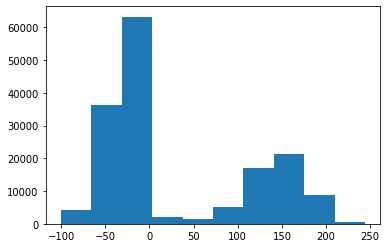

In [14]:
plt.hist(a[0, 2].flatten())

(1, 3, 400, 400) (1, 1, 400, 400)


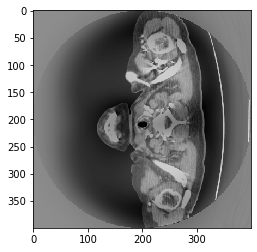

In [11]:
import matplotlib.pyplot as plt
#plt.hist(y.flatten())
#b = b.data.cpu().numpy()
print(a.shape, b.shape)
#a =  resize(y[:, :, 120].astype('float32'), [400, 400], order=0, preserve_range=True)
#plt.hist(y[:, :, 150].flatten())
#print(y[:, :, 150].shape)
#print(y1.shape)
plt.imshow(a[0, 0, :, :], cmap='gray')
#plt.imshow(y1[:, :, 50], cmap='gray')

In [3]:
out1 = np.zeros













([1, 1, 512, 512], np.float32)
out1 = torch.from_numpy(out1)
out1 = out1.cuda()

In [5]:
file_in = '/media/dril/New Volume/LUNA/ORIG-NII/1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222365663678666836860.nii.gz'
volume = nib.load(file_in)
v_data = np.squeeze(volume.get_fdata())
#print(v_data.shape)

#mean_file = '/media/dril/Windows/p-hnn-master/caffe_model/train_colour_slice_list_0.lst_mean_image.npy'
#mean_image = np.load(mean_file)
#print(mean_image.shape)
#print(net)

im1 = v_data[:, :, 0]
im1 = np.expand_dims(im1, axis=0)

im1 = np.concatenate([im1, im1, im1], axis=0)
im1 = np.expand_dims(im1, axis=0)

im = im1.astype(np.float32)
im = torch.from_numpy(im)
im = im.cuda()
p = net(im)
#print(p['sigmoid-dsn2'].shape)

total_loss = loss(p['sigmoid-dsn1'], out1) + loss(p['sigmoid-dsn2'], out1) + loss(p['sigmoid-dsn3'], out1) +  loss(p['sigmoid-dsn4'], out1) + loss(p['sigmoid-dsn5'], out1) + loss(p['sigmoid-fuse'], out1)

#total_loss = #torch.mean(total_loss)
#total_loss = 0
#for k in p:
#    if 'sigmoid-' in k:
#        total_loss = total_loss + loss(p[k], out1)
        #print(k, p[k].shape)
total_loss.backward()
#result = p.detach().cpu().numpy()
#print(result.shape)

In [ ]:
def init_normal(m):
    if type(m) == nn.Conv2d:
        nn.init.kaiming_normal_(m.weight)
    if type(m) == nn.ConvTranspose2d:
        nn.init.kaiming_normal_(m.weight)
    
net.apply(init_normal)

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable

import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary

device = torch.device("cuda:0")

'/home/dril/Downloads/pytorch_phnn.pth'

In [347]:
a = [0.24677252769470215, 0.2077016830444336, 0.2233893871307373, 0.21227669715881348, 0.2158975601196289]
print(np.mean(a), np.std(a))

0.2212075710296631 0.013774563985952545


In [348]:
b = [13.407370567321777, 13.721302509307861, 13.491996765136719, 13.50873589515686, 13.487828016281128]
print(np.mean(b), np.std(b))

13.523446750640868 0.10497122145263522


In [ ]:
# [STAR] For plotting the results

plt.figure(figsize=(40,20))
o1 = np.concatenate(all_outputs[:7, :, :], axis=0).T
print(o1.shape)

o2 = np.concatenate(x[1:8, :, :]).T
print(o2.shape)

#print(o1.shape, o2.shape)

together = np.concatenate([o1, o2], axis=0)
#print(o1.shape, o2.shape, together.shape)
print(values[1:])
plt.imshow(together, cmap='gray')

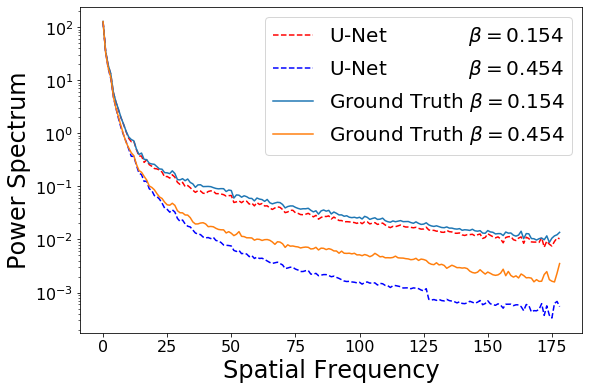

In [322]:
# [STAR] Comparing the Noise Power Spectrum

from scipy import fftpack
import pyfits
import numpy as np
import pylab as py
import radialProfile

index  = 2
image1 = o1[:, index*256:(index+1)*256]
image2 = o2[:, index*256:(index+1)*256]

index  = 5
image3 = o1[:, index*256:(index+1)*256]
image4 = o2[:, index*256:(index+1)*256]


def get_power_spectrum(image):    
    # Take the fourier transform of the image.
    F1 = fftpack.fft2(image)
    F2 = fftpack.fftshift(F1)
    
    # Calculate a 2D power spectrum
    psf2D = np.abs( F2 )**2
    
    # Calculate the azimuthally averaged 1D power spectrum
    psf1D = radialProfile.azimuthalAverage(psf2D)
    return psf1D

t1 = get_power_spectrum(image1)
t2 = get_power_spectrum(image2)

t3 = get_power_spectrum(image3)
t4 = get_power_spectrum(image4)


py.figure(3)
py.clf()

py.semilogy( t1, 'r--', label=r'U-Net             $\beta = 0.154$')
py.semilogy( t3, 'b--', label=r'U-Net             $\beta = 0.454$')

py.semilogy( t2, label=r'Ground Truth $\beta = 0.154$')
py.semilogy( t4, label=r'Ground Truth $\beta = 0.454$')


py.xlabel("Spatial Frequency", fontsize=24)
py.ylabel("Power Spectrum",fontsize=24)
py.legend(fontsize=20)
py.xticks(fontsize=16)
py.yticks(fontsize=16)
py.show()


In [ ]:
# [STAR] For getting the SSIM metric

#from skimage.metrics import structural_similarity as ssim

#from skimage import structural_similarity as ssim
from skimage import measure
import glob

import importlib
importlib.reload(haarPsi)

#import 
from haarPsi import haar_psi_numpy

test_list  = [10, 44, 45, 47, 54, 58, 59, 60, 66, 67, 74, 75]

ssim_array = {}
ssim_array[0.1] = []
ssim_array[0.2] = []
ssim_array[0.3] = []
ssim_array[0.4] = []
ssim_array[0.5] = []
ssim_array[0.6] = []


mae_array = {}
mae_array[0.1] = []
mae_array[0.2] = []
mae_array[0.3] = []
mae_array[0.4] = []
mae_array[0.5] = []
mae_array[0.6] = []

def my_mae(x, y):
    return np.mean(np.abs(x-y))

unet_model.eval()

checkit = []

flag = False

for t in test_list:
    a        = np.load("/media/dril/My Passport/REAL-DBT-PROJECTIONS/PATCHES/"+str(t)+"_0.npy")
    allfiles = glob.glob("/media/dril/My Passport/REAL-DBT-PROJECTIONS/PATCHES/"+str(t)+"_-*.npy")
    
    for f in allfiles:
        value = -1*float(f.split("/")[-1].split("_")[1][:-4])
        b     = np.load(f)
        print(f, value)
        
        for index in range(50):
            b1    = b[index, :, :, 0]
            
            t1    = a[index, :, :, 0]
            t1    = np.expand_dims(t1, 0)
            t1    = np.expand_dims(t1, 1)
            
            values  = -1*value*np.ones([1, 1])
            
            x1      = torch.tensor(t1, device=device).float()
            values  = torch.tensor(values, device=device).float()
        
            output = unet_model.forward(x1, values)
            pred   = output.data.cpu().numpy()
            
            t1 = np.min(b1.flatten())
            t2 = np.max(b1.flatten())
            reference_image = (b1-t1)*255/(t2-t1)
            
            t1 = np.min(pred[0, 0, :, :].flatten())
            t2 = np.max(pred[0, 0, :, :].flatten())
            distorted_image = (pred[0, 0, :, :]-t1)*255/(t2-t1)
            #print(np.min(distorted_image), np.max(distorted_image), np.max(reference_image), np.min(reference_image))
            
            ssim_temp = measure.compare_ssim(distorted_image, reference_image, data_range=255)
            #ssim_temp = measure.compare_ssim(pred[0, 0, :, :].astype('float16'), b1.astype('float16'))
            #ssim_temp = measure.compare_ssim(pred[0, 0, :, :].astype('float32'), b1.astype('float32'), data_range=b1.max() - b1.min())
            #ssim_temp = measure.compare_ssim(pred[0, 0, :, :].astype('float32'), b1.astype('float32'), data_range=pred[0, 0, :, :].max() - pred[0, 0, :, :].min())
            
            #ssim_temp = haar_psi_numpy(reference_image, distorted_image, preprocess_with_subsampling = True)[0]
            if ssim_temp < 0.6 and value < 0.6:
                import random
                lp = random.randint(0, 100)
                if lp > 90:
                    flag       = True
                    ssim_temp1 = haar_psi_numpy(reference_image.astype('float32'), distorted_image.astype('float32'),  preprocess_with_subsampling = True)[0]
                    print(ssim_temp, value, ssim_temp1)
                    checkit.append([reference_image, distorted_image])
                    break
            #print(ssim_temp[0], ssim_temp[1].shape)
            
            mae_temp  = my_mae(pred[0, 0, :, :], b1)
                
            if value < 0.1:
                ssim_array[0.1].append(ssim_temp)
                mae_array[0.1].append(mae_temp)
            elif value < 0.2:
                ssim_array[0.2].append(ssim_temp)
                mae_array[0.2].append(mae_temp)    
            elif  value < 0.3:
                ssim_array[0.3].append(ssim_temp)
                mae_array[0.3].append(mae_temp)    
            elif  value < 0.4:
                ssim_array[0.4].append(ssim_temp)
                mae_array[0.4].append(mae_temp)    
            elif value < 0.5:
                ssim_array[0.5].append(ssim_temp)
                mae_array[0.5].append(mae_temp)    
            elif value < 0.6:
                ssim_array[0.6].append(ssim_temp)
                mae_array[0.6].append(mae_temp)
        if flag:
            break
    if flag:
        break

values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
for t in values:
    print(t, np.mean(ssim_array[t]), np.mean(mae_array[t]), np.std(ssim_array[t]), np.std(mae_array[t]))

In [482]:
# SSIM results
0.1 0.9914873887960779 0.00018285964 0.0061945855375389125 4.591579e-05
0.2 0.9469701962447921 0.0002514394 0.02808622002535202 4.0652736e-05
0.3 0.8693526790506381 0.00026405914 0.07103994994361851 6.837431e-05
0.4 0.7924587842729388 0.00028266825 0.109039188851624 9.9856086e-05
0.5 0.7234613368989369 0.0002761438 0.1480347905261776 7.468571e-05
0.6 0.6754057684000083 0.00030263996 0.1760634203245287 0.00011321019

0.625813677591749


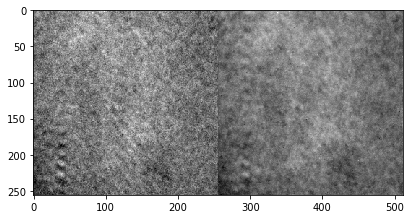

In [956]:
plt.imshow(np.concatenate([reference_image, distorted_image]).T, cmap='gray')
ssim_temp = haar_psi_numpy(reference_image, distorted_image, preprocess_with_subsampling = True)[0]
print(ssim_temp)

In [369]:
print(700+500+850+750+550+500)
# 700+500+850+750+550+500

3850


In [373]:
np.around([0.9781404488519797, 0.00018285964, 0.01689025516708194], decimals=2)

array([0.98, 0.  , 0.02])

In [ ]:
# HaarPSI metric Results

C = 200
0.1 0.9858204980953706 0.00018285964 0.011030629237313055 4.591579e-05
0.2 0.9441371588055242 0.0002514394 0.029445817913910526 4.0652736e-05
0.3 0.8953782020430879 0.00026405914 0.0610303481328526 6.837431e-05
0.4 0.8582752275967497 0.00028266825 0.08258155017354446 9.9856086e-05
0.5 0.8333061976821139 0.0002761438 0.10266725558456456 7.468571e-05
0.6 0.8278191186427702 0.00030263996 0.10160239220458343 0.00011321019

C = 100
0.1 0.9781404488519797 0.00018285964 0.01689025516708194 4.591579e-05
0.2 0.9161082165669477 0.0002514394 0.04262870928171611 4.0652736e-05
0.3 0.8528422052051116 0.00026405914 0.08093317170347102 6.837431e-05
0.4 0.8089372698393853 0.00028266825 0.10316644268939193 9.9856086e-05
0.5 0.7805865981601848 0.0002761438 0.12404749575544136 7.468571e-05
0.6 0.772734007012864 0.00030263996 0.1221296098897257 0.00011321019

C = 30
0.1 0.9578447597119935 0.00018285964 0.03167215278443286 4.591579e-05
0.2 0.8526258075981621 0.0002514394 0.06833211279899469 4.0652736e-05
0.3 0.7715300871905484 0.00026405914 0.11194060661440992 6.837431e-05
0.4 0.7223023686087682 0.00028266825 0.12983286520123713 9.9856086e-05
0.5 0.69266904946197 0.0002761438 0.14962337437161627 7.468571e-05
0.6 0.6805525969198479 0.00030263996 0.14551783795880077 0.00011321019

In [ ]:
# Getting patches for each lesion for training the calibaration CNN with lesions only Noisy patches

allfiles = glob.glob("/media/dril/Windows/newrecon2/newrecon/dbt_real_annotation/index-b-*.npy")
allindex = []
for f in allfiles:
    index = int(f.split("/")[-1].split("-")[-1][:-4])
    allindex.append(index)

patches = {}
values  = {}

for k in allindex:
    #if h[k][0] not in allindex:
    #    continue
    x = []
    y = []
    z = []
    
    patches = []
    values  = []
    
    path = glob.glob("/media/dril/My Passport/REAL-DBT-PROJECTIONS/RECONS/*_"+str(h[k][0])+".raw")[0]
    vol  = np.fromfile(path, dtype="float32")
    vol  = np.reshape(vol, [64, 1200, 3000])
    
    temp_count = 0
    
    for tp in range(-2, 2):
        temp = vol[h[k][3]+tp, h[k][2]-128:h[k][2]+128, h[k][1]-128:h[k][1]+128]
        if temp.shape[0] == 256 and temp.shape[1] == 256:
            x.append(temp)
    
    x      = np.array(x)
    
    print(path, x.shape, k)
    
    np.save("/media/dril/Windows/newrecon2/newrecon/dbt_real_cho_data/noisy_x_"+str(k)+".npy", x)

In [ ]:
# Getting patches for each lesion for training the calibaration CNN with No lesions only Noisy patches

allfiles = glob.glob("/media/dril/Windows/newrecon2/newrecon/dbt_real_annotation/index-b-*.npy")
allindex = []
for f in allfiles:
    index = int(f.split("/")[-1].split("-")[-1][:-4])
    #print(f, index)
    allindex.append(index)

patches = {}
values  = {}



for k in allindex:
    #if h[k][0] not in allindex:
    #    continue
    x = []
    y = []
    z = []
    
    patches = []
    values  = []
    
    path = glob.glob("/media/dril/My Passport/REAL-DBT-PROJECTIONS/RECONS/*_"+str(h[k][0])+".raw")[0]
    vol  = np.fromfile(path, dtype="float32")
    vol  = np.reshape(vol, [64, 1200, 3000])
    
    dx_array = [-5, 5]#, -10, 10]
    dy_array = [-5, 5]#, -10, 10]
    
    temp_count = 0
    while(temp_count < 50):
        ix = np.random.randint(256, 1200-256)
        iy = np.random.randint(256, 3000-256)
        iz = np.random.randint(10, 54)

        tempx = vol[iz, ix:ix+256, iy:iy+256]

        if np.count_nonzero(tempx.flatten())*1.0/(256*256) < 0.9:
            continue
        
        if tempx.shape[0] == 256 and tempx.shape[1] == 256:
            x.append(tempx)
            temp_count = temp_count + 1
#         
        
    x = np.array(x).astype('float16')
    #y = np.array(y)
    #z = np.array(z)
    
    #print(x.shape, y.shape, z.shape)
    print(x.shape, k)
    
    np.save("/media/dril/Windows/newrecon2/newrecon/dbt_real_cho_data/noisy_no_x_"+str(k)+".npy", x)

In [ ]:
# For plotting Power Spectrum

from scipy import fftpack
import pyfits
import numpy as np
import pylab as py
import radialProfile

image = #pyfits.getdata(‘myimage.fits’)

# Take the fourier transform of the image.
F1 = fftpack.fft2(image)
F2 = fftpack.fftshift( F1 )from scipy import fftpack
import pyfits
import numpy as np
import pylab as py
import radialProfile

image = #pyfits.getdata(‘myimage.fits’)

# Take the fourier transform of the image.
F1 = fftpack.fft2(image)
F2 = fftpack.fftshift( F1 )

# Calculate a 2D power spectrum
psd2D = np.abs( F2 )**2

# Calculate the azimuthally averaged 1D power spectrum
psd1D = radialProfile.azimuthalAverage(psd2D)

# Now plot up both
py.figure(1)
py.clf()
py.imshow( np.log10( image ), cmap=py.cm.Greys)

py.figure(2)
py.clf()
py.imshow( np.log10( psf2D ))

py.figure(3)
py.clf()
py.semilogy( psf1D )
py.xlabel(‘Spatial Frequency’)
py.ylabel(‘Power Spectrum’)

py.show()

# Calculate a 2D power spectrum
psd2D = np.abs( F2 )**2

# Calculate the azimuthally averaged 1D power spectrum
psd1D = radialProfile.azimuthalAverage(psd2D)

# Now plot up both
py.figure(1)
py.clf()
py.imshow( np.log10( image ), cmap=py.cm.Greys)

py.figure(2)
py.clf()
py.imshow( np.log10( psf2D ))

py.figure(3)
py.clf()
py.semilogy( psf1D )
py.xlabel(‘Spatial Frequency’)
py.ylabel(‘Power Spectrum’)

py.show()

In [ ]:
# For training the Rating CNN using Real DBT slices Data

#10336 4148
#6920 2770

#2160 864

import glob
import numpy as np

#trainx = np.zeros([153, 1, 256, 256])
#trainy = np.zeros([153, 1])
#trainv = np.zeros([153, 1])

valx   = np.zeros([63, 1, 256, 256])
valy   = np.zeros([63, 1])
valv   = np.zeros([63, 1])

train_list = [1, 3, 6, 7, 11, 12, 13, 16, 17, 31, 33, 35, 37, 39, 41, 43, 50, 52, 55,  68, 69, 70, 71, 72, 73, 76]
val_list   = [19, 21, 23, 25, 27, 29, 61, 62, 64, 65]
test_list  = [10, 44, 45, 47, 54, 58, 59, 60, 66, 67, 74, 75]

traincount = 0
valcount   = 0

allfiles = glob.glob("/media/dril/Windows/newrecon2/newrecon/dbt_real_cho_data/noisy_x_*.npy")
for f in allfiles:
    print(f)
    x1 = np.load(f)
    y1 = -1*np.load(f.replace("noisy_x_", "y_"))
    #print(y1)
    
    #print(f.split("/")[-1].split("_"))
    k = int(f.split("/")[-1].split("_")[2][:-4])
    #print(k, h[k])
    
    x1 = np.expand_dims(x1, axis=-1)
    #y1 = np.expand_dims(y1, axis=-1)
    
    #print(x1.shape, y1.shape)
    
    if h[k][0] in train_list:
        #print(x1.shape, y1.shape, "Train")
        if x1.shape[0] == 0:
            continue
        
        #trainx[traincount:traincount+x1.shape[0], 0, :, :] = x1[:, :, :, 0]
        #trainy[traincount:traincount+x1.shape[0], 0] = 1
        #trainv[traincount:traincount+x1.shape[0], 0] = y1
        
        #trainx.append(x1)
        #trainy.append(y1)
        traincount = traincount+x1.shape[0]
    elif h[k][0] in val_list:
        #print(x1.shape, y1.shape, "Val")
        if x1.shape[0] == 0:
            continue
        
        valx[valcount:valcount+x1.shape[0], 0, :, :] = x1[:, :, :, 0]
        valy[valcount:valcount+x1.shape[0], 0] = 1
        #valv[valcount:valcount+x1.shape[0], 0] = y1
        
        #valx.append(x1)
        #valy.append(y1)
        valcount = valcount+x1.shape[0]

print(traincount, valcount)

# # trainx_lesion = copy.deepcopy(trainx)
# # trainy_lesion = copy.deepcopy(trainy)

# share = 10
# allfiles = glob.glob("/media/dril/Windows/newrecon2/newrecon/dbt_real_cho_data/noisy_no_x_*.npy")
# for f in allfiles:
#     #print(f)
#     x1 = np.load(f)
#     #y1 = -1*np.load(f.replace("x_", "v_"))
    
#     #print(f.split("/")[-1].split("_"))
#     k = int(f.split("/")[-1].split("_")[3][:-4])
#     #print(k, h[k])
    
#     x1 = np.expand_dims(x1, axis=-1)
#     #y1 = np.expand_dims(y1, axis=-1)
    
#     #print(x1.shape, y1.shape, k)
    
    
#     if h[k][0] in train_list:
#         #print(x1.shape, y1.shape, "Train")
#         if x1.shape[0] == 0:
#             continue
        
#         #trainx[traincount:traincount+int(x1.shape[0]/share), 0, :, :] = x1[:int(x1.shape[0]/share), :, :, 0]
#         #trainy[traincount:traincount+int(x1.shape[0]/share), 0] = 0
#         #trainv[traincount:traincount+x1.shape[0], 0] = y1
        
#         #trainx.append(x1)
#         #trainy.append(y1)
#         traincount = traincount+int(x1.shape[0]/share)
#         #print(traincount, " traincount")
#     elif h[k][0] in val_list:
#         #print(x1.shape, y1.shape, "Val")
#         if x1.shape[0] == 0:
#             continue
        
#         valx[valcount:valcount+int(x1.shape[0]/share), 0, :, :] = x1[:int(x1.shape[0]/share), :, :, 0]
#         valy[valcount:valcount+int(x1.shape[0]/share), 0] = 0
#         #valv[valcount:valcount+x1.shape[0], 0] = y1
#         #valx.append(x1)
#         #valy.append(y1)
#         valcount = valcount+int(x1.shape[0]/share)
# #     elif h[k][0] in test_list:
# #         print("Found in test ", k)
# #     else:
# #         print("Not found ")



print(traincount, valcount)

In [ ]:
# For training the Rating CNN in Keras

from keras.preprocessing.image import ImageDataGenerator


aug_train = ImageDataGenerator(
    rotation_range=45,
    zoom_range=0.15,
    shear_range=0.15,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode="nearest")


tempx = []
tempy = []
#
#whileaug_train.flow(trainx, trainy, batch_size=32)

for i, (x, y) in enumerate(aug_train.flow(trainx, trainy, batch_size=32)):
    for k in range(len(x)):
        tempx.append(x[k])
    for k in range(len(y)):
        tempy.append(y[k])
    #print(x.shape, y.shape)
    
    if len(tempx) >= 30000:
        break

tempx = np.array(tempx)
tempy = np.array(tempy)

print(tempx.shape, tempy.shape)

#tempx = np.reshape(tempx, [len(tempx)*32, 1, 256, 256])
#tempy = np.reshape(tempy, [len(tempy)*32, 1])

print(tempx.shape, tempy.shape)

np.save("trainx_rating.npy", tempx)
np.save("trainy_rating.npy", tempy)
#print(i, x.shape, y.shape)
#print(aug_train.flow(trainx, trainy, batch_size=32))

In [ ]:
# For training the Rating CNN in Pytorch

trainx = np.zeros([160, 256, 256, 1])
trainy = np.zeros([160, 1])
valx   = np.zeros([230, 256, 256, 1])
valy   = np.zeros([230, 1])

train_list = [1, 3, 6, 7, 11, 12, 13, 16, 17, 31, 33, 35, 37, 39, 41, 43, 50, 52, 55,  68, 69, 70, 71, 72, 73, 76]
val_list   = [19, 21, 23, 25, 27, 29, 61, 62, 64, 65]
test_list  = [10, 44, 45, 47, 54, 58, 59, 60, 66, 67, 74, 75]

traincount = 0
valcount   = 0

allfiles = glob.glob("/media/dril/Windows/newrecon2/newrecon/dbt_real_ratings/x_*.npy")
for f in allfiles:
    #print(f)
    
    x1 = np.load(f)
    y1 = -1*np.load(f.replace("x_", "z_"))
    
    k = int(f.split("/")[-1].split("_")[1][:-4])
    #print(k, h[k])
    
    x1 = np.expand_dims(x1, axis=-1)
    y1 = np.expand_dims(y1, axis=-1)
    
    #print(x1.shape, y1.shape)
    
    if h[k][0] in train_list:
        #print(x1.shape, y1.shape, "Train")
        if x1.shape[0] == 0:
            continue
        
        trainx[traincount:traincount+x1.shape[0], :, :, :] = x1
        trainy[traincount:traincount+x1.shape[0], :] = y1
        #trainx.append(x1)
        #trainy.append(y1)
        traincount = traincount+x1.shape[0]
    elif h[k][0] in test_list:
        print(f)
        #print(x1.shape, y1.shape, "Val")
        if x1.shape[0] == 0:
            continue
        
        #valx[valcount:valcount+x1.shape[0], :, :, :] = x1
        #valy[valcount:valcount+x1.shape[0], :] = y1
        #valx.append(x1)
        #valy.append(y1)
        valcount = valcount+x1.shape[0]

print(traincount, valcount)
    

In [ ]:
# For training the CNN in Keras

from keras.applications.vgg16 import preprocess_input
from keras.applications import VGG16

# new_input = Input(shape=(256, 256, 3))
# #model = VGG16(include_top=False, input_tensor=new_input)

# base_model = VGG16(weights='imagenet', include_top=False) #imports the mobilenet model and discards the last 1000 neuron layer.

# x=base_model.output
# x=GlobalAveragePooling2D()(x)
# # x = Dropout(0.5)(x)
# x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
# x=Dense(512,activation='relu')(x)
# x=Dense(1,activation='sigmoid')(x)

# #x=Dense(1024,activation='relu')(x) #dense layer 2
# # x=Dense(512,activation='relu')(x) #dense layer 3
# # preds=Dense(1,activation='relu')(x)

# model = Model(inputs=base_model.input,outputs=x)
# model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])





model = rating_cnn()
#model.load_weights("rate-6-ddsm.h5")
print(model.summary())


#out1 = model.outputrating_c
#newmodel = Model()
#model.add(GlobalAveragePooling2D())
#print(model.summary())
checkpoints = ModelCheckpoint('rate-10.h5', monitor='val_loss', verbose=0, save_best_only=True, 
                                        save_weights_only=False, mode='auto', period=1)
# trainy1 = trainy-1
# valy1   = valy-1

from keras.preprocessing.image import ImageDataGenerator


aug_train = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    shear_range=0.15,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode="nearest")

model.fit_generator(aug_train.flow(trainx, trainy, batch_size=32),
                    validation_data=(valx, valy),
                    steps_per_epoch=len(trainx) // 32,
                    epochs=10000,
                   callbacks=[checkpoints])

#model.fit(trainx, trainy, validation_data=(valx, valy), batch_size=32, epochs=1000000)

In [ ]:
# Bad index -> 2, 6, 23, 18, 20, 36, 54
# For paper -> 10, 16, 33 (maybe)

In [ ]:
# Lesion Location information

1  1692, 1034, 34
3  2043, 280,  18
3  2124, 1146, 17
3  1272, 236,  32
6  1293, 440,  16
7  1708, 496,  44
7  941, 1100,  13
10 874, 1018,  28
10 1922, 734,  33 
10 1957, 413,  38
10 2018, 556,  37
10 1961, 470,  7
11 1298, 661,  22
12 
13 1628, 348,  34
13 1797, 854,  34
13 1622, 349,  34
13 1596, 510,  31
13 1550, 669,  37
16 
17  
19 686, 1125, 20
21 732, 464,  9
23 
25 1985, 576,  64
25 1440, 256,  57
25 1864, 1040, 36
27 1429. 925,  64
27 1278, 829,  64
29 1246, 977,  21
29 1380, 905,  19
31
33 1104, 666,  24
35 1670, 725,  17
37 1128, 877,  56
39 
41 1084, 934,  42
43 
44 1480, 970,  19
45 1638, 610,  47
47 1062, 646,  23
47 1301, 564,  23
47 1870, 625,  23
50 
52 
54 706, 1162,  27
55 
56 (bad)
57 (bad)
58 
59 841, 1038,  32
60 554, 553,   28
60 468, 830,   22
61 
62 
64 1948, 854,  22
65 1820, 600,  25
66 1510, 328,  40
66 1328, 1001, 20
66 1950, 630,  46 (test)
66 1544, 529,  37
67 1672, 542,  42
67 2138, 612,  36
67 1797, 694,  35
67 1164, 737,  33 (test)
68                (train) 
69                (train)
70 1341, 762, 10
71 1433, 769, 14  (train)
72                (train)
73                (train)
74 2302, 457, 28  (test)
75 2107, 777, 40  (test)
76                (train)


In [ ]:
# Code to get the patches

#todo = [15, 16, 19, 20, 27, 29, 31, 35]

for i in range(1, 77):
    if i not in test_list:
        continue
    
    #todo = [15, 16, 19, 20, 27, 29, 31, 35]
    allfiles = glob.glob("/media/dril/My Passport/REAL-DBT-PROJECTIONS/RECONS/*_"+str(i)+".raw.npy")
    if len(allfiles) == 0:
        continue
    
    mainfile = glob.glob("/media/dril/My Passport/REAL-DBT-PROJECTIONS/RECONS/*_"+str(i)+".raw")[0]
    
    all_vols   = np.zeros([len(allfiles)+1, 64, 1200, 3000], dtype='float16')
    all_index  = []
    all_values = []
    
    temp = np.fromfile(mainfile, dtype='float32')
    temp = np.reshape(temp, [64, 1200, 3000])
    all_vols[0, :, :, :] = temp
    all_index.append(i)
    all_values.append(-0)
    
    counter = 1
    for f in allfiles:
        #a = np.fromfile(f, dtype='float32')
        a     = np.load(f)
        a     = np.reshape(a, [64, 1200, 3000])
        all_vols[counter, :, :, :] = a
        
        index = int(f.split("/")[-1].split("_")[-1].split(".")[0])
        value = float(f.split("/")[-1].split("_")[-2])
        
        all_index.append(index)
        all_values.append(value)
        print(index, value, a.shape, f)
        counter = counter+1
    
    total_count   = 50
    all_locations = []
    
    # Get all Locations
    while(True):
        ix = np.random.randint(256, 1200-256)
        iy = np.random.randint(256, 3000-256)
        iz = np.random.randint(10, 54)
        
        tempx = all_vols[0][iz, ix:ix+256, iy:iy+256]
        
        if np.count_nonzero(tempx.flatten())*1.0/(256*256) < 0.9:
            continue
        
        all_locations.append([ix, iy, iz])
        if len(all_locations) == total_count:
            break
    
    # Get patches
    for k in range(len(all_vols)):
        y_array = np.zeros([total_count, 256, 256, 1], dtype='float16')
        counter = 0
        
        for p in all_locations:
            iz = p[2]
            ix = p[0]
            iy = p[1]
            
            tempy   = all_vols[k][iz, ix:ix+256, iy:iy+256]
            y_array[counter, :, :, 0] = tempy
            counter = counter+1
        np.save("/media/dril/My Passport/REAL-DBT-PROJECTIONS/PATCHES/"+str(all_index[k])+'_'+str(all_values[k])+'.npy', y_array)
    
    

In [66]:
# For reading the training data

import glob
import numpy as np

train_list = [1, 3, 6, 7, 11, 12, 13, 16, 17, 31, 33, 35, 37, 39, 41, 43, 50, 52, 55,  68, 69, 70, 71, 72, 73, 76]
val_list   = [19, 21, 23, 25, 27, 29, 61, 62, 64, 65]
test_list  = [10, 44, 45, 47, 54, 58, 59, 60, 66, 67, 74, 75]

# 10650, 3950
# 8200, 3160

x_array = np.zeros([10250, 1, 256, 256], dtype='float16')
z_array = np.zeros([10250, 1], dtype='float16')
y_array = np.zeros([10250, 1, 256, 256], dtype='float16')


x_val_array = np.zeros([3950, 1, 256, 256], dtype='float16')
z_val_array = np.zeros([3950, 1], dtype='float16')
y_val_array = np.zeros([3950, 1, 256, 256], dtype='float16')

count = 0
for t in train_list:
    #print(t)
    maintemp = np.load("/media/dril/My Passport/REAL-DBT-PROJECTIONS/PATCHES/"+str(t)+"_0.npy")
    #maintemp = np.load(mainfile)
    
    allfiles = glob.glob("/media/dril/My Passport/REAL-DBT-PROJECTIONS/PATCHES/"+str(t)+"_*-*.npy")
    for f in allfiles:
        temp = np.load(f)
        #print(temp.shape)
        #print(f, temp.shape, float(f.split("/")[-1].split("_")[1][:-4]))
        y_array[count: count+50, 0, :, :] = temp[:, :, :, 0]
        x_array[count: count+50, 0, :, :] = maintemp[:, :, :, 0]
        z_array[count: count+50, :]       = np.ones([50, 1])*float(f.split("/")[-1].split("_")[1][:-4])
        count = count+50

print(x_array.shape, y_array.shape, z_array.shape, count)




count = 0
for t in val_list:
    #print(t)
    maintemp = np.load("/media/dril/My Passport/REAL-DBT-PROJECTIONS/PATCHES/"+str(t)+"_0.npy")
    #maintemp = np.load(mainfile)
    
    allfiles = glob.glob("/media/dril/My Passport/REAL-DBT-PROJECTIONS/PATCHES/"+str(t)+"_*-*.npy")
    for f in allfiles:
        temp = np.load(f)
        
        #print(f, temp.shape, float(f.split("/")[-1].split("_")[1][:-4]))
        y_val_array[count: count+50, 0, :, :] = temp[:50, :, :, 0]
        x_val_array[count: count+50, 0, :, :] = maintemp[:50, :, :, 0]
        z_val_array[count: count+50, :]       = np.ones([50, 1])*float(f.split("/")[-1].split("_")[1][:-4])
        count = count+50
        
print(x_val_array.shape, y_val_array.shape, z_val_array.shape, count)

(10250, 1, 256, 256) (10250, 1, 256, 256) (10250, 1) 10250
(3950, 1, 256, 256) (3950, 1, 256, 256) (3950, 1) 3950


In [2]:
import numpy as np

trainx = np.load("trainx_rating.npy")
trainy = np.load("trainy_rating.npy")

print(trainx.shape, trainy.shape)

(30020, 1, 256, 256) (30020, 1)


In [ ]:
# For training the Rating CNN pytorch


import torch.optim as optim

device    = torch.device("cuda:0")
optimizer = optim.Adam(rating_cnn.parameters(), lr=0.0001)
criterion = nn.BCELoss()

def my_loss(output, target):
    loss = torch.mean(torch.abs((output - target)))
    return loss

prev_min = 1000

#model.train()
for epoch in range(1000):
    rating_cnn.train()
    loss_array = []
    
    for i in range(len(trainx)//32):
        x = trainx[i*32:(i+1)*32, :, :, :]
        y = trainy[i*32:(i+1)*32, :]
        #z = z_array[i*8:(i+1)*8, :]
        
        #print(x.shape, y.shape, z.shape)
        
        x = torch.tensor(x, device=device).float()
        y = torch.tensor(y, device=device).float()
        #z = torch.tensor(z, device=device).float()
        
        optimizer.zero_grad()
        output = rating_cnn(x)
        #print(output.shape)
        #break
        #print(x.data.shape, output.data.shape, y.data.shape)
        
        loss = criterion(output, y)
        #if i % 100 == 0:
        #    print(i, loss.data.shape, loss.item())
        
        loss_array.append(loss.item())
        
        #print(loss.item())
        #optim.zero_grad()
        
        loss.backward()
        optimizer.step()
        
        if i %100 == 0:
            rating_cnn.eval()
            loss_array_val = []
            for ik in range(len(valx)//8):
                x = valx[ik*8:(ik+1)*8, :, :, :]
                y = valy[ik*8:(ik+1)*8, :]
                #z = z_val_array[i*8:(i+1)*8, :]

                x = torch.tensor(x, device=device).float()
                y = torch.tensor(y, device=device).float()
                #z = torch.tensor(z, device=device).float()

                output = rating_cnn(x)

                loss = criterion(output, y)
                loss_array_val.append(loss.item())

            val_loss = np.mean(loss_array_val)
            print("Val loss ", val_loss)

            if val_loss < prev_min:
                prev_min = val_loss
                torch.save(rating_cnn.state_dict(), "rating_pytorch.pt")
            rating_cnn.train()
    print(np.mean(loss_array))
    
    
    

In [22]:
rating_cnn.eval()
total_outputs = []
total_ground  = []

loss_array_val = []
for ik in range(len(valx)//8):
    x = valx[ik*8:(ik+1)*8, :, :, :]
    y = valy[ik*8:(ik+1)*8, :]
    #z = z_val_array[i*8:(i+1)*8, :]

    x = torch.tensor(x, device=device).float()
    y = torch.tensor(y, device=device).float()
    #z = torch.tensor(z, device=device).float()

    output = rating_cnn(x)
    
    temp = y.data.cpu().flatten()
    for p in temp:
        total_ground.append(p)
    temp = output.data.cpu().flatten()
    for p in temp:
        total_outputs.append(p)


In [ ]:
import torch.optim as optim

device    = torch.device("cuda:0")
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.L1Loss()

def my_loss(output, target):
    loss = torch.mean(torch.abs((output - target)))
    return loss

prev_min = 1000

#model.train()
for epoch in range(1000):
    model.train()
    loss_array = []
    for i in range(len(x_array)//8):
        x = x_array[i*8:(i+1)*8, :, :, :]
        y = y_array[i*8:(i+1)*8, :, :, :]
        z = z_array[i*8:(i+1)*8, :]
        
        #print(x.shape, y.shape, z.shape)
        
        x = torch.tensor(x, device=device).float()
        y = torch.tensor(y, device=device).float()
        z = torch.tensor(z, device=device).float()
        
        optimizer.zero_grad()
        output = model(x, z)
        #print(output.shape)
        #break
        #print(x.data.shape, output.data.shape)
        
        loss = my_loss(output, y)
        #if i % 100 == 0:
        #    print(i, loss.data.shape, loss.item())
        
        loss_array.append(loss.item())
        
        #print(loss.item())
        #optim.zero_grad()
        
        loss.backward()
        optimizer.step()
    print(np.mean(loss_array))
    
    
    model.eval()
    loss_array = []
    for i in range(len(x_val_array)//8):
        x = x_val_array[i*8:(i+1)*8, :, :, :]
        y = y_val_array[i*8:(i+1)*8, :, :, :]
        z = z_val_array[i*8:(i+1)*8, :]

        x = torch.tensor(x, device=device).float()
        y = torch.tensor(y, device=device).float()
        z = torch.tensor(z, device=device).float()

        output = model(x, z)

        loss = my_loss(output, y)
        loss_array.append(loss.item())
    
    val_loss = np.mean(loss_array)
    print("Val loss ", val_loss)
    if val_loss < prev_min:
        prev_min = val_loss
        torch.save(model.state_dict(), "unet_pytorch.pt")
    
# model.eval()

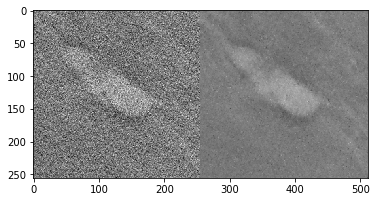

In [67]:
t1 = out1.data.cpu().numpy()
plt.imshow(np.concatenate([valx[5, 0, :, :], t1[0 , 0, :, :]]).T, cmap='gray')

In [22]:
#torch.save(model.state_dict(), "/media/dril/Windows/newrecon2/newrecon/pytorch1.pt")